<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-07-22 19:34:43.511890: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-22 19:34:43.543528: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-22 19:34:43.543552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-22 19:34:43.544607: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-22 19:34:43.550076: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-22 19:34:43.550636: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-07-22 19:34:44.299413: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-07-22 19:34:46.777576: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 93ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

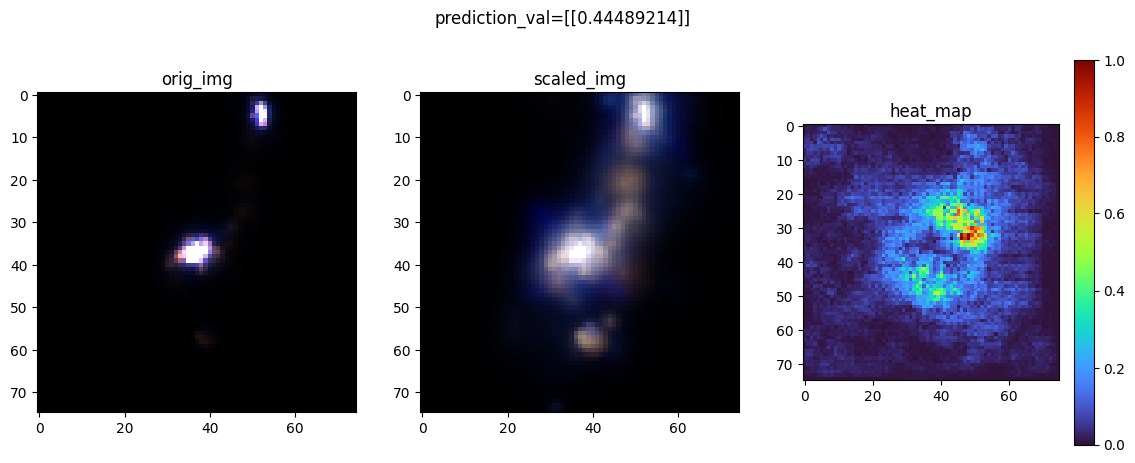

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

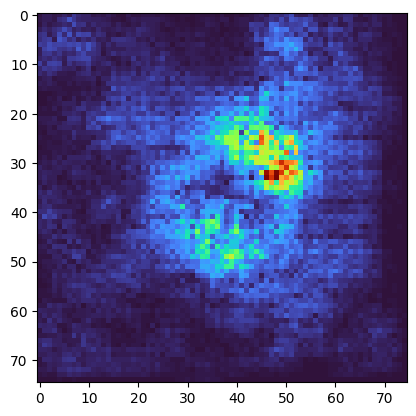

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-07-22 19:34:49.877344: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-22 19:34:50.741954: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-22 19:34:50.816457: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-07-22 19:34:50.858282: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-07-22 19:34:52.352834: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

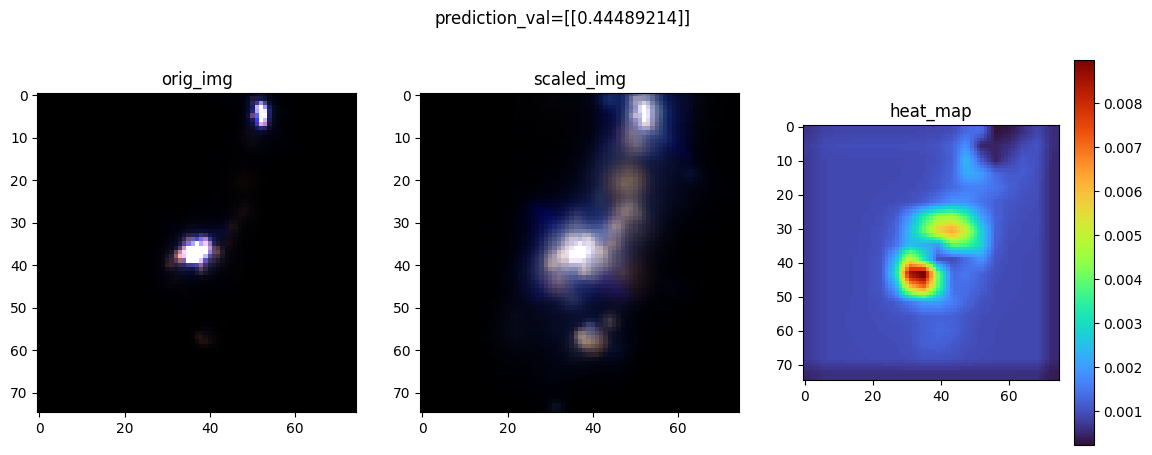

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 4/32 [==>...........................] - ETA: 0s

 8/32 [======>.......................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

20/32 [=================>............] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 1s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

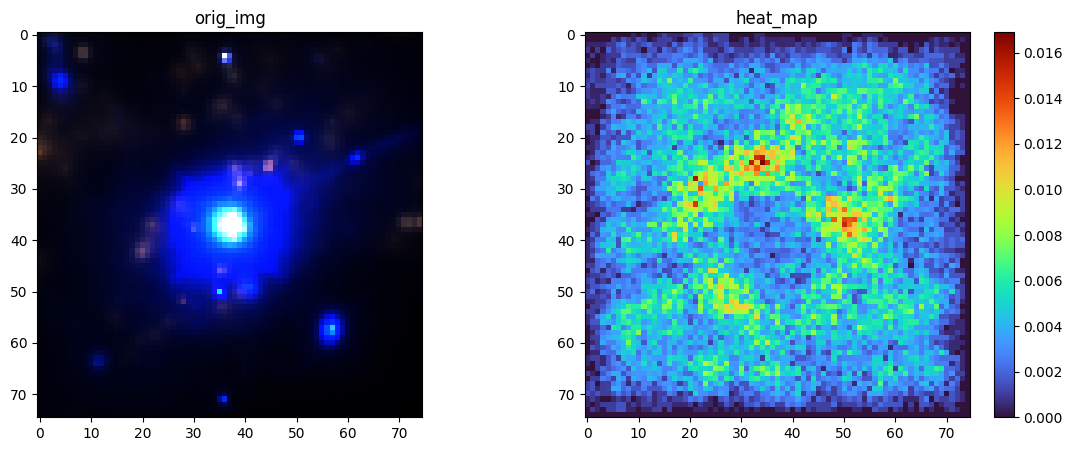

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 6:21 - loss: 0.7097 - accuracy: 0.5000

  2/338 [..............................] - ETA: 19s - loss: 0.7092 - accuracy: 0.5156 

  3/338 [..............................] - ETA: 19s - loss: 0.7092 - accuracy: 0.5104

  4/338 [..............................] - ETA: 19s - loss: 0.7089 - accuracy: 0.5156

  5/338 [..............................] - ETA: 19s - loss: 0.7087 - accuracy: 0.5063

  6/338 [..............................] - ETA: 19s - loss: 0.7085 - accuracy: 0.5104

  7/338 [..............................] - ETA: 19s - loss: 0.7084 - accuracy: 0.4955

  8/338 [..............................] - ETA: 19s - loss: 0.7079 - accuracy: 0.5117

  9/338 [..............................] - ETA: 19s - loss: 0.7076 - accuracy: 0.5174

 10/338 [..............................] - ETA: 18s - loss: 0.7075 - accuracy: 0.5094

 11/338 [..............................] - ETA: 18s - loss: 0.7071 - accuracy: 0.5170

 12/338 [>.............................] - ETA: 18s - loss: 0.7070 - accuracy: 0.5104

 13/338 [>.............................] - ETA: 18s - loss: 0.7066 - accuracy: 0.5192

 14/338 [>.............................] - ETA: 18s - loss: 0.7065 - accuracy: 0.5134

 15/338 [>.............................] - ETA: 18s - loss: 0.7064 - accuracy: 0.5042

 16/338 [>.............................] - ETA: 18s - loss: 0.7062 - accuracy: 0.5020

 17/338 [>.............................] - ETA: 18s - loss: 0.7061 - accuracy: 0.4890

 18/338 [>.............................] - ETA: 18s - loss: 0.7059 - accuracy: 0.4896

 19/338 [>.............................] - ETA: 18s - loss: 0.7057 - accuracy: 0.4901

 20/338 [>.............................] - ETA: 18s - loss: 0.7054 - accuracy: 0.4922

 21/338 [>.............................] - ETA: 18s - loss: 0.7053 - accuracy: 0.4851

 22/338 [>.............................] - ETA: 18s - loss: 0.7051 - accuracy: 0.4844

 23/338 [=>............................] - ETA: 17s - loss: 0.7049 - accuracy: 0.4823

 24/338 [=>............................] - ETA: 17s - loss: 0.7047 - accuracy: 0.4818

 25/338 [=>............................] - ETA: 17s - loss: 0.7046 - accuracy: 0.4837

 26/338 [=>............................] - ETA: 17s - loss: 0.7044 - accuracy: 0.4856

 27/338 [=>............................] - ETA: 17s - loss: 0.7042 - accuracy: 0.4907

 28/338 [=>............................] - ETA: 17s - loss: 0.7040 - accuracy: 0.4922

 29/338 [=>............................] - ETA: 17s - loss: 0.7039 - accuracy: 0.4946

 30/338 [=>............................] - ETA: 17s - loss: 0.7037 - accuracy: 0.4948

 31/338 [=>............................] - ETA: 17s - loss: 0.7035 - accuracy: 0.4990

 32/338 [=>............................] - ETA: 17s - loss: 0.7034 - accuracy: 0.5039

 33/338 [=>............................] - ETA: 17s - loss: 0.7032 - accuracy: 0.5085

 34/338 [==>...........................] - ETA: 17s - loss: 0.7030 - accuracy: 0.5055

 35/338 [==>...........................] - ETA: 17s - loss: 0.7029 - accuracy: 0.5089

 36/338 [==>...........................] - ETA: 17s - loss: 0.7027 - accuracy: 0.5095

 37/338 [==>...........................] - ETA: 17s - loss: 0.7026 - accuracy: 0.5093

 38/338 [==>...........................] - ETA: 17s - loss: 0.7024 - accuracy: 0.5123

 39/338 [==>...........................] - ETA: 17s - loss: 0.7023 - accuracy: 0.5112

 40/338 [==>...........................] - ETA: 17s - loss: 0.7022 - accuracy: 0.5109

 41/338 [==>...........................] - ETA: 16s - loss: 0.7021 - accuracy: 0.5084

 42/338 [==>...........................] - ETA: 16s - loss: 0.7020 - accuracy: 0.5052

 43/338 [==>...........................] - ETA: 16s - loss: 0.7019 - accuracy: 0.5044

 44/338 [==>...........................] - ETA: 16s - loss: 0.7018 - accuracy: 0.5014

 45/338 [==>...........................] - ETA: 16s - loss: 0.7017 - accuracy: 0.5028

 46/338 [===>..........................] - ETA: 16s - loss: 0.7016 - accuracy: 0.5041

 47/338 [===>..........................] - ETA: 16s - loss: 0.7014 - accuracy: 0.5066

 48/338 [===>..........................] - ETA: 16s - loss: 0.7013 - accuracy: 0.5046

 49/338 [===>..........................] - ETA: 16s - loss: 0.7013 - accuracy: 0.5026

 50/338 [===>..........................] - ETA: 16s - loss: 0.7012 - accuracy: 0.5006

 51/338 [===>..........................] - ETA: 16s - loss: 0.7011 - accuracy: 0.5018

 52/338 [===>..........................] - ETA: 16s - loss: 0.7010 - accuracy: 0.5018

 53/338 [===>..........................] - ETA: 16s - loss: 0.7009 - accuracy: 0.5041

 54/338 [===>..........................] - ETA: 16s - loss: 0.7008 - accuracy: 0.5064

 55/338 [===>..........................] - ETA: 16s - loss: 0.7007 - accuracy: 0.5085

 56/338 [===>..........................] - ETA: 16s - loss: 0.7006 - accuracy: 0.5084

 57/338 [====>.........................] - ETA: 15s - loss: 0.7006 - accuracy: 0.5060

 58/338 [====>.........................] - ETA: 15s - loss: 0.7005 - accuracy: 0.5043

 59/338 [====>.........................] - ETA: 15s - loss: 0.7004 - accuracy: 0.5053

 60/338 [====>.........................] - ETA: 15s - loss: 0.7003 - accuracy: 0.5068

 61/338 [====>.........................] - ETA: 15s - loss: 0.7003 - accuracy: 0.5051

 62/338 [====>.........................] - ETA: 15s - loss: 0.7002 - accuracy: 0.5040

 63/338 [====>.........................] - ETA: 15s - loss: 0.7001 - accuracy: 0.5040

 64/338 [====>.........................] - ETA: 15s - loss: 0.7001 - accuracy: 0.5024

 65/338 [====>.........................] - ETA: 15s - loss: 0.7000 - accuracy: 0.5014

 66/338 [====>.........................] - ETA: 15s - loss: 0.7000 - accuracy: 0.5005

 67/338 [====>.........................] - ETA: 15s - loss: 0.7000 - accuracy: 0.4991

 68/338 [=====>........................] - ETA: 15s - loss: 0.6999 - accuracy: 0.4972

 69/338 [=====>........................] - ETA: 15s - loss: 0.6999 - accuracy: 0.4968

 70/338 [=====>........................] - ETA: 15s - loss: 0.6998 - accuracy: 0.4978

 71/338 [=====>........................] - ETA: 15s - loss: 0.6997 - accuracy: 0.4969

 72/338 [=====>........................] - ETA: 15s - loss: 0.6997 - accuracy: 0.4970

 73/338 [=====>........................] - ETA: 15s - loss: 0.6996 - accuracy: 0.4961

 74/338 [=====>........................] - ETA: 14s - loss: 0.6996 - accuracy: 0.4975

 75/338 [=====>........................] - ETA: 14s - loss: 0.6995 - accuracy: 0.4971

 76/338 [=====>........................] - ETA: 14s - loss: 0.6994 - accuracy: 0.4979

 77/338 [=====>........................] - ETA: 14s - loss: 0.6994 - accuracy: 0.4976

 78/338 [=====>........................] - ETA: 14s - loss: 0.6993 - accuracy: 0.4968

 79/338 [======>.......................] - ETA: 14s - loss: 0.6993 - accuracy: 0.4968

 80/338 [======>.......................] - ETA: 14s - loss: 0.6992 - accuracy: 0.4973

 81/338 [======>.......................] - ETA: 14s - loss: 0.6992 - accuracy: 0.4988

 82/338 [======>.......................] - ETA: 14s - loss: 0.6991 - accuracy: 0.4989

 83/338 [======>.......................] - ETA: 14s - loss: 0.6991 - accuracy: 0.4985

 84/338 [======>.......................] - ETA: 14s - loss: 0.6990 - accuracy: 0.4978

 85/338 [======>.......................] - ETA: 14s - loss: 0.6990 - accuracy: 0.4956

 86/338 [======>.......................] - ETA: 14s - loss: 0.6990 - accuracy: 0.4956

 87/338 [======>.......................] - ETA: 14s - loss: 0.6989 - accuracy: 0.4964

 88/338 [======>.......................] - ETA: 14s - loss: 0.6989 - accuracy: 0.4954

 89/338 [======>.......................] - ETA: 14s - loss: 0.6988 - accuracy: 0.4968

 90/338 [======>.......................] - ETA: 14s - loss: 0.6987 - accuracy: 0.5003

 91/338 [=======>......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5014

 92/338 [=======>......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5010

 93/338 [=======>......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5007

 94/338 [=======>......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5020

 95/338 [=======>......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5026

 96/338 [=======>......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5029

 97/338 [=======>......................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5045

 98/338 [=======>......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5057

 99/338 [=======>......................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5044

100/338 [=======>......................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5050

101/338 [=======>......................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5040

102/338 [========>.....................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5040

103/338 [========>.....................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5046

104/338 [========>.....................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5045

105/338 [========>.....................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5039

106/338 [========>.....................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5044

107/338 [========>.....................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5047

108/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5055

109/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5060

110/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5063

111/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5065

112/338 [========>.....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5070

113/338 [=========>....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5064

114/338 [=========>....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5069

115/338 [=========>....................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5065

116/338 [=========>....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5065

117/338 [=========>....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5069

118/338 [=========>....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5056

119/338 [=========>....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5055

120/338 [=========>....................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5047

121/338 [=========>....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5062

122/338 [=========>....................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5064

123/338 [=========>....................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5076

124/338 [==========>...................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5088

125/338 [==========>...................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5090

126/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5082

127/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5079

128/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5078

129/338 [==========>...................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5085

130/338 [==========>...................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5094

131/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5100

132/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5099

133/338 [==========>...................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5099

134/338 [==========>...................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5112

135/338 [==========>...................] - ETA: 11s - loss: 0.6970 - accuracy: 0.5118

136/338 [===========>..................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5119

137/338 [===========>..................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5121

138/338 [===========>..................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5131

139/338 [===========>..................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5133

140/338 [===========>..................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5129

141/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5142

142/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5141

143/338 [===========>..................] - ETA: 11s - loss: 0.6967 - accuracy: 0.5142

144/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5150

145/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5151

146/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5146

147/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5155

148/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5156

149/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5168

150/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5160

151/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5157

152/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5158

153/338 [============>.................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5165

154/338 [============>.................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5166

155/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5179

156/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5178

157/338 [============>.................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5175

158/338 [=============>................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5166

159/338 [=============>................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5177

160/338 [=============>................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5178

161/338 [=============>................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5173

162/338 [=============>................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5176 

163/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5190

164/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5189

165/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5188

166/338 [=============>................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5194

167/338 [=============>................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5193

168/338 [=============>................] - ETA: 9s - loss: 0.6959 - accuracy: 0.5195

169/338 [==============>...............] - ETA: 9s - loss: 0.6958 - accuracy: 0.5205

170/338 [==============>...............] - ETA: 9s - loss: 0.6957 - accuracy: 0.5208

171/338 [==============>...............] - ETA: 9s - loss: 0.6958 - accuracy: 0.5203

172/338 [==============>...............] - ETA: 9s - loss: 0.6957 - accuracy: 0.5213

173/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5224

174/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5223

175/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5221

176/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5217

177/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5215

178/338 [==============>...............] - ETA: 9s - loss: 0.6956 - accuracy: 0.5216

179/338 [==============>...............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5218

180/338 [==============>...............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5212

181/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5218

182/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5208

183/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5205

184/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5207

185/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5198

186/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5202

187/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5197

188/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5194

189/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5195

190/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5192

191/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5193

192/338 [================>.............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5197

193/338 [================>.............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5201

194/338 [================>.............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5195

195/338 [================>.............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5197

196/338 [================>.............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5191

197/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5189

198/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5189

199/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5193

200/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5195

201/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5201

202/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5195

203/338 [=================>............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5196

204/338 [=================>............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5196

205/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5201

206/338 [=================>............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5203

207/338 [=================>............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5208

208/338 [=================>............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5213

209/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5218

210/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5220

211/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5219

212/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5224

213/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5222

214/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5225

215/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5225

216/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5224

217/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5220

218/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5224

219/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5228

220/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5224

221/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5229

222/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5227

223/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5230

224/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5232

225/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5232

226/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5238

227/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5231

228/338 [===================>..........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5226

229/338 [===================>..........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5218

230/338 [===================>..........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5220

231/338 [===================>..........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5215

232/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5224

233/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5219

234/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5219

235/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5218

236/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5215

237/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5222

238/338 [====================>.........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5215

239/338 [====================>.........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5211

240/338 [====================>.........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5210

241/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5211

242/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5213

243/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5207

244/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5206

245/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5209

246/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5208

247/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5211

248/338 [=====================>........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5213

249/338 [=====================>........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5218

250/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5220

251/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5218

252/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5218

253/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5225

254/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5225

255/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5222

256/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5225

257/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5226

258/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5231

259/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5233

260/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5240

261/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5243

262/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5240

263/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5240

264/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5241

265/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5241

266/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5237

267/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5238

268/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5233

269/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5231

270/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5231

271/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5233

272/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5230

273/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5226

274/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5221

275/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5222

276/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5228

277/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5228

278/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5226

279/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5225

280/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5222

281/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5222

282/338 [========================>.....] - ETA: 3s - loss: 0.6941 - accuracy: 0.5226

283/338 [========================>.....] - ETA: 3s - loss: 0.6940 - accuracy: 0.5229

284/338 [========================>.....] - ETA: 3s - loss: 0.6940 - accuracy: 0.5230

285/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5238

286/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5240

287/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5238

288/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5240

289/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5237

290/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5241

291/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5241

292/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5235

293/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5236

294/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5233

295/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5239

296/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5240

297/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5241

298/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5244

299/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5244

300/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5245

301/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5245

302/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5245

303/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5245

304/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5240

305/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5239

306/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5238

307/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5240

308/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5242

309/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5244

310/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5241

311/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5244

312/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5243

313/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5247

314/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5246

315/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5244

316/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5242

317/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5240

318/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5239

319/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5238

320/338 [===========================>..] - ETA: 1s - loss: 0.6935 - accuracy: 0.5241

321/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5240

322/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5242

323/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5238

324/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5239

325/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5242

326/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5241

327/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5237

328/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5240

329/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5240

330/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5239

331/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5242

332/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5238

333/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5244

334/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5246

335/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5247

336/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5245

337/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5247

338/338 [==============================] - 22s 61ms/step - loss: 0.6934 - accuracy: 0.5245 - val_loss: 0.6927 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.6830 - accuracy: 0.6562

  2/338 [..............................] - ETA: 18s - loss: 0.6808 - accuracy: 0.6875

  3/338 [..............................] - ETA: 18s - loss: 0.6858 - accuracy: 0.6146

  4/338 [..............................] - ETA: 18s - loss: 0.6876 - accuracy: 0.5859

  5/338 [..............................] - ETA: 18s - loss: 0.6873 - accuracy: 0.5875

  6/338 [..............................] - ETA: 18s - loss: 0.6876 - accuracy: 0.5833

  7/338 [..............................] - ETA: 18s - loss: 0.6900 - accuracy: 0.5580

  8/338 [..............................] - ETA: 18s - loss: 0.6908 - accuracy: 0.5508

  9/338 [..............................] - ETA: 18s - loss: 0.6918 - accuracy: 0.5382

 10/338 [..............................] - ETA: 18s - loss: 0.6909 - accuracy: 0.5500

 11/338 [..............................] - ETA: 18s - loss: 0.6909 - accuracy: 0.5511

 12/338 [>.............................] - ETA: 18s - loss: 0.6911 - accuracy: 0.5443

 13/338 [>.............................] - ETA: 18s - loss: 0.6911 - accuracy: 0.5409

 14/338 [>.............................] - ETA: 18s - loss: 0.6914 - accuracy: 0.5335

 15/338 [>.............................] - ETA: 18s - loss: 0.6915 - accuracy: 0.5333

 16/338 [>.............................] - ETA: 18s - loss: 0.6906 - accuracy: 0.5410

 17/338 [>.............................] - ETA: 18s - loss: 0.6910 - accuracy: 0.5349

 18/338 [>.............................] - ETA: 18s - loss: 0.6918 - accuracy: 0.5278

 19/338 [>.............................] - ETA: 18s - loss: 0.6915 - accuracy: 0.5296

 20/338 [>.............................] - ETA: 18s - loss: 0.6908 - accuracy: 0.5328

 21/338 [>.............................] - ETA: 18s - loss: 0.6911 - accuracy: 0.5298

 22/338 [>.............................] - ETA: 18s - loss: 0.6910 - accuracy: 0.5298

 23/338 [=>............................] - ETA: 18s - loss: 0.6912 - accuracy: 0.5258

 24/338 [=>............................] - ETA: 18s - loss: 0.6910 - accuracy: 0.5273

 25/338 [=>............................] - ETA: 18s - loss: 0.6907 - accuracy: 0.5300

 26/338 [=>............................] - ETA: 17s - loss: 0.6904 - accuracy: 0.5337

 27/338 [=>............................] - ETA: 17s - loss: 0.6904 - accuracy: 0.5324

 28/338 [=>............................] - ETA: 17s - loss: 0.6901 - accuracy: 0.5357

 29/338 [=>............................] - ETA: 17s - loss: 0.6901 - accuracy: 0.5334

 30/338 [=>............................] - ETA: 17s - loss: 0.6900 - accuracy: 0.5344

 31/338 [=>............................] - ETA: 17s - loss: 0.6894 - accuracy: 0.5383

 32/338 [=>............................] - ETA: 17s - loss: 0.6895 - accuracy: 0.5381

 33/338 [=>............................] - ETA: 17s - loss: 0.6895 - accuracy: 0.5379

 34/338 [==>...........................] - ETA: 17s - loss: 0.6904 - accuracy: 0.5312

 35/338 [==>...........................] - ETA: 17s - loss: 0.6902 - accuracy: 0.5330

 36/338 [==>...........................] - ETA: 17s - loss: 0.6899 - accuracy: 0.5347

 37/338 [==>...........................] - ETA: 17s - loss: 0.6898 - accuracy: 0.5363

 38/338 [==>...........................] - ETA: 17s - loss: 0.6893 - accuracy: 0.5387

 39/338 [==>...........................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5393

 40/338 [==>...........................] - ETA: 16s - loss: 0.6896 - accuracy: 0.5359

 41/338 [==>...........................] - ETA: 16s - loss: 0.6895 - accuracy: 0.5373

 42/338 [==>...........................] - ETA: 16s - loss: 0.6900 - accuracy: 0.5327

 43/338 [==>...........................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5305

 44/338 [==>...........................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5291

 45/338 [==>...........................] - ETA: 16s - loss: 0.6903 - accuracy: 0.5292

 46/338 [===>..........................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5292

 47/338 [===>..........................] - ETA: 16s - loss: 0.6903 - accuracy: 0.5279

 48/338 [===>..........................] - ETA: 16s - loss: 0.6902 - accuracy: 0.5273

 49/338 [===>..........................] - ETA: 16s - loss: 0.6906 - accuracy: 0.5255

 50/338 [===>..........................] - ETA: 16s - loss: 0.6908 - accuracy: 0.5225

 51/338 [===>..........................] - ETA: 16s - loss: 0.6908 - accuracy: 0.5208

 52/338 [===>..........................] - ETA: 16s - loss: 0.6909 - accuracy: 0.5198

 53/338 [===>..........................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5224

 54/338 [===>..........................] - ETA: 16s - loss: 0.6905 - accuracy: 0.5214

 55/338 [===>..........................] - ETA: 16s - loss: 0.6905 - accuracy: 0.5210

 56/338 [===>..........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5218

 57/338 [====>.........................] - ETA: 15s - loss: 0.6903 - accuracy: 0.5219

 58/338 [====>.........................] - ETA: 15s - loss: 0.6901 - accuracy: 0.5221

 59/338 [====>.........................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5265

 60/338 [====>.........................] - ETA: 15s - loss: 0.6898 - accuracy: 0.5255

 61/338 [====>.........................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5261

 62/338 [====>.........................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5252

 63/338 [====>.........................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5253

 64/338 [====>.........................] - ETA: 15s - loss: 0.6897 - accuracy: 0.5249

 65/338 [====>.........................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5269

 66/338 [====>.........................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5251

 67/338 [====>.........................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5261

 68/338 [=====>........................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5262

 69/338 [=====>........................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5258

 70/338 [=====>........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5268

 71/338 [=====>........................] - ETA: 15s - loss: 0.6888 - accuracy: 0.5295

 72/338 [=====>........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5304

 73/338 [=====>........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5300

 74/338 [=====>........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5312

 75/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5333

 76/338 [=====>........................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5333

 77/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5325

 78/338 [=====>........................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5337

 79/338 [======>.......................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5312

 80/338 [======>.......................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5324

 81/338 [======>.......................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5316

 82/338 [======>.......................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5312

 83/338 [======>.......................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5301

 84/338 [======>.......................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5305

 85/338 [======>.......................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5312

 86/338 [======>.......................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5291

 87/338 [======>.......................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5298

 88/338 [======>.......................] - ETA: 14s - loss: 0.6883 - accuracy: 0.5298

 89/338 [======>.......................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5288

 90/338 [======>.......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5299

 91/338 [=======>......................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5275

 92/338 [=======>......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5282

 93/338 [=======>......................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5279

 94/338 [=======>......................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5283

 95/338 [=======>......................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5270

 96/338 [=======>......................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5257

 97/338 [=======>......................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5251

 98/338 [=======>......................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5261

 99/338 [=======>......................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5262

100/338 [=======>......................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5269

101/338 [=======>......................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5269

102/338 [========>.....................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5273

103/338 [========>.....................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5267

104/338 [========>.....................] - ETA: 13s - loss: 0.6884 - accuracy: 0.5255

105/338 [========>.....................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5250

106/338 [========>.....................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5256

107/338 [========>.....................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5260

108/338 [========>.....................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5252

109/338 [========>.....................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5247

110/338 [========>.....................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5244

111/338 [========>.....................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5242

112/338 [========>.....................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5251

113/338 [=========>....................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5254

114/338 [=========>....................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5255

115/338 [=========>....................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5258

116/338 [=========>....................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5259

117/338 [=========>....................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5256

118/338 [=========>....................] - ETA: 12s - loss: 0.6888 - accuracy: 0.5249

119/338 [=========>....................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5265

120/338 [=========>....................] - ETA: 12s - loss: 0.6887 - accuracy: 0.5266

121/338 [=========>....................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5266

122/338 [=========>....................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5272

123/338 [=========>....................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5274

124/338 [==========>...................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5272

125/338 [==========>...................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5280

126/338 [==========>...................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5278

127/338 [==========>...................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5283

128/338 [==========>...................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5273

129/338 [==========>...................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5276

130/338 [==========>...................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5274

131/338 [==========>...................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5262

132/338 [==========>...................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5258

133/338 [==========>...................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5254

134/338 [==========>...................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5257

135/338 [==========>...................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5257

136/338 [===========>..................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5257

137/338 [===========>..................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5251

138/338 [===========>..................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5254

139/338 [===========>..................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5259

140/338 [===========>..................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5259

141/338 [===========>..................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5262

142/338 [===========>..................] - ETA: 10s - loss: 0.6883 - accuracy: 0.5257

143/338 [===========>..................] - ETA: 10s - loss: 0.6883 - accuracy: 0.5258

144/338 [===========>..................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5263

145/338 [===========>..................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5259

146/338 [===========>..................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5263

147/338 [============>.................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5268

148/338 [============>.................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5264

149/338 [============>.................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5273

150/338 [============>.................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5275

151/338 [============>.................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5271

152/338 [============>.................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5269

153/338 [============>.................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5272

154/338 [============>.................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5266

155/338 [============>.................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5266

156/338 [============>.................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5266

157/338 [============>.................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5257

158/338 [=============>................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5263

159/338 [=============>................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5267

160/338 [=============>................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5268 

161/338 [=============>................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5270

162/338 [=============>................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5268

163/338 [=============>................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5266

164/338 [=============>................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5250

165/338 [=============>................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5250

166/338 [=============>................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5260

167/338 [=============>................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5266

168/338 [=============>................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5264

169/338 [==============>...............] - ETA: 9s - loss: 0.6876 - accuracy: 0.5264

170/338 [==============>...............] - ETA: 9s - loss: 0.6875 - accuracy: 0.5270

171/338 [==============>...............] - ETA: 9s - loss: 0.6874 - accuracy: 0.5272

172/338 [==============>...............] - ETA: 9s - loss: 0.6875 - accuracy: 0.5265

173/338 [==============>...............] - ETA: 9s - loss: 0.6876 - accuracy: 0.5262

174/338 [==============>...............] - ETA: 9s - loss: 0.6876 - accuracy: 0.5257

175/338 [==============>...............] - ETA: 9s - loss: 0.6876 - accuracy: 0.5261

176/338 [==============>...............] - ETA: 9s - loss: 0.6876 - accuracy: 0.5263

177/338 [==============>...............] - ETA: 8s - loss: 0.6876 - accuracy: 0.5260

178/338 [==============>...............] - ETA: 8s - loss: 0.6876 - accuracy: 0.5260

179/338 [==============>...............] - ETA: 8s - loss: 0.6876 - accuracy: 0.5258

180/338 [==============>...............] - ETA: 8s - loss: 0.6875 - accuracy: 0.5259

181/338 [===============>..............] - ETA: 8s - loss: 0.6874 - accuracy: 0.5266

182/338 [===============>..............] - ETA: 8s - loss: 0.6873 - accuracy: 0.5270

183/338 [===============>..............] - ETA: 8s - loss: 0.6873 - accuracy: 0.5278

184/338 [===============>..............] - ETA: 8s - loss: 0.6873 - accuracy: 0.5275

185/338 [===============>..............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5284

186/338 [===============>..............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5286

187/338 [===============>..............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5284

188/338 [===============>..............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5281

189/338 [===============>..............] - ETA: 8s - loss: 0.6873 - accuracy: 0.5278

190/338 [===============>..............] - ETA: 8s - loss: 0.6873 - accuracy: 0.5278

191/338 [===============>..............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5280

192/338 [================>.............] - ETA: 8s - loss: 0.6873 - accuracy: 0.5275

193/338 [================>.............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5282

194/338 [================>.............] - ETA: 8s - loss: 0.6872 - accuracy: 0.5280

195/338 [================>.............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5282

196/338 [================>.............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5281

197/338 [================>.............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5278

198/338 [================>.............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5271

199/338 [================>.............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5273

200/338 [================>.............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5280

201/338 [================>.............] - ETA: 7s - loss: 0.6871 - accuracy: 0.5283

202/338 [================>.............] - ETA: 7s - loss: 0.6871 - accuracy: 0.5285

203/338 [=================>............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5286

204/338 [=================>............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5290

205/338 [=================>............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5284

206/338 [=================>............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5285

207/338 [=================>............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5285

208/338 [=================>............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5287

209/338 [=================>............] - ETA: 7s - loss: 0.6868 - accuracy: 0.5290

210/338 [=================>............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5292

211/338 [=================>............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5301

212/338 [=================>............] - ETA: 7s - loss: 0.6867 - accuracy: 0.5301

213/338 [=================>............] - ETA: 6s - loss: 0.6867 - accuracy: 0.5299

214/338 [=================>............] - ETA: 6s - loss: 0.6867 - accuracy: 0.5296

215/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5298

216/338 [==================>...........] - ETA: 6s - loss: 0.6867 - accuracy: 0.5291

217/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5294

218/338 [==================>...........] - ETA: 6s - loss: 0.6867 - accuracy: 0.5290

219/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5291

220/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5295

221/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5296

222/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5293

223/338 [==================>...........] - ETA: 6s - loss: 0.6864 - accuracy: 0.5290

224/338 [==================>...........] - ETA: 6s - loss: 0.6864 - accuracy: 0.5290

225/338 [==================>...........] - ETA: 6s - loss: 0.6864 - accuracy: 0.5292

226/338 [===================>..........] - ETA: 6s - loss: 0.6864 - accuracy: 0.5290

227/338 [===================>..........] - ETA: 6s - loss: 0.6864 - accuracy: 0.5288

228/338 [===================>..........] - ETA: 6s - loss: 0.6864 - accuracy: 0.5288

229/338 [===================>..........] - ETA: 6s - loss: 0.6864 - accuracy: 0.5288

230/338 [===================>..........] - ETA: 6s - loss: 0.6864 - accuracy: 0.5284

231/338 [===================>..........] - ETA: 5s - loss: 0.6865 - accuracy: 0.5276

232/338 [===================>..........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5286

233/338 [===================>..........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5287

234/338 [===================>..........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5283

235/338 [===================>..........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5283

236/338 [===================>..........] - ETA: 5s - loss: 0.6862 - accuracy: 0.5281

237/338 [====================>.........] - ETA: 5s - loss: 0.6862 - accuracy: 0.5277

238/338 [====================>.........] - ETA: 5s - loss: 0.6862 - accuracy: 0.5277

239/338 [====================>.........] - ETA: 5s - loss: 0.6862 - accuracy: 0.5279

240/338 [====================>.........] - ETA: 5s - loss: 0.6861 - accuracy: 0.5284

241/338 [====================>.........] - ETA: 5s - loss: 0.6861 - accuracy: 0.5277

242/338 [====================>.........] - ETA: 5s - loss: 0.6862 - accuracy: 0.5274

243/338 [====================>.........] - ETA: 5s - loss: 0.6861 - accuracy: 0.5276

244/338 [====================>.........] - ETA: 5s - loss: 0.6861 - accuracy: 0.5273

245/338 [====================>.........] - ETA: 5s - loss: 0.6861 - accuracy: 0.5270

246/338 [====================>.........] - ETA: 5s - loss: 0.6861 - accuracy: 0.5272

247/338 [====================>.........] - ETA: 5s - loss: 0.6861 - accuracy: 0.5271

248/338 [=====================>........] - ETA: 5s - loss: 0.6861 - accuracy: 0.5275

249/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5272

250/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5269

251/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5265

252/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5265

253/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5266

254/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5261

255/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5254

256/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5266

257/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5270

258/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5271

259/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5276

260/338 [======================>.......] - ETA: 4s - loss: 0.6860 - accuracy: 0.5281

261/338 [======================>.......] - ETA: 4s - loss: 0.6861 - accuracy: 0.5278

262/338 [======================>.......] - ETA: 4s - loss: 0.6860 - accuracy: 0.5283

263/338 [======================>.......] - ETA: 4s - loss: 0.6860 - accuracy: 0.5288

264/338 [======================>.......] - ETA: 4s - loss: 0.6859 - accuracy: 0.5294

265/338 [======================>.......] - ETA: 4s - loss: 0.6859 - accuracy: 0.5292

266/338 [======================>.......] - ETA: 4s - loss: 0.6858 - accuracy: 0.5295

267/338 [======================>.......] - ETA: 3s - loss: 0.6858 - accuracy: 0.5301

268/338 [======================>.......] - ETA: 3s - loss: 0.6859 - accuracy: 0.5303

269/338 [======================>.......] - ETA: 3s - loss: 0.6858 - accuracy: 0.5309

270/338 [======================>.......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5311

271/338 [=======================>......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5318

272/338 [=======================>......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5322

273/338 [=======================>......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5333

274/338 [=======================>......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5336

275/338 [=======================>......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5341

276/338 [=======================>......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5350

277/338 [=======================>......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5353

278/338 [=======================>......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5355

279/338 [=======================>......] - ETA: 3s - loss: 0.6852 - accuracy: 0.5361

280/338 [=======================>......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5357

281/338 [=======================>......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5357

282/338 [========================>.....] - ETA: 3s - loss: 0.6854 - accuracy: 0.5356

283/338 [========================>.....] - ETA: 3s - loss: 0.6855 - accuracy: 0.5354

284/338 [========================>.....] - ETA: 3s - loss: 0.6855 - accuracy: 0.5351

285/338 [========================>.....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5352

286/338 [========================>.....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5355

287/338 [========================>.....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5364

288/338 [========================>.....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5370

289/338 [========================>.....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5371

290/338 [========================>.....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5376

291/338 [========================>.....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5380

292/338 [========================>.....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5383

293/338 [=========================>....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5387

294/338 [=========================>....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5386

295/338 [=========================>....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5392

296/338 [=========================>....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5394

297/338 [=========================>....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5400

298/338 [=========================>....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5400

299/338 [=========================>....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5408

300/338 [=========================>....] - ETA: 2s - loss: 0.6850 - accuracy: 0.5415

301/338 [=========================>....] - ETA: 2s - loss: 0.6850 - accuracy: 0.5416

302/338 [=========================>....] - ETA: 2s - loss: 0.6849 - accuracy: 0.5421

303/338 [=========================>....] - ETA: 1s - loss: 0.6849 - accuracy: 0.5424

304/338 [=========================>....] - ETA: 1s - loss: 0.6849 - accuracy: 0.5429

305/338 [==========================>...] - ETA: 1s - loss: 0.6848 - accuracy: 0.5433

306/338 [==========================>...] - ETA: 1s - loss: 0.6848 - accuracy: 0.5431

307/338 [==========================>...] - ETA: 1s - loss: 0.6848 - accuracy: 0.5435

308/338 [==========================>...] - ETA: 1s - loss: 0.6848 - accuracy: 0.5440

309/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5446

310/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5453

311/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5453

312/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5451

313/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5456

314/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5456

315/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5462

316/338 [===========================>..] - ETA: 1s - loss: 0.6846 - accuracy: 0.5467

317/338 [===========================>..] - ETA: 1s - loss: 0.6845 - accuracy: 0.5470

318/338 [===========================>..] - ETA: 1s - loss: 0.6846 - accuracy: 0.5472

319/338 [===========================>..] - ETA: 1s - loss: 0.6845 - accuracy: 0.5480

320/338 [===========================>..] - ETA: 1s - loss: 0.6844 - accuracy: 0.5486

321/338 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5491

322/338 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5494

323/338 [===========================>..] - ETA: 0s - loss: 0.6843 - accuracy: 0.5497

324/338 [===========================>..] - ETA: 0s - loss: 0.6843 - accuracy: 0.5501

325/338 [===========================>..] - ETA: 0s - loss: 0.6843 - accuracy: 0.5505

326/338 [===========================>..] - ETA: 0s - loss: 0.6843 - accuracy: 0.5508

327/338 [============================>.] - ETA: 0s - loss: 0.6843 - accuracy: 0.5508

328/338 [============================>.] - ETA: 0s - loss: 0.6842 - accuracy: 0.5512

329/338 [============================>.] - ETA: 0s - loss: 0.6842 - accuracy: 0.5516

330/338 [============================>.] - ETA: 0s - loss: 0.6842 - accuracy: 0.5516

331/338 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5522

332/338 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5527

333/338 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5529

334/338 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5530

335/338 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.5533

336/338 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.5536

337/338 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.5535

338/338 [==============================] - 20s 60ms/step - loss: 0.6839 - accuracy: 0.5537 - val_loss: 0.6898 - val_accuracy: 0.5300


Epoch 3/5


  1/338 [..............................] - ETA: 18s - loss: 0.6883 - accuracy: 0.6250

  2/338 [..............................] - ETA: 18s - loss: 0.6749 - accuracy: 0.6719

  3/338 [..............................] - ETA: 18s - loss: 0.6776 - accuracy: 0.6354

  4/338 [..............................] - ETA: 18s - loss: 0.6719 - accuracy: 0.6641

  5/338 [..............................] - ETA: 18s - loss: 0.6727 - accuracy: 0.6562

  6/338 [..............................] - ETA: 18s - loss: 0.6726 - accuracy: 0.6510

  7/338 [..............................] - ETA: 18s - loss: 0.6714 - accuracy: 0.6562

  8/338 [..............................] - ETA: 18s - loss: 0.6734 - accuracy: 0.6523

  9/338 [..............................] - ETA: 18s - loss: 0.6752 - accuracy: 0.6424

 10/338 [..............................] - ETA: 18s - loss: 0.6755 - accuracy: 0.6469

 11/338 [..............................] - ETA: 18s - loss: 0.6743 - accuracy: 0.6449

 12/338 [>.............................] - ETA: 18s - loss: 0.6752 - accuracy: 0.6406

 13/338 [>.............................] - ETA: 18s - loss: 0.6744 - accuracy: 0.6490

 14/338 [>.............................] - ETA: 18s - loss: 0.6748 - accuracy: 0.6429

 15/338 [>.............................] - ETA: 18s - loss: 0.6744 - accuracy: 0.6417

 16/338 [>.............................] - ETA: 18s - loss: 0.6751 - accuracy: 0.6406

 17/338 [>.............................] - ETA: 18s - loss: 0.6750 - accuracy: 0.6434

 18/338 [>.............................] - ETA: 17s - loss: 0.6748 - accuracy: 0.6406

 19/338 [>.............................] - ETA: 17s - loss: 0.6737 - accuracy: 0.6447

 20/338 [>.............................] - ETA: 17s - loss: 0.6741 - accuracy: 0.6438

 21/338 [>.............................] - ETA: 17s - loss: 0.6725 - accuracy: 0.6458

 22/338 [>.............................] - ETA: 17s - loss: 0.6725 - accuracy: 0.6477

 23/338 [=>............................] - ETA: 17s - loss: 0.6723 - accuracy: 0.6495

 24/338 [=>............................] - ETA: 17s - loss: 0.6731 - accuracy: 0.6445

 25/338 [=>............................] - ETA: 17s - loss: 0.6735 - accuracy: 0.6413

 26/338 [=>............................] - ETA: 17s - loss: 0.6740 - accuracy: 0.6406

 27/338 [=>............................] - ETA: 17s - loss: 0.6747 - accuracy: 0.6389

 28/338 [=>............................] - ETA: 17s - loss: 0.6746 - accuracy: 0.6429

 29/338 [=>............................] - ETA: 17s - loss: 0.6746 - accuracy: 0.6433

 30/338 [=>............................] - ETA: 17s - loss: 0.6751 - accuracy: 0.6406

 31/338 [=>............................] - ETA: 17s - loss: 0.6755 - accuracy: 0.6391

 32/338 [=>............................] - ETA: 17s - loss: 0.6765 - accuracy: 0.6338

 33/338 [=>............................] - ETA: 17s - loss: 0.6774 - accuracy: 0.6288

 34/338 [==>...........................] - ETA: 16s - loss: 0.6775 - accuracy: 0.6287

 35/338 [==>...........................] - ETA: 16s - loss: 0.6772 - accuracy: 0.6304

 36/338 [==>...........................] - ETA: 16s - loss: 0.6774 - accuracy: 0.6293

 37/338 [==>...........................] - ETA: 16s - loss: 0.6775 - accuracy: 0.6301

 38/338 [==>...........................] - ETA: 16s - loss: 0.6780 - accuracy: 0.6275

 39/338 [==>...........................] - ETA: 16s - loss: 0.6781 - accuracy: 0.6266

 40/338 [==>...........................] - ETA: 16s - loss: 0.6778 - accuracy: 0.6273

 41/338 [==>...........................] - ETA: 16s - loss: 0.6779 - accuracy: 0.6258

 42/338 [==>...........................] - ETA: 16s - loss: 0.6774 - accuracy: 0.6272

 43/338 [==>...........................] - ETA: 16s - loss: 0.6771 - accuracy: 0.6279

 44/338 [==>...........................] - ETA: 16s - loss: 0.6767 - accuracy: 0.6300

 45/338 [==>...........................] - ETA: 16s - loss: 0.6769 - accuracy: 0.6292

 46/338 [===>..........................] - ETA: 16s - loss: 0.6771 - accuracy: 0.6277

 47/338 [===>..........................] - ETA: 16s - loss: 0.6772 - accuracy: 0.6277

 48/338 [===>..........................] - ETA: 16s - loss: 0.6773 - accuracy: 0.6276

 49/338 [===>..........................] - ETA: 16s - loss: 0.6770 - accuracy: 0.6288

 50/338 [===>..........................] - ETA: 16s - loss: 0.6767 - accuracy: 0.6294

 51/338 [===>..........................] - ETA: 16s - loss: 0.6770 - accuracy: 0.6275

 52/338 [===>..........................] - ETA: 15s - loss: 0.6767 - accuracy: 0.6298

 53/338 [===>..........................] - ETA: 15s - loss: 0.6769 - accuracy: 0.6285

 54/338 [===>..........................] - ETA: 15s - loss: 0.6767 - accuracy: 0.6302

 55/338 [===>..........................] - ETA: 15s - loss: 0.6766 - accuracy: 0.6318

 56/338 [===>..........................] - ETA: 15s - loss: 0.6763 - accuracy: 0.6345

 57/338 [====>.........................] - ETA: 15s - loss: 0.6761 - accuracy: 0.6343

 58/338 [====>.........................] - ETA: 15s - loss: 0.6757 - accuracy: 0.6358

 59/338 [====>.........................] - ETA: 15s - loss: 0.6754 - accuracy: 0.6367

 60/338 [====>.........................] - ETA: 15s - loss: 0.6748 - accuracy: 0.6396

 61/338 [====>.........................] - ETA: 15s - loss: 0.6747 - accuracy: 0.6414

 62/338 [====>.........................] - ETA: 15s - loss: 0.6749 - accuracy: 0.6396

 63/338 [====>.........................] - ETA: 15s - loss: 0.6751 - accuracy: 0.6384

 64/338 [====>.........................] - ETA: 15s - loss: 0.6751 - accuracy: 0.6377

 65/338 [====>.........................] - ETA: 15s - loss: 0.6746 - accuracy: 0.6399

 66/338 [====>.........................] - ETA: 15s - loss: 0.6739 - accuracy: 0.6430

 67/338 [====>.........................] - ETA: 15s - loss: 0.6737 - accuracy: 0.6437

 68/338 [=====>........................] - ETA: 15s - loss: 0.6738 - accuracy: 0.6434

 69/338 [=====>........................] - ETA: 15s - loss: 0.6737 - accuracy: 0.6431

 70/338 [=====>........................] - ETA: 14s - loss: 0.6734 - accuracy: 0.6451

 71/338 [=====>........................] - ETA: 14s - loss: 0.6737 - accuracy: 0.6435

 72/338 [=====>........................] - ETA: 14s - loss: 0.6739 - accuracy: 0.6428

 73/338 [=====>........................] - ETA: 14s - loss: 0.6738 - accuracy: 0.6434

 74/338 [=====>........................] - ETA: 14s - loss: 0.6737 - accuracy: 0.6444

 75/338 [=====>........................] - ETA: 14s - loss: 0.6738 - accuracy: 0.6438

 76/338 [=====>........................] - ETA: 14s - loss: 0.6739 - accuracy: 0.6431

 77/338 [=====>........................] - ETA: 14s - loss: 0.6737 - accuracy: 0.6437

 78/338 [=====>........................] - ETA: 14s - loss: 0.6741 - accuracy: 0.6414

 79/338 [======>.......................] - ETA: 14s - loss: 0.6741 - accuracy: 0.6412

 80/338 [======>.......................] - ETA: 14s - loss: 0.6738 - accuracy: 0.6426

 81/338 [======>.......................] - ETA: 14s - loss: 0.6736 - accuracy: 0.6431

 82/338 [======>.......................] - ETA: 14s - loss: 0.6743 - accuracy: 0.6406

 83/338 [======>.......................] - ETA: 14s - loss: 0.6746 - accuracy: 0.6397

 84/338 [======>.......................] - ETA: 14s - loss: 0.6747 - accuracy: 0.6388

 85/338 [======>.......................] - ETA: 14s - loss: 0.6749 - accuracy: 0.6382

 86/338 [======>.......................] - ETA: 14s - loss: 0.6749 - accuracy: 0.6384

 87/338 [======>.......................] - ETA: 14s - loss: 0.6749 - accuracy: 0.6390

 88/338 [======>.......................] - ETA: 13s - loss: 0.6747 - accuracy: 0.6396

 89/338 [======>.......................] - ETA: 13s - loss: 0.6750 - accuracy: 0.6387

 90/338 [======>.......................] - ETA: 13s - loss: 0.6749 - accuracy: 0.6389

 91/338 [=======>......................] - ETA: 13s - loss: 0.6747 - accuracy: 0.6394

 92/338 [=======>......................] - ETA: 13s - loss: 0.6745 - accuracy: 0.6396

 93/338 [=======>......................] - ETA: 13s - loss: 0.6744 - accuracy: 0.6405

 94/338 [=======>......................] - ETA: 13s - loss: 0.6744 - accuracy: 0.6396

 95/338 [=======>......................] - ETA: 13s - loss: 0.6744 - accuracy: 0.6401

 96/338 [=======>......................] - ETA: 13s - loss: 0.6745 - accuracy: 0.6400

 97/338 [=======>......................] - ETA: 13s - loss: 0.6746 - accuracy: 0.6398

 98/338 [=======>......................] - ETA: 13s - loss: 0.6745 - accuracy: 0.6397

 99/338 [=======>......................] - ETA: 13s - loss: 0.6749 - accuracy: 0.6379

100/338 [=======>......................] - ETA: 13s - loss: 0.6752 - accuracy: 0.6372

101/338 [=======>......................] - ETA: 13s - loss: 0.6752 - accuracy: 0.6371

102/338 [========>.....................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6363

103/338 [========>.....................] - ETA: 13s - loss: 0.6751 - accuracy: 0.6374

104/338 [========>.....................] - ETA: 13s - loss: 0.6750 - accuracy: 0.6373

105/338 [========>.....................] - ETA: 13s - loss: 0.6749 - accuracy: 0.6375

106/338 [========>.....................] - ETA: 12s - loss: 0.6752 - accuracy: 0.6359

107/338 [========>.....................] - ETA: 12s - loss: 0.6752 - accuracy: 0.6352

108/338 [========>.....................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6363

109/338 [========>.....................] - ETA: 12s - loss: 0.6746 - accuracy: 0.6376

110/338 [========>.....................] - ETA: 12s - loss: 0.6744 - accuracy: 0.6384

111/338 [========>.....................] - ETA: 12s - loss: 0.6740 - accuracy: 0.6399

112/338 [========>.....................] - ETA: 12s - loss: 0.6738 - accuracy: 0.6409

113/338 [=========>....................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6416

114/338 [=========>....................] - ETA: 12s - loss: 0.6735 - accuracy: 0.6417

115/338 [=========>....................] - ETA: 12s - loss: 0.6733 - accuracy: 0.6424

116/338 [=========>....................] - ETA: 12s - loss: 0.6732 - accuracy: 0.6422

117/338 [=========>....................] - ETA: 12s - loss: 0.6734 - accuracy: 0.6416

118/338 [=========>....................] - ETA: 12s - loss: 0.6735 - accuracy: 0.6422

119/338 [=========>....................] - ETA: 12s - loss: 0.6735 - accuracy: 0.6421

120/338 [=========>....................] - ETA: 12s - loss: 0.6735 - accuracy: 0.6419

121/338 [=========>....................] - ETA: 12s - loss: 0.6733 - accuracy: 0.6426

122/338 [=========>....................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6414

123/338 [=========>....................] - ETA: 12s - loss: 0.6738 - accuracy: 0.6405

124/338 [==========>...................] - ETA: 11s - loss: 0.6736 - accuracy: 0.6409

125/338 [==========>...................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6407

126/338 [==========>...................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6409

127/338 [==========>...................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6405

128/338 [==========>...................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6389

129/338 [==========>...................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6391

130/338 [==========>...................] - ETA: 11s - loss: 0.6741 - accuracy: 0.6387

131/338 [==========>...................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6396

132/338 [==========>...................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6387

133/338 [==========>...................] - ETA: 11s - loss: 0.6739 - accuracy: 0.6389

134/338 [==========>...................] - ETA: 11s - loss: 0.6741 - accuracy: 0.6381

135/338 [==========>...................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6384

136/338 [===========>..................] - ETA: 11s - loss: 0.6741 - accuracy: 0.6383

137/338 [===========>..................] - ETA: 11s - loss: 0.6740 - accuracy: 0.6380

138/338 [===========>..................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6390

139/338 [===========>..................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6398

140/338 [===========>..................] - ETA: 11s - loss: 0.6736 - accuracy: 0.6402

141/338 [===========>..................] - ETA: 11s - loss: 0.6736 - accuracy: 0.6398

142/338 [===========>..................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6389

143/338 [===========>..................] - ETA: 10s - loss: 0.6740 - accuracy: 0.6385

144/338 [===========>..................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6389

145/338 [===========>..................] - ETA: 10s - loss: 0.6738 - accuracy: 0.6392

146/338 [===========>..................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6391

147/338 [============>.................] - ETA: 10s - loss: 0.6741 - accuracy: 0.6378

148/338 [============>.................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6387

149/338 [============>.................] - ETA: 10s - loss: 0.6739 - accuracy: 0.6386

150/338 [============>.................] - ETA: 10s - loss: 0.6738 - accuracy: 0.6385

151/338 [============>.................] - ETA: 10s - loss: 0.6741 - accuracy: 0.6374

152/338 [============>.................] - ETA: 10s - loss: 0.6740 - accuracy: 0.6377

153/338 [============>.................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6364

154/338 [============>.................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6362

155/338 [============>.................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6357

156/338 [============>.................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6362

157/338 [============>.................] - ETA: 10s - loss: 0.6741 - accuracy: 0.6373

158/338 [=============>................] - ETA: 10s - loss: 0.6741 - accuracy: 0.6375

159/338 [=============>................] - ETA: 9s - loss: 0.6740 - accuracy: 0.6374 

160/338 [=============>................] - ETA: 9s - loss: 0.6740 - accuracy: 0.6369

161/338 [=============>................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6376

162/338 [=============>................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6379

163/338 [=============>................] - ETA: 9s - loss: 0.6740 - accuracy: 0.6361

164/338 [=============>................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6364

165/338 [=============>................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6366

166/338 [=============>................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6367

167/338 [=============>................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6368

168/338 [=============>................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6356

169/338 [==============>...............] - ETA: 9s - loss: 0.6740 - accuracy: 0.6348

170/338 [==============>...............] - ETA: 9s - loss: 0.6740 - accuracy: 0.6346

171/338 [==============>...............] - ETA: 9s - loss: 0.6739 - accuracy: 0.6349

172/338 [==============>...............] - ETA: 9s - loss: 0.6739 - accuracy: 0.6346

173/338 [==============>...............] - ETA: 9s - loss: 0.6737 - accuracy: 0.6353

174/338 [==============>...............] - ETA: 9s - loss: 0.6736 - accuracy: 0.6352

175/338 [==============>...............] - ETA: 9s - loss: 0.6738 - accuracy: 0.6343

176/338 [==============>...............] - ETA: 9s - loss: 0.6736 - accuracy: 0.6349

177/338 [==============>...............] - ETA: 8s - loss: 0.6738 - accuracy: 0.6344

178/338 [==============>...............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6352

179/338 [==============>...............] - ETA: 8s - loss: 0.6738 - accuracy: 0.6346

180/338 [==============>...............] - ETA: 8s - loss: 0.6739 - accuracy: 0.6340

181/338 [===============>..............] - ETA: 8s - loss: 0.6738 - accuracy: 0.6343

182/338 [===============>..............] - ETA: 8s - loss: 0.6737 - accuracy: 0.6351

183/338 [===============>..............] - ETA: 8s - loss: 0.6738 - accuracy: 0.6347

184/338 [===============>..............] - ETA: 8s - loss: 0.6738 - accuracy: 0.6345

185/338 [===============>..............] - ETA: 8s - loss: 0.6738 - accuracy: 0.6345

186/338 [===============>..............] - ETA: 8s - loss: 0.6740 - accuracy: 0.6341

187/338 [===============>..............] - ETA: 8s - loss: 0.6738 - accuracy: 0.6347

188/338 [===============>..............] - ETA: 8s - loss: 0.6737 - accuracy: 0.6350

189/338 [===============>..............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6351

190/338 [===============>..............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6355

191/338 [===============>..............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6355

192/338 [================>.............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6361

193/338 [================>.............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6355

194/338 [================>.............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6356

195/338 [================>.............] - ETA: 7s - loss: 0.6732 - accuracy: 0.6364

196/338 [================>.............] - ETA: 7s - loss: 0.6732 - accuracy: 0.6363

197/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6361

198/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6362

199/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6360

200/338 [================>.............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6359

201/338 [================>.............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6360

202/338 [================>.............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6361

203/338 [=================>............] - ETA: 7s - loss: 0.6731 - accuracy: 0.6365

204/338 [=================>............] - ETA: 7s - loss: 0.6730 - accuracy: 0.6371

205/338 [=================>............] - ETA: 7s - loss: 0.6730 - accuracy: 0.6370

206/338 [=================>............] - ETA: 7s - loss: 0.6730 - accuracy: 0.6368

207/338 [=================>............] - ETA: 7s - loss: 0.6728 - accuracy: 0.6372

208/338 [=================>............] - ETA: 7s - loss: 0.6726 - accuracy: 0.6381

209/338 [=================>............] - ETA: 7s - loss: 0.6726 - accuracy: 0.6382

210/338 [=================>............] - ETA: 7s - loss: 0.6724 - accuracy: 0.6387

211/338 [=================>............] - ETA: 7s - loss: 0.6724 - accuracy: 0.6383

212/338 [=================>............] - ETA: 7s - loss: 0.6725 - accuracy: 0.6380

213/338 [=================>............] - ETA: 6s - loss: 0.6722 - accuracy: 0.6388

214/338 [=================>............] - ETA: 6s - loss: 0.6722 - accuracy: 0.6392

215/338 [==================>...........] - ETA: 6s - loss: 0.6722 - accuracy: 0.6388

216/338 [==================>...........] - ETA: 6s - loss: 0.6722 - accuracy: 0.6389

217/338 [==================>...........] - ETA: 6s - loss: 0.6722 - accuracy: 0.6390

218/338 [==================>...........] - ETA: 6s - loss: 0.6722 - accuracy: 0.6389

219/338 [==================>...........] - ETA: 6s - loss: 0.6722 - accuracy: 0.6387

220/338 [==================>...........] - ETA: 6s - loss: 0.6720 - accuracy: 0.6395

221/338 [==================>...........] - ETA: 6s - loss: 0.6720 - accuracy: 0.6394

222/338 [==================>...........] - ETA: 6s - loss: 0.6720 - accuracy: 0.6398

223/338 [==================>...........] - ETA: 6s - loss: 0.6719 - accuracy: 0.6400

224/338 [==================>...........] - ETA: 6s - loss: 0.6718 - accuracy: 0.6403

225/338 [==================>...........] - ETA: 6s - loss: 0.6717 - accuracy: 0.6406

226/338 [===================>..........] - ETA: 6s - loss: 0.6717 - accuracy: 0.6408

227/338 [===================>..........] - ETA: 6s - loss: 0.6715 - accuracy: 0.6412

228/338 [===================>..........] - ETA: 6s - loss: 0.6715 - accuracy: 0.6410

229/338 [===================>..........] - ETA: 6s - loss: 0.6713 - accuracy: 0.6415

230/338 [===================>..........] - ETA: 6s - loss: 0.6714 - accuracy: 0.6413

231/338 [===================>..........] - ETA: 5s - loss: 0.6713 - accuracy: 0.6414

232/338 [===================>..........] - ETA: 5s - loss: 0.6712 - accuracy: 0.6416

233/338 [===================>..........] - ETA: 5s - loss: 0.6712 - accuracy: 0.6416

234/338 [===================>..........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6421

235/338 [===================>..........] - ETA: 5s - loss: 0.6712 - accuracy: 0.6418

236/338 [===================>..........] - ETA: 5s - loss: 0.6712 - accuracy: 0.6419

237/338 [====================>.........] - ETA: 5s - loss: 0.6713 - accuracy: 0.6414

238/338 [====================>.........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6419

239/338 [====================>.........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6417

240/338 [====================>.........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6418

241/338 [====================>.........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6417

242/338 [====================>.........] - ETA: 5s - loss: 0.6710 - accuracy: 0.6419

243/338 [====================>.........] - ETA: 5s - loss: 0.6710 - accuracy: 0.6420

244/338 [====================>.........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6416

245/338 [====================>.........] - ETA: 5s - loss: 0.6711 - accuracy: 0.6418

246/338 [====================>.........] - ETA: 5s - loss: 0.6710 - accuracy: 0.6421

247/338 [====================>.........] - ETA: 5s - loss: 0.6710 - accuracy: 0.6422

248/338 [=====================>........] - ETA: 5s - loss: 0.6709 - accuracy: 0.6420

249/338 [=====================>........] - ETA: 4s - loss: 0.6711 - accuracy: 0.6416

250/338 [=====================>........] - ETA: 4s - loss: 0.6713 - accuracy: 0.6409

251/338 [=====================>........] - ETA: 4s - loss: 0.6715 - accuracy: 0.6402

252/338 [=====================>........] - ETA: 4s - loss: 0.6715 - accuracy: 0.6401

253/338 [=====================>........] - ETA: 4s - loss: 0.6714 - accuracy: 0.6403

254/338 [=====================>........] - ETA: 4s - loss: 0.6716 - accuracy: 0.6396

255/338 [=====================>........] - ETA: 4s - loss: 0.6716 - accuracy: 0.6396

256/338 [=====================>........] - ETA: 4s - loss: 0.6716 - accuracy: 0.6393

257/338 [=====================>........] - ETA: 4s - loss: 0.6715 - accuracy: 0.6396

258/338 [=====================>........] - ETA: 4s - loss: 0.6714 - accuracy: 0.6399

259/338 [=====================>........] - ETA: 4s - loss: 0.6714 - accuracy: 0.6400

260/338 [======================>.......] - ETA: 4s - loss: 0.6712 - accuracy: 0.6405

261/338 [======================>.......] - ETA: 4s - loss: 0.6711 - accuracy: 0.6409

262/338 [======================>.......] - ETA: 4s - loss: 0.6710 - accuracy: 0.6410

263/338 [======================>.......] - ETA: 4s - loss: 0.6709 - accuracy: 0.6413

264/338 [======================>.......] - ETA: 4s - loss: 0.6709 - accuracy: 0.6412

265/338 [======================>.......] - ETA: 4s - loss: 0.6709 - accuracy: 0.6414

266/338 [======================>.......] - ETA: 4s - loss: 0.6709 - accuracy: 0.6411

267/338 [======================>.......] - ETA: 3s - loss: 0.6709 - accuracy: 0.6410

268/338 [======================>.......] - ETA: 3s - loss: 0.6709 - accuracy: 0.6410

269/338 [======================>.......] - ETA: 3s - loss: 0.6709 - accuracy: 0.6409

270/338 [======================>.......] - ETA: 3s - loss: 0.6707 - accuracy: 0.6414

271/338 [=======================>......] - ETA: 3s - loss: 0.6707 - accuracy: 0.6414

272/338 [=======================>......] - ETA: 3s - loss: 0.6706 - accuracy: 0.6415

273/338 [=======================>......] - ETA: 3s - loss: 0.6706 - accuracy: 0.6415

274/338 [=======================>......] - ETA: 3s - loss: 0.6705 - accuracy: 0.6417

275/338 [=======================>......] - ETA: 3s - loss: 0.6706 - accuracy: 0.6414

276/338 [=======================>......] - ETA: 3s - loss: 0.6704 - accuracy: 0.6416

277/338 [=======================>......] - ETA: 3s - loss: 0.6705 - accuracy: 0.6415

278/338 [=======================>......] - ETA: 3s - loss: 0.6705 - accuracy: 0.6414

279/338 [=======================>......] - ETA: 3s - loss: 0.6704 - accuracy: 0.6415

280/338 [=======================>......] - ETA: 3s - loss: 0.6703 - accuracy: 0.6419

281/338 [=======================>......] - ETA: 3s - loss: 0.6703 - accuracy: 0.6418

282/338 [========================>.....] - ETA: 3s - loss: 0.6703 - accuracy: 0.6418

283/338 [========================>.....] - ETA: 3s - loss: 0.6703 - accuracy: 0.6419

284/338 [========================>.....] - ETA: 3s - loss: 0.6702 - accuracy: 0.6422

285/338 [========================>.....] - ETA: 2s - loss: 0.6702 - accuracy: 0.6421

286/338 [========================>.....] - ETA: 2s - loss: 0.6702 - accuracy: 0.6420

287/338 [========================>.....] - ETA: 2s - loss: 0.6701 - accuracy: 0.6421

288/338 [========================>.....] - ETA: 2s - loss: 0.6701 - accuracy: 0.6421

289/338 [========================>.....] - ETA: 2s - loss: 0.6700 - accuracy: 0.6424

290/338 [========================>.....] - ETA: 2s - loss: 0.6698 - accuracy: 0.6430

291/338 [========================>.....] - ETA: 2s - loss: 0.6699 - accuracy: 0.6428

292/338 [========================>.....] - ETA: 2s - loss: 0.6700 - accuracy: 0.6428

293/338 [=========================>....] - ETA: 2s - loss: 0.6699 - accuracy: 0.6428

294/338 [=========================>....] - ETA: 2s - loss: 0.6699 - accuracy: 0.6430

295/338 [=========================>....] - ETA: 2s - loss: 0.6698 - accuracy: 0.6433

296/338 [=========================>....] - ETA: 2s - loss: 0.6698 - accuracy: 0.6435

297/338 [=========================>....] - ETA: 2s - loss: 0.6698 - accuracy: 0.6434

298/338 [=========================>....] - ETA: 2s - loss: 0.6698 - accuracy: 0.6435

299/338 [=========================>....] - ETA: 2s - loss: 0.6698 - accuracy: 0.6435

300/338 [=========================>....] - ETA: 2s - loss: 0.6698 - accuracy: 0.6434

301/338 [=========================>....] - ETA: 2s - loss: 0.6699 - accuracy: 0.6426

302/338 [=========================>....] - ETA: 2s - loss: 0.6699 - accuracy: 0.6424

303/338 [=========================>....] - ETA: 1s - loss: 0.6699 - accuracy: 0.6422

304/338 [=========================>....] - ETA: 1s - loss: 0.6699 - accuracy: 0.6420

305/338 [==========================>...] - ETA: 1s - loss: 0.6699 - accuracy: 0.6420

306/338 [==========================>...] - ETA: 1s - loss: 0.6699 - accuracy: 0.6417

307/338 [==========================>...] - ETA: 1s - loss: 0.6699 - accuracy: 0.6420

308/338 [==========================>...] - ETA: 1s - loss: 0.6700 - accuracy: 0.6416

309/338 [==========================>...] - ETA: 1s - loss: 0.6701 - accuracy: 0.6415

310/338 [==========================>...] - ETA: 1s - loss: 0.6701 - accuracy: 0.6414

311/338 [==========================>...] - ETA: 1s - loss: 0.6701 - accuracy: 0.6413

312/338 [==========================>...] - ETA: 1s - loss: 0.6702 - accuracy: 0.6414

313/338 [==========================>...] - ETA: 1s - loss: 0.6701 - accuracy: 0.6416

314/338 [==========================>...] - ETA: 1s - loss: 0.6700 - accuracy: 0.6416

315/338 [==========================>...] - ETA: 1s - loss: 0.6700 - accuracy: 0.6420

316/338 [===========================>..] - ETA: 1s - loss: 0.6699 - accuracy: 0.6424

317/338 [===========================>..] - ETA: 1s - loss: 0.6699 - accuracy: 0.6422

318/338 [===========================>..] - ETA: 1s - loss: 0.6699 - accuracy: 0.6423

319/338 [===========================>..] - ETA: 1s - loss: 0.6699 - accuracy: 0.6421

320/338 [===========================>..] - ETA: 1s - loss: 0.6698 - accuracy: 0.6423

321/338 [===========================>..] - ETA: 0s - loss: 0.6697 - accuracy: 0.6424

322/338 [===========================>..] - ETA: 0s - loss: 0.6698 - accuracy: 0.6416

323/338 [===========================>..] - ETA: 0s - loss: 0.6699 - accuracy: 0.6412

324/338 [===========================>..] - ETA: 0s - loss: 0.6699 - accuracy: 0.6412

325/338 [===========================>..] - ETA: 0s - loss: 0.6699 - accuracy: 0.6413

326/338 [===========================>..] - ETA: 0s - loss: 0.6700 - accuracy: 0.6410

327/338 [============================>.] - ETA: 0s - loss: 0.6699 - accuracy: 0.6412

328/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6408

329/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6410

330/338 [============================>.] - ETA: 0s - loss: 0.6700 - accuracy: 0.6408

331/338 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.6408

332/338 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.6407

333/338 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.6404

334/338 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.6403

335/338 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.6402

336/338 [============================>.] - ETA: 0s - loss: 0.6702 - accuracy: 0.6401

337/338 [============================>.] - ETA: 0s - loss: 0.6702 - accuracy: 0.6399

338/338 [==============================] - 20s 60ms/step - loss: 0.6701 - accuracy: 0.6401 - val_loss: 0.6872 - val_accuracy: 0.5235


Epoch 4/5


  1/338 [..............................] - ETA: 19s - loss: 0.6631 - accuracy: 0.6875

  2/338 [..............................] - ETA: 19s - loss: 0.6436 - accuracy: 0.7500

  3/338 [..............................] - ETA: 18s - loss: 0.6466 - accuracy: 0.7188

  4/338 [..............................] - ETA: 18s - loss: 0.6368 - accuracy: 0.7500

  5/338 [..............................] - ETA: 18s - loss: 0.6434 - accuracy: 0.7063

  6/338 [..............................] - ETA: 18s - loss: 0.6454 - accuracy: 0.7031

  7/338 [..............................] - ETA: 18s - loss: 0.6463 - accuracy: 0.7009

  8/338 [..............................] - ETA: 18s - loss: 0.6445 - accuracy: 0.7031

  9/338 [..............................] - ETA: 18s - loss: 0.6450 - accuracy: 0.7014

 10/338 [..............................] - ETA: 18s - loss: 0.6496 - accuracy: 0.6938

 11/338 [..............................] - ETA: 18s - loss: 0.6476 - accuracy: 0.6960

 12/338 [>.............................] - ETA: 18s - loss: 0.6496 - accuracy: 0.6797

 13/338 [>.............................] - ETA: 18s - loss: 0.6500 - accuracy: 0.6779

 14/338 [>.............................] - ETA: 18s - loss: 0.6511 - accuracy: 0.6786

 15/338 [>.............................] - ETA: 18s - loss: 0.6535 - accuracy: 0.6708

 16/338 [>.............................] - ETA: 18s - loss: 0.6563 - accuracy: 0.6641

 17/338 [>.............................] - ETA: 18s - loss: 0.6563 - accuracy: 0.6673

 18/338 [>.............................] - ETA: 18s - loss: 0.6578 - accuracy: 0.6597

 19/338 [>.............................] - ETA: 18s - loss: 0.6582 - accuracy: 0.6579

 20/338 [>.............................] - ETA: 17s - loss: 0.6584 - accuracy: 0.6547

 21/338 [>.............................] - ETA: 17s - loss: 0.6572 - accuracy: 0.6592

 22/338 [>.............................] - ETA: 17s - loss: 0.6577 - accuracy: 0.6577

 23/338 [=>............................] - ETA: 17s - loss: 0.6579 - accuracy: 0.6576

 24/338 [=>............................] - ETA: 17s - loss: 0.6589 - accuracy: 0.6549

 25/338 [=>............................] - ETA: 17s - loss: 0.6589 - accuracy: 0.6550

 26/338 [=>............................] - ETA: 17s - loss: 0.6609 - accuracy: 0.6478

 27/338 [=>............................] - ETA: 17s - loss: 0.6619 - accuracy: 0.6458

 28/338 [=>............................] - ETA: 17s - loss: 0.6628 - accuracy: 0.6417

 29/338 [=>............................] - ETA: 17s - loss: 0.6615 - accuracy: 0.6444

 30/338 [=>............................] - ETA: 17s - loss: 0.6622 - accuracy: 0.6406

 31/338 [=>............................] - ETA: 17s - loss: 0.6612 - accuracy: 0.6442

 32/338 [=>............................] - ETA: 17s - loss: 0.6608 - accuracy: 0.6455

 33/338 [=>............................] - ETA: 17s - loss: 0.6607 - accuracy: 0.6458

 34/338 [==>...........................] - ETA: 17s - loss: 0.6599 - accuracy: 0.6498

 35/338 [==>...........................] - ETA: 17s - loss: 0.6599 - accuracy: 0.6491

 36/338 [==>...........................] - ETA: 16s - loss: 0.6595 - accuracy: 0.6484

 37/338 [==>...........................] - ETA: 16s - loss: 0.6596 - accuracy: 0.6486

 38/338 [==>...........................] - ETA: 16s - loss: 0.6599 - accuracy: 0.6488

 39/338 [==>...........................] - ETA: 16s - loss: 0.6605 - accuracy: 0.6474

 40/338 [==>...........................] - ETA: 16s - loss: 0.6605 - accuracy: 0.6484

 41/338 [==>...........................] - ETA: 16s - loss: 0.6605 - accuracy: 0.6479

 42/338 [==>...........................] - ETA: 16s - loss: 0.6607 - accuracy: 0.6458

 43/338 [==>...........................] - ETA: 16s - loss: 0.6603 - accuracy: 0.6475

 44/338 [==>...........................] - ETA: 16s - loss: 0.6599 - accuracy: 0.6477

 45/338 [==>...........................] - ETA: 16s - loss: 0.6603 - accuracy: 0.6458

 46/338 [===>..........................] - ETA: 16s - loss: 0.6605 - accuracy: 0.6454

 47/338 [===>..........................] - ETA: 16s - loss: 0.6613 - accuracy: 0.6436

 48/338 [===>..........................] - ETA: 16s - loss: 0.6604 - accuracy: 0.6458

 49/338 [===>..........................] - ETA: 16s - loss: 0.6598 - accuracy: 0.6480

 50/338 [===>..........................] - ETA: 16s - loss: 0.6602 - accuracy: 0.6469

 51/338 [===>..........................] - ETA: 16s - loss: 0.6605 - accuracy: 0.6458

 52/338 [===>..........................] - ETA: 16s - loss: 0.6606 - accuracy: 0.6448

 53/338 [===>..........................] - ETA: 15s - loss: 0.6606 - accuracy: 0.6439

 54/338 [===>..........................] - ETA: 15s - loss: 0.6614 - accuracy: 0.6406

 55/338 [===>..........................] - ETA: 15s - loss: 0.6608 - accuracy: 0.6426

 56/338 [===>..........................] - ETA: 15s - loss: 0.6608 - accuracy: 0.6429

 57/338 [====>.........................] - ETA: 15s - loss: 0.6611 - accuracy: 0.6420

 58/338 [====>.........................] - ETA: 15s - loss: 0.6615 - accuracy: 0.6412

 59/338 [====>.........................] - ETA: 15s - loss: 0.6613 - accuracy: 0.6430

 60/338 [====>.........................] - ETA: 15s - loss: 0.6615 - accuracy: 0.6427

 61/338 [====>.........................] - ETA: 15s - loss: 0.6623 - accuracy: 0.6409

 62/338 [====>.........................] - ETA: 15s - loss: 0.6621 - accuracy: 0.6411

 63/338 [====>.........................] - ETA: 15s - loss: 0.6625 - accuracy: 0.6399

 64/338 [====>.........................] - ETA: 15s - loss: 0.6623 - accuracy: 0.6401

 65/338 [====>.........................] - ETA: 15s - loss: 0.6618 - accuracy: 0.6428

 66/338 [====>.........................] - ETA: 15s - loss: 0.6615 - accuracy: 0.6439

 67/338 [====>.........................] - ETA: 15s - loss: 0.6614 - accuracy: 0.6441

 68/338 [=====>........................] - ETA: 15s - loss: 0.6610 - accuracy: 0.6466

 69/338 [=====>........................] - ETA: 15s - loss: 0.6612 - accuracy: 0.6463

 70/338 [=====>........................] - ETA: 15s - loss: 0.6611 - accuracy: 0.6451

 71/338 [=====>........................] - ETA: 15s - loss: 0.6613 - accuracy: 0.6448

 72/338 [=====>........................] - ETA: 14s - loss: 0.6613 - accuracy: 0.6450

 73/338 [=====>........................] - ETA: 14s - loss: 0.6609 - accuracy: 0.6468

 74/338 [=====>........................] - ETA: 14s - loss: 0.6604 - accuracy: 0.6478

 75/338 [=====>........................] - ETA: 14s - loss: 0.6597 - accuracy: 0.6508

 76/338 [=====>........................] - ETA: 14s - loss: 0.6592 - accuracy: 0.6521

 77/338 [=====>........................] - ETA: 14s - loss: 0.6585 - accuracy: 0.6542

 78/338 [=====>........................] - ETA: 14s - loss: 0.6591 - accuracy: 0.6526

 79/338 [======>.......................] - ETA: 14s - loss: 0.6590 - accuracy: 0.6523

 80/338 [======>.......................] - ETA: 14s - loss: 0.6587 - accuracy: 0.6531

 81/338 [======>.......................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6528

 82/338 [======>.......................] - ETA: 14s - loss: 0.6586 - accuracy: 0.6532

 83/338 [======>.......................] - ETA: 14s - loss: 0.6583 - accuracy: 0.6536

 84/338 [======>.......................] - ETA: 14s - loss: 0.6579 - accuracy: 0.6548

 85/338 [======>.......................] - ETA: 14s - loss: 0.6581 - accuracy: 0.6544

 86/338 [======>.......................] - ETA: 14s - loss: 0.6584 - accuracy: 0.6533

 87/338 [======>.......................] - ETA: 14s - loss: 0.6581 - accuracy: 0.6537

 88/338 [======>.......................] - ETA: 14s - loss: 0.6580 - accuracy: 0.6545

 89/338 [======>.......................] - ETA: 14s - loss: 0.6579 - accuracy: 0.6548

 90/338 [======>.......................] - ETA: 13s - loss: 0.6576 - accuracy: 0.6556

 91/338 [=======>......................] - ETA: 13s - loss: 0.6577 - accuracy: 0.6552

 92/338 [=======>......................] - ETA: 13s - loss: 0.6581 - accuracy: 0.6542

 93/338 [=======>......................] - ETA: 13s - loss: 0.6582 - accuracy: 0.6539

 94/338 [=======>......................] - ETA: 13s - loss: 0.6583 - accuracy: 0.6536

 95/338 [=======>......................] - ETA: 13s - loss: 0.6580 - accuracy: 0.6549

 96/338 [=======>......................] - ETA: 13s - loss: 0.6580 - accuracy: 0.6549

 97/338 [=======>......................] - ETA: 13s - loss: 0.6578 - accuracy: 0.6556

 98/338 [=======>......................] - ETA: 13s - loss: 0.6572 - accuracy: 0.6572

 99/338 [=======>......................] - ETA: 13s - loss: 0.6573 - accuracy: 0.6569

100/338 [=======>......................] - ETA: 13s - loss: 0.6573 - accuracy: 0.6566

101/338 [=======>......................] - ETA: 13s - loss: 0.6573 - accuracy: 0.6562

102/338 [========>.....................] - ETA: 13s - loss: 0.6571 - accuracy: 0.6569

103/338 [========>.....................] - ETA: 13s - loss: 0.6574 - accuracy: 0.6559

104/338 [========>.....................] - ETA: 13s - loss: 0.6579 - accuracy: 0.6544

105/338 [========>.....................] - ETA: 13s - loss: 0.6581 - accuracy: 0.6533

106/338 [========>.....................] - ETA: 13s - loss: 0.6583 - accuracy: 0.6524

107/338 [========>.....................] - ETA: 13s - loss: 0.6585 - accuracy: 0.6522

108/338 [========>.....................] - ETA: 12s - loss: 0.6583 - accuracy: 0.6522

109/338 [========>.....................] - ETA: 12s - loss: 0.6582 - accuracy: 0.6519

110/338 [========>.....................] - ETA: 12s - loss: 0.6587 - accuracy: 0.6509

111/338 [========>.....................] - ETA: 12s - loss: 0.6584 - accuracy: 0.6517

112/338 [========>.....................] - ETA: 12s - loss: 0.6587 - accuracy: 0.6507

113/338 [=========>....................] - ETA: 12s - loss: 0.6591 - accuracy: 0.6491

114/338 [=========>....................] - ETA: 12s - loss: 0.6591 - accuracy: 0.6494

115/338 [=========>....................] - ETA: 12s - loss: 0.6595 - accuracy: 0.6484

116/338 [=========>....................] - ETA: 12s - loss: 0.6593 - accuracy: 0.6484

117/338 [=========>....................] - ETA: 12s - loss: 0.6591 - accuracy: 0.6490

118/338 [=========>....................] - ETA: 12s - loss: 0.6588 - accuracy: 0.6496

119/338 [=========>....................] - ETA: 12s - loss: 0.6591 - accuracy: 0.6486

120/338 [=========>....................] - ETA: 12s - loss: 0.6592 - accuracy: 0.6484

121/338 [=========>....................] - ETA: 12s - loss: 0.6592 - accuracy: 0.6480

122/338 [=========>....................] - ETA: 12s - loss: 0.6590 - accuracy: 0.6488

123/338 [=========>....................] - ETA: 12s - loss: 0.6591 - accuracy: 0.6486

124/338 [==========>...................] - ETA: 12s - loss: 0.6590 - accuracy: 0.6487

125/338 [==========>...................] - ETA: 11s - loss: 0.6590 - accuracy: 0.6482

126/338 [==========>...................] - ETA: 11s - loss: 0.6585 - accuracy: 0.6496

127/338 [==========>...................] - ETA: 11s - loss: 0.6583 - accuracy: 0.6503

128/338 [==========>...................] - ETA: 11s - loss: 0.6582 - accuracy: 0.6506

129/338 [==========>...................] - ETA: 11s - loss: 0.6585 - accuracy: 0.6500

130/338 [==========>...................] - ETA: 11s - loss: 0.6584 - accuracy: 0.6502

131/338 [==========>...................] - ETA: 11s - loss: 0.6583 - accuracy: 0.6505

132/338 [==========>...................] - ETA: 11s - loss: 0.6581 - accuracy: 0.6508

133/338 [==========>...................] - ETA: 11s - loss: 0.6578 - accuracy: 0.6511

134/338 [==========>...................] - ETA: 11s - loss: 0.6578 - accuracy: 0.6507

135/338 [==========>...................] - ETA: 11s - loss: 0.6583 - accuracy: 0.6491

136/338 [===========>..................] - ETA: 11s - loss: 0.6578 - accuracy: 0.6500

137/338 [===========>..................] - ETA: 11s - loss: 0.6576 - accuracy: 0.6508

138/338 [===========>..................] - ETA: 11s - loss: 0.6581 - accuracy: 0.6495

139/338 [===========>..................] - ETA: 11s - loss: 0.6581 - accuracy: 0.6493

140/338 [===========>..................] - ETA: 11s - loss: 0.6580 - accuracy: 0.6493

141/338 [===========>..................] - ETA: 11s - loss: 0.6579 - accuracy: 0.6494

142/338 [===========>..................] - ETA: 11s - loss: 0.6579 - accuracy: 0.6494

143/338 [===========>..................] - ETA: 10s - loss: 0.6582 - accuracy: 0.6488

144/338 [===========>..................] - ETA: 10s - loss: 0.6583 - accuracy: 0.6484

145/338 [===========>..................] - ETA: 10s - loss: 0.6580 - accuracy: 0.6491

146/338 [===========>..................] - ETA: 10s - loss: 0.6581 - accuracy: 0.6490

147/338 [============>.................] - ETA: 10s - loss: 0.6585 - accuracy: 0.6482

148/338 [============>.................] - ETA: 10s - loss: 0.6585 - accuracy: 0.6480

149/338 [============>.................] - ETA: 10s - loss: 0.6585 - accuracy: 0.6479

150/338 [============>.................] - ETA: 10s - loss: 0.6583 - accuracy: 0.6483

151/338 [============>.................] - ETA: 10s - loss: 0.6581 - accuracy: 0.6488

152/338 [============>.................] - ETA: 10s - loss: 0.6582 - accuracy: 0.6484

153/338 [============>.................] - ETA: 10s - loss: 0.6586 - accuracy: 0.6479

154/338 [============>.................] - ETA: 10s - loss: 0.6586 - accuracy: 0.6477

155/338 [============>.................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6478

156/338 [============>.................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6474

157/338 [============>.................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6479

158/338 [=============>................] - ETA: 10s - loss: 0.6585 - accuracy: 0.6477

159/338 [=============>................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6482

160/338 [=============>................] - ETA: 10s - loss: 0.6586 - accuracy: 0.6479

161/338 [=============>................] - ETA: 9s - loss: 0.6585 - accuracy: 0.6479 

162/338 [=============>................] - ETA: 9s - loss: 0.6583 - accuracy: 0.6483

163/338 [=============>................] - ETA: 9s - loss: 0.6584 - accuracy: 0.6482

164/338 [=============>................] - ETA: 9s - loss: 0.6588 - accuracy: 0.6467

165/338 [=============>................] - ETA: 9s - loss: 0.6584 - accuracy: 0.6477

166/338 [=============>................] - ETA: 9s - loss: 0.6582 - accuracy: 0.6483

167/338 [=============>................] - ETA: 9s - loss: 0.6580 - accuracy: 0.6490

168/338 [=============>................] - ETA: 9s - loss: 0.6577 - accuracy: 0.6492

169/338 [==============>...............] - ETA: 9s - loss: 0.6578 - accuracy: 0.6490

170/338 [==============>...............] - ETA: 9s - loss: 0.6578 - accuracy: 0.6491

171/338 [==============>...............] - ETA: 9s - loss: 0.6577 - accuracy: 0.6495

172/338 [==============>...............] - ETA: 9s - loss: 0.6581 - accuracy: 0.6484

173/338 [==============>...............] - ETA: 9s - loss: 0.6578 - accuracy: 0.6492

174/338 [==============>...............] - ETA: 9s - loss: 0.6578 - accuracy: 0.6491

175/338 [==============>...............] - ETA: 9s - loss: 0.6575 - accuracy: 0.6498

176/338 [==============>...............] - ETA: 9s - loss: 0.6576 - accuracy: 0.6497

177/338 [==============>...............] - ETA: 9s - loss: 0.6575 - accuracy: 0.6501

178/338 [==============>...............] - ETA: 8s - loss: 0.6573 - accuracy: 0.6503

179/338 [==============>...............] - ETA: 8s - loss: 0.6574 - accuracy: 0.6498

180/338 [==============>...............] - ETA: 8s - loss: 0.6573 - accuracy: 0.6497

181/338 [===============>..............] - ETA: 8s - loss: 0.6573 - accuracy: 0.6495

182/338 [===============>..............] - ETA: 8s - loss: 0.6573 - accuracy: 0.6492

183/338 [===============>..............] - ETA: 8s - loss: 0.6573 - accuracy: 0.6492

184/338 [===============>..............] - ETA: 8s - loss: 0.6574 - accuracy: 0.6491

185/338 [===============>..............] - ETA: 8s - loss: 0.6576 - accuracy: 0.6485

186/338 [===============>..............] - ETA: 8s - loss: 0.6576 - accuracy: 0.6482

187/338 [===============>..............] - ETA: 8s - loss: 0.6573 - accuracy: 0.6487

188/338 [===============>..............] - ETA: 8s - loss: 0.6573 - accuracy: 0.6486

189/338 [===============>..............] - ETA: 8s - loss: 0.6572 - accuracy: 0.6486

190/338 [===============>..............] - ETA: 8s - loss: 0.6574 - accuracy: 0.6482

191/338 [===============>..............] - ETA: 8s - loss: 0.6577 - accuracy: 0.6473

192/338 [================>.............] - ETA: 8s - loss: 0.6576 - accuracy: 0.6475

193/338 [================>.............] - ETA: 8s - loss: 0.6576 - accuracy: 0.6475

194/338 [================>.............] - ETA: 8s - loss: 0.6574 - accuracy: 0.6479

195/338 [================>.............] - ETA: 8s - loss: 0.6572 - accuracy: 0.6486

196/338 [================>.............] - ETA: 7s - loss: 0.6570 - accuracy: 0.6488

197/338 [================>.............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6490

198/338 [================>.............] - ETA: 7s - loss: 0.6568 - accuracy: 0.6491

199/338 [================>.............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6497

200/338 [================>.............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6497

201/338 [================>.............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6494

202/338 [================>.............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6491

203/338 [=================>............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6493

204/338 [=================>............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6492

205/338 [=================>............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6494

206/338 [=================>............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6496

207/338 [=================>............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6499

208/338 [=================>............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6501

209/338 [=================>............] - ETA: 7s - loss: 0.6563 - accuracy: 0.6504

210/338 [=================>............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6500

211/338 [=================>............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6499

212/338 [=================>............] - ETA: 7s - loss: 0.6560 - accuracy: 0.6509

213/338 [=================>............] - ETA: 7s - loss: 0.6560 - accuracy: 0.6510

214/338 [=================>............] - ETA: 6s - loss: 0.6558 - accuracy: 0.6514

215/338 [==================>...........] - ETA: 6s - loss: 0.6559 - accuracy: 0.6512

216/338 [==================>...........] - ETA: 6s - loss: 0.6562 - accuracy: 0.6506

217/338 [==================>...........] - ETA: 6s - loss: 0.6562 - accuracy: 0.6505

218/338 [==================>...........] - ETA: 6s - loss: 0.6562 - accuracy: 0.6505

219/338 [==================>...........] - ETA: 6s - loss: 0.6561 - accuracy: 0.6505

220/338 [==================>...........] - ETA: 6s - loss: 0.6559 - accuracy: 0.6510

221/338 [==================>...........] - ETA: 6s - loss: 0.6557 - accuracy: 0.6513

222/338 [==================>...........] - ETA: 6s - loss: 0.6558 - accuracy: 0.6510

223/338 [==================>...........] - ETA: 6s - loss: 0.6558 - accuracy: 0.6511

224/338 [==================>...........] - ETA: 6s - loss: 0.6557 - accuracy: 0.6515

225/338 [==================>...........] - ETA: 6s - loss: 0.6556 - accuracy: 0.6519

226/338 [===================>..........] - ETA: 6s - loss: 0.6555 - accuracy: 0.6524

227/338 [===================>..........] - ETA: 6s - loss: 0.6555 - accuracy: 0.6521

228/338 [===================>..........] - ETA: 6s - loss: 0.6557 - accuracy: 0.6517

229/338 [===================>..........] - ETA: 6s - loss: 0.6560 - accuracy: 0.6509

230/338 [===================>..........] - ETA: 6s - loss: 0.6560 - accuracy: 0.6510

231/338 [===================>..........] - ETA: 5s - loss: 0.6560 - accuracy: 0.6508

232/338 [===================>..........] - ETA: 5s - loss: 0.6557 - accuracy: 0.6514

233/338 [===================>..........] - ETA: 5s - loss: 0.6558 - accuracy: 0.6512

234/338 [===================>..........] - ETA: 5s - loss: 0.6559 - accuracy: 0.6512

235/338 [===================>..........] - ETA: 5s - loss: 0.6558 - accuracy: 0.6516

236/338 [===================>..........] - ETA: 5s - loss: 0.6558 - accuracy: 0.6512

237/338 [====================>.........] - ETA: 5s - loss: 0.6557 - accuracy: 0.6515

238/338 [====================>.........] - ETA: 5s - loss: 0.6556 - accuracy: 0.6518

239/338 [====================>.........] - ETA: 5s - loss: 0.6557 - accuracy: 0.6515

240/338 [====================>.........] - ETA: 5s - loss: 0.6558 - accuracy: 0.6514

241/338 [====================>.........] - ETA: 5s - loss: 0.6558 - accuracy: 0.6516

242/338 [====================>.........] - ETA: 5s - loss: 0.6558 - accuracy: 0.6516

243/338 [====================>.........] - ETA: 5s - loss: 0.6559 - accuracy: 0.6514

244/338 [====================>.........] - ETA: 5s - loss: 0.6558 - accuracy: 0.6511

245/338 [====================>.........] - ETA: 5s - loss: 0.6560 - accuracy: 0.6506

246/338 [====================>.........] - ETA: 5s - loss: 0.6561 - accuracy: 0.6504

247/338 [====================>.........] - ETA: 5s - loss: 0.6558 - accuracy: 0.6511

248/338 [=====================>........] - ETA: 5s - loss: 0.6557 - accuracy: 0.6512

249/338 [=====================>........] - ETA: 4s - loss: 0.6556 - accuracy: 0.6517

250/338 [=====================>........] - ETA: 4s - loss: 0.6555 - accuracy: 0.6520

251/338 [=====================>........] - ETA: 4s - loss: 0.6555 - accuracy: 0.6521

252/338 [=====================>........] - ETA: 4s - loss: 0.6554 - accuracy: 0.6520

253/338 [=====================>........] - ETA: 4s - loss: 0.6554 - accuracy: 0.6522

254/338 [=====================>........] - ETA: 4s - loss: 0.6553 - accuracy: 0.6524

255/338 [=====================>........] - ETA: 4s - loss: 0.6552 - accuracy: 0.6525

256/338 [=====================>........] - ETA: 4s - loss: 0.6553 - accuracy: 0.6522

257/338 [=====================>........] - ETA: 4s - loss: 0.6552 - accuracy: 0.6525

258/338 [=====================>........] - ETA: 4s - loss: 0.6552 - accuracy: 0.6525

259/338 [=====================>........] - ETA: 4s - loss: 0.6555 - accuracy: 0.6519

260/338 [======================>.......] - ETA: 4s - loss: 0.6552 - accuracy: 0.6525

261/338 [======================>.......] - ETA: 4s - loss: 0.6550 - accuracy: 0.6530

262/338 [======================>.......] - ETA: 4s - loss: 0.6550 - accuracy: 0.6530

263/338 [======================>.......] - ETA: 4s - loss: 0.6549 - accuracy: 0.6533

264/338 [======================>.......] - ETA: 4s - loss: 0.6548 - accuracy: 0.6535

265/338 [======================>.......] - ETA: 4s - loss: 0.6549 - accuracy: 0.6535

266/338 [======================>.......] - ETA: 4s - loss: 0.6548 - accuracy: 0.6535

267/338 [======================>.......] - ETA: 3s - loss: 0.6545 - accuracy: 0.6540

268/338 [======================>.......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6544

269/338 [======================>.......] - ETA: 3s - loss: 0.6544 - accuracy: 0.6542

270/338 [======================>.......] - ETA: 3s - loss: 0.6544 - accuracy: 0.6541

271/338 [=======================>......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6541

272/338 [=======================>......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6540

273/338 [=======================>......] - ETA: 3s - loss: 0.6544 - accuracy: 0.6537

274/338 [=======================>......] - ETA: 3s - loss: 0.6545 - accuracy: 0.6535

275/338 [=======================>......] - ETA: 3s - loss: 0.6546 - accuracy: 0.6532

276/338 [=======================>......] - ETA: 3s - loss: 0.6545 - accuracy: 0.6534

277/338 [=======================>......] - ETA: 3s - loss: 0.6546 - accuracy: 0.6532

278/338 [=======================>......] - ETA: 3s - loss: 0.6545 - accuracy: 0.6533

279/338 [=======================>......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6537

280/338 [=======================>......] - ETA: 3s - loss: 0.6542 - accuracy: 0.6542

281/338 [=======================>......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6539

282/338 [========================>.....] - ETA: 3s - loss: 0.6541 - accuracy: 0.6544

283/338 [========================>.....] - ETA: 3s - loss: 0.6540 - accuracy: 0.6546

284/338 [========================>.....] - ETA: 3s - loss: 0.6541 - accuracy: 0.6542

285/338 [========================>.....] - ETA: 2s - loss: 0.6541 - accuracy: 0.6541

286/338 [========================>.....] - ETA: 2s - loss: 0.6539 - accuracy: 0.6545

287/338 [========================>.....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6547

288/338 [========================>.....] - ETA: 2s - loss: 0.6537 - accuracy: 0.6549

289/338 [========================>.....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6551

290/338 [========================>.....] - ETA: 2s - loss: 0.6534 - accuracy: 0.6555

291/338 [========================>.....] - ETA: 2s - loss: 0.6534 - accuracy: 0.6555

292/338 [========================>.....] - ETA: 2s - loss: 0.6537 - accuracy: 0.6550

293/338 [=========================>....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6547

294/338 [=========================>....] - ETA: 2s - loss: 0.6537 - accuracy: 0.6547

295/338 [=========================>....] - ETA: 2s - loss: 0.6537 - accuracy: 0.6546

296/338 [=========================>....] - ETA: 2s - loss: 0.6537 - accuracy: 0.6548

297/338 [=========================>....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6544

298/338 [=========================>....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6544

299/338 [=========================>....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6548

300/338 [=========================>....] - ETA: 2s - loss: 0.6539 - accuracy: 0.6539

301/338 [=========================>....] - ETA: 2s - loss: 0.6539 - accuracy: 0.6540

302/338 [=========================>....] - ETA: 2s - loss: 0.6539 - accuracy: 0.6540

303/338 [=========================>....] - ETA: 1s - loss: 0.6537 - accuracy: 0.6543

304/338 [=========================>....] - ETA: 1s - loss: 0.6538 - accuracy: 0.6542

305/338 [==========================>...] - ETA: 1s - loss: 0.6537 - accuracy: 0.6543

306/338 [==========================>...] - ETA: 1s - loss: 0.6537 - accuracy: 0.6543

307/338 [==========================>...] - ETA: 1s - loss: 0.6538 - accuracy: 0.6539

308/338 [==========================>...] - ETA: 1s - loss: 0.6538 - accuracy: 0.6537

309/338 [==========================>...] - ETA: 1s - loss: 0.6538 - accuracy: 0.6538

310/338 [==========================>...] - ETA: 1s - loss: 0.6538 - accuracy: 0.6537

311/338 [==========================>...] - ETA: 1s - loss: 0.6536 - accuracy: 0.6540

312/338 [==========================>...] - ETA: 1s - loss: 0.6536 - accuracy: 0.6539

313/338 [==========================>...] - ETA: 1s - loss: 0.6536 - accuracy: 0.6541

314/338 [==========================>...] - ETA: 1s - loss: 0.6537 - accuracy: 0.6539

315/338 [==========================>...] - ETA: 1s - loss: 0.6538 - accuracy: 0.6539

316/338 [===========================>..] - ETA: 1s - loss: 0.6539 - accuracy: 0.6537

317/338 [===========================>..] - ETA: 1s - loss: 0.6540 - accuracy: 0.6533

318/338 [===========================>..] - ETA: 1s - loss: 0.6539 - accuracy: 0.6535

319/338 [===========================>..] - ETA: 1s - loss: 0.6537 - accuracy: 0.6537

320/338 [===========================>..] - ETA: 1s - loss: 0.6536 - accuracy: 0.6541

321/338 [===========================>..] - ETA: 0s - loss: 0.6537 - accuracy: 0.6537

322/338 [===========================>..] - ETA: 0s - loss: 0.6537 - accuracy: 0.6538

323/338 [===========================>..] - ETA: 0s - loss: 0.6537 - accuracy: 0.6537

324/338 [===========================>..] - ETA: 0s - loss: 0.6538 - accuracy: 0.6538

325/338 [===========================>..] - ETA: 0s - loss: 0.6535 - accuracy: 0.6542

326/338 [===========================>..] - ETA: 0s - loss: 0.6535 - accuracy: 0.6542

327/338 [============================>.] - ETA: 0s - loss: 0.6535 - accuracy: 0.6542

328/338 [============================>.] - ETA: 0s - loss: 0.6535 - accuracy: 0.6542

329/338 [============================>.] - ETA: 0s - loss: 0.6534 - accuracy: 0.6544

330/338 [============================>.] - ETA: 0s - loss: 0.6533 - accuracy: 0.6544

331/338 [============================>.] - ETA: 0s - loss: 0.6532 - accuracy: 0.6546

332/338 [============================>.] - ETA: 0s - loss: 0.6530 - accuracy: 0.6550

333/338 [============================>.] - ETA: 0s - loss: 0.6529 - accuracy: 0.6551

334/338 [============================>.] - ETA: 0s - loss: 0.6530 - accuracy: 0.6550

335/338 [============================>.] - ETA: 0s - loss: 0.6529 - accuracy: 0.6551

336/338 [============================>.] - ETA: 0s - loss: 0.6531 - accuracy: 0.6548

337/338 [============================>.] - ETA: 0s - loss: 0.6530 - accuracy: 0.6549

338/338 [==============================] - 20s 60ms/step - loss: 0.6530 - accuracy: 0.6548 - val_loss: 0.6437 - val_accuracy: 0.6685


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.6371 - accuracy: 0.6562

  2/338 [..............................] - ETA: 18s - loss: 0.6215 - accuracy: 0.7031

  3/338 [..............................] - ETA: 18s - loss: 0.6281 - accuracy: 0.6875

  4/338 [..............................] - ETA: 18s - loss: 0.6271 - accuracy: 0.6875

  5/338 [..............................] - ETA: 18s - loss: 0.6251 - accuracy: 0.7000

  6/338 [..............................] - ETA: 18s - loss: 0.6240 - accuracy: 0.7031

  7/338 [..............................] - ETA: 18s - loss: 0.6220 - accuracy: 0.7009

  8/338 [..............................] - ETA: 18s - loss: 0.6217 - accuracy: 0.7031

  9/338 [..............................] - ETA: 18s - loss: 0.6216 - accuracy: 0.7049

 10/338 [..............................] - ETA: 18s - loss: 0.6282 - accuracy: 0.6906

 11/338 [..............................] - ETA: 18s - loss: 0.6338 - accuracy: 0.6790

 12/338 [>.............................] - ETA: 18s - loss: 0.6362 - accuracy: 0.6771

 13/338 [>.............................] - ETA: 18s - loss: 0.6381 - accuracy: 0.6755

 14/338 [>.............................] - ETA: 18s - loss: 0.6447 - accuracy: 0.6607

 15/338 [>.............................] - ETA: 18s - loss: 0.6465 - accuracy: 0.6583

 16/338 [>.............................] - ETA: 18s - loss: 0.6484 - accuracy: 0.6543

 17/338 [>.............................] - ETA: 17s - loss: 0.6468 - accuracy: 0.6562

 18/338 [>.............................] - ETA: 17s - loss: 0.6459 - accuracy: 0.6580

 19/338 [>.............................] - ETA: 17s - loss: 0.6496 - accuracy: 0.6497

 20/338 [>.............................] - ETA: 17s - loss: 0.6491 - accuracy: 0.6516

 21/338 [>.............................] - ETA: 17s - loss: 0.6518 - accuracy: 0.6443

 22/338 [>.............................] - ETA: 17s - loss: 0.6529 - accuracy: 0.6406

 23/338 [=>............................] - ETA: 17s - loss: 0.6509 - accuracy: 0.6440

 24/338 [=>............................] - ETA: 17s - loss: 0.6522 - accuracy: 0.6419

 25/338 [=>............................] - ETA: 17s - loss: 0.6526 - accuracy: 0.6413

 26/338 [=>............................] - ETA: 17s - loss: 0.6532 - accuracy: 0.6418

 27/338 [=>............................] - ETA: 17s - loss: 0.6530 - accuracy: 0.6424

 28/338 [=>............................] - ETA: 17s - loss: 0.6536 - accuracy: 0.6395

 29/338 [=>............................] - ETA: 17s - loss: 0.6560 - accuracy: 0.6347

 30/338 [=>............................] - ETA: 17s - loss: 0.6560 - accuracy: 0.6344

 31/338 [=>............................] - ETA: 17s - loss: 0.6566 - accuracy: 0.6341

 32/338 [=>............................] - ETA: 17s - loss: 0.6556 - accuracy: 0.6367

 33/338 [=>............................] - ETA: 17s - loss: 0.6549 - accuracy: 0.6373

 34/338 [==>...........................] - ETA: 17s - loss: 0.6569 - accuracy: 0.6333

 35/338 [==>...........................] - ETA: 17s - loss: 0.6586 - accuracy: 0.6286

 36/338 [==>...........................] - ETA: 17s - loss: 0.6587 - accuracy: 0.6293

 37/338 [==>...........................] - ETA: 17s - loss: 0.6598 - accuracy: 0.6275

 38/338 [==>...........................] - ETA: 16s - loss: 0.6586 - accuracy: 0.6299

 39/338 [==>...........................] - ETA: 16s - loss: 0.6589 - accuracy: 0.6298

 40/338 [==>...........................] - ETA: 16s - loss: 0.6585 - accuracy: 0.6305

 41/338 [==>...........................] - ETA: 16s - loss: 0.6575 - accuracy: 0.6326

 42/338 [==>...........................] - ETA: 16s - loss: 0.6577 - accuracy: 0.6324

 43/338 [==>...........................] - ETA: 16s - loss: 0.6554 - accuracy: 0.6374

 44/338 [==>...........................] - ETA: 16s - loss: 0.6547 - accuracy: 0.6378

 45/338 [==>...........................] - ETA: 16s - loss: 0.6554 - accuracy: 0.6368

 46/338 [===>..........................] - ETA: 16s - loss: 0.6553 - accuracy: 0.6372

 47/338 [===>..........................] - ETA: 16s - loss: 0.6559 - accuracy: 0.6363

 48/338 [===>..........................] - ETA: 16s - loss: 0.6553 - accuracy: 0.6374

 49/338 [===>..........................] - ETA: 16s - loss: 0.6553 - accuracy: 0.6384

 50/338 [===>..........................] - ETA: 16s - loss: 0.6554 - accuracy: 0.6381

 51/338 [===>..........................] - ETA: 16s - loss: 0.6548 - accuracy: 0.6391

 52/338 [===>..........................] - ETA: 16s - loss: 0.6543 - accuracy: 0.6400

 53/338 [===>..........................] - ETA: 16s - loss: 0.6546 - accuracy: 0.6392

 54/338 [===>..........................] - ETA: 15s - loss: 0.6541 - accuracy: 0.6406

 55/338 [===>..........................] - ETA: 15s - loss: 0.6533 - accuracy: 0.6415

 56/338 [===>..........................] - ETA: 15s - loss: 0.6533 - accuracy: 0.6417

 57/338 [====>.........................] - ETA: 15s - loss: 0.6535 - accuracy: 0.6414

 58/338 [====>.........................] - ETA: 15s - loss: 0.6536 - accuracy: 0.6406

 59/338 [====>.........................] - ETA: 15s - loss: 0.6528 - accuracy: 0.6419

 60/338 [====>.........................] - ETA: 15s - loss: 0.6516 - accuracy: 0.6438

 61/338 [====>.........................] - ETA: 15s - loss: 0.6536 - accuracy: 0.6399

 62/338 [====>.........................] - ETA: 15s - loss: 0.6529 - accuracy: 0.6411

 63/338 [====>.........................] - ETA: 15s - loss: 0.6523 - accuracy: 0.6424

 64/338 [====>.........................] - ETA: 15s - loss: 0.6528 - accuracy: 0.6406

 65/338 [====>.........................] - ETA: 15s - loss: 0.6532 - accuracy: 0.6404

 66/338 [====>.........................] - ETA: 15s - loss: 0.6531 - accuracy: 0.6411

 67/338 [====>.........................] - ETA: 15s - loss: 0.6534 - accuracy: 0.6409

 68/338 [=====>........................] - ETA: 15s - loss: 0.6530 - accuracy: 0.6411

 69/338 [=====>........................] - ETA: 15s - loss: 0.6521 - accuracy: 0.6436

 70/338 [=====>........................] - ETA: 15s - loss: 0.6511 - accuracy: 0.6451

 71/338 [=====>........................] - ETA: 14s - loss: 0.6510 - accuracy: 0.6457

 72/338 [=====>........................] - ETA: 14s - loss: 0.6507 - accuracy: 0.6463

 73/338 [=====>........................] - ETA: 14s - loss: 0.6511 - accuracy: 0.6447

 74/338 [=====>........................] - ETA: 14s - loss: 0.6516 - accuracy: 0.6436

 75/338 [=====>........................] - ETA: 14s - loss: 0.6521 - accuracy: 0.6421

 76/338 [=====>........................] - ETA: 14s - loss: 0.6516 - accuracy: 0.6435

 77/338 [=====>........................] - ETA: 14s - loss: 0.6514 - accuracy: 0.6437

 78/338 [=====>........................] - ETA: 14s - loss: 0.6510 - accuracy: 0.6446

 79/338 [======>.......................] - ETA: 14s - loss: 0.6508 - accuracy: 0.6448

 80/338 [======>.......................] - ETA: 14s - loss: 0.6514 - accuracy: 0.6438

 81/338 [======>.......................] - ETA: 14s - loss: 0.6511 - accuracy: 0.6435

 82/338 [======>.......................] - ETA: 14s - loss: 0.6518 - accuracy: 0.6425

 83/338 [======>.......................] - ETA: 14s - loss: 0.6524 - accuracy: 0.6419

 84/338 [======>.......................] - ETA: 14s - loss: 0.6523 - accuracy: 0.6417

 85/338 [======>.......................] - ETA: 14s - loss: 0.6519 - accuracy: 0.6426

 86/338 [======>.......................] - ETA: 14s - loss: 0.6512 - accuracy: 0.6439

 87/338 [======>.......................] - ETA: 14s - loss: 0.6516 - accuracy: 0.6437

 88/338 [======>.......................] - ETA: 13s - loss: 0.6511 - accuracy: 0.6445

 89/338 [======>.......................] - ETA: 13s - loss: 0.6510 - accuracy: 0.6443

 90/338 [======>.......................] - ETA: 13s - loss: 0.6510 - accuracy: 0.6441

 91/338 [=======>......................] - ETA: 13s - loss: 0.6509 - accuracy: 0.6442

 92/338 [=======>......................] - ETA: 13s - loss: 0.6507 - accuracy: 0.6447

 93/338 [=======>......................] - ETA: 13s - loss: 0.6502 - accuracy: 0.6462

 94/338 [=======>......................] - ETA: 13s - loss: 0.6502 - accuracy: 0.6463

 95/338 [=======>......................] - ETA: 13s - loss: 0.6494 - accuracy: 0.6477

 96/338 [=======>......................] - ETA: 13s - loss: 0.6496 - accuracy: 0.6478

 97/338 [=======>......................] - ETA: 13s - loss: 0.6502 - accuracy: 0.6472

 98/338 [=======>......................] - ETA: 13s - loss: 0.6499 - accuracy: 0.6476

 99/338 [=======>......................] - ETA: 13s - loss: 0.6493 - accuracy: 0.6493

100/338 [=======>......................] - ETA: 13s - loss: 0.6493 - accuracy: 0.6497

101/338 [=======>......................] - ETA: 13s - loss: 0.6491 - accuracy: 0.6498

102/338 [========>.....................] - ETA: 13s - loss: 0.6484 - accuracy: 0.6510

103/338 [========>.....................] - ETA: 13s - loss: 0.6488 - accuracy: 0.6505

104/338 [========>.....................] - ETA: 13s - loss: 0.6486 - accuracy: 0.6505

105/338 [========>.....................] - ETA: 13s - loss: 0.6486 - accuracy: 0.6503

106/338 [========>.....................] - ETA: 12s - loss: 0.6485 - accuracy: 0.6506

107/338 [========>.....................] - ETA: 12s - loss: 0.6486 - accuracy: 0.6504

108/338 [========>.....................] - ETA: 12s - loss: 0.6481 - accuracy: 0.6513

109/338 [========>.....................] - ETA: 12s - loss: 0.6477 - accuracy: 0.6517

110/338 [========>.....................] - ETA: 12s - loss: 0.6479 - accuracy: 0.6514

111/338 [========>.....................] - ETA: 12s - loss: 0.6479 - accuracy: 0.6517

112/338 [========>.....................] - ETA: 12s - loss: 0.6476 - accuracy: 0.6521

113/338 [=========>....................] - ETA: 12s - loss: 0.6473 - accuracy: 0.6527

114/338 [=========>....................] - ETA: 12s - loss: 0.6469 - accuracy: 0.6535

115/338 [=========>....................] - ETA: 12s - loss: 0.6471 - accuracy: 0.6535

116/338 [=========>....................] - ETA: 12s - loss: 0.6470 - accuracy: 0.6536

117/338 [=========>....................] - ETA: 12s - loss: 0.6473 - accuracy: 0.6533

118/338 [=========>....................] - ETA: 12s - loss: 0.6476 - accuracy: 0.6523

119/338 [=========>....................] - ETA: 12s - loss: 0.6479 - accuracy: 0.6523

120/338 [=========>....................] - ETA: 12s - loss: 0.6480 - accuracy: 0.6521

121/338 [=========>....................] - ETA: 12s - loss: 0.6488 - accuracy: 0.6506

122/338 [=========>....................] - ETA: 12s - loss: 0.6488 - accuracy: 0.6506

123/338 [=========>....................] - ETA: 12s - loss: 0.6495 - accuracy: 0.6491

124/338 [==========>...................] - ETA: 11s - loss: 0.6490 - accuracy: 0.6499

125/338 [==========>...................] - ETA: 11s - loss: 0.6485 - accuracy: 0.6505

126/338 [==========>...................] - ETA: 11s - loss: 0.6482 - accuracy: 0.6515

127/338 [==========>...................] - ETA: 11s - loss: 0.6474 - accuracy: 0.6531

128/338 [==========>...................] - ETA: 11s - loss: 0.6477 - accuracy: 0.6523

129/338 [==========>...................] - ETA: 11s - loss: 0.6476 - accuracy: 0.6526

130/338 [==========>...................] - ETA: 11s - loss: 0.6478 - accuracy: 0.6524

131/338 [==========>...................] - ETA: 11s - loss: 0.6478 - accuracy: 0.6522

132/338 [==========>...................] - ETA: 11s - loss: 0.6477 - accuracy: 0.6529

133/338 [==========>...................] - ETA: 11s - loss: 0.6476 - accuracy: 0.6530

134/338 [==========>...................] - ETA: 11s - loss: 0.6477 - accuracy: 0.6525

135/338 [==========>...................] - ETA: 11s - loss: 0.6475 - accuracy: 0.6528

136/338 [===========>..................] - ETA: 11s - loss: 0.6474 - accuracy: 0.6528

137/338 [===========>..................] - ETA: 11s - loss: 0.6470 - accuracy: 0.6537

138/338 [===========>..................] - ETA: 11s - loss: 0.6472 - accuracy: 0.6533

139/338 [===========>..................] - ETA: 11s - loss: 0.6474 - accuracy: 0.6527

140/338 [===========>..................] - ETA: 11s - loss: 0.6473 - accuracy: 0.6527

141/338 [===========>..................] - ETA: 11s - loss: 0.6473 - accuracy: 0.6529

142/338 [===========>..................] - ETA: 10s - loss: 0.6475 - accuracy: 0.6529

143/338 [===========>..................] - ETA: 10s - loss: 0.6473 - accuracy: 0.6532

144/338 [===========>..................] - ETA: 10s - loss: 0.6470 - accuracy: 0.6534

145/338 [===========>..................] - ETA: 10s - loss: 0.6470 - accuracy: 0.6534

146/338 [===========>..................] - ETA: 10s - loss: 0.6468 - accuracy: 0.6539

147/338 [============>.................] - ETA: 10s - loss: 0.6469 - accuracy: 0.6537

148/338 [============>.................] - ETA: 10s - loss: 0.6470 - accuracy: 0.6539

149/338 [============>.................] - ETA: 10s - loss: 0.6467 - accuracy: 0.6550

150/338 [============>.................] - ETA: 10s - loss: 0.6465 - accuracy: 0.6552

151/338 [============>.................] - ETA: 10s - loss: 0.6464 - accuracy: 0.6550

152/338 [============>.................] - ETA: 10s - loss: 0.6463 - accuracy: 0.6550

153/338 [============>.................] - ETA: 10s - loss: 0.6463 - accuracy: 0.6552

154/338 [============>.................] - ETA: 10s - loss: 0.6464 - accuracy: 0.6550

155/338 [============>.................] - ETA: 10s - loss: 0.6457 - accuracy: 0.6562

156/338 [============>.................] - ETA: 10s - loss: 0.6459 - accuracy: 0.6558

157/338 [============>.................] - ETA: 10s - loss: 0.6455 - accuracy: 0.6566

158/338 [=============>................] - ETA: 10s - loss: 0.6460 - accuracy: 0.6557

159/338 [=============>................] - ETA: 9s - loss: 0.6459 - accuracy: 0.6557 

160/338 [=============>................] - ETA: 9s - loss: 0.6462 - accuracy: 0.6551

161/338 [=============>................] - ETA: 9s - loss: 0.6460 - accuracy: 0.6553

162/338 [=============>................] - ETA: 9s - loss: 0.6465 - accuracy: 0.6545

163/338 [=============>................] - ETA: 9s - loss: 0.6465 - accuracy: 0.6547

164/338 [=============>................] - ETA: 9s - loss: 0.6462 - accuracy: 0.6551

165/338 [=============>................] - ETA: 9s - loss: 0.6466 - accuracy: 0.6542

166/338 [=============>................] - ETA: 9s - loss: 0.6466 - accuracy: 0.6540

167/338 [=============>................] - ETA: 9s - loss: 0.6469 - accuracy: 0.6533

168/338 [=============>................] - ETA: 9s - loss: 0.6467 - accuracy: 0.6538

169/338 [==============>...............] - ETA: 9s - loss: 0.6470 - accuracy: 0.6535

170/338 [==============>...............] - ETA: 9s - loss: 0.6470 - accuracy: 0.6537

171/338 [==============>...............] - ETA: 9s - loss: 0.6470 - accuracy: 0.6537

172/338 [==============>...............] - ETA: 9s - loss: 0.6470 - accuracy: 0.6537

173/338 [==============>...............] - ETA: 9s - loss: 0.6471 - accuracy: 0.6535

174/338 [==============>...............] - ETA: 9s - loss: 0.6470 - accuracy: 0.6537

175/338 [==============>...............] - ETA: 9s - loss: 0.6470 - accuracy: 0.6536

176/338 [==============>...............] - ETA: 9s - loss: 0.6473 - accuracy: 0.6534

177/338 [==============>...............] - ETA: 8s - loss: 0.6474 - accuracy: 0.6532

178/338 [==============>...............] - ETA: 8s - loss: 0.6471 - accuracy: 0.6536

179/338 [==============>...............] - ETA: 8s - loss: 0.6470 - accuracy: 0.6538

180/338 [==============>...............] - ETA: 8s - loss: 0.6471 - accuracy: 0.6535

181/338 [===============>..............] - ETA: 8s - loss: 0.6470 - accuracy: 0.6537

182/338 [===============>..............] - ETA: 8s - loss: 0.6469 - accuracy: 0.6538

183/338 [===============>..............] - ETA: 8s - loss: 0.6469 - accuracy: 0.6539

184/338 [===============>..............] - ETA: 8s - loss: 0.6466 - accuracy: 0.6542

185/338 [===============>..............] - ETA: 8s - loss: 0.6462 - accuracy: 0.6549

186/338 [===============>..............] - ETA: 8s - loss: 0.6465 - accuracy: 0.6542

187/338 [===============>..............] - ETA: 8s - loss: 0.6465 - accuracy: 0.6542

188/338 [===============>..............] - ETA: 8s - loss: 0.6465 - accuracy: 0.6544

189/338 [===============>..............] - ETA: 8s - loss: 0.6464 - accuracy: 0.6548

190/338 [===============>..............] - ETA: 8s - loss: 0.6460 - accuracy: 0.6554

191/338 [===============>..............] - ETA: 8s - loss: 0.6460 - accuracy: 0.6554

192/338 [================>.............] - ETA: 8s - loss: 0.6459 - accuracy: 0.6554

193/338 [================>.............] - ETA: 8s - loss: 0.6461 - accuracy: 0.6551

194/338 [================>.............] - ETA: 8s - loss: 0.6458 - accuracy: 0.6556

195/338 [================>.............] - ETA: 7s - loss: 0.6456 - accuracy: 0.6559

196/338 [================>.............] - ETA: 7s - loss: 0.6456 - accuracy: 0.6559

197/338 [================>.............] - ETA: 7s - loss: 0.6456 - accuracy: 0.6562

198/338 [================>.............] - ETA: 7s - loss: 0.6455 - accuracy: 0.6564

199/338 [================>.............] - ETA: 7s - loss: 0.6454 - accuracy: 0.6572

200/338 [================>.............] - ETA: 7s - loss: 0.6456 - accuracy: 0.6562

201/338 [================>.............] - ETA: 7s - loss: 0.6461 - accuracy: 0.6555

202/338 [================>.............] - ETA: 7s - loss: 0.6462 - accuracy: 0.6553

203/338 [=================>............] - ETA: 7s - loss: 0.6461 - accuracy: 0.6555

204/338 [=================>............] - ETA: 7s - loss: 0.6459 - accuracy: 0.6562

205/338 [=================>............] - ETA: 7s - loss: 0.6463 - accuracy: 0.6555

206/338 [=================>............] - ETA: 7s - loss: 0.6463 - accuracy: 0.6559

207/338 [=================>............] - ETA: 7s - loss: 0.6461 - accuracy: 0.6564

208/338 [=================>............] - ETA: 7s - loss: 0.6463 - accuracy: 0.6558

209/338 [=================>............] - ETA: 7s - loss: 0.6463 - accuracy: 0.6558

210/338 [=================>............] - ETA: 7s - loss: 0.6462 - accuracy: 0.6561

211/338 [=================>............] - ETA: 7s - loss: 0.6464 - accuracy: 0.6560

212/338 [=================>............] - ETA: 7s - loss: 0.6462 - accuracy: 0.6562

213/338 [=================>............] - ETA: 6s - loss: 0.6464 - accuracy: 0.6558

214/338 [=================>............] - ETA: 6s - loss: 0.6463 - accuracy: 0.6561

215/338 [==================>...........] - ETA: 6s - loss: 0.6463 - accuracy: 0.6560

216/338 [==================>...........] - ETA: 6s - loss: 0.6459 - accuracy: 0.6567

217/338 [==================>...........] - ETA: 6s - loss: 0.6457 - accuracy: 0.6568

218/338 [==================>...........] - ETA: 6s - loss: 0.6456 - accuracy: 0.6568

219/338 [==================>...........] - ETA: 6s - loss: 0.6455 - accuracy: 0.6571

220/338 [==================>...........] - ETA: 6s - loss: 0.6456 - accuracy: 0.6568

221/338 [==================>...........] - ETA: 6s - loss: 0.6459 - accuracy: 0.6560

222/338 [==================>...........] - ETA: 6s - loss: 0.6459 - accuracy: 0.6562

223/338 [==================>...........] - ETA: 6s - loss: 0.6459 - accuracy: 0.6561

224/338 [==================>...........] - ETA: 6s - loss: 0.6458 - accuracy: 0.6562

225/338 [==================>...........] - ETA: 6s - loss: 0.6458 - accuracy: 0.6562

226/338 [===================>..........] - ETA: 6s - loss: 0.6458 - accuracy: 0.6562

227/338 [===================>..........] - ETA: 6s - loss: 0.6457 - accuracy: 0.6565

228/338 [===================>..........] - ETA: 6s - loss: 0.6458 - accuracy: 0.6560

229/338 [===================>..........] - ETA: 6s - loss: 0.6457 - accuracy: 0.6561

230/338 [===================>..........] - ETA: 6s - loss: 0.6461 - accuracy: 0.6556

231/338 [===================>..........] - ETA: 5s - loss: 0.6463 - accuracy: 0.6553

232/338 [===================>..........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6550

233/338 [===================>..........] - ETA: 5s - loss: 0.6462 - accuracy: 0.6552

234/338 [===================>..........] - ETA: 5s - loss: 0.6462 - accuracy: 0.6552

235/338 [===================>..........] - ETA: 5s - loss: 0.6459 - accuracy: 0.6559

236/338 [===================>..........] - ETA: 5s - loss: 0.6459 - accuracy: 0.6559

237/338 [====================>.........] - ETA: 5s - loss: 0.6459 - accuracy: 0.6559

238/338 [====================>.........] - ETA: 5s - loss: 0.6461 - accuracy: 0.6557

239/338 [====================>.........] - ETA: 5s - loss: 0.6462 - accuracy: 0.6553

240/338 [====================>.........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6546

241/338 [====================>.........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6544

242/338 [====================>.........] - ETA: 5s - loss: 0.6463 - accuracy: 0.6546

243/338 [====================>.........] - ETA: 5s - loss: 0.6463 - accuracy: 0.6548

244/338 [====================>.........] - ETA: 5s - loss: 0.6463 - accuracy: 0.6550

245/338 [====================>.........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6550

246/338 [====================>.........] - ETA: 5s - loss: 0.6465 - accuracy: 0.6546

247/338 [====================>.........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6546

248/338 [=====================>........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6549

249/338 [=====================>........] - ETA: 4s - loss: 0.6465 - accuracy: 0.6546

250/338 [=====================>........] - ETA: 4s - loss: 0.6465 - accuracy: 0.6545

251/338 [=====================>........] - ETA: 4s - loss: 0.6464 - accuracy: 0.6548

252/338 [=====================>........] - ETA: 4s - loss: 0.6460 - accuracy: 0.6554

253/338 [=====================>........] - ETA: 4s - loss: 0.6461 - accuracy: 0.6553

254/338 [=====================>........] - ETA: 4s - loss: 0.6459 - accuracy: 0.6555

255/338 [=====================>........] - ETA: 4s - loss: 0.6459 - accuracy: 0.6556

256/338 [=====================>........] - ETA: 4s - loss: 0.6460 - accuracy: 0.6555

257/338 [=====================>........] - ETA: 4s - loss: 0.6460 - accuracy: 0.6554

258/338 [=====================>........] - ETA: 4s - loss: 0.6457 - accuracy: 0.6560

259/338 [=====================>........] - ETA: 4s - loss: 0.6456 - accuracy: 0.6561

260/338 [======================>.......] - ETA: 4s - loss: 0.6457 - accuracy: 0.6558

261/338 [======================>.......] - ETA: 4s - loss: 0.6456 - accuracy: 0.6560

262/338 [======================>.......] - ETA: 4s - loss: 0.6458 - accuracy: 0.6555

263/338 [======================>.......] - ETA: 4s - loss: 0.6460 - accuracy: 0.6549

264/338 [======================>.......] - ETA: 4s - loss: 0.6458 - accuracy: 0.6553

265/338 [======================>.......] - ETA: 4s - loss: 0.6456 - accuracy: 0.6555

266/338 [======================>.......] - ETA: 4s - loss: 0.6454 - accuracy: 0.6561

267/338 [======================>.......] - ETA: 3s - loss: 0.6453 - accuracy: 0.6564

268/338 [======================>.......] - ETA: 3s - loss: 0.6454 - accuracy: 0.6561

269/338 [======================>.......] - ETA: 3s - loss: 0.6452 - accuracy: 0.6562

270/338 [======================>.......] - ETA: 3s - loss: 0.6452 - accuracy: 0.6564

271/338 [=======================>......] - ETA: 3s - loss: 0.6453 - accuracy: 0.6558

272/338 [=======================>......] - ETA: 3s - loss: 0.6454 - accuracy: 0.6557

273/338 [=======================>......] - ETA: 3s - loss: 0.6455 - accuracy: 0.6553

274/338 [=======================>......] - ETA: 3s - loss: 0.6454 - accuracy: 0.6555

275/338 [=======================>......] - ETA: 3s - loss: 0.6456 - accuracy: 0.6549

276/338 [=======================>......] - ETA: 3s - loss: 0.6455 - accuracy: 0.6548

277/338 [=======================>......] - ETA: 3s - loss: 0.6456 - accuracy: 0.6546

278/338 [=======================>......] - ETA: 3s - loss: 0.6459 - accuracy: 0.6538

279/338 [=======================>......] - ETA: 3s - loss: 0.6457 - accuracy: 0.6541

280/338 [=======================>......] - ETA: 3s - loss: 0.6457 - accuracy: 0.6545

281/338 [=======================>......] - ETA: 3s - loss: 0.6457 - accuracy: 0.6547

282/338 [========================>.....] - ETA: 3s - loss: 0.6456 - accuracy: 0.6549

283/338 [========================>.....] - ETA: 3s - loss: 0.6458 - accuracy: 0.6547

284/338 [========================>.....] - ETA: 3s - loss: 0.6457 - accuracy: 0.6547

285/338 [========================>.....] - ETA: 2s - loss: 0.6455 - accuracy: 0.6550

286/338 [========================>.....] - ETA: 2s - loss: 0.6457 - accuracy: 0.6545

287/338 [========================>.....] - ETA: 2s - loss: 0.6457 - accuracy: 0.6547

288/338 [========================>.....] - ETA: 2s - loss: 0.6456 - accuracy: 0.6548

289/338 [========================>.....] - ETA: 2s - loss: 0.6456 - accuracy: 0.6551

290/338 [========================>.....] - ETA: 2s - loss: 0.6455 - accuracy: 0.6548

291/338 [========================>.....] - ETA: 2s - loss: 0.6455 - accuracy: 0.6549

292/338 [========================>.....] - ETA: 2s - loss: 0.6454 - accuracy: 0.6549

293/338 [=========================>....] - ETA: 2s - loss: 0.6455 - accuracy: 0.6545

294/338 [=========================>....] - ETA: 2s - loss: 0.6455 - accuracy: 0.6544

295/338 [=========================>....] - ETA: 2s - loss: 0.6455 - accuracy: 0.6544

296/338 [=========================>....] - ETA: 2s - loss: 0.6454 - accuracy: 0.6547

297/338 [=========================>....] - ETA: 2s - loss: 0.6454 - accuracy: 0.6546

298/338 [=========================>....] - ETA: 2s - loss: 0.6452 - accuracy: 0.6549

299/338 [=========================>....] - ETA: 2s - loss: 0.6453 - accuracy: 0.6544

300/338 [=========================>....] - ETA: 2s - loss: 0.6452 - accuracy: 0.6545

301/338 [=========================>....] - ETA: 2s - loss: 0.6451 - accuracy: 0.6549

302/338 [=========================>....] - ETA: 2s - loss: 0.6449 - accuracy: 0.6551

303/338 [=========================>....] - ETA: 1s - loss: 0.6450 - accuracy: 0.6546

304/338 [=========================>....] - ETA: 1s - loss: 0.6450 - accuracy: 0.6545

305/338 [==========================>...] - ETA: 1s - loss: 0.6450 - accuracy: 0.6547

306/338 [==========================>...] - ETA: 1s - loss: 0.6450 - accuracy: 0.6547

307/338 [==========================>...] - ETA: 1s - loss: 0.6452 - accuracy: 0.6540

308/338 [==========================>...] - ETA: 1s - loss: 0.6453 - accuracy: 0.6539

309/338 [==========================>...] - ETA: 1s - loss: 0.6451 - accuracy: 0.6541

310/338 [==========================>...] - ETA: 1s - loss: 0.6449 - accuracy: 0.6546

311/338 [==========================>...] - ETA: 1s - loss: 0.6448 - accuracy: 0.6545

312/338 [==========================>...] - ETA: 1s - loss: 0.6446 - accuracy: 0.6548

313/338 [==========================>...] - ETA: 1s - loss: 0.6445 - accuracy: 0.6554

314/338 [==========================>...] - ETA: 1s - loss: 0.6445 - accuracy: 0.6555

315/338 [==========================>...] - ETA: 1s - loss: 0.6443 - accuracy: 0.6560

316/338 [===========================>..] - ETA: 1s - loss: 0.6445 - accuracy: 0.6556

317/338 [===========================>..] - ETA: 1s - loss: 0.6447 - accuracy: 0.6554

318/338 [===========================>..] - ETA: 1s - loss: 0.6444 - accuracy: 0.6560

319/338 [===========================>..] - ETA: 1s - loss: 0.6445 - accuracy: 0.6559

320/338 [===========================>..] - ETA: 1s - loss: 0.6445 - accuracy: 0.6560

321/338 [===========================>..] - ETA: 0s - loss: 0.6445 - accuracy: 0.6562

322/338 [===========================>..] - ETA: 0s - loss: 0.6445 - accuracy: 0.6561

323/338 [===========================>..] - ETA: 0s - loss: 0.6445 - accuracy: 0.6561

324/338 [===========================>..] - ETA: 0s - loss: 0.6444 - accuracy: 0.6562

325/338 [===========================>..] - ETA: 0s - loss: 0.6443 - accuracy: 0.6562

326/338 [===========================>..] - ETA: 0s - loss: 0.6443 - accuracy: 0.6564

327/338 [============================>.] - ETA: 0s - loss: 0.6443 - accuracy: 0.6561

328/338 [============================>.] - ETA: 0s - loss: 0.6443 - accuracy: 0.6562

329/338 [============================>.] - ETA: 0s - loss: 0.6444 - accuracy: 0.6560

330/338 [============================>.] - ETA: 0s - loss: 0.6443 - accuracy: 0.6562

331/338 [============================>.] - ETA: 0s - loss: 0.6442 - accuracy: 0.6562

332/338 [============================>.] - ETA: 0s - loss: 0.6442 - accuracy: 0.6562

333/338 [============================>.] - ETA: 0s - loss: 0.6440 - accuracy: 0.6565

334/338 [============================>.] - ETA: 0s - loss: 0.6441 - accuracy: 0.6565

335/338 [============================>.] - ETA: 0s - loss: 0.6440 - accuracy: 0.6566

336/338 [============================>.] - ETA: 0s - loss: 0.6441 - accuracy: 0.6564

337/338 [============================>.] - ETA: 0s - loss: 0.6440 - accuracy: 0.6566

338/338 [==============================] - 21s 63ms/step - loss: 0.6441 - accuracy: 0.6565 - val_loss: 0.6882 - val_accuracy: 0.5417


 1/97 [..............................] - ETA: 2s - loss: 0.7967 - accuracy: 0.3125

 5/97 [>.............................] - ETA: 1s - loss: 0.7332 - accuracy: 0.4563

 9/97 [=>............................] - ETA: 1s - loss: 0.7078 - accuracy: 0.4931

13/97 [===>..........................] - ETA: 1s - loss: 0.7041 - accuracy: 0.5072

17/97 [====>.........................] - ETA: 1s - loss: 0.6985 - accuracy: 0.5184

21/97 [=====>........................] - ETA: 1s - loss: 0.6909 - accuracy: 0.5253

25/97 [======>.......................] - ETA: 1s - loss: 0.6813 - accuracy: 0.5462

29/97 [=======>......................] - ETA: 1s - loss: 0.6865 - accuracy: 0.5399

33/97 [=========>....................] - ETA: 1s - loss: 0.6894 - accuracy: 0.5388

37/97 [==========>...................] - ETA: 0s - loss: 0.6899 - accuracy: 0.5380

41/97 [===========>..................] - ETA: 0s - loss: 0.6901 - accuracy: 0.5358

45/97 [============>.................] - ETA: 0s - loss: 0.6880 - accuracy: 0.5417

49/97 [==============>...............] - ETA: 0s - loss: 0.6858 - accuracy: 0.5440

53/97 [===============>..............] - ETA: 0s - loss: 0.6893 - accuracy: 0.5401

57/97 [================>.............] - ETA: 0s - loss: 0.6910 - accuracy: 0.5395

61/97 [=================>............] - ETA: 0s - loss: 0.6881 - accuracy: 0.5435

65/97 [===================>..........] - ETA: 0s - loss: 0.6860 - accuracy: 0.5457

69/97 [====================>.........] - ETA: 0s - loss: 0.6854 - accuracy: 0.5453

73/97 [=====================>........] - ETA: 0s - loss: 0.6870 - accuracy: 0.5445

77/97 [======================>.......] - ETA: 0s - loss: 0.6865 - accuracy: 0.5455

81/97 [========================>.....] - ETA: 0s - loss: 0.6865 - accuracy: 0.5444

85/97 [=========================>....] - ETA: 0s - loss: 0.6866 - accuracy: 0.5437

89/97 [==========================>...] - ETA: 0s - loss: 0.6880 - accuracy: 0.5428

93/97 [===========================>..] - ETA: 0s - loss: 0.6881 - accuracy: 0.5413

97/97 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.5417

97/97 [==============================] - 2s 16ms/step - loss: 0.6882 - accuracy: 0.5417


Epoch 1/5


  1/338 [..............................] - ETA: 5:28 - loss: 0.7099 - accuracy: 0.5000

  3/338 [..............................] - ETA: 11s - loss: 0.7087 - accuracy: 0.5312 

  5/338 [..............................] - ETA: 11s - loss: 0.7079 - accuracy: 0.5375

  7/338 [..............................] - ETA: 11s - loss: 0.7084 - accuracy: 0.5045

  9/338 [..............................] - ETA: 11s - loss: 0.7069 - accuracy: 0.5312

 11/338 [..............................] - ETA: 11s - loss: 0.7061 - accuracy: 0.5398

 13/338 [>.............................] - ETA: 11s - loss: 0.7053 - accuracy: 0.5481

 15/338 [>.............................] - ETA: 11s - loss: 0.7050 - accuracy: 0.5417

 17/338 [>.............................] - ETA: 11s - loss: 0.7051 - accuracy: 0.5294

 19/338 [>.............................] - ETA: 11s - loss: 0.7041 - accuracy: 0.5411

 21/338 [>.............................] - ETA: 11s - loss: 0.7039 - accuracy: 0.5357

 23/338 [=>............................] - ETA: 10s - loss: 0.7029 - accuracy: 0.5462

 25/338 [=>............................] - ETA: 10s - loss: 0.7025 - accuracy: 0.5475

 27/338 [=>............................] - ETA: 10s - loss: 0.7026 - accuracy: 0.5382

 29/338 [=>............................] - ETA: 10s - loss: 0.7022 - accuracy: 0.5399

 31/338 [=>............................] - ETA: 10s - loss: 0.7023 - accuracy: 0.5323

 33/338 [=>............................] - ETA: 10s - loss: 0.7023 - accuracy: 0.5256

 35/338 [==>...........................] - ETA: 10s - loss: 0.7017 - accuracy: 0.5312

 37/338 [==>...........................] - ETA: 10s - loss: 0.7016 - accuracy: 0.5270

 39/338 [==>...........................] - ETA: 10s - loss: 0.7015 - accuracy: 0.5256

 41/338 [==>...........................] - ETA: 10s - loss: 0.7013 - accuracy: 0.5244

 43/338 [==>...........................] - ETA: 10s - loss: 0.7009 - accuracy: 0.5269

 45/338 [==>...........................] - ETA: 10s - loss: 0.7005 - accuracy: 0.5306

 47/338 [===>..........................] - ETA: 10s - loss: 0.7004 - accuracy: 0.5279

 49/338 [===>..........................] - ETA: 10s - loss: 0.6998 - accuracy: 0.5344

 51/338 [===>..........................] - ETA: 9s - loss: 0.6996 - accuracy: 0.5349 

 53/338 [===>..........................] - ETA: 9s - loss: 0.6993 - accuracy: 0.5366

 55/338 [===>..........................] - ETA: 9s - loss: 0.6991 - accuracy: 0.5375

 57/338 [====>.........................] - ETA: 9s - loss: 0.6992 - accuracy: 0.5334

 59/338 [====>.........................] - ETA: 9s - loss: 0.6991 - accuracy: 0.5312

 61/338 [====>.........................] - ETA: 9s - loss: 0.6989 - accuracy: 0.5318

 63/338 [====>.........................] - ETA: 9s - loss: 0.6987 - accuracy: 0.5322

 65/338 [====>.........................] - ETA: 9s - loss: 0.6986 - accuracy: 0.5327

 67/338 [====>.........................] - ETA: 9s - loss: 0.6985 - accuracy: 0.5312

 69/338 [=====>........................] - ETA: 9s - loss: 0.6986 - accuracy: 0.5285

 71/338 [=====>........................] - ETA: 9s - loss: 0.6987 - accuracy: 0.5251

 73/338 [=====>........................] - ETA: 9s - loss: 0.6985 - accuracy: 0.5270

 75/338 [=====>........................] - ETA: 9s - loss: 0.6982 - accuracy: 0.5296

 77/338 [=====>........................] - ETA: 8s - loss: 0.6981 - accuracy: 0.5284

 79/338 [======>.......................] - ETA: 8s - loss: 0.6979 - accuracy: 0.5297

 81/338 [======>.......................] - ETA: 8s - loss: 0.6979 - accuracy: 0.5285

 83/338 [======>.......................] - ETA: 8s - loss: 0.6980 - accuracy: 0.5267

 85/338 [======>.......................] - ETA: 8s - loss: 0.6980 - accuracy: 0.5261

 87/338 [======>.......................] - ETA: 8s - loss: 0.6979 - accuracy: 0.5259

 89/338 [======>.......................] - ETA: 8s - loss: 0.6979 - accuracy: 0.5249

 91/338 [=======>......................] - ETA: 8s - loss: 0.6975 - accuracy: 0.5292

 93/338 [=======>......................] - ETA: 8s - loss: 0.6973 - accuracy: 0.5299

 95/338 [=======>......................] - ETA: 8s - loss: 0.6973 - accuracy: 0.5293

 97/338 [=======>......................] - ETA: 8s - loss: 0.6972 - accuracy: 0.5293

 99/338 [=======>......................] - ETA: 8s - loss: 0.6972 - accuracy: 0.5284

101/338 [=======>......................] - ETA: 8s - loss: 0.6970 - accuracy: 0.5303

103/338 [========>.....................] - ETA: 8s - loss: 0.6970 - accuracy: 0.5297

105/338 [========>.....................] - ETA: 8s - loss: 0.6968 - accuracy: 0.5310

107/338 [========>.....................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5315

109/338 [========>.....................] - ETA: 7s - loss: 0.6966 - accuracy: 0.5312

111/338 [========>.....................] - ETA: 7s - loss: 0.6966 - accuracy: 0.5304

113/338 [=========>....................] - ETA: 7s - loss: 0.6964 - accuracy: 0.5324

115/338 [=========>....................] - ETA: 7s - loss: 0.6962 - accuracy: 0.5332

117/338 [=========>....................] - ETA: 7s - loss: 0.6962 - accuracy: 0.5329

119/338 [=========>....................] - ETA: 7s - loss: 0.6961 - accuracy: 0.5334

121/338 [=========>....................] - ETA: 7s - loss: 0.6960 - accuracy: 0.5333

123/338 [=========>....................] - ETA: 7s - loss: 0.6962 - accuracy: 0.5315

125/338 [==========>...................] - ETA: 7s - loss: 0.6962 - accuracy: 0.5305

127/338 [==========>...................] - ETA: 7s - loss: 0.6961 - accuracy: 0.5303

129/338 [==========>...................] - ETA: 7s - loss: 0.6960 - accuracy: 0.5310

131/338 [==========>...................] - ETA: 7s - loss: 0.6958 - accuracy: 0.5322

133/338 [==========>...................] - ETA: 7s - loss: 0.6958 - accuracy: 0.5320

135/338 [==========>...................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5312

137/338 [===========>..................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5312

139/338 [===========>..................] - ETA: 6s - loss: 0.6956 - accuracy: 0.5319

141/338 [===========>..................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5301

143/338 [===========>..................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5299

145/338 [===========>..................] - ETA: 6s - loss: 0.6956 - accuracy: 0.5306

147/338 [============>.................] - ETA: 6s - loss: 0.6956 - accuracy: 0.5304

149/338 [============>.................] - ETA: 6s - loss: 0.6956 - accuracy: 0.5294

151/338 [============>.................] - ETA: 6s - loss: 0.6955 - accuracy: 0.5300

153/338 [============>.................] - ETA: 6s - loss: 0.6955 - accuracy: 0.5294

155/338 [============>.................] - ETA: 6s - loss: 0.6955 - accuracy: 0.5290

157/338 [============>.................] - ETA: 6s - loss: 0.6954 - accuracy: 0.5293

159/338 [=============>................] - ETA: 6s - loss: 0.6954 - accuracy: 0.5295

161/338 [=============>................] - ETA: 6s - loss: 0.6954 - accuracy: 0.5281

163/338 [=============>................] - ETA: 6s - loss: 0.6952 - accuracy: 0.5301

165/338 [=============>................] - ETA: 5s - loss: 0.6953 - accuracy: 0.5288

167/338 [=============>................] - ETA: 5s - loss: 0.6953 - accuracy: 0.5284

169/338 [==============>...............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5296

171/338 [==============>...............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5294

173/338 [==============>...............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5291

175/338 [==============>...............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5295

177/338 [==============>...............] - ETA: 5s - loss: 0.6949 - accuracy: 0.5298

179/338 [==============>...............] - ETA: 5s - loss: 0.6948 - accuracy: 0.5307

181/338 [===============>..............] - ETA: 5s - loss: 0.6948 - accuracy: 0.5304

183/338 [===============>..............] - ETA: 5s - loss: 0.6949 - accuracy: 0.5292

185/338 [===============>..............] - ETA: 5s - loss: 0.6948 - accuracy: 0.5297

187/338 [===============>..............] - ETA: 5s - loss: 0.6948 - accuracy: 0.5291

189/338 [===============>..............] - ETA: 5s - loss: 0.6947 - accuracy: 0.5299

191/338 [===============>..............] - ETA: 5s - loss: 0.6947 - accuracy: 0.5301

193/338 [================>.............] - ETA: 4s - loss: 0.6945 - accuracy: 0.5311

195/338 [================>.............] - ETA: 4s - loss: 0.6945 - accuracy: 0.5306

197/338 [================>.............] - ETA: 4s - loss: 0.6945 - accuracy: 0.5306

199/338 [================>.............] - ETA: 4s - loss: 0.6945 - accuracy: 0.5303

201/338 [================>.............] - ETA: 4s - loss: 0.6944 - accuracy: 0.5314

203/338 [=================>............] - ETA: 4s - loss: 0.6944 - accuracy: 0.5306

205/338 [=================>............] - ETA: 4s - loss: 0.6944 - accuracy: 0.5308

207/338 [=================>............] - ETA: 4s - loss: 0.6943 - accuracy: 0.5311

209/338 [=================>............] - ETA: 4s - loss: 0.6943 - accuracy: 0.5305

211/338 [=================>............] - ETA: 4s - loss: 0.6944 - accuracy: 0.5296

213/338 [=================>............] - ETA: 4s - loss: 0.6944 - accuracy: 0.5296

215/338 [==================>...........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5291

217/338 [==================>...........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5288

219/338 [==================>...........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5285

221/338 [==================>...........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5283

223/338 [==================>...........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5280

225/338 [==================>...........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5282

227/338 [===================>..........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5279

229/338 [===================>..........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5276

231/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5269

233/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5271

235/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5269

237/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5280

239/338 [====================>.........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5269

241/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5279

243/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5279

245/338 [====================>.........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5282

247/338 [====================>.........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5280

249/338 [=====================>........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5284

251/338 [=====================>........] - ETA: 2s - loss: 0.6940 - accuracy: 0.5286

253/338 [=====================>........] - ETA: 2s - loss: 0.6940 - accuracy: 0.5284

255/338 [=====================>........] - ETA: 2s - loss: 0.6940 - accuracy: 0.5282

257/338 [=====================>........] - ETA: 2s - loss: 0.6940 - accuracy: 0.5283

259/338 [=====================>........] - ETA: 2s - loss: 0.6939 - accuracy: 0.5287

261/338 [======================>.......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5285

263/338 [======================>.......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5283

265/338 [======================>.......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5287

267/338 [======================>.......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5284

269/338 [======================>.......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5280

271/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5289

273/338 [=======================>......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5294

275/338 [=======================>......] - ETA: 2s - loss: 0.6936 - accuracy: 0.5299

277/338 [=======================>......] - ETA: 2s - loss: 0.6936 - accuracy: 0.5298

279/338 [=======================>......] - ETA: 2s - loss: 0.6936 - accuracy: 0.5293

281/338 [=======================>......] - ETA: 1s - loss: 0.6936 - accuracy: 0.5295

283/338 [========================>.....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5305

285/338 [========================>.....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5306

287/338 [========================>.....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5299

289/338 [========================>.....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5290

291/338 [========================>.....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5290

293/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5295

295/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5298

297/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5295

299/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5293

301/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5294

303/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5285

305/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5277

307/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5277

309/338 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.5279

311/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5280

313/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5279

315/338 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.5275

317/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5274

319/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5271

321/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5270

323/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5277

325/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5278

327/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5277

329/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5276

331/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5279

333/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5280

335/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5280

337/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5277

338/338 [==============================] - 13s 37ms/step - loss: 0.6931 - accuracy: 0.5271 - val_loss: 0.6907 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 12s - loss: 0.6829 - accuracy: 0.6250

  3/338 [..............................] - ETA: 11s - loss: 0.6861 - accuracy: 0.5625

  5/338 [..............................] - ETA: 11s - loss: 0.6839 - accuracy: 0.5938

  7/338 [..............................] - ETA: 11s - loss: 0.6852 - accuracy: 0.5848

  9/338 [..............................] - ETA: 11s - loss: 0.6863 - accuracy: 0.5625

 11/338 [..............................] - ETA: 11s - loss: 0.6861 - accuracy: 0.5739

 13/338 [>.............................] - ETA: 11s - loss: 0.6865 - accuracy: 0.5697

 15/338 [>.............................] - ETA: 11s - loss: 0.6861 - accuracy: 0.5708

 17/338 [>.............................] - ETA: 11s - loss: 0.6864 - accuracy: 0.5643

 19/338 [>.............................] - ETA: 11s - loss: 0.6869 - accuracy: 0.5543

 21/338 [>.............................] - ETA: 11s - loss: 0.6873 - accuracy: 0.5476

 23/338 [=>............................] - ETA: 11s - loss: 0.6873 - accuracy: 0.5489

 25/338 [=>............................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5475

 27/338 [=>............................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5428

 29/338 [=>............................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5442

 31/338 [=>............................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5353

 33/338 [=>............................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5312

 35/338 [==>...........................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5312

 37/338 [==>...........................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5380

 39/338 [==>...........................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5337

 41/338 [==>...........................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5312

 43/338 [==>...........................] - ETA: 10s - loss: 0.6887 - accuracy: 0.5291

 45/338 [==>...........................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5319

 47/338 [===>..........................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5312

 49/338 [===>..........................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5319

 51/338 [===>..........................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5319 

 53/338 [===>..........................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5354

 55/338 [===>..........................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5330

 57/338 [====>.........................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5345

 59/338 [====>.........................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5312

 61/338 [====>.........................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5328

 63/338 [====>.........................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5317

 65/338 [====>.........................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5317

 67/338 [====>.........................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5312

 69/338 [=====>........................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5326

 71/338 [=====>........................] - ETA: 9s - loss: 0.6884 - accuracy: 0.5343

 73/338 [=====>........................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5312

 75/338 [=====>........................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5312

 77/338 [=====>........................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5321

 79/338 [======>.......................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5320

 81/338 [======>.......................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5324

 83/338 [======>.......................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5316

 85/338 [======>.......................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5312

 87/338 [======>.......................] - ETA: 8s - loss: 0.6883 - accuracy: 0.5334

 89/338 [======>.......................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5312

 91/338 [=======>......................] - ETA: 8s - loss: 0.6884 - accuracy: 0.5309

 93/338 [=======>......................] - ETA: 8s - loss: 0.6887 - accuracy: 0.5282

 95/338 [=======>......................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5296

 97/338 [=======>......................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5293

 99/338 [=======>......................] - ETA: 8s - loss: 0.6886 - accuracy: 0.5300

101/338 [=======>......................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5303

103/338 [========>.....................] - ETA: 8s - loss: 0.6883 - accuracy: 0.5322

105/338 [========>.....................] - ETA: 8s - loss: 0.6885 - accuracy: 0.5301

107/338 [========>.....................] - ETA: 7s - loss: 0.6887 - accuracy: 0.5283

109/338 [========>.....................] - ETA: 7s - loss: 0.6884 - accuracy: 0.5310

111/338 [========>.....................] - ETA: 7s - loss: 0.6882 - accuracy: 0.5321

113/338 [=========>....................] - ETA: 7s - loss: 0.6882 - accuracy: 0.5324

115/338 [=========>....................] - ETA: 7s - loss: 0.6882 - accuracy: 0.5318

117/338 [=========>....................] - ETA: 7s - loss: 0.6880 - accuracy: 0.5331

119/338 [=========>....................] - ETA: 7s - loss: 0.6881 - accuracy: 0.5326

121/338 [=========>....................] - ETA: 7s - loss: 0.6880 - accuracy: 0.5323

123/338 [=========>....................] - ETA: 7s - loss: 0.6882 - accuracy: 0.5312

125/338 [==========>...................] - ETA: 7s - loss: 0.6883 - accuracy: 0.5297

127/338 [==========>...................] - ETA: 7s - loss: 0.6883 - accuracy: 0.5285

129/338 [==========>...................] - ETA: 7s - loss: 0.6883 - accuracy: 0.5279

131/338 [==========>...................] - ETA: 7s - loss: 0.6882 - accuracy: 0.5291

133/338 [==========>...................] - ETA: 7s - loss: 0.6880 - accuracy: 0.5301

135/338 [==========>...................] - ETA: 6s - loss: 0.6880 - accuracy: 0.5294

137/338 [===========>..................] - ETA: 6s - loss: 0.6879 - accuracy: 0.5306

139/338 [===========>..................] - ETA: 6s - loss: 0.6877 - accuracy: 0.5317

141/338 [===========>..................] - ETA: 6s - loss: 0.6876 - accuracy: 0.5312

143/338 [===========>..................] - ETA: 6s - loss: 0.6876 - accuracy: 0.5317

145/338 [===========>..................] - ETA: 6s - loss: 0.6876 - accuracy: 0.5315

147/338 [============>.................] - ETA: 6s - loss: 0.6876 - accuracy: 0.5315

149/338 [============>.................] - ETA: 6s - loss: 0.6877 - accuracy: 0.5308

151/338 [============>.................] - ETA: 6s - loss: 0.6875 - accuracy: 0.5312

153/338 [============>.................] - ETA: 6s - loss: 0.6877 - accuracy: 0.5302

155/338 [============>.................] - ETA: 6s - loss: 0.6877 - accuracy: 0.5302

157/338 [============>.................] - ETA: 6s - loss: 0.6877 - accuracy: 0.5299

159/338 [=============>................] - ETA: 6s - loss: 0.6877 - accuracy: 0.5293

161/338 [=============>................] - ETA: 6s - loss: 0.6878 - accuracy: 0.5278

163/338 [=============>................] - ETA: 6s - loss: 0.6880 - accuracy: 0.5265

165/338 [=============>................] - ETA: 5s - loss: 0.6879 - accuracy: 0.5271

167/338 [=============>................] - ETA: 5s - loss: 0.6879 - accuracy: 0.5273

169/338 [==============>...............] - ETA: 5s - loss: 0.6877 - accuracy: 0.5276

171/338 [==============>...............] - ETA: 5s - loss: 0.6878 - accuracy: 0.5261

173/338 [==============>...............] - ETA: 5s - loss: 0.6877 - accuracy: 0.5262

175/338 [==============>...............] - ETA: 5s - loss: 0.6878 - accuracy: 0.5263

177/338 [==============>...............] - ETA: 5s - loss: 0.6877 - accuracy: 0.5277

179/338 [==============>...............] - ETA: 5s - loss: 0.6875 - accuracy: 0.5295

181/338 [===============>..............] - ETA: 5s - loss: 0.6875 - accuracy: 0.5312

183/338 [===============>..............] - ETA: 5s - loss: 0.6874 - accuracy: 0.5336

185/338 [===============>..............] - ETA: 5s - loss: 0.6876 - accuracy: 0.5324

187/338 [===============>..............] - ETA: 5s - loss: 0.6876 - accuracy: 0.5338

189/338 [===============>..............] - ETA: 5s - loss: 0.6875 - accuracy: 0.5355

191/338 [===============>..............] - ETA: 5s - loss: 0.6875 - accuracy: 0.5352

193/338 [================>.............] - ETA: 4s - loss: 0.6875 - accuracy: 0.5366

195/338 [================>.............] - ETA: 4s - loss: 0.6875 - accuracy: 0.5380

197/338 [================>.............] - ETA: 4s - loss: 0.6874 - accuracy: 0.5379

199/338 [================>.............] - ETA: 4s - loss: 0.6875 - accuracy: 0.5383

201/338 [================>.............] - ETA: 4s - loss: 0.6876 - accuracy: 0.5382

203/338 [=================>............] - ETA: 4s - loss: 0.6875 - accuracy: 0.5399

205/338 [=================>............] - ETA: 4s - loss: 0.6874 - accuracy: 0.5407

207/338 [=================>............] - ETA: 4s - loss: 0.6874 - accuracy: 0.5415

209/338 [=================>............] - ETA: 4s - loss: 0.6873 - accuracy: 0.5423

211/338 [=================>............] - ETA: 4s - loss: 0.6873 - accuracy: 0.5434

213/338 [=================>............] - ETA: 4s - loss: 0.6873 - accuracy: 0.5437

215/338 [==================>...........] - ETA: 4s - loss: 0.6872 - accuracy: 0.5443

217/338 [==================>...........] - ETA: 4s - loss: 0.6872 - accuracy: 0.5451

219/338 [==================>...........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5464

221/338 [==================>...........] - ETA: 4s - loss: 0.6871 - accuracy: 0.5475

223/338 [==================>...........] - ETA: 3s - loss: 0.6870 - accuracy: 0.5489

225/338 [==================>...........] - ETA: 3s - loss: 0.6869 - accuracy: 0.5499

227/338 [===================>..........] - ETA: 3s - loss: 0.6867 - accuracy: 0.5513

229/338 [===================>..........] - ETA: 3s - loss: 0.6867 - accuracy: 0.5519

231/338 [===================>..........] - ETA: 3s - loss: 0.6867 - accuracy: 0.5525

233/338 [===================>..........] - ETA: 3s - loss: 0.6867 - accuracy: 0.5534

235/338 [===================>..........] - ETA: 3s - loss: 0.6868 - accuracy: 0.5533

237/338 [====================>.........] - ETA: 3s - loss: 0.6867 - accuracy: 0.5542

239/338 [====================>.........] - ETA: 3s - loss: 0.6866 - accuracy: 0.5552

241/338 [====================>.........] - ETA: 3s - loss: 0.6866 - accuracy: 0.5559

243/338 [====================>.........] - ETA: 3s - loss: 0.6867 - accuracy: 0.5561

245/338 [====================>.........] - ETA: 3s - loss: 0.6866 - accuracy: 0.5571

247/338 [====================>.........] - ETA: 3s - loss: 0.6866 - accuracy: 0.5574

249/338 [=====================>........] - ETA: 3s - loss: 0.6865 - accuracy: 0.5584

251/338 [=====================>........] - ETA: 2s - loss: 0.6864 - accuracy: 0.5599

253/338 [=====================>........] - ETA: 2s - loss: 0.6864 - accuracy: 0.5597

255/338 [=====================>........] - ETA: 2s - loss: 0.6864 - accuracy: 0.5591

257/338 [=====================>........] - ETA: 2s - loss: 0.6865 - accuracy: 0.5590

259/338 [=====================>........] - ETA: 2s - loss: 0.6865 - accuracy: 0.5592

261/338 [======================>.......] - ETA: 2s - loss: 0.6864 - accuracy: 0.5597

263/338 [======================>.......] - ETA: 2s - loss: 0.6865 - accuracy: 0.5596

265/338 [======================>.......] - ETA: 2s - loss: 0.6864 - accuracy: 0.5607

267/338 [======================>.......] - ETA: 2s - loss: 0.6861 - accuracy: 0.5625

269/338 [======================>.......] - ETA: 2s - loss: 0.6861 - accuracy: 0.5633

271/338 [=======================>......] - ETA: 2s - loss: 0.6860 - accuracy: 0.5643

273/338 [=======================>......] - ETA: 2s - loss: 0.6860 - accuracy: 0.5644

275/338 [=======================>......] - ETA: 2s - loss: 0.6859 - accuracy: 0.5651

277/338 [=======================>......] - ETA: 2s - loss: 0.6859 - accuracy: 0.5651

279/338 [=======================>......] - ETA: 2s - loss: 0.6858 - accuracy: 0.5661

281/338 [=======================>......] - ETA: 1s - loss: 0.6858 - accuracy: 0.5665

283/338 [========================>.....] - ETA: 1s - loss: 0.6858 - accuracy: 0.5669

285/338 [========================>.....] - ETA: 1s - loss: 0.6858 - accuracy: 0.5668

287/338 [========================>.....] - ETA: 1s - loss: 0.6857 - accuracy: 0.5677

289/338 [========================>.....] - ETA: 1s - loss: 0.6857 - accuracy: 0.5680

291/338 [========================>.....] - ETA: 1s - loss: 0.6857 - accuracy: 0.5685

293/338 [=========================>....] - ETA: 1s - loss: 0.6857 - accuracy: 0.5688

295/338 [=========================>....] - ETA: 1s - loss: 0.6856 - accuracy: 0.5690

297/338 [=========================>....] - ETA: 1s - loss: 0.6856 - accuracy: 0.5698

299/338 [=========================>....] - ETA: 1s - loss: 0.6855 - accuracy: 0.5700

301/338 [=========================>....] - ETA: 1s - loss: 0.6854 - accuracy: 0.5708

303/338 [=========================>....] - ETA: 1s - loss: 0.6853 - accuracy: 0.5717

305/338 [==========================>...] - ETA: 1s - loss: 0.6852 - accuracy: 0.5722

307/338 [==========================>...] - ETA: 1s - loss: 0.6852 - accuracy: 0.5729

309/338 [==========================>...] - ETA: 0s - loss: 0.6850 - accuracy: 0.5738

311/338 [==========================>...] - ETA: 0s - loss: 0.6851 - accuracy: 0.5738

313/338 [==========================>...] - ETA: 0s - loss: 0.6850 - accuracy: 0.5743

315/338 [==========================>...] - ETA: 0s - loss: 0.6850 - accuracy: 0.5743

317/338 [===========================>..] - ETA: 0s - loss: 0.6849 - accuracy: 0.5751

319/338 [===========================>..] - ETA: 0s - loss: 0.6850 - accuracy: 0.5742

321/338 [===========================>..] - ETA: 0s - loss: 0.6850 - accuracy: 0.5743

323/338 [===========================>..] - ETA: 0s - loss: 0.6848 - accuracy: 0.5753

325/338 [===========================>..] - ETA: 0s - loss: 0.6847 - accuracy: 0.5757

327/338 [============================>.] - ETA: 0s - loss: 0.6849 - accuracy: 0.5751

329/338 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.5746

331/338 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.5746

333/338 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.5741

335/338 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.5747

337/338 [============================>.] - ETA: 0s - loss: 0.6849 - accuracy: 0.5753

338/338 [==============================] - 12s 36ms/step - loss: 0.6849 - accuracy: 0.5753 - val_loss: 0.6916 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6812 - accuracy: 0.6250

  3/338 [..............................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5729

  5/338 [..............................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5688

  7/338 [..............................] - ETA: 11s - loss: 0.6873 - accuracy: 0.5670

  9/338 [..............................] - ETA: 11s - loss: 0.6838 - accuracy: 0.5833

 11/338 [..............................] - ETA: 11s - loss: 0.6809 - accuracy: 0.5966

 13/338 [>.............................] - ETA: 11s - loss: 0.6770 - accuracy: 0.6202

 15/338 [>.............................] - ETA: 11s - loss: 0.6774 - accuracy: 0.6187

 17/338 [>.............................] - ETA: 11s - loss: 0.6804 - accuracy: 0.6048

 19/338 [>.............................] - ETA: 10s - loss: 0.6809 - accuracy: 0.6020

 21/338 [>.............................] - ETA: 10s - loss: 0.6809 - accuracy: 0.5982

 23/338 [=>............................] - ETA: 10s - loss: 0.6823 - accuracy: 0.5924

 25/338 [=>............................] - ETA: 10s - loss: 0.6824 - accuracy: 0.5938

 27/338 [=>............................] - ETA: 10s - loss: 0.6827 - accuracy: 0.5972

 29/338 [=>............................] - ETA: 10s - loss: 0.6823 - accuracy: 0.5991

 31/338 [=>............................] - ETA: 10s - loss: 0.6816 - accuracy: 0.6018

 33/338 [=>............................] - ETA: 10s - loss: 0.6807 - accuracy: 0.6061

 35/338 [==>...........................] - ETA: 10s - loss: 0.6808 - accuracy: 0.6036

 37/338 [==>...........................] - ETA: 10s - loss: 0.6809 - accuracy: 0.6022

 39/338 [==>...........................] - ETA: 10s - loss: 0.6808 - accuracy: 0.6026

 41/338 [==>...........................] - ETA: 10s - loss: 0.6804 - accuracy: 0.6029

 43/338 [==>...........................] - ETA: 10s - loss: 0.6795 - accuracy: 0.6076

 45/338 [==>...........................] - ETA: 10s - loss: 0.6796 - accuracy: 0.6076

 47/338 [===>..........................] - ETA: 10s - loss: 0.6791 - accuracy: 0.6097

 49/338 [===>..........................] - ETA: 9s - loss: 0.6781 - accuracy: 0.6161 

 51/338 [===>..........................] - ETA: 9s - loss: 0.6780 - accuracy: 0.6158

 53/338 [===>..........................] - ETA: 9s - loss: 0.6771 - accuracy: 0.6203

 55/338 [===>..........................] - ETA: 9s - loss: 0.6767 - accuracy: 0.6222

 57/338 [====>.........................] - ETA: 9s - loss: 0.6764 - accuracy: 0.6255

 59/338 [====>.........................] - ETA: 9s - loss: 0.6763 - accuracy: 0.6261

 61/338 [====>.........................] - ETA: 9s - loss: 0.6760 - accuracy: 0.6270

 63/338 [====>.........................] - ETA: 9s - loss: 0.6751 - accuracy: 0.6314

 65/338 [====>.........................] - ETA: 9s - loss: 0.6753 - accuracy: 0.6313

 67/338 [====>.........................] - ETA: 9s - loss: 0.6758 - accuracy: 0.6292

 69/338 [=====>........................] - ETA: 9s - loss: 0.6759 - accuracy: 0.6286

 71/338 [=====>........................] - ETA: 9s - loss: 0.6759 - accuracy: 0.6281

 73/338 [=====>........................] - ETA: 9s - loss: 0.6756 - accuracy: 0.6293

 75/338 [=====>........................] - ETA: 9s - loss: 0.6754 - accuracy: 0.6313

 77/338 [=====>........................] - ETA: 8s - loss: 0.6752 - accuracy: 0.6327

 79/338 [======>.......................] - ETA: 8s - loss: 0.6749 - accuracy: 0.6341

 81/338 [======>.......................] - ETA: 8s - loss: 0.6750 - accuracy: 0.6331

 83/338 [======>.......................] - ETA: 8s - loss: 0.6749 - accuracy: 0.6325

 85/338 [======>.......................] - ETA: 8s - loss: 0.6748 - accuracy: 0.6324

 87/338 [======>.......................] - ETA: 8s - loss: 0.6747 - accuracy: 0.6329

 89/338 [======>.......................] - ETA: 8s - loss: 0.6749 - accuracy: 0.6317

 91/338 [=======>......................] - ETA: 8s - loss: 0.6750 - accuracy: 0.6302

 93/338 [=======>......................] - ETA: 8s - loss: 0.6752 - accuracy: 0.6290

 95/338 [=======>......................] - ETA: 8s - loss: 0.6753 - accuracy: 0.6296

 97/338 [=======>......................] - ETA: 8s - loss: 0.6750 - accuracy: 0.6311

 99/338 [=======>......................] - ETA: 8s - loss: 0.6751 - accuracy: 0.6313

101/338 [=======>......................] - ETA: 8s - loss: 0.6752 - accuracy: 0.6318

103/338 [========>.....................] - ETA: 8s - loss: 0.6756 - accuracy: 0.6299

105/338 [========>.....................] - ETA: 8s - loss: 0.6756 - accuracy: 0.6298

107/338 [========>.....................] - ETA: 7s - loss: 0.6759 - accuracy: 0.6285

109/338 [========>.....................] - ETA: 7s - loss: 0.6759 - accuracy: 0.6282

111/338 [========>.....................] - ETA: 7s - loss: 0.6759 - accuracy: 0.6289

113/338 [=========>....................] - ETA: 7s - loss: 0.6760 - accuracy: 0.6283

115/338 [=========>....................] - ETA: 7s - loss: 0.6758 - accuracy: 0.6299

117/338 [=========>....................] - ETA: 7s - loss: 0.6756 - accuracy: 0.6306

119/338 [=========>....................] - ETA: 7s - loss: 0.6758 - accuracy: 0.6287

121/338 [=========>....................] - ETA: 7s - loss: 0.6756 - accuracy: 0.6296

123/338 [=========>....................] - ETA: 7s - loss: 0.6755 - accuracy: 0.6301

125/338 [==========>...................] - ETA: 7s - loss: 0.6755 - accuracy: 0.6302

127/338 [==========>...................] - ETA: 7s - loss: 0.6758 - accuracy: 0.6292

129/338 [==========>...................] - ETA: 7s - loss: 0.6760 - accuracy: 0.6284

131/338 [==========>...................] - ETA: 7s - loss: 0.6758 - accuracy: 0.6300

133/338 [==========>...................] - ETA: 7s - loss: 0.6757 - accuracy: 0.6302

135/338 [==========>...................] - ETA: 6s - loss: 0.6761 - accuracy: 0.6285

137/338 [===========>..................] - ETA: 6s - loss: 0.6761 - accuracy: 0.6286

139/338 [===========>..................] - ETA: 6s - loss: 0.6759 - accuracy: 0.6299

141/338 [===========>..................] - ETA: 6s - loss: 0.6759 - accuracy: 0.6299

143/338 [===========>..................] - ETA: 6s - loss: 0.6760 - accuracy: 0.6292

145/338 [===========>..................] - ETA: 6s - loss: 0.6758 - accuracy: 0.6297

147/338 [============>.................] - ETA: 6s - loss: 0.6757 - accuracy: 0.6301

149/338 [============>.................] - ETA: 6s - loss: 0.6756 - accuracy: 0.6307

151/338 [============>.................] - ETA: 6s - loss: 0.6756 - accuracy: 0.6306

153/338 [============>.................] - ETA: 6s - loss: 0.6752 - accuracy: 0.6321

155/338 [============>.................] - ETA: 6s - loss: 0.6752 - accuracy: 0.6325

157/338 [============>.................] - ETA: 6s - loss: 0.6749 - accuracy: 0.6336

159/338 [=============>................] - ETA: 6s - loss: 0.6747 - accuracy: 0.6338

161/338 [=============>................] - ETA: 6s - loss: 0.6746 - accuracy: 0.6345

163/338 [=============>................] - ETA: 6s - loss: 0.6746 - accuracy: 0.6348

165/338 [=============>................] - ETA: 5s - loss: 0.6746 - accuracy: 0.6341

167/338 [=============>................] - ETA: 5s - loss: 0.6746 - accuracy: 0.6342

169/338 [==============>...............] - ETA: 5s - loss: 0.6747 - accuracy: 0.6341

171/338 [==============>...............] - ETA: 5s - loss: 0.6744 - accuracy: 0.6349

173/338 [==============>...............] - ETA: 5s - loss: 0.6742 - accuracy: 0.6357

175/338 [==============>...............] - ETA: 5s - loss: 0.6743 - accuracy: 0.6350

177/338 [==============>...............] - ETA: 5s - loss: 0.6744 - accuracy: 0.6347

179/338 [==============>...............] - ETA: 5s - loss: 0.6744 - accuracy: 0.6348

181/338 [===============>..............] - ETA: 5s - loss: 0.6746 - accuracy: 0.6340

183/338 [===============>..............] - ETA: 5s - loss: 0.6747 - accuracy: 0.6332

185/338 [===============>..............] - ETA: 5s - loss: 0.6747 - accuracy: 0.6329

187/338 [===============>..............] - ETA: 5s - loss: 0.6746 - accuracy: 0.6335

189/338 [===============>..............] - ETA: 5s - loss: 0.6747 - accuracy: 0.6328

191/338 [===============>..............] - ETA: 5s - loss: 0.6747 - accuracy: 0.6325

193/338 [================>.............] - ETA: 4s - loss: 0.6747 - accuracy: 0.6321

195/338 [================>.............] - ETA: 4s - loss: 0.6746 - accuracy: 0.6324

197/338 [================>.............] - ETA: 4s - loss: 0.6748 - accuracy: 0.6313

199/338 [================>.............] - ETA: 4s - loss: 0.6747 - accuracy: 0.6316

201/338 [================>.............] - ETA: 4s - loss: 0.6747 - accuracy: 0.6314

203/338 [=================>............] - ETA: 4s - loss: 0.6746 - accuracy: 0.6319

205/338 [=================>............] - ETA: 4s - loss: 0.6745 - accuracy: 0.6325

207/338 [=================>............] - ETA: 4s - loss: 0.6745 - accuracy: 0.6318

209/338 [=================>............] - ETA: 4s - loss: 0.6744 - accuracy: 0.6323

211/338 [=================>............] - ETA: 4s - loss: 0.6744 - accuracy: 0.6324

213/338 [=================>............] - ETA: 4s - loss: 0.6741 - accuracy: 0.6335

215/338 [==================>...........] - ETA: 4s - loss: 0.6739 - accuracy: 0.6343

217/338 [==================>...........] - ETA: 4s - loss: 0.6739 - accuracy: 0.6345

219/338 [==================>...........] - ETA: 4s - loss: 0.6738 - accuracy: 0.6346

221/338 [==================>...........] - ETA: 4s - loss: 0.6739 - accuracy: 0.6342

223/338 [==================>...........] - ETA: 3s - loss: 0.6738 - accuracy: 0.6341

225/338 [==================>...........] - ETA: 3s - loss: 0.6738 - accuracy: 0.6340

227/338 [===================>..........] - ETA: 3s - loss: 0.6738 - accuracy: 0.6338

229/338 [===================>..........] - ETA: 3s - loss: 0.6739 - accuracy: 0.6337

231/338 [===================>..........] - ETA: 3s - loss: 0.6737 - accuracy: 0.6341

233/338 [===================>..........] - ETA: 3s - loss: 0.6736 - accuracy: 0.6347

235/338 [===================>..........] - ETA: 3s - loss: 0.6738 - accuracy: 0.6335

237/338 [====================>.........] - ETA: 3s - loss: 0.6737 - accuracy: 0.6337

239/338 [====================>.........] - ETA: 3s - loss: 0.6737 - accuracy: 0.6338

241/338 [====================>.........] - ETA: 3s - loss: 0.6737 - accuracy: 0.6334

243/338 [====================>.........] - ETA: 3s - loss: 0.6738 - accuracy: 0.6330

245/338 [====================>.........] - ETA: 3s - loss: 0.6738 - accuracy: 0.6328

247/338 [====================>.........] - ETA: 3s - loss: 0.6736 - accuracy: 0.6335

249/338 [=====================>........] - ETA: 3s - loss: 0.6737 - accuracy: 0.6330

251/338 [=====================>........] - ETA: 2s - loss: 0.6736 - accuracy: 0.6331

253/338 [=====================>........] - ETA: 2s - loss: 0.6737 - accuracy: 0.6322

255/338 [=====================>........] - ETA: 2s - loss: 0.6736 - accuracy: 0.6324

257/338 [=====================>........] - ETA: 2s - loss: 0.6737 - accuracy: 0.6321

259/338 [=====================>........] - ETA: 2s - loss: 0.6736 - accuracy: 0.6322

261/338 [======================>.......] - ETA: 2s - loss: 0.6737 - accuracy: 0.6316

263/338 [======================>.......] - ETA: 2s - loss: 0.6735 - accuracy: 0.6322

265/338 [======================>.......] - ETA: 2s - loss: 0.6735 - accuracy: 0.6323

267/338 [======================>.......] - ETA: 2s - loss: 0.6738 - accuracy: 0.6312

269/338 [======================>.......] - ETA: 2s - loss: 0.6739 - accuracy: 0.6308

271/338 [=======================>......] - ETA: 2s - loss: 0.6738 - accuracy: 0.6312

273/338 [=======================>......] - ETA: 2s - loss: 0.6736 - accuracy: 0.6316

275/338 [=======================>......] - ETA: 2s - loss: 0.6735 - accuracy: 0.6318

277/338 [=======================>......] - ETA: 2s - loss: 0.6734 - accuracy: 0.6319

279/338 [=======================>......] - ETA: 2s - loss: 0.6734 - accuracy: 0.6316

281/338 [=======================>......] - ETA: 1s - loss: 0.6732 - accuracy: 0.6326

283/338 [========================>.....] - ETA: 1s - loss: 0.6730 - accuracy: 0.6331

285/338 [========================>.....] - ETA: 1s - loss: 0.6730 - accuracy: 0.6328

287/338 [========================>.....] - ETA: 1s - loss: 0.6730 - accuracy: 0.6325

289/338 [========================>.....] - ETA: 1s - loss: 0.6731 - accuracy: 0.6322

291/338 [========================>.....] - ETA: 1s - loss: 0.6730 - accuracy: 0.6322

293/338 [=========================>....] - ETA: 1s - loss: 0.6729 - accuracy: 0.6324

295/338 [=========================>....] - ETA: 1s - loss: 0.6729 - accuracy: 0.6325

297/338 [=========================>....] - ETA: 1s - loss: 0.6730 - accuracy: 0.6319

299/338 [=========================>....] - ETA: 1s - loss: 0.6730 - accuracy: 0.6318

301/338 [=========================>....] - ETA: 1s - loss: 0.6729 - accuracy: 0.6325

303/338 [=========================>....] - ETA: 1s - loss: 0.6728 - accuracy: 0.6329

305/338 [==========================>...] - ETA: 1s - loss: 0.6728 - accuracy: 0.6327

307/338 [==========================>...] - ETA: 1s - loss: 0.6727 - accuracy: 0.6329

309/338 [==========================>...] - ETA: 0s - loss: 0.6727 - accuracy: 0.6328

311/338 [==========================>...] - ETA: 0s - loss: 0.6726 - accuracy: 0.6330

313/338 [==========================>...] - ETA: 0s - loss: 0.6727 - accuracy: 0.6324

315/338 [==========================>...] - ETA: 0s - loss: 0.6726 - accuracy: 0.6323

317/338 [===========================>..] - ETA: 0s - loss: 0.6727 - accuracy: 0.6321

319/338 [===========================>..] - ETA: 0s - loss: 0.6725 - accuracy: 0.6325

321/338 [===========================>..] - ETA: 0s - loss: 0.6725 - accuracy: 0.6322

323/338 [===========================>..] - ETA: 0s - loss: 0.6724 - accuracy: 0.6326

325/338 [===========================>..] - ETA: 0s - loss: 0.6724 - accuracy: 0.6325

327/338 [============================>.] - ETA: 0s - loss: 0.6723 - accuracy: 0.6325

329/338 [============================>.] - ETA: 0s - loss: 0.6724 - accuracy: 0.6322

331/338 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.6326

333/338 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.6327

335/338 [============================>.] - ETA: 0s - loss: 0.6723 - accuracy: 0.6321

337/338 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.6325

338/338 [==============================] - 12s 36ms/step - loss: 0.6722 - accuracy: 0.6324 - val_loss: 0.6651 - val_accuracy: 0.6367


Epoch 4/5


  1/338 [..............................] - ETA: 10s - loss: 0.6778 - accuracy: 0.5312

  3/338 [..............................] - ETA: 11s - loss: 0.6738 - accuracy: 0.5729

  5/338 [..............................] - ETA: 11s - loss: 0.6681 - accuracy: 0.6062

  7/338 [..............................] - ETA: 11s - loss: 0.6635 - accuracy: 0.6295

  9/338 [..............................] - ETA: 11s - loss: 0.6621 - accuracy: 0.6354

 11/338 [..............................] - ETA: 11s - loss: 0.6642 - accuracy: 0.6335

 13/338 [>.............................] - ETA: 11s - loss: 0.6668 - accuracy: 0.6250

 15/338 [>.............................] - ETA: 11s - loss: 0.6643 - accuracy: 0.6354

 17/338 [>.............................] - ETA: 11s - loss: 0.6617 - accuracy: 0.6434

 19/338 [>.............................] - ETA: 11s - loss: 0.6630 - accuracy: 0.6365

 21/338 [>.............................] - ETA: 11s - loss: 0.6634 - accuracy: 0.6369

 23/338 [=>............................] - ETA: 10s - loss: 0.6633 - accuracy: 0.6372

 25/338 [=>............................] - ETA: 10s - loss: 0.6652 - accuracy: 0.6313

 27/338 [=>............................] - ETA: 10s - loss: 0.6651 - accuracy: 0.6331

 29/338 [=>............................] - ETA: 10s - loss: 0.6646 - accuracy: 0.6347

 31/338 [=>............................] - ETA: 10s - loss: 0.6634 - accuracy: 0.6381

 33/338 [=>............................] - ETA: 10s - loss: 0.6642 - accuracy: 0.6354

 35/338 [==>...........................] - ETA: 10s - loss: 0.6651 - accuracy: 0.6330

 37/338 [==>...........................] - ETA: 10s - loss: 0.6646 - accuracy: 0.6351

 39/338 [==>...........................] - ETA: 10s - loss: 0.6650 - accuracy: 0.6330

 41/338 [==>...........................] - ETA: 10s - loss: 0.6648 - accuracy: 0.6311

 43/338 [==>...........................] - ETA: 10s - loss: 0.6676 - accuracy: 0.6228

 45/338 [==>...........................] - ETA: 10s - loss: 0.6669 - accuracy: 0.6257

 47/338 [===>..........................] - ETA: 10s - loss: 0.6677 - accuracy: 0.6217

 49/338 [===>..........................] - ETA: 10s - loss: 0.6674 - accuracy: 0.6224

 51/338 [===>..........................] - ETA: 9s - loss: 0.6679 - accuracy: 0.6213 

 53/338 [===>..........................] - ETA: 9s - loss: 0.6675 - accuracy: 0.6215

 55/338 [===>..........................] - ETA: 9s - loss: 0.6677 - accuracy: 0.6210

 57/338 [====>.........................] - ETA: 9s - loss: 0.6674 - accuracy: 0.6217

 59/338 [====>.........................] - ETA: 9s - loss: 0.6681 - accuracy: 0.6202

 61/338 [====>.........................] - ETA: 9s - loss: 0.6679 - accuracy: 0.6209

 63/338 [====>.........................] - ETA: 9s - loss: 0.6678 - accuracy: 0.6210

 65/338 [====>.........................] - ETA: 9s - loss: 0.6679 - accuracy: 0.6192

 67/338 [====>.........................] - ETA: 9s - loss: 0.6680 - accuracy: 0.6194

 69/338 [=====>........................] - ETA: 9s - loss: 0.6680 - accuracy: 0.6187

 71/338 [=====>........................] - ETA: 9s - loss: 0.6684 - accuracy: 0.6175

 73/338 [=====>........................] - ETA: 9s - loss: 0.6687 - accuracy: 0.6173

 75/338 [=====>........................] - ETA: 9s - loss: 0.6690 - accuracy: 0.6167

 77/338 [=====>........................] - ETA: 9s - loss: 0.6690 - accuracy: 0.6161

 79/338 [======>.......................] - ETA: 8s - loss: 0.6681 - accuracy: 0.6187

 81/338 [======>.......................] - ETA: 8s - loss: 0.6680 - accuracy: 0.6188

 83/338 [======>.......................] - ETA: 8s - loss: 0.6684 - accuracy: 0.6182

 85/338 [======>.......................] - ETA: 8s - loss: 0.6688 - accuracy: 0.6173

 87/338 [======>.......................] - ETA: 8s - loss: 0.6686 - accuracy: 0.6185

 89/338 [======>.......................] - ETA: 8s - loss: 0.6683 - accuracy: 0.6190

 91/338 [=======>......................] - ETA: 8s - loss: 0.6687 - accuracy: 0.6171

 93/338 [=======>......................] - ETA: 8s - loss: 0.6687 - accuracy: 0.6176

 95/338 [=======>......................] - ETA: 8s - loss: 0.6683 - accuracy: 0.6187

 97/338 [=======>......................] - ETA: 8s - loss: 0.6684 - accuracy: 0.6189

 99/338 [=======>......................] - ETA: 8s - loss: 0.6689 - accuracy: 0.6181

101/338 [=======>......................] - ETA: 8s - loss: 0.6684 - accuracy: 0.6197

103/338 [========>.....................] - ETA: 8s - loss: 0.6681 - accuracy: 0.6214

105/338 [========>.....................] - ETA: 8s - loss: 0.6686 - accuracy: 0.6205

107/338 [========>.....................] - ETA: 7s - loss: 0.6682 - accuracy: 0.6215

109/338 [========>.....................] - ETA: 7s - loss: 0.6669 - accuracy: 0.6256

111/338 [========>.....................] - ETA: 7s - loss: 0.6666 - accuracy: 0.6267

113/338 [=========>....................] - ETA: 7s - loss: 0.6668 - accuracy: 0.6261

115/338 [=========>....................] - ETA: 7s - loss: 0.6666 - accuracy: 0.6269

117/338 [=========>....................] - ETA: 7s - loss: 0.6666 - accuracy: 0.6266

119/338 [=========>....................] - ETA: 7s - loss: 0.6661 - accuracy: 0.6282

121/338 [=========>....................] - ETA: 7s - loss: 0.6656 - accuracy: 0.6296

123/338 [=========>....................] - ETA: 7s - loss: 0.6650 - accuracy: 0.6316

125/338 [==========>...................] - ETA: 7s - loss: 0.6651 - accuracy: 0.6313

127/338 [==========>...................] - ETA: 7s - loss: 0.6655 - accuracy: 0.6297

129/338 [==========>...................] - ETA: 7s - loss: 0.6657 - accuracy: 0.6291

131/338 [==========>...................] - ETA: 7s - loss: 0.6655 - accuracy: 0.6298

133/338 [==========>...................] - ETA: 7s - loss: 0.6651 - accuracy: 0.6306

135/338 [==========>...................] - ETA: 6s - loss: 0.6654 - accuracy: 0.6301

137/338 [===========>..................] - ETA: 6s - loss: 0.6650 - accuracy: 0.6314

139/338 [===========>..................] - ETA: 6s - loss: 0.6648 - accuracy: 0.6317

141/338 [===========>..................] - ETA: 6s - loss: 0.6642 - accuracy: 0.6332

143/338 [===========>..................] - ETA: 6s - loss: 0.6643 - accuracy: 0.6331

145/338 [===========>..................] - ETA: 6s - loss: 0.6646 - accuracy: 0.6323

147/338 [============>.................] - ETA: 6s - loss: 0.6650 - accuracy: 0.6314

149/338 [============>.................] - ETA: 6s - loss: 0.6648 - accuracy: 0.6319

151/338 [============>.................] - ETA: 6s - loss: 0.6643 - accuracy: 0.6327

153/338 [============>.................] - ETA: 6s - loss: 0.6650 - accuracy: 0.6311

155/338 [============>.................] - ETA: 6s - loss: 0.6648 - accuracy: 0.6315

157/338 [============>.................] - ETA: 6s - loss: 0.6648 - accuracy: 0.6314

159/338 [=============>................] - ETA: 6s - loss: 0.6647 - accuracy: 0.6313

161/338 [=============>................] - ETA: 6s - loss: 0.6650 - accuracy: 0.6310

163/338 [=============>................] - ETA: 6s - loss: 0.6653 - accuracy: 0.6300

165/338 [=============>................] - ETA: 5s - loss: 0.6653 - accuracy: 0.6299

167/338 [=============>................] - ETA: 5s - loss: 0.6653 - accuracy: 0.6304

169/338 [==============>...............] - ETA: 5s - loss: 0.6650 - accuracy: 0.6309

171/338 [==============>...............] - ETA: 5s - loss: 0.6649 - accuracy: 0.6312

173/338 [==============>...............] - ETA: 5s - loss: 0.6651 - accuracy: 0.6304

175/338 [==============>...............] - ETA: 5s - loss: 0.6653 - accuracy: 0.6296

177/338 [==============>...............] - ETA: 5s - loss: 0.6653 - accuracy: 0.6296

179/338 [==============>...............] - ETA: 5s - loss: 0.6652 - accuracy: 0.6295

181/338 [===============>..............] - ETA: 5s - loss: 0.6653 - accuracy: 0.6295

183/338 [===============>..............] - ETA: 5s - loss: 0.6654 - accuracy: 0.6293

185/338 [===============>..............] - ETA: 5s - loss: 0.6657 - accuracy: 0.6282

187/338 [===============>..............] - ETA: 5s - loss: 0.6656 - accuracy: 0.6283

189/338 [===============>..............] - ETA: 5s - loss: 0.6657 - accuracy: 0.6281

191/338 [===============>..............] - ETA: 5s - loss: 0.6655 - accuracy: 0.6286

193/338 [================>.............] - ETA: 4s - loss: 0.6658 - accuracy: 0.6276

195/338 [================>.............] - ETA: 4s - loss: 0.6661 - accuracy: 0.6266

197/338 [================>.............] - ETA: 4s - loss: 0.6665 - accuracy: 0.6260

199/338 [================>.............] - ETA: 4s - loss: 0.6667 - accuracy: 0.6253

201/338 [================>.............] - ETA: 4s - loss: 0.6668 - accuracy: 0.6247

203/338 [=================>............] - ETA: 4s - loss: 0.6670 - accuracy: 0.6244

205/338 [=================>............] - ETA: 4s - loss: 0.6668 - accuracy: 0.6247

207/338 [=================>............] - ETA: 4s - loss: 0.6665 - accuracy: 0.6253

209/338 [=================>............] - ETA: 4s - loss: 0.6667 - accuracy: 0.6250

211/338 [=================>............] - ETA: 4s - loss: 0.6665 - accuracy: 0.6257

213/338 [=================>............] - ETA: 4s - loss: 0.6660 - accuracy: 0.6269

215/338 [==================>...........] - ETA: 4s - loss: 0.6657 - accuracy: 0.6275

217/338 [==================>...........] - ETA: 4s - loss: 0.6659 - accuracy: 0.6263

219/338 [==================>...........] - ETA: 4s - loss: 0.6659 - accuracy: 0.6264

221/338 [==================>...........] - ETA: 4s - loss: 0.6660 - accuracy: 0.6261

223/338 [==================>...........] - ETA: 3s - loss: 0.6663 - accuracy: 0.6257

225/338 [==================>...........] - ETA: 3s - loss: 0.6660 - accuracy: 0.6265

227/338 [===================>..........] - ETA: 3s - loss: 0.6662 - accuracy: 0.6260

229/338 [===================>..........] - ETA: 3s - loss: 0.6661 - accuracy: 0.6264

231/338 [===================>..........] - ETA: 3s - loss: 0.6657 - accuracy: 0.6270

233/338 [===================>..........] - ETA: 3s - loss: 0.6655 - accuracy: 0.6277

235/338 [===================>..........] - ETA: 3s - loss: 0.6658 - accuracy: 0.6270

237/338 [====================>.........] - ETA: 3s - loss: 0.6661 - accuracy: 0.6265

239/338 [====================>.........] - ETA: 3s - loss: 0.6657 - accuracy: 0.6270

241/338 [====================>.........] - ETA: 3s - loss: 0.6657 - accuracy: 0.6271

243/338 [====================>.........] - ETA: 3s - loss: 0.6657 - accuracy: 0.6273

245/338 [====================>.........] - ETA: 3s - loss: 0.6655 - accuracy: 0.6276

247/338 [====================>.........] - ETA: 3s - loss: 0.6658 - accuracy: 0.6272

249/338 [=====================>........] - ETA: 3s - loss: 0.6660 - accuracy: 0.6270

251/338 [=====================>........] - ETA: 2s - loss: 0.6657 - accuracy: 0.6276

253/338 [=====================>........] - ETA: 2s - loss: 0.6657 - accuracy: 0.6278

255/338 [=====================>........] - ETA: 2s - loss: 0.6659 - accuracy: 0.6273

257/338 [=====================>........] - ETA: 2s - loss: 0.6660 - accuracy: 0.6271

259/338 [=====================>........] - ETA: 2s - loss: 0.6660 - accuracy: 0.6269

261/338 [======================>.......] - ETA: 2s - loss: 0.6660 - accuracy: 0.6269

263/338 [======================>.......] - ETA: 2s - loss: 0.6658 - accuracy: 0.6275

265/338 [======================>.......] - ETA: 2s - loss: 0.6656 - accuracy: 0.6281

267/338 [======================>.......] - ETA: 2s - loss: 0.6658 - accuracy: 0.6276

269/338 [======================>.......] - ETA: 2s - loss: 0.6658 - accuracy: 0.6277

271/338 [=======================>......] - ETA: 2s - loss: 0.6659 - accuracy: 0.6275

273/338 [=======================>......] - ETA: 2s - loss: 0.6659 - accuracy: 0.6274

275/338 [=======================>......] - ETA: 2s - loss: 0.6658 - accuracy: 0.6276

277/338 [=======================>......] - ETA: 2s - loss: 0.6660 - accuracy: 0.6270

279/338 [=======================>......] - ETA: 2s - loss: 0.6664 - accuracy: 0.6262

281/338 [=======================>......] - ETA: 1s - loss: 0.6664 - accuracy: 0.6259

283/338 [========================>.....] - ETA: 1s - loss: 0.6664 - accuracy: 0.6260

285/338 [========================>.....] - ETA: 1s - loss: 0.6662 - accuracy: 0.6262

287/338 [========================>.....] - ETA: 1s - loss: 0.6663 - accuracy: 0.6263

289/338 [========================>.....] - ETA: 1s - loss: 0.6661 - accuracy: 0.6268

291/338 [========================>.....] - ETA: 1s - loss: 0.6660 - accuracy: 0.6270

293/338 [=========================>....] - ETA: 1s - loss: 0.6659 - accuracy: 0.6273

295/338 [=========================>....] - ETA: 1s - loss: 0.6657 - accuracy: 0.6278

297/338 [=========================>....] - ETA: 1s - loss: 0.6656 - accuracy: 0.6279

299/338 [=========================>....] - ETA: 1s - loss: 0.6657 - accuracy: 0.6276

301/338 [=========================>....] - ETA: 1s - loss: 0.6659 - accuracy: 0.6271

303/338 [=========================>....] - ETA: 1s - loss: 0.6658 - accuracy: 0.6273

305/338 [==========================>...] - ETA: 1s - loss: 0.6658 - accuracy: 0.6272

307/338 [==========================>...] - ETA: 1s - loss: 0.6657 - accuracy: 0.6274

309/338 [==========================>...] - ETA: 0s - loss: 0.6658 - accuracy: 0.6273

311/338 [==========================>...] - ETA: 0s - loss: 0.6657 - accuracy: 0.6273

313/338 [==========================>...] - ETA: 0s - loss: 0.6658 - accuracy: 0.6272

315/338 [==========================>...] - ETA: 0s - loss: 0.6656 - accuracy: 0.6276

317/338 [===========================>..] - ETA: 0s - loss: 0.6656 - accuracy: 0.6277

319/338 [===========================>..] - ETA: 0s - loss: 0.6657 - accuracy: 0.6274

321/338 [===========================>..] - ETA: 0s - loss: 0.6656 - accuracy: 0.6276

323/338 [===========================>..] - ETA: 0s - loss: 0.6656 - accuracy: 0.6275

325/338 [===========================>..] - ETA: 0s - loss: 0.6657 - accuracy: 0.6270

327/338 [============================>.] - ETA: 0s - loss: 0.6657 - accuracy: 0.6273

329/338 [============================>.] - ETA: 0s - loss: 0.6657 - accuracy: 0.6273

331/338 [============================>.] - ETA: 0s - loss: 0.6656 - accuracy: 0.6274

333/338 [============================>.] - ETA: 0s - loss: 0.6656 - accuracy: 0.6276

335/338 [============================>.] - ETA: 0s - loss: 0.6657 - accuracy: 0.6273

337/338 [============================>.] - ETA: 0s - loss: 0.6656 - accuracy: 0.6276

338/338 [==============================] - 12s 36ms/step - loss: 0.6656 - accuracy: 0.6277 - val_loss: 0.6699 - val_accuracy: 0.6176


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.6552 - accuracy: 0.6875

  3/338 [..............................] - ETA: 11s - loss: 0.6551 - accuracy: 0.6667

  5/338 [..............................] - ETA: 11s - loss: 0.6579 - accuracy: 0.6562

  7/338 [..............................] - ETA: 11s - loss: 0.6636 - accuracy: 0.6295

  9/338 [..............................] - ETA: 11s - loss: 0.6655 - accuracy: 0.6215

 11/338 [..............................] - ETA: 11s - loss: 0.6691 - accuracy: 0.6136

 13/338 [>.............................] - ETA: 11s - loss: 0.6698 - accuracy: 0.6130

 15/338 [>.............................] - ETA: 11s - loss: 0.6765 - accuracy: 0.6000

 17/338 [>.............................] - ETA: 11s - loss: 0.6758 - accuracy: 0.6029

 19/338 [>.............................] - ETA: 10s - loss: 0.6706 - accuracy: 0.6151

 21/338 [>.............................] - ETA: 10s - loss: 0.6749 - accuracy: 0.6057

 23/338 [=>............................] - ETA: 10s - loss: 0.6754 - accuracy: 0.6060

 25/338 [=>............................] - ETA: 10s - loss: 0.6723 - accuracy: 0.6137

 27/338 [=>............................] - ETA: 10s - loss: 0.6692 - accuracy: 0.6192

 29/338 [=>............................] - ETA: 10s - loss: 0.6665 - accuracy: 0.6272

 31/338 [=>............................] - ETA: 10s - loss: 0.6688 - accuracy: 0.6210

 33/338 [=>............................] - ETA: 10s - loss: 0.6668 - accuracy: 0.6269

 35/338 [==>...........................] - ETA: 10s - loss: 0.6664 - accuracy: 0.6277

 37/338 [==>...........................] - ETA: 10s - loss: 0.6659 - accuracy: 0.6275

 39/338 [==>...........................] - ETA: 10s - loss: 0.6631 - accuracy: 0.6354

 41/338 [==>...........................] - ETA: 10s - loss: 0.6645 - accuracy: 0.6326

 43/338 [==>...........................] - ETA: 10s - loss: 0.6618 - accuracy: 0.6395

 45/338 [==>...........................] - ETA: 10s - loss: 0.6595 - accuracy: 0.6451

 47/338 [===>..........................] - ETA: 10s - loss: 0.6602 - accuracy: 0.6436

 49/338 [===>..........................] - ETA: 9s - loss: 0.6608 - accuracy: 0.6422 

 51/338 [===>..........................] - ETA: 9s - loss: 0.6614 - accuracy: 0.6409

 53/338 [===>..........................] - ETA: 9s - loss: 0.6605 - accuracy: 0.6433

 55/338 [===>..........................] - ETA: 9s - loss: 0.6606 - accuracy: 0.6432

 57/338 [====>.........................] - ETA: 9s - loss: 0.6602 - accuracy: 0.6442

 59/338 [====>.........................] - ETA: 9s - loss: 0.6608 - accuracy: 0.6419

 61/338 [====>.........................] - ETA: 9s - loss: 0.6624 - accuracy: 0.6378

 63/338 [====>.........................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6394

 65/338 [====>.........................] - ETA: 9s - loss: 0.6617 - accuracy: 0.6389

 67/338 [====>.........................] - ETA: 9s - loss: 0.6612 - accuracy: 0.6399

 69/338 [=====>........................] - ETA: 9s - loss: 0.6610 - accuracy: 0.6395

 71/338 [=====>........................] - ETA: 9s - loss: 0.6607 - accuracy: 0.6404

 73/338 [=====>........................] - ETA: 9s - loss: 0.6589 - accuracy: 0.6447

 75/338 [=====>........................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6450

 77/338 [=====>........................] - ETA: 8s - loss: 0.6594 - accuracy: 0.6437

 79/338 [======>.......................] - ETA: 8s - loss: 0.6590 - accuracy: 0.6448

 81/338 [======>.......................] - ETA: 8s - loss: 0.6581 - accuracy: 0.6470

 83/338 [======>.......................] - ETA: 8s - loss: 0.6571 - accuracy: 0.6491

 85/338 [======>.......................] - ETA: 8s - loss: 0.6577 - accuracy: 0.6474

 87/338 [======>.......................] - ETA: 8s - loss: 0.6572 - accuracy: 0.6487

 89/338 [======>.......................] - ETA: 8s - loss: 0.6569 - accuracy: 0.6489

 91/338 [=======>......................] - ETA: 8s - loss: 0.6561 - accuracy: 0.6511

 93/338 [=======>......................] - ETA: 8s - loss: 0.6568 - accuracy: 0.6495

 95/338 [=======>......................] - ETA: 8s - loss: 0.6569 - accuracy: 0.6490

 97/338 [=======>......................] - ETA: 8s - loss: 0.6572 - accuracy: 0.6485

 99/338 [=======>......................] - ETA: 8s - loss: 0.6570 - accuracy: 0.6493

101/338 [=======>......................] - ETA: 8s - loss: 0.6568 - accuracy: 0.6498

103/338 [========>.....................] - ETA: 8s - loss: 0.6569 - accuracy: 0.6496

105/338 [========>.....................] - ETA: 7s - loss: 0.6581 - accuracy: 0.6467

107/338 [========>.....................] - ETA: 7s - loss: 0.6579 - accuracy: 0.6475

109/338 [========>.....................] - ETA: 7s - loss: 0.6577 - accuracy: 0.6479

111/338 [========>.....................] - ETA: 7s - loss: 0.6576 - accuracy: 0.6478

113/338 [=========>....................] - ETA: 7s - loss: 0.6578 - accuracy: 0.6477

115/338 [=========>....................] - ETA: 7s - loss: 0.6581 - accuracy: 0.6473

117/338 [=========>....................] - ETA: 7s - loss: 0.6586 - accuracy: 0.6464

119/338 [=========>....................] - ETA: 7s - loss: 0.6585 - accuracy: 0.6465

121/338 [=========>....................] - ETA: 7s - loss: 0.6580 - accuracy: 0.6477

123/338 [=========>....................] - ETA: 7s - loss: 0.6577 - accuracy: 0.6484

125/338 [==========>...................] - ETA: 7s - loss: 0.6579 - accuracy: 0.6480

127/338 [==========>...................] - ETA: 7s - loss: 0.6573 - accuracy: 0.6496

129/338 [==========>...................] - ETA: 7s - loss: 0.6568 - accuracy: 0.6504

131/338 [==========>...................] - ETA: 7s - loss: 0.6572 - accuracy: 0.6498

133/338 [==========>...................] - ETA: 7s - loss: 0.6568 - accuracy: 0.6506

135/338 [==========>...................] - ETA: 6s - loss: 0.6568 - accuracy: 0.6505

137/338 [===========>..................] - ETA: 6s - loss: 0.6571 - accuracy: 0.6499

139/338 [===========>..................] - ETA: 6s - loss: 0.6569 - accuracy: 0.6504

141/338 [===========>..................] - ETA: 6s - loss: 0.6575 - accuracy: 0.6492

143/338 [===========>..................] - ETA: 6s - loss: 0.6574 - accuracy: 0.6493

145/338 [===========>..................] - ETA: 6s - loss: 0.6577 - accuracy: 0.6485

147/338 [============>.................] - ETA: 6s - loss: 0.6577 - accuracy: 0.6486

149/338 [============>.................] - ETA: 6s - loss: 0.6576 - accuracy: 0.6489

151/338 [============>.................] - ETA: 6s - loss: 0.6578 - accuracy: 0.6484

153/338 [============>.................] - ETA: 6s - loss: 0.6581 - accuracy: 0.6475

155/338 [============>.................] - ETA: 6s - loss: 0.6582 - accuracy: 0.6476

157/338 [============>.................] - ETA: 6s - loss: 0.6583 - accuracy: 0.6477

159/338 [=============>................] - ETA: 6s - loss: 0.6583 - accuracy: 0.6476

161/338 [=============>................] - ETA: 6s - loss: 0.6580 - accuracy: 0.6481

163/338 [=============>................] - ETA: 5s - loss: 0.6579 - accuracy: 0.6482

165/338 [=============>................] - ETA: 5s - loss: 0.6581 - accuracy: 0.6477

167/338 [=============>................] - ETA: 5s - loss: 0.6576 - accuracy: 0.6490

169/338 [==============>...............] - ETA: 5s - loss: 0.6583 - accuracy: 0.6474

171/338 [==============>...............] - ETA: 5s - loss: 0.6579 - accuracy: 0.6486

173/338 [==============>...............] - ETA: 5s - loss: 0.6576 - accuracy: 0.6490

175/338 [==============>...............] - ETA: 5s - loss: 0.6576 - accuracy: 0.6489

177/338 [==============>...............] - ETA: 5s - loss: 0.6577 - accuracy: 0.6488

179/338 [==============>...............] - ETA: 5s - loss: 0.6579 - accuracy: 0.6482

181/338 [===============>..............] - ETA: 5s - loss: 0.6585 - accuracy: 0.6469

183/338 [===============>..............] - ETA: 5s - loss: 0.6585 - accuracy: 0.6469

185/338 [===============>..............] - ETA: 5s - loss: 0.6587 - accuracy: 0.6461

187/338 [===============>..............] - ETA: 5s - loss: 0.6589 - accuracy: 0.6457

189/338 [===============>..............] - ETA: 5s - loss: 0.6586 - accuracy: 0.6463

191/338 [===============>..............] - ETA: 5s - loss: 0.6588 - accuracy: 0.6456

193/338 [================>.............] - ETA: 4s - loss: 0.6588 - accuracy: 0.6456

195/338 [================>.............] - ETA: 4s - loss: 0.6588 - accuracy: 0.6455

197/338 [================>.............] - ETA: 4s - loss: 0.6590 - accuracy: 0.6451

199/338 [================>.............] - ETA: 4s - loss: 0.6590 - accuracy: 0.6449

201/338 [================>.............] - ETA: 4s - loss: 0.6592 - accuracy: 0.6446

203/338 [=================>............] - ETA: 4s - loss: 0.6591 - accuracy: 0.6447

205/338 [=================>............] - ETA: 4s - loss: 0.6584 - accuracy: 0.6463

207/338 [=================>............] - ETA: 4s - loss: 0.6583 - accuracy: 0.6463

209/338 [=================>............] - ETA: 4s - loss: 0.6581 - accuracy: 0.6467

211/338 [=================>............] - ETA: 4s - loss: 0.6585 - accuracy: 0.6459

213/338 [=================>............] - ETA: 4s - loss: 0.6583 - accuracy: 0.6461

215/338 [==================>...........] - ETA: 4s - loss: 0.6583 - accuracy: 0.6461

217/338 [==================>...........] - ETA: 4s - loss: 0.6585 - accuracy: 0.6454

219/338 [==================>...........] - ETA: 4s - loss: 0.6585 - accuracy: 0.6454

221/338 [==================>...........] - ETA: 3s - loss: 0.6582 - accuracy: 0.6462

223/338 [==================>...........] - ETA: 3s - loss: 0.6583 - accuracy: 0.6457

225/338 [==================>...........] - ETA: 3s - loss: 0.6583 - accuracy: 0.6458

227/338 [===================>..........] - ETA: 3s - loss: 0.6584 - accuracy: 0.6455

229/338 [===================>..........] - ETA: 3s - loss: 0.6584 - accuracy: 0.6455

231/338 [===================>..........] - ETA: 3s - loss: 0.6583 - accuracy: 0.6458

233/338 [===================>..........] - ETA: 3s - loss: 0.6581 - accuracy: 0.6462

235/338 [===================>..........] - ETA: 3s - loss: 0.6583 - accuracy: 0.6457

237/338 [====================>.........] - ETA: 3s - loss: 0.6584 - accuracy: 0.6453

239/338 [====================>.........] - ETA: 3s - loss: 0.6588 - accuracy: 0.6447

241/338 [====================>.........] - ETA: 3s - loss: 0.6590 - accuracy: 0.6441

243/338 [====================>.........] - ETA: 3s - loss: 0.6595 - accuracy: 0.6429

245/338 [====================>.........] - ETA: 3s - loss: 0.6594 - accuracy: 0.6430

247/338 [====================>.........] - ETA: 3s - loss: 0.6595 - accuracy: 0.6430

249/338 [=====================>........] - ETA: 3s - loss: 0.6596 - accuracy: 0.6424

251/338 [=====================>........] - ETA: 2s - loss: 0.6592 - accuracy: 0.6432

253/338 [=====================>........] - ETA: 2s - loss: 0.6595 - accuracy: 0.6425

255/338 [=====================>........] - ETA: 2s - loss: 0.6596 - accuracy: 0.6423

257/338 [=====================>........] - ETA: 2s - loss: 0.6599 - accuracy: 0.6417

259/338 [=====================>........] - ETA: 2s - loss: 0.6598 - accuracy: 0.6418

261/338 [======================>.......] - ETA: 2s - loss: 0.6597 - accuracy: 0.6418

263/338 [======================>.......] - ETA: 2s - loss: 0.6596 - accuracy: 0.6420

265/338 [======================>.......] - ETA: 2s - loss: 0.6595 - accuracy: 0.6421

267/338 [======================>.......] - ETA: 2s - loss: 0.6598 - accuracy: 0.6416

269/338 [======================>.......] - ETA: 2s - loss: 0.6600 - accuracy: 0.6410

271/338 [=======================>......] - ETA: 2s - loss: 0.6600 - accuracy: 0.6410

273/338 [=======================>......] - ETA: 2s - loss: 0.6598 - accuracy: 0.6415

275/338 [=======================>......] - ETA: 2s - loss: 0.6596 - accuracy: 0.6418

277/338 [=======================>......] - ETA: 2s - loss: 0.6596 - accuracy: 0.6418

279/338 [=======================>......] - ETA: 2s - loss: 0.6596 - accuracy: 0.6417

281/338 [=======================>......] - ETA: 1s - loss: 0.6596 - accuracy: 0.6418

283/338 [========================>.....] - ETA: 1s - loss: 0.6596 - accuracy: 0.6417

285/338 [========================>.....] - ETA: 1s - loss: 0.6594 - accuracy: 0.6421

287/338 [========================>.....] - ETA: 1s - loss: 0.6595 - accuracy: 0.6420

289/338 [========================>.....] - ETA: 1s - loss: 0.6592 - accuracy: 0.6425

291/338 [========================>.....] - ETA: 1s - loss: 0.6593 - accuracy: 0.6424

293/338 [=========================>....] - ETA: 1s - loss: 0.6596 - accuracy: 0.6417

295/338 [=========================>....] - ETA: 1s - loss: 0.6595 - accuracy: 0.6418

297/338 [=========================>....] - ETA: 1s - loss: 0.6594 - accuracy: 0.6422

299/338 [=========================>....] - ETA: 1s - loss: 0.6592 - accuracy: 0.6426

301/338 [=========================>....] - ETA: 1s - loss: 0.6595 - accuracy: 0.6419

303/338 [=========================>....] - ETA: 1s - loss: 0.6595 - accuracy: 0.6420

305/338 [==========================>...] - ETA: 1s - loss: 0.6598 - accuracy: 0.6414

307/338 [==========================>...] - ETA: 1s - loss: 0.6594 - accuracy: 0.6422

309/338 [==========================>...] - ETA: 0s - loss: 0.6596 - accuracy: 0.6418

311/338 [==========================>...] - ETA: 0s - loss: 0.6593 - accuracy: 0.6422

313/338 [==========================>...] - ETA: 0s - loss: 0.6593 - accuracy: 0.6424

315/338 [==========================>...] - ETA: 0s - loss: 0.6595 - accuracy: 0.6419

317/338 [===========================>..] - ETA: 0s - loss: 0.6593 - accuracy: 0.6422

319/338 [===========================>..] - ETA: 0s - loss: 0.6593 - accuracy: 0.6420

321/338 [===========================>..] - ETA: 0s - loss: 0.6594 - accuracy: 0.6420

323/338 [===========================>..] - ETA: 0s - loss: 0.6596 - accuracy: 0.6414

325/338 [===========================>..] - ETA: 0s - loss: 0.6595 - accuracy: 0.6414

327/338 [============================>.] - ETA: 0s - loss: 0.6592 - accuracy: 0.6420

329/338 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.6424

331/338 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.6424

333/338 [============================>.] - ETA: 0s - loss: 0.6593 - accuracy: 0.6420

335/338 [============================>.] - ETA: 0s - loss: 0.6592 - accuracy: 0.6422

337/338 [============================>.] - ETA: 0s - loss: 0.6590 - accuracy: 0.6426

338/338 [==============================] - 12s 36ms/step - loss: 0.6589 - accuracy: 0.6427 - val_loss: 0.6956 - val_accuracy: 0.5637


 1/97 [..............................] - ETA: 2s - loss: 0.7659 - accuracy: 0.4375

 9/97 [=>............................] - ETA: 0s - loss: 0.7120 - accuracy: 0.5208

17/97 [====>.........................] - ETA: 0s - loss: 0.7041 - accuracy: 0.5404

25/97 [======>.......................] - ETA: 0s - loss: 0.6922 - accuracy: 0.5675

33/97 [=========>....................] - ETA: 0s - loss: 0.6962 - accuracy: 0.5597

41/97 [===========>..................] - ETA: 0s - loss: 0.6975 - accuracy: 0.5587

49/97 [==============>...............] - ETA: 0s - loss: 0.6927 - accuracy: 0.5676

57/97 [================>.............] - ETA: 0s - loss: 0.6967 - accuracy: 0.5603

65/97 [===================>..........] - ETA: 0s - loss: 0.6941 - accuracy: 0.5649

73/97 [=====================>........] - ETA: 0s - loss: 0.6947 - accuracy: 0.5642

81/97 [========================>.....] - ETA: 0s - loss: 0.6956 - accuracy: 0.5621

89/97 [==========================>...] - ETA: 0s - loss: 0.6956 - accuracy: 0.5629

97/97 [==============================] - ETA: 0s - loss: 0.6956 - accuracy: 0.5637

97/97 [==============================] - 1s 7ms/step - loss: 0.6956 - accuracy: 0.5637


Performance drop after ablating c0: -0.0220564603805542


Epoch 1/5


  1/338 [..............................] - ETA: 5:34 - loss: 0.7103 - accuracy: 0.5000

  2/338 [..............................] - ETA: 17s - loss: 0.7081 - accuracy: 0.5312 

  3/338 [..............................] - ETA: 17s - loss: 0.7053 - accuracy: 0.5729

  4/338 [..............................] - ETA: 17s - loss: 0.7061 - accuracy: 0.5547

  6/338 [..............................] - ETA: 16s - loss: 0.7081 - accuracy: 0.5156

  8/338 [..............................] - ETA: 16s - loss: 0.7076 - accuracy: 0.5156

  9/338 [..............................] - ETA: 16s - loss: 0.7076 - accuracy: 0.5104

 10/338 [..............................] - ETA: 16s - loss: 0.7074 - accuracy: 0.5094

 11/338 [..............................] - ETA: 16s - loss: 0.7072 - accuracy: 0.5085

 13/338 [>.............................] - ETA: 16s - loss: 0.7066 - accuracy: 0.5096

 14/338 [>.............................] - ETA: 16s - loss: 0.7063 - accuracy: 0.5112

 15/338 [>.............................] - ETA: 16s - loss: 0.7063 - accuracy: 0.5063

 16/338 [>.............................] - ETA: 16s - loss: 0.7060 - accuracy: 0.5078

 17/338 [>.............................] - ETA: 16s - loss: 0.7059 - accuracy: 0.5055

 19/338 [>.............................] - ETA: 16s - loss: 0.7055 - accuracy: 0.5049

 21/338 [>.............................] - ETA: 15s - loss: 0.7046 - accuracy: 0.5134

 22/338 [>.............................] - ETA: 15s - loss: 0.7045 - accuracy: 0.5114

 23/338 [=>............................] - ETA: 15s - loss: 0.7044 - accuracy: 0.5095

 24/338 [=>............................] - ETA: 15s - loss: 0.7038 - accuracy: 0.5156

 25/338 [=>............................] - ETA: 15s - loss: 0.7036 - accuracy: 0.5163

 27/338 [=>............................] - ETA: 15s - loss: 0.7029 - accuracy: 0.5220

 29/338 [=>............................] - ETA: 15s - loss: 0.7026 - accuracy: 0.5216

 31/338 [=>............................] - ETA: 15s - loss: 0.7023 - accuracy: 0.5212

 32/338 [=>............................] - ETA: 15s - loss: 0.7018 - accuracy: 0.5254

 33/338 [=>............................] - ETA: 15s - loss: 0.7015 - accuracy: 0.5284

 34/338 [==>...........................] - ETA: 15s - loss: 0.7012 - accuracy: 0.5303

 35/338 [==>...........................] - ETA: 15s - loss: 0.7011 - accuracy: 0.5304

 37/338 [==>...........................] - ETA: 15s - loss: 0.7010 - accuracy: 0.5279

 38/338 [==>...........................] - ETA: 15s - loss: 0.7007 - accuracy: 0.5296

 40/338 [==>...........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5258

 41/338 [==>...........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5259

 42/338 [==>...........................] - ETA: 14s - loss: 0.7006 - accuracy: 0.5253

 44/338 [==>...........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.5256

 45/338 [==>...........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5285

 46/338 [===>..........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.5265

 47/338 [===>..........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5259

 49/338 [===>..........................] - ETA: 14s - loss: 0.6995 - accuracy: 0.5300

 50/338 [===>..........................] - ETA: 14s - loss: 0.6992 - accuracy: 0.5325

 51/338 [===>..........................] - ETA: 14s - loss: 0.6992 - accuracy: 0.5319

 53/338 [===>..........................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5324

 54/338 [===>..........................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5359

 55/338 [===>..........................] - ETA: 14s - loss: 0.6986 - accuracy: 0.5347

 57/338 [====>.........................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5362

 58/338 [====>.........................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5345

 59/338 [====>.........................] - ETA: 14s - loss: 0.6983 - accuracy: 0.5339

 60/338 [====>.........................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5344

 61/338 [====>.........................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5343

 63/338 [====>.........................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5312

 64/338 [====>.........................] - ETA: 13s - loss: 0.6983 - accuracy: 0.5298

 65/338 [====>.........................] - ETA: 13s - loss: 0.6982 - accuracy: 0.5303

 67/338 [====>.........................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5303

 69/338 [=====>........................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5312

 71/338 [=====>........................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5299

 72/338 [=====>........................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5312

 73/338 [=====>........................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5300

 74/338 [=====>........................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5270

 75/338 [=====>........................] - ETA: 13s - loss: 0.6980 - accuracy: 0.5263

 76/338 [=====>........................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5263

 77/338 [=====>........................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5264

 78/338 [=====>........................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5260

 79/338 [======>.......................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5269

 80/338 [======>.......................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5270

 81/338 [======>.......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5262

 82/338 [======>.......................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5259

 83/338 [======>.......................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5267

 85/338 [======>.......................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5283

 86/338 [======>.......................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5273

 88/338 [======>.......................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5284

 90/338 [======>.......................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5278

 91/338 [=======>......................] - ETA: 12s - loss: 0.6971 - accuracy: 0.5268

 92/338 [=======>......................] - ETA: 12s - loss: 0.6970 - accuracy: 0.5279

 94/338 [=======>......................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5299

 96/338 [=======>......................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5303

 98/338 [=======>......................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5300

 99/338 [=======>......................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5297

100/338 [=======>......................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5294

101/338 [=======>......................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5297

102/338 [========>.....................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5297

104/338 [========>.....................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5297

106/338 [========>.....................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5307

108/338 [========>.....................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5298

109/338 [========>.....................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5281

110/338 [========>.....................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5281

111/338 [========>.....................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5276

112/338 [========>.....................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5276

113/338 [=========>....................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5265

114/338 [=========>....................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5255

116/338 [=========>....................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5261

117/338 [=========>....................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5256

119/338 [=========>....................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5255

121/338 [=========>....................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5266

123/338 [=========>....................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5282

124/338 [==========>...................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5275

126/338 [==========>...................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5280

128/338 [==========>...................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5281

129/338 [==========>...................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5274

131/338 [==========>...................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5289

133/338 [==========>...................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5282

134/338 [==========>...................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5285

136/338 [===========>..................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5299

138/338 [===========>..................] - ETA: 10s - loss: 0.6955 - accuracy: 0.5283

140/338 [===========>..................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5292 

141/338 [===========>..................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5288

142/338 [===========>..................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5290

144/338 [===========>..................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5293

145/338 [===========>..................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5284

147/338 [============>.................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5287

148/338 [============>.................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5291

149/338 [============>.................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5289

151/338 [============>.................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5290

152/338 [============>.................] - ETA: 9s - loss: 0.6950 - accuracy: 0.5294

154/338 [============>.................] - ETA: 9s - loss: 0.6948 - accuracy: 0.5310

155/338 [============>.................] - ETA: 9s - loss: 0.6948 - accuracy: 0.5315

156/338 [============>.................] - ETA: 9s - loss: 0.6947 - accuracy: 0.5321

158/338 [=============>................] - ETA: 9s - loss: 0.6947 - accuracy: 0.5318

160/338 [=============>................] - ETA: 8s - loss: 0.6946 - accuracy: 0.5318

161/338 [=============>................] - ETA: 8s - loss: 0.6946 - accuracy: 0.5314

163/338 [=============>................] - ETA: 8s - loss: 0.6946 - accuracy: 0.5318

165/338 [=============>................] - ETA: 8s - loss: 0.6945 - accuracy: 0.5318

167/338 [=============>................] - ETA: 8s - loss: 0.6945 - accuracy: 0.5316

168/338 [=============>................] - ETA: 8s - loss: 0.6946 - accuracy: 0.5311

170/338 [==============>...............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5305

172/338 [==============>...............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5307

174/338 [==============>...............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5309

175/338 [==============>...............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5304

177/338 [==============>...............] - ETA: 8s - loss: 0.6945 - accuracy: 0.5302

179/338 [==============>...............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5288

180/338 [==============>...............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5297

182/338 [===============>..............] - ETA: 7s - loss: 0.6944 - accuracy: 0.5306

184/338 [===============>..............] - ETA: 7s - loss: 0.6944 - accuracy: 0.5301

185/338 [===============>..............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5289

187/338 [===============>..............] - ETA: 7s - loss: 0.6944 - accuracy: 0.5296

189/338 [===============>..............] - ETA: 7s - loss: 0.6944 - accuracy: 0.5291

190/338 [===============>..............] - ETA: 7s - loss: 0.6944 - accuracy: 0.5293

192/338 [================>.............] - ETA: 7s - loss: 0.6942 - accuracy: 0.5308

193/338 [================>.............] - ETA: 7s - loss: 0.6941 - accuracy: 0.5314

194/338 [================>.............] - ETA: 7s - loss: 0.6942 - accuracy: 0.5306

196/338 [================>.............] - ETA: 7s - loss: 0.6942 - accuracy: 0.5300

198/338 [================>.............] - ETA: 7s - loss: 0.6943 - accuracy: 0.5290

200/338 [================>.............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5286

202/338 [================>.............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5283

203/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5289

204/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5291

205/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5291

207/338 [=================>............] - ETA: 6s - loss: 0.6941 - accuracy: 0.5290

208/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5288

209/338 [=================>............] - ETA: 6s - loss: 0.6941 - accuracy: 0.5290

211/338 [=================>............] - ETA: 6s - loss: 0.6941 - accuracy: 0.5287

212/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5280

213/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5274

214/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5279

216/338 [==================>...........] - ETA: 6s - loss: 0.6942 - accuracy: 0.5269

218/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5272

219/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5267

221/338 [==================>...........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5276

223/338 [==================>...........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5275

225/338 [==================>...........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5275

227/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5273

229/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5269

231/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5272

232/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5272

234/338 [===================>..........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5270

236/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5261

238/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5263

240/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5270

242/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5269

243/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5266

244/338 [====================>.........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5268

245/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5263

247/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5262

248/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5262

249/338 [=====================>........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5266

251/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5270

252/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5268

254/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5268

255/338 [=====================>........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5268

256/338 [=====================>........] - ETA: 4s - loss: 0.6936 - accuracy: 0.5272

258/338 [=====================>........] - ETA: 3s - loss: 0.6937 - accuracy: 0.5269

260/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5268

262/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5265

263/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5265

264/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5268

265/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5268

267/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5261

269/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5257

270/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5259

272/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5259

273/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5258

275/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5260

277/338 [=======================>......] - ETA: 3s - loss: 0.6935 - accuracy: 0.5262

278/338 [=======================>......] - ETA: 2s - loss: 0.6935 - accuracy: 0.5261

279/338 [=======================>......] - ETA: 2s - loss: 0.6934 - accuracy: 0.5264

280/338 [=======================>......] - ETA: 2s - loss: 0.6934 - accuracy: 0.5267

281/338 [=======================>......] - ETA: 2s - loss: 0.6934 - accuracy: 0.5264

283/338 [========================>.....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5269

285/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5276

286/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5280

287/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5278

288/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5275

290/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5282

292/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5281

294/338 [=========================>....] - ETA: 2s - loss: 0.6930 - accuracy: 0.5284

296/338 [=========================>....] - ETA: 2s - loss: 0.6930 - accuracy: 0.5281

298/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5280

299/338 [=========================>....] - ETA: 1s - loss: 0.6929 - accuracy: 0.5284

300/338 [=========================>....] - ETA: 1s - loss: 0.6929 - accuracy: 0.5286

301/338 [=========================>....] - ETA: 1s - loss: 0.6929 - accuracy: 0.5284

302/338 [=========================>....] - ETA: 1s - loss: 0.6928 - accuracy: 0.5288

304/338 [=========================>....] - ETA: 1s - loss: 0.6929 - accuracy: 0.5280

305/338 [==========================>...] - ETA: 1s - loss: 0.6929 - accuracy: 0.5276

306/338 [==========================>...] - ETA: 1s - loss: 0.6930 - accuracy: 0.5274

308/338 [==========================>...] - ETA: 1s - loss: 0.6930 - accuracy: 0.5268

310/338 [==========================>...] - ETA: 1s - loss: 0.6930 - accuracy: 0.5267

312/338 [==========================>...] - ETA: 1s - loss: 0.6929 - accuracy: 0.5272

313/338 [==========================>...] - ETA: 1s - loss: 0.6929 - accuracy: 0.5270

315/338 [==========================>...] - ETA: 1s - loss: 0.6929 - accuracy: 0.5273

317/338 [===========================>..] - ETA: 1s - loss: 0.6929 - accuracy: 0.5272

319/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5268

321/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5271

323/338 [===========================>..] - ETA: 0s - loss: 0.6928 - accuracy: 0.5275

324/338 [===========================>..] - ETA: 0s - loss: 0.6928 - accuracy: 0.5277

326/338 [===========================>..] - ETA: 0s - loss: 0.6928 - accuracy: 0.5273

327/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5275

329/338 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5273

331/338 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5273

333/338 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5267

334/338 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5268

336/338 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.5271

337/338 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.5274

338/338 [==============================] - 19s 55ms/step - loss: 0.6926 - accuracy: 0.5271 - val_loss: 0.6906 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 16s - loss: 0.6832 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.6886 - accuracy: 0.5156

  3/338 [..............................] - ETA: 17s - loss: 0.6878 - accuracy: 0.5208

  4/338 [..............................] - ETA: 17s - loss: 0.6861 - accuracy: 0.5391

  5/338 [..............................] - ETA: 17s - loss: 0.6849 - accuracy: 0.5500

  7/338 [..............................] - ETA: 16s - loss: 0.6842 - accuracy: 0.5491

  9/338 [..............................] - ETA: 16s - loss: 0.6858 - accuracy: 0.5347

 11/338 [..............................] - ETA: 16s - loss: 0.6851 - accuracy: 0.5455

 12/338 [>.............................] - ETA: 16s - loss: 0.6848 - accuracy: 0.5495

 13/338 [>.............................] - ETA: 16s - loss: 0.6839 - accuracy: 0.5601

 14/338 [>.............................] - ETA: 16s - loss: 0.6849 - accuracy: 0.5513

 16/338 [>.............................] - ETA: 16s - loss: 0.6850 - accuracy: 0.5469

 18/338 [>.............................] - ETA: 16s - loss: 0.6865 - accuracy: 0.5365

 19/338 [>.............................] - ETA: 16s - loss: 0.6868 - accuracy: 0.5378

 20/338 [>.............................] - ETA: 16s - loss: 0.6874 - accuracy: 0.5344

 21/338 [>.............................] - ETA: 16s - loss: 0.6875 - accuracy: 0.5342

 23/338 [=>............................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5285

 24/338 [=>............................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5273

 25/338 [=>............................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5288

 27/338 [=>............................] - ETA: 15s - loss: 0.6879 - accuracy: 0.5312

 28/338 [=>............................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5257

 29/338 [=>............................] - ETA: 15s - loss: 0.6890 - accuracy: 0.5226

 31/338 [=>............................] - ETA: 15s - loss: 0.6891 - accuracy: 0.5212

 32/338 [=>............................] - ETA: 15s - loss: 0.6889 - accuracy: 0.5215

 33/338 [=>............................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5237

 34/338 [==>...........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5257

 36/338 [==>...........................] - ETA: 15s - loss: 0.6884 - accuracy: 0.5269

 37/338 [==>...........................] - ETA: 15s - loss: 0.6879 - accuracy: 0.5312

 39/338 [==>...........................] - ETA: 15s - loss: 0.6875 - accuracy: 0.5353

 41/338 [==>...........................] - ETA: 14s - loss: 0.6871 - accuracy: 0.5366

 42/338 [==>...........................] - ETA: 14s - loss: 0.6869 - accuracy: 0.5387

 44/338 [==>...........................] - ETA: 14s - loss: 0.6873 - accuracy: 0.5334

 46/338 [===>..........................] - ETA: 14s - loss: 0.6873 - accuracy: 0.5333

 47/338 [===>..........................] - ETA: 14s - loss: 0.6872 - accuracy: 0.5326

 48/338 [===>..........................] - ETA: 14s - loss: 0.6870 - accuracy: 0.5345

 49/338 [===>..........................] - ETA: 14s - loss: 0.6873 - accuracy: 0.5306

 50/338 [===>..........................] - ETA: 14s - loss: 0.6872 - accuracy: 0.5306

 51/338 [===>..........................] - ETA: 14s - loss: 0.6873 - accuracy: 0.5294

 52/338 [===>..........................] - ETA: 14s - loss: 0.6873 - accuracy: 0.5300

 53/338 [===>..........................] - ETA: 14s - loss: 0.6875 - accuracy: 0.5289

 55/338 [===>..........................] - ETA: 14s - loss: 0.6878 - accuracy: 0.5278

 57/338 [====>.........................] - ETA: 14s - loss: 0.6879 - accuracy: 0.5285

 58/338 [====>.........................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5280

 59/338 [====>.........................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5275

 60/338 [====>.........................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5276

 62/338 [====>.........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5267

 63/338 [====>.........................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5273

 64/338 [====>.........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5273

 65/338 [====>.........................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5269

 67/338 [====>.........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5275

 69/338 [=====>........................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5245

 71/338 [=====>........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5246

 73/338 [=====>........................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5257

 75/338 [=====>........................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5250

 77/338 [=====>........................] - ETA: 13s - loss: 0.6877 - accuracy: 0.5252

 78/338 [=====>........................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5260

 80/338 [======>.......................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5250

 82/338 [======>.......................] - ETA: 12s - loss: 0.6878 - accuracy: 0.5255

 83/338 [======>.......................] - ETA: 12s - loss: 0.6877 - accuracy: 0.5256

 85/338 [======>.......................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5257

 86/338 [======>.......................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5262

 88/338 [======>.......................] - ETA: 12s - loss: 0.6874 - accuracy: 0.5266

 90/338 [======>.......................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5260

 91/338 [=======>......................] - ETA: 12s - loss: 0.6875 - accuracy: 0.5251

 92/338 [=======>......................] - ETA: 12s - loss: 0.6874 - accuracy: 0.5251

 94/338 [=======>......................] - ETA: 12s - loss: 0.6873 - accuracy: 0.5266

 96/338 [=======>......................] - ETA: 12s - loss: 0.6874 - accuracy: 0.5257

 98/338 [=======>......................] - ETA: 11s - loss: 0.6875 - accuracy: 0.5246

100/338 [=======>......................] - ETA: 11s - loss: 0.6874 - accuracy: 0.5238

102/338 [========>.....................] - ETA: 11s - loss: 0.6874 - accuracy: 0.5233

104/338 [========>.....................] - ETA: 11s - loss: 0.6875 - accuracy: 0.5216

106/338 [========>.....................] - ETA: 11s - loss: 0.6874 - accuracy: 0.5224

107/338 [========>.....................] - ETA: 11s - loss: 0.6874 - accuracy: 0.5216

108/338 [========>.....................] - ETA: 11s - loss: 0.6875 - accuracy: 0.5205

109/338 [========>.....................] - ETA: 11s - loss: 0.6874 - accuracy: 0.5212

111/338 [========>.....................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5189

112/338 [========>.....................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5195

113/338 [=========>....................] - ETA: 11s - loss: 0.6876 - accuracy: 0.5196

115/338 [=========>....................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5193

117/338 [=========>....................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5208

119/338 [=========>....................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5223

121/338 [=========>....................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5235

123/338 [=========>....................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5252

124/338 [==========>...................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5255

126/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5273

128/338 [==========>...................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5273

130/338 [==========>...................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5286

131/338 [==========>...................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5296

132/338 [==========>...................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5312

134/338 [==========>...................] - ETA: 10s - loss: 0.6872 - accuracy: 0.5331

136/338 [===========>..................] - ETA: 10s - loss: 0.6871 - accuracy: 0.5338

137/338 [===========>..................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5333

138/338 [===========>..................] - ETA: 9s - loss: 0.6873 - accuracy: 0.5328 

140/338 [===========>..................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5319

141/338 [===========>..................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5312

142/338 [===========>..................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5306

144/338 [===========>..................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5319

146/338 [===========>..................] - ETA: 9s - loss: 0.6872 - accuracy: 0.5340

147/338 [============>.................] - ETA: 9s - loss: 0.6872 - accuracy: 0.5347

148/338 [============>.................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5353

149/338 [============>.................] - ETA: 9s - loss: 0.6871 - accuracy: 0.5354

151/338 [============>.................] - ETA: 9s - loss: 0.6870 - accuracy: 0.5370

153/338 [============>.................] - ETA: 9s - loss: 0.6870 - accuracy: 0.5374

154/338 [============>.................] - ETA: 9s - loss: 0.6870 - accuracy: 0.5373

156/338 [============>.................] - ETA: 9s - loss: 0.6869 - accuracy: 0.5389

158/338 [=============>................] - ETA: 8s - loss: 0.6867 - accuracy: 0.5417

160/338 [=============>................] - ETA: 8s - loss: 0.6867 - accuracy: 0.5424

162/338 [=============>................] - ETA: 8s - loss: 0.6868 - accuracy: 0.5430

164/338 [=============>................] - ETA: 8s - loss: 0.6868 - accuracy: 0.5433

165/338 [=============>................] - ETA: 8s - loss: 0.6868 - accuracy: 0.5437

167/338 [=============>................] - ETA: 8s - loss: 0.6868 - accuracy: 0.5443

169/338 [==============>...............] - ETA: 8s - loss: 0.6867 - accuracy: 0.5453

171/338 [==============>...............] - ETA: 8s - loss: 0.6866 - accuracy: 0.5466

173/338 [==============>...............] - ETA: 8s - loss: 0.6865 - accuracy: 0.5471

174/338 [==============>...............] - ETA: 8s - loss: 0.6865 - accuracy: 0.5474

175/338 [==============>...............] - ETA: 8s - loss: 0.6866 - accuracy: 0.5482

176/338 [==============>...............] - ETA: 8s - loss: 0.6865 - accuracy: 0.5488

178/338 [==============>...............] - ETA: 7s - loss: 0.6864 - accuracy: 0.5497

179/338 [==============>...............] - ETA: 7s - loss: 0.6864 - accuracy: 0.5498

181/338 [===============>..............] - ETA: 7s - loss: 0.6864 - accuracy: 0.5513

182/338 [===============>..............] - ETA: 7s - loss: 0.6863 - accuracy: 0.5519

184/338 [===============>..............] - ETA: 7s - loss: 0.6862 - accuracy: 0.5526

186/338 [===============>..............] - ETA: 7s - loss: 0.6863 - accuracy: 0.5524

188/338 [===============>..............] - ETA: 7s - loss: 0.6863 - accuracy: 0.5530

190/338 [===============>..............] - ETA: 7s - loss: 0.6863 - accuracy: 0.5531

192/338 [================>.............] - ETA: 7s - loss: 0.6863 - accuracy: 0.5534

194/338 [================>.............] - ETA: 7s - loss: 0.6863 - accuracy: 0.5536

195/338 [================>.............] - ETA: 7s - loss: 0.6863 - accuracy: 0.5540

197/338 [================>.............] - ETA: 7s - loss: 0.6862 - accuracy: 0.5547

199/338 [================>.............] - ETA: 6s - loss: 0.6863 - accuracy: 0.5545

201/338 [================>.............] - ETA: 6s - loss: 0.6862 - accuracy: 0.5552

202/338 [================>.............] - ETA: 6s - loss: 0.6863 - accuracy: 0.5558

204/338 [=================>............] - ETA: 6s - loss: 0.6863 - accuracy: 0.5559

205/338 [=================>............] - ETA: 6s - loss: 0.6864 - accuracy: 0.5556

206/338 [=================>............] - ETA: 6s - loss: 0.6863 - accuracy: 0.5564

207/338 [=================>............] - ETA: 6s - loss: 0.6863 - accuracy: 0.5569

208/338 [=================>............] - ETA: 6s - loss: 0.6863 - accuracy: 0.5574

210/338 [=================>............] - ETA: 6s - loss: 0.6862 - accuracy: 0.5574

212/338 [=================>............] - ETA: 6s - loss: 0.6860 - accuracy: 0.5593

213/338 [=================>............] - ETA: 6s - loss: 0.6861 - accuracy: 0.5591

215/338 [==================>...........] - ETA: 6s - loss: 0.6861 - accuracy: 0.5596

217/338 [==================>...........] - ETA: 6s - loss: 0.6860 - accuracy: 0.5605

218/338 [==================>...........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5612

219/338 [==================>...........] - ETA: 5s - loss: 0.6859 - accuracy: 0.5612

221/338 [==================>...........] - ETA: 5s - loss: 0.6858 - accuracy: 0.5615

223/338 [==================>...........] - ETA: 5s - loss: 0.6857 - accuracy: 0.5626

224/338 [==================>...........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5628

225/338 [==================>...........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5629

227/338 [===================>..........] - ETA: 5s - loss: 0.6857 - accuracy: 0.5622

228/338 [===================>..........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5628

230/338 [===================>..........] - ETA: 5s - loss: 0.6856 - accuracy: 0.5635

231/338 [===================>..........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5643

232/338 [===================>..........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5641

234/338 [===================>..........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5646

236/338 [===================>..........] - ETA: 5s - loss: 0.6855 - accuracy: 0.5646

238/338 [====================>.........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5642

239/338 [====================>.........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5643

240/338 [====================>.........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5643

242/338 [====================>.........] - ETA: 4s - loss: 0.6857 - accuracy: 0.5635

243/338 [====================>.........] - ETA: 4s - loss: 0.6857 - accuracy: 0.5638

245/338 [====================>.........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5642

247/338 [====================>.........] - ETA: 4s - loss: 0.6857 - accuracy: 0.5644

249/338 [=====================>........] - ETA: 4s - loss: 0.6856 - accuracy: 0.5649

251/338 [=====================>........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5651

253/338 [=====================>........] - ETA: 4s - loss: 0.6855 - accuracy: 0.5657

254/338 [=====================>........] - ETA: 4s - loss: 0.6854 - accuracy: 0.5658

256/338 [=====================>........] - ETA: 4s - loss: 0.6853 - accuracy: 0.5657

258/338 [=====================>........] - ETA: 3s - loss: 0.6854 - accuracy: 0.5652

260/338 [======================>.......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5654

262/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5663

263/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5668

264/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5671

266/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5672

267/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5674

269/338 [======================>.......] - ETA: 3s - loss: 0.6853 - accuracy: 0.5675

271/338 [=======================>......] - ETA: 3s - loss: 0.6852 - accuracy: 0.5687

273/338 [=======================>......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5688

275/338 [=======================>......] - ETA: 3s - loss: 0.6851 - accuracy: 0.5694

276/338 [=======================>......] - ETA: 3s - loss: 0.6850 - accuracy: 0.5700

277/338 [=======================>......] - ETA: 3s - loss: 0.6849 - accuracy: 0.5704

279/338 [=======================>......] - ETA: 2s - loss: 0.6849 - accuracy: 0.5710

280/338 [=======================>......] - ETA: 2s - loss: 0.6849 - accuracy: 0.5713

282/338 [========================>.....] - ETA: 2s - loss: 0.6848 - accuracy: 0.5718

284/338 [========================>.....] - ETA: 2s - loss: 0.6848 - accuracy: 0.5722

285/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5727

286/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5730

287/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5731

288/338 [========================>.....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5730

290/338 [========================>.....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5733

292/338 [========================>.....] - ETA: 2s - loss: 0.6846 - accuracy: 0.5735

293/338 [=========================>....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5727

295/338 [=========================>....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5727

297/338 [=========================>....] - ETA: 2s - loss: 0.6847 - accuracy: 0.5726

299/338 [=========================>....] - ETA: 1s - loss: 0.6847 - accuracy: 0.5727

301/338 [=========================>....] - ETA: 1s - loss: 0.6845 - accuracy: 0.5740

303/338 [=========================>....] - ETA: 1s - loss: 0.6845 - accuracy: 0.5737

304/338 [=========================>....] - ETA: 1s - loss: 0.6845 - accuracy: 0.5736

306/338 [==========================>...] - ETA: 1s - loss: 0.6848 - accuracy: 0.5728

307/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5732

309/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5734

310/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5738

312/338 [==========================>...] - ETA: 1s - loss: 0.6845 - accuracy: 0.5747

314/338 [==========================>...] - ETA: 1s - loss: 0.6844 - accuracy: 0.5748

315/338 [==========================>...] - ETA: 1s - loss: 0.6845 - accuracy: 0.5744

316/338 [===========================>..] - ETA: 1s - loss: 0.6845 - accuracy: 0.5748

317/338 [===========================>..] - ETA: 1s - loss: 0.6844 - accuracy: 0.5752

319/338 [===========================>..] - ETA: 0s - loss: 0.6843 - accuracy: 0.5758

321/338 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5760

322/338 [===========================>..] - ETA: 0s - loss: 0.6843 - accuracy: 0.5765

324/338 [===========================>..] - ETA: 0s - loss: 0.6843 - accuracy: 0.5768

326/338 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5765

327/338 [============================>.] - ETA: 0s - loss: 0.6843 - accuracy: 0.5767

329/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5765

330/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5762

332/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5766

333/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5763

335/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5770

336/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5771

337/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5771

338/338 [==============================] - 18s 54ms/step - loss: 0.6844 - accuracy: 0.5772 - val_loss: 0.6837 - val_accuracy: 0.5832


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6969 - accuracy: 0.5000

  2/338 [..............................] - ETA: 17s - loss: 0.6816 - accuracy: 0.6094

  3/338 [..............................] - ETA: 17s - loss: 0.6810 - accuracy: 0.6146

  4/338 [..............................] - ETA: 17s - loss: 0.6783 - accuracy: 0.6328

  5/338 [..............................] - ETA: 17s - loss: 0.6757 - accuracy: 0.6438

  6/338 [..............................] - ETA: 17s - loss: 0.6770 - accuracy: 0.6406

  8/338 [..............................] - ETA: 16s - loss: 0.6758 - accuracy: 0.6367

 10/338 [..............................] - ETA: 16s - loss: 0.6766 - accuracy: 0.6250

 12/338 [>.............................] - ETA: 16s - loss: 0.6783 - accuracy: 0.6146

 14/338 [>.............................] - ETA: 16s - loss: 0.6812 - accuracy: 0.6027

 16/338 [>.............................] - ETA: 16s - loss: 0.6795 - accuracy: 0.6113

 17/338 [>.............................] - ETA: 16s - loss: 0.6790 - accuracy: 0.6158

 18/338 [>.............................] - ETA: 16s - loss: 0.6781 - accuracy: 0.6198

 19/338 [>.............................] - ETA: 16s - loss: 0.6776 - accuracy: 0.6201

 21/338 [>.............................] - ETA: 16s - loss: 0.6764 - accuracy: 0.6250

 23/338 [=>............................] - ETA: 15s - loss: 0.6763 - accuracy: 0.6277

 24/338 [=>............................] - ETA: 15s - loss: 0.6761 - accuracy: 0.6315

 26/338 [=>............................] - ETA: 15s - loss: 0.6758 - accuracy: 0.6334

 28/338 [=>............................] - ETA: 15s - loss: 0.6754 - accuracy: 0.6339

 29/338 [=>............................] - ETA: 15s - loss: 0.6757 - accuracy: 0.6315

 31/338 [=>............................] - ETA: 15s - loss: 0.6759 - accuracy: 0.6300

 32/338 [=>............................] - ETA: 15s - loss: 0.6768 - accuracy: 0.6250

 33/338 [=>............................] - ETA: 15s - loss: 0.6762 - accuracy: 0.6297

 34/338 [==>...........................] - ETA: 15s - loss: 0.6757 - accuracy: 0.6314

 35/338 [==>...........................] - ETA: 15s - loss: 0.6758 - accuracy: 0.6321

 37/338 [==>...........................] - ETA: 15s - loss: 0.6758 - accuracy: 0.6326

 38/338 [==>...........................] - ETA: 15s - loss: 0.6764 - accuracy: 0.6291

 39/338 [==>...........................] - ETA: 15s - loss: 0.6759 - accuracy: 0.6314

 41/338 [==>...........................] - ETA: 14s - loss: 0.6763 - accuracy: 0.6273

 42/338 [==>...........................] - ETA: 14s - loss: 0.6761 - accuracy: 0.6280

 44/338 [==>...........................] - ETA: 14s - loss: 0.6768 - accuracy: 0.6243

 45/338 [==>...........................] - ETA: 14s - loss: 0.6768 - accuracy: 0.6243

 47/338 [===>..........................] - ETA: 14s - loss: 0.6765 - accuracy: 0.6243

 49/338 [===>..........................] - ETA: 14s - loss: 0.6772 - accuracy: 0.6218

 51/338 [===>..........................] - ETA: 14s - loss: 0.6773 - accuracy: 0.6225

 53/338 [===>..........................] - ETA: 14s - loss: 0.6772 - accuracy: 0.6238

 55/338 [===>..........................] - ETA: 14s - loss: 0.6780 - accuracy: 0.6205

 57/338 [====>.........................] - ETA: 14s - loss: 0.6783 - accuracy: 0.6184

 58/338 [====>.........................] - ETA: 13s - loss: 0.6780 - accuracy: 0.6191

 60/338 [====>.........................] - ETA: 13s - loss: 0.6782 - accuracy: 0.6193

 61/338 [====>.........................] - ETA: 13s - loss: 0.6781 - accuracy: 0.6199

 62/338 [====>.........................] - ETA: 13s - loss: 0.6782 - accuracy: 0.6205

 63/338 [====>.........................] - ETA: 13s - loss: 0.6782 - accuracy: 0.6205

 64/338 [====>.........................] - ETA: 13s - loss: 0.6783 - accuracy: 0.6191

 66/338 [====>.........................] - ETA: 13s - loss: 0.6788 - accuracy: 0.6165

 68/338 [=====>........................] - ETA: 13s - loss: 0.6790 - accuracy: 0.6167

 69/338 [=====>........................] - ETA: 13s - loss: 0.6790 - accuracy: 0.6164

 70/338 [=====>........................] - ETA: 13s - loss: 0.6791 - accuracy: 0.6165

 71/338 [=====>........................] - ETA: 13s - loss: 0.6788 - accuracy: 0.6171

 73/338 [=====>........................] - ETA: 13s - loss: 0.6787 - accuracy: 0.6173

 74/338 [=====>........................] - ETA: 13s - loss: 0.6789 - accuracy: 0.6161

 75/338 [=====>........................] - ETA: 13s - loss: 0.6789 - accuracy: 0.6158

 77/338 [=====>........................] - ETA: 13s - loss: 0.6789 - accuracy: 0.6136

 78/338 [=====>........................] - ETA: 12s - loss: 0.6790 - accuracy: 0.6134

 80/338 [======>.......................] - ETA: 12s - loss: 0.6791 - accuracy: 0.6137

 81/338 [======>.......................] - ETA: 12s - loss: 0.6789 - accuracy: 0.6142

 82/338 [======>.......................] - ETA: 12s - loss: 0.6790 - accuracy: 0.6139

 84/338 [======>.......................] - ETA: 12s - loss: 0.6792 - accuracy: 0.6135

 86/338 [======>.......................] - ETA: 12s - loss: 0.6789 - accuracy: 0.6141

 87/338 [======>.......................] - ETA: 12s - loss: 0.6791 - accuracy: 0.6128

 89/338 [======>.......................] - ETA: 12s - loss: 0.6789 - accuracy: 0.6145

 91/338 [=======>......................] - ETA: 12s - loss: 0.6785 - accuracy: 0.6164

 93/338 [=======>......................] - ETA: 12s - loss: 0.6785 - accuracy: 0.6169

 94/338 [=======>......................] - ETA: 12s - loss: 0.6784 - accuracy: 0.6167

 95/338 [=======>......................] - ETA: 12s - loss: 0.6786 - accuracy: 0.6151

 96/338 [=======>......................] - ETA: 12s - loss: 0.6786 - accuracy: 0.6146

 98/338 [=======>......................] - ETA: 11s - loss: 0.6785 - accuracy: 0.6151

100/338 [=======>......................] - ETA: 11s - loss: 0.6786 - accuracy: 0.6144

102/338 [========>.....................] - ETA: 11s - loss: 0.6784 - accuracy: 0.6152

103/338 [========>.....................] - ETA: 11s - loss: 0.6784 - accuracy: 0.6159

105/338 [========>.....................] - ETA: 11s - loss: 0.6785 - accuracy: 0.6161

107/338 [========>.....................] - ETA: 11s - loss: 0.6782 - accuracy: 0.6177

109/338 [========>.....................] - ETA: 11s - loss: 0.6779 - accuracy: 0.6190

111/338 [========>.....................] - ETA: 11s - loss: 0.6778 - accuracy: 0.6197

113/338 [=========>....................] - ETA: 11s - loss: 0.6778 - accuracy: 0.6197

115/338 [=========>....................] - ETA: 11s - loss: 0.6776 - accuracy: 0.6207

116/338 [=========>....................] - ETA: 11s - loss: 0.6776 - accuracy: 0.6210

118/338 [=========>....................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6200

120/338 [=========>....................] - ETA: 10s - loss: 0.6775 - accuracy: 0.6214

121/338 [=========>....................] - ETA: 10s - loss: 0.6775 - accuracy: 0.6216

123/338 [=========>....................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6202

125/338 [==========>...................] - ETA: 10s - loss: 0.6783 - accuracy: 0.6183

127/338 [==========>...................] - ETA: 10s - loss: 0.6782 - accuracy: 0.6181

129/338 [==========>...................] - ETA: 10s - loss: 0.6778 - accuracy: 0.6197

131/338 [==========>...................] - ETA: 10s - loss: 0.6777 - accuracy: 0.6198

133/338 [==========>...................] - ETA: 10s - loss: 0.6774 - accuracy: 0.6208

135/338 [==========>...................] - ETA: 10s - loss: 0.6773 - accuracy: 0.6208

136/338 [===========>..................] - ETA: 10s - loss: 0.6772 - accuracy: 0.6209

138/338 [===========>..................] - ETA: 9s - loss: 0.6770 - accuracy: 0.6214 

140/338 [===========>..................] - ETA: 9s - loss: 0.6768 - accuracy: 0.6223

141/338 [===========>..................] - ETA: 9s - loss: 0.6768 - accuracy: 0.6221

142/338 [===========>..................] - ETA: 9s - loss: 0.6770 - accuracy: 0.6210

143/338 [===========>..................] - ETA: 9s - loss: 0.6771 - accuracy: 0.6206

144/338 [===========>..................] - ETA: 9s - loss: 0.6770 - accuracy: 0.6207

146/338 [===========>..................] - ETA: 9s - loss: 0.6771 - accuracy: 0.6203

148/338 [============>.................] - ETA: 9s - loss: 0.6769 - accuracy: 0.6210

149/338 [============>.................] - ETA: 9s - loss: 0.6769 - accuracy: 0.6212

151/338 [============>.................] - ETA: 9s - loss: 0.6767 - accuracy: 0.6219

153/338 [============>.................] - ETA: 9s - loss: 0.6766 - accuracy: 0.6225

154/338 [============>.................] - ETA: 9s - loss: 0.6765 - accuracy: 0.6226

156/338 [============>.................] - ETA: 9s - loss: 0.6764 - accuracy: 0.6226

158/338 [=============>................] - ETA: 8s - loss: 0.6762 - accuracy: 0.6230

160/338 [=============>................] - ETA: 8s - loss: 0.6759 - accuracy: 0.6242

162/338 [=============>................] - ETA: 8s - loss: 0.6757 - accuracy: 0.6246

163/338 [=============>................] - ETA: 8s - loss: 0.6755 - accuracy: 0.6256

164/338 [=============>................] - ETA: 8s - loss: 0.6755 - accuracy: 0.6254

165/338 [=============>................] - ETA: 8s - loss: 0.6754 - accuracy: 0.6256

167/338 [=============>................] - ETA: 8s - loss: 0.6754 - accuracy: 0.6257

169/338 [==============>...............] - ETA: 8s - loss: 0.6754 - accuracy: 0.6259

170/338 [==============>...............] - ETA: 8s - loss: 0.6753 - accuracy: 0.6265

171/338 [==============>...............] - ETA: 8s - loss: 0.6753 - accuracy: 0.6263

172/338 [==============>...............] - ETA: 8s - loss: 0.6753 - accuracy: 0.6268

173/338 [==============>...............] - ETA: 8s - loss: 0.6752 - accuracy: 0.6268

174/338 [==============>...............] - ETA: 8s - loss: 0.6752 - accuracy: 0.6268

176/338 [==============>...............] - ETA: 8s - loss: 0.6752 - accuracy: 0.6268

178/338 [==============>...............] - ETA: 7s - loss: 0.6752 - accuracy: 0.6264

180/338 [==============>...............] - ETA: 7s - loss: 0.6752 - accuracy: 0.6269

181/338 [===============>..............] - ETA: 7s - loss: 0.6753 - accuracy: 0.6266

183/338 [===============>..............] - ETA: 7s - loss: 0.6751 - accuracy: 0.6272

184/338 [===============>..............] - ETA: 7s - loss: 0.6751 - accuracy: 0.6272

185/338 [===============>..............] - ETA: 7s - loss: 0.6752 - accuracy: 0.6265

186/338 [===============>..............] - ETA: 7s - loss: 0.6752 - accuracy: 0.6262

188/338 [===============>..............] - ETA: 7s - loss: 0.6754 - accuracy: 0.6253

189/338 [===============>..............] - ETA: 7s - loss: 0.6751 - accuracy: 0.6265

190/338 [===============>..............] - ETA: 7s - loss: 0.6750 - accuracy: 0.6268

191/338 [===============>..............] - ETA: 7s - loss: 0.6750 - accuracy: 0.6265

193/338 [================>.............] - ETA: 7s - loss: 0.6751 - accuracy: 0.6260

195/338 [================>.............] - ETA: 7s - loss: 0.6750 - accuracy: 0.6263

196/338 [================>.............] - ETA: 7s - loss: 0.6751 - accuracy: 0.6256

197/338 [================>.............] - ETA: 7s - loss: 0.6752 - accuracy: 0.6253

199/338 [================>.............] - ETA: 6s - loss: 0.6751 - accuracy: 0.6256

201/338 [================>.............] - ETA: 6s - loss: 0.6752 - accuracy: 0.6250

203/338 [=================>............] - ETA: 6s - loss: 0.6753 - accuracy: 0.6242

205/338 [=================>............] - ETA: 6s - loss: 0.6753 - accuracy: 0.6241

206/338 [=================>............] - ETA: 6s - loss: 0.6754 - accuracy: 0.6238

208/338 [=================>............] - ETA: 6s - loss: 0.6753 - accuracy: 0.6242

209/338 [=================>............] - ETA: 6s - loss: 0.6753 - accuracy: 0.6241

211/338 [=================>............] - ETA: 6s - loss: 0.6753 - accuracy: 0.6238

213/338 [=================>............] - ETA: 6s - loss: 0.6751 - accuracy: 0.6246

215/338 [==================>...........] - ETA: 6s - loss: 0.6750 - accuracy: 0.6249

217/338 [==================>...........] - ETA: 6s - loss: 0.6750 - accuracy: 0.6247

218/338 [==================>...........] - ETA: 5s - loss: 0.6750 - accuracy: 0.6247

220/338 [==================>...........] - ETA: 5s - loss: 0.6749 - accuracy: 0.6246

222/338 [==================>...........] - ETA: 5s - loss: 0.6747 - accuracy: 0.6256

224/338 [==================>...........] - ETA: 5s - loss: 0.6744 - accuracy: 0.6265

225/338 [==================>...........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6263

227/338 [===================>..........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6264

229/338 [===================>..........] - ETA: 5s - loss: 0.6743 - accuracy: 0.6270

231/338 [===================>..........] - ETA: 5s - loss: 0.6743 - accuracy: 0.6269

233/338 [===================>..........] - ETA: 5s - loss: 0.6744 - accuracy: 0.6266

235/338 [===================>..........] - ETA: 5s - loss: 0.6743 - accuracy: 0.6266

237/338 [====================>.........] - ETA: 5s - loss: 0.6742 - accuracy: 0.6267

239/338 [====================>.........] - ETA: 4s - loss: 0.6740 - accuracy: 0.6276

241/338 [====================>.........] - ETA: 4s - loss: 0.6739 - accuracy: 0.6277

243/338 [====================>.........] - ETA: 4s - loss: 0.6740 - accuracy: 0.6277

245/338 [====================>.........] - ETA: 4s - loss: 0.6740 - accuracy: 0.6277

247/338 [====================>.........] - ETA: 4s - loss: 0.6738 - accuracy: 0.6279

249/338 [=====================>........] - ETA: 4s - loss: 0.6738 - accuracy: 0.6280

250/338 [=====================>........] - ETA: 4s - loss: 0.6738 - accuracy: 0.6281

252/338 [=====================>........] - ETA: 4s - loss: 0.6737 - accuracy: 0.6283

254/338 [=====================>........] - ETA: 4s - loss: 0.6736 - accuracy: 0.6283

255/338 [=====================>........] - ETA: 4s - loss: 0.6738 - accuracy: 0.6276

257/338 [=====================>........] - ETA: 4s - loss: 0.6738 - accuracy: 0.6274

259/338 [=====================>........] - ETA: 3s - loss: 0.6738 - accuracy: 0.6272

261/338 [======================>.......] - ETA: 3s - loss: 0.6734 - accuracy: 0.6288

263/338 [======================>.......] - ETA: 3s - loss: 0.6733 - accuracy: 0.6286

264/338 [======================>.......] - ETA: 3s - loss: 0.6733 - accuracy: 0.6288

265/338 [======================>.......] - ETA: 3s - loss: 0.6733 - accuracy: 0.6288

266/338 [======================>.......] - ETA: 3s - loss: 0.6733 - accuracy: 0.6288

268/338 [======================>.......] - ETA: 3s - loss: 0.6731 - accuracy: 0.6294

270/338 [======================>.......] - ETA: 3s - loss: 0.6731 - accuracy: 0.6292

271/338 [=======================>......] - ETA: 3s - loss: 0.6729 - accuracy: 0.6301

272/338 [=======================>......] - ETA: 3s - loss: 0.6729 - accuracy: 0.6298

274/338 [=======================>......] - ETA: 3s - loss: 0.6730 - accuracy: 0.6292

276/338 [=======================>......] - ETA: 3s - loss: 0.6731 - accuracy: 0.6288

278/338 [=======================>......] - ETA: 2s - loss: 0.6731 - accuracy: 0.6287

280/338 [=======================>......] - ETA: 2s - loss: 0.6733 - accuracy: 0.6279

282/338 [========================>.....] - ETA: 2s - loss: 0.6730 - accuracy: 0.6284

284/338 [========================>.....] - ETA: 2s - loss: 0.6730 - accuracy: 0.6285

286/338 [========================>.....] - ETA: 2s - loss: 0.6728 - accuracy: 0.6293

287/338 [========================>.....] - ETA: 2s - loss: 0.6729 - accuracy: 0.6288

289/338 [========================>.....] - ETA: 2s - loss: 0.6729 - accuracy: 0.6287

291/338 [========================>.....] - ETA: 2s - loss: 0.6729 - accuracy: 0.6287

293/338 [=========================>....] - ETA: 2s - loss: 0.6730 - accuracy: 0.6287

294/338 [=========================>....] - ETA: 2s - loss: 0.6729 - accuracy: 0.6287

295/338 [=========================>....] - ETA: 2s - loss: 0.6729 - accuracy: 0.6285

297/338 [=========================>....] - ETA: 2s - loss: 0.6727 - accuracy: 0.6290

298/338 [=========================>....] - ETA: 1s - loss: 0.6727 - accuracy: 0.6290

299/338 [=========================>....] - ETA: 1s - loss: 0.6728 - accuracy: 0.6287

300/338 [=========================>....] - ETA: 1s - loss: 0.6727 - accuracy: 0.6289

302/338 [=========================>....] - ETA: 1s - loss: 0.6727 - accuracy: 0.6287

304/338 [=========================>....] - ETA: 1s - loss: 0.6725 - accuracy: 0.6290

306/338 [==========================>...] - ETA: 1s - loss: 0.6725 - accuracy: 0.6293

307/338 [==========================>...] - ETA: 1s - loss: 0.6724 - accuracy: 0.6294

309/338 [==========================>...] - ETA: 1s - loss: 0.6725 - accuracy: 0.6289

311/338 [==========================>...] - ETA: 1s - loss: 0.6724 - accuracy: 0.6293

312/338 [==========================>...] - ETA: 1s - loss: 0.6722 - accuracy: 0.6297

313/338 [==========================>...] - ETA: 1s - loss: 0.6722 - accuracy: 0.6299

315/338 [==========================>...] - ETA: 1s - loss: 0.6721 - accuracy: 0.6300

317/338 [===========================>..] - ETA: 1s - loss: 0.6723 - accuracy: 0.6291

318/338 [===========================>..] - ETA: 0s - loss: 0.6724 - accuracy: 0.6288

320/338 [===========================>..] - ETA: 0s - loss: 0.6722 - accuracy: 0.6292

321/338 [===========================>..] - ETA: 0s - loss: 0.6722 - accuracy: 0.6291

322/338 [===========================>..] - ETA: 0s - loss: 0.6722 - accuracy: 0.6291

323/338 [===========================>..] - ETA: 0s - loss: 0.6722 - accuracy: 0.6289

324/338 [===========================>..] - ETA: 0s - loss: 0.6722 - accuracy: 0.6290

325/338 [===========================>..] - ETA: 0s - loss: 0.6722 - accuracy: 0.6288

326/338 [===========================>..] - ETA: 0s - loss: 0.6723 - accuracy: 0.6285

327/338 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.6288

329/338 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.6288

330/338 [============================>.] - ETA: 0s - loss: 0.6721 - accuracy: 0.6292

332/338 [============================>.] - ETA: 0s - loss: 0.6721 - accuracy: 0.6290

334/338 [============================>.] - ETA: 0s - loss: 0.6721 - accuracy: 0.6289

336/338 [============================>.] - ETA: 0s - loss: 0.6723 - accuracy: 0.6280

337/338 [============================>.] - ETA: 0s - loss: 0.6724 - accuracy: 0.6278

338/338 [==============================] - 18s 53ms/step - loss: 0.6724 - accuracy: 0.6277 - val_loss: 0.6763 - val_accuracy: 0.5933


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.7071 - accuracy: 0.5000

  3/338 [..............................] - ETA: 16s - loss: 0.6928 - accuracy: 0.5312

  5/338 [..............................] - ETA: 16s - loss: 0.6734 - accuracy: 0.5875

  7/338 [..............................] - ETA: 16s - loss: 0.6655 - accuracy: 0.6071

  8/338 [..............................] - ETA: 16s - loss: 0.6679 - accuracy: 0.6055

 10/338 [..............................] - ETA: 16s - loss: 0.6611 - accuracy: 0.6438

 12/338 [>.............................] - ETA: 16s - loss: 0.6643 - accuracy: 0.6406

 14/338 [>.............................] - ETA: 15s - loss: 0.6610 - accuracy: 0.6496

 15/338 [>.............................] - ETA: 15s - loss: 0.6626 - accuracy: 0.6458

 16/338 [>.............................] - ETA: 15s - loss: 0.6626 - accuracy: 0.6426

 18/338 [>.............................] - ETA: 15s - loss: 0.6652 - accuracy: 0.6354

 20/338 [>.............................] - ETA: 15s - loss: 0.6643 - accuracy: 0.6344

 22/338 [>.............................] - ETA: 15s - loss: 0.6662 - accuracy: 0.6264

 24/338 [=>............................] - ETA: 15s - loss: 0.6675 - accuracy: 0.6224

 25/338 [=>............................] - ETA: 15s - loss: 0.6699 - accuracy: 0.6137

 26/338 [=>............................] - ETA: 15s - loss: 0.6690 - accuracy: 0.6178

 28/338 [=>............................] - ETA: 15s - loss: 0.6663 - accuracy: 0.6283

 30/338 [=>............................] - ETA: 15s - loss: 0.6657 - accuracy: 0.6302

 32/338 [=>............................] - ETA: 15s - loss: 0.6648 - accuracy: 0.6338

 33/338 [=>............................] - ETA: 15s - loss: 0.6650 - accuracy: 0.6326

 34/338 [==>...........................] - ETA: 15s - loss: 0.6665 - accuracy: 0.6287

 35/338 [==>...........................] - ETA: 14s - loss: 0.6664 - accuracy: 0.6295

 36/338 [==>...........................] - ETA: 14s - loss: 0.6659 - accuracy: 0.6311

 38/338 [==>...........................] - ETA: 14s - loss: 0.6673 - accuracy: 0.6266

 39/338 [==>...........................] - ETA: 14s - loss: 0.6679 - accuracy: 0.6242

 41/338 [==>...........................] - ETA: 14s - loss: 0.6680 - accuracy: 0.6235

 43/338 [==>...........................] - ETA: 14s - loss: 0.6689 - accuracy: 0.6199

 44/338 [==>...........................] - ETA: 14s - loss: 0.6685 - accuracy: 0.6214

 45/338 [==>...........................] - ETA: 14s - loss: 0.6688 - accuracy: 0.6201

 46/338 [===>..........................] - ETA: 14s - loss: 0.6677 - accuracy: 0.6243

 48/338 [===>..........................] - ETA: 14s - loss: 0.6668 - accuracy: 0.6283

 49/338 [===>..........................] - ETA: 14s - loss: 0.6664 - accuracy: 0.6288

 50/338 [===>..........................] - ETA: 14s - loss: 0.6661 - accuracy: 0.6294

 52/338 [===>..........................] - ETA: 14s - loss: 0.6670 - accuracy: 0.6280

 53/338 [===>..........................] - ETA: 14s - loss: 0.6666 - accuracy: 0.6291

 54/338 [===>..........................] - ETA: 14s - loss: 0.6670 - accuracy: 0.6285

 56/338 [===>..........................] - ETA: 13s - loss: 0.6669 - accuracy: 0.6283

 58/338 [====>.........................] - ETA: 13s - loss: 0.6661 - accuracy: 0.6315

 60/338 [====>.........................] - ETA: 13s - loss: 0.6660 - accuracy: 0.6318

 62/338 [====>.........................] - ETA: 13s - loss: 0.6653 - accuracy: 0.6351

 64/338 [====>.........................] - ETA: 13s - loss: 0.6649 - accuracy: 0.6362

 66/338 [====>.........................] - ETA: 13s - loss: 0.6648 - accuracy: 0.6368

 68/338 [=====>........................] - ETA: 13s - loss: 0.6649 - accuracy: 0.6365

 70/338 [=====>........................] - ETA: 13s - loss: 0.6642 - accuracy: 0.6384

 71/338 [=====>........................] - ETA: 13s - loss: 0.6637 - accuracy: 0.6400

 72/338 [=====>........................] - ETA: 13s - loss: 0.6638 - accuracy: 0.6402

 73/338 [=====>........................] - ETA: 13s - loss: 0.6636 - accuracy: 0.6408

 74/338 [=====>........................] - ETA: 13s - loss: 0.6638 - accuracy: 0.6402

 76/338 [=====>........................] - ETA: 12s - loss: 0.6632 - accuracy: 0.6427

 78/338 [=====>........................] - ETA: 12s - loss: 0.6629 - accuracy: 0.6426

 80/338 [======>.......................] - ETA: 12s - loss: 0.6635 - accuracy: 0.6398

 81/338 [======>.......................] - ETA: 12s - loss: 0.6639 - accuracy: 0.6385

 82/338 [======>.......................] - ETA: 12s - loss: 0.6638 - accuracy: 0.6387

 84/338 [======>.......................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6388

 85/338 [======>.......................] - ETA: 12s - loss: 0.6638 - accuracy: 0.6379

 87/338 [======>.......................] - ETA: 12s - loss: 0.6635 - accuracy: 0.6394

 88/338 [======>.......................] - ETA: 12s - loss: 0.6632 - accuracy: 0.6399

 89/338 [======>.......................] - ETA: 12s - loss: 0.6633 - accuracy: 0.6401

 90/338 [======>.......................] - ETA: 12s - loss: 0.6632 - accuracy: 0.6396

 92/338 [=======>......................] - ETA: 12s - loss: 0.6635 - accuracy: 0.6382

 94/338 [=======>......................] - ETA: 12s - loss: 0.6639 - accuracy: 0.6376

 95/338 [=======>......................] - ETA: 12s - loss: 0.6639 - accuracy: 0.6375

 96/338 [=======>......................] - ETA: 11s - loss: 0.6640 - accuracy: 0.6370

 97/338 [=======>......................] - ETA: 11s - loss: 0.6640 - accuracy: 0.6372

 98/338 [=======>......................] - ETA: 11s - loss: 0.6637 - accuracy: 0.6384

 99/338 [=======>......................] - ETA: 11s - loss: 0.6640 - accuracy: 0.6376

100/338 [=======>......................] - ETA: 11s - loss: 0.6647 - accuracy: 0.6350

102/338 [========>.....................] - ETA: 11s - loss: 0.6646 - accuracy: 0.6351

104/338 [========>.....................] - ETA: 11s - loss: 0.6649 - accuracy: 0.6343

106/338 [========>.....................] - ETA: 11s - loss: 0.6644 - accuracy: 0.6356

107/338 [========>.....................] - ETA: 11s - loss: 0.6643 - accuracy: 0.6352

109/338 [========>.....................] - ETA: 11s - loss: 0.6646 - accuracy: 0.6347

111/338 [========>.....................] - ETA: 11s - loss: 0.6642 - accuracy: 0.6360

113/338 [=========>....................] - ETA: 11s - loss: 0.6642 - accuracy: 0.6355

115/338 [=========>....................] - ETA: 11s - loss: 0.6644 - accuracy: 0.6353

117/338 [=========>....................] - ETA: 10s - loss: 0.6651 - accuracy: 0.6333

119/338 [=========>....................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6316

120/338 [=========>....................] - ETA: 10s - loss: 0.6660 - accuracy: 0.6313

122/338 [=========>....................] - ETA: 10s - loss: 0.6660 - accuracy: 0.6311

124/338 [==========>...................] - ETA: 10s - loss: 0.6661 - accuracy: 0.6308

126/338 [==========>...................] - ETA: 10s - loss: 0.6663 - accuracy: 0.6302

127/338 [==========>...................] - ETA: 10s - loss: 0.6663 - accuracy: 0.6299

129/338 [==========>...................] - ETA: 10s - loss: 0.6663 - accuracy: 0.6294

131/338 [==========>...................] - ETA: 10s - loss: 0.6661 - accuracy: 0.6298

133/338 [==========>...................] - ETA: 10s - loss: 0.6655 - accuracy: 0.6311

135/338 [==========>...................] - ETA: 10s - loss: 0.6652 - accuracy: 0.6322

136/338 [===========>..................] - ETA: 9s - loss: 0.6650 - accuracy: 0.6326 

137/338 [===========>..................] - ETA: 9s - loss: 0.6651 - accuracy: 0.6325

138/338 [===========>..................] - ETA: 9s - loss: 0.6648 - accuracy: 0.6332

140/338 [===========>..................] - ETA: 9s - loss: 0.6647 - accuracy: 0.6335

142/338 [===========>..................] - ETA: 9s - loss: 0.6644 - accuracy: 0.6342

144/338 [===========>..................] - ETA: 9s - loss: 0.6642 - accuracy: 0.6348

146/338 [===========>..................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6353

148/338 [============>.................] - ETA: 9s - loss: 0.6640 - accuracy: 0.6347

150/338 [============>.................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6352

151/338 [============>.................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6349

153/338 [============>.................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6346

155/338 [============>.................] - ETA: 9s - loss: 0.6637 - accuracy: 0.6353

157/338 [============>.................] - ETA: 8s - loss: 0.6640 - accuracy: 0.6348

159/338 [=============>................] - ETA: 8s - loss: 0.6641 - accuracy: 0.6338

161/338 [=============>................] - ETA: 8s - loss: 0.6641 - accuracy: 0.6339

163/338 [=============>................] - ETA: 8s - loss: 0.6643 - accuracy: 0.6331

164/338 [=============>................] - ETA: 8s - loss: 0.6645 - accuracy: 0.6322

166/338 [=============>................] - ETA: 8s - loss: 0.6644 - accuracy: 0.6325

168/338 [=============>................] - ETA: 8s - loss: 0.6645 - accuracy: 0.6324

170/338 [==============>...............] - ETA: 8s - loss: 0.6642 - accuracy: 0.6333

172/338 [==============>...............] - ETA: 8s - loss: 0.6645 - accuracy: 0.6326

174/338 [==============>...............] - ETA: 8s - loss: 0.6644 - accuracy: 0.6329

175/338 [==============>...............] - ETA: 8s - loss: 0.6646 - accuracy: 0.6323

177/338 [==============>...............] - ETA: 7s - loss: 0.6648 - accuracy: 0.6317

178/338 [==============>...............] - ETA: 7s - loss: 0.6645 - accuracy: 0.6324

180/338 [==============>...............] - ETA: 7s - loss: 0.6648 - accuracy: 0.6316

181/338 [===============>..............] - ETA: 7s - loss: 0.6651 - accuracy: 0.6309

183/338 [===============>..............] - ETA: 7s - loss: 0.6651 - accuracy: 0.6310

184/338 [===============>..............] - ETA: 7s - loss: 0.6652 - accuracy: 0.6309

186/338 [===============>..............] - ETA: 7s - loss: 0.6646 - accuracy: 0.6324

188/338 [===============>..............] - ETA: 7s - loss: 0.6648 - accuracy: 0.6316

189/338 [===============>..............] - ETA: 7s - loss: 0.6646 - accuracy: 0.6321

191/338 [===============>..............] - ETA: 7s - loss: 0.6647 - accuracy: 0.6319

192/338 [================>.............] - ETA: 7s - loss: 0.6646 - accuracy: 0.6322

194/338 [================>.............] - ETA: 7s - loss: 0.6645 - accuracy: 0.6324

196/338 [================>.............] - ETA: 7s - loss: 0.6647 - accuracy: 0.6317

198/338 [================>.............] - ETA: 6s - loss: 0.6645 - accuracy: 0.6318

200/338 [================>.............] - ETA: 6s - loss: 0.6647 - accuracy: 0.6317

202/338 [================>.............] - ETA: 6s - loss: 0.6647 - accuracy: 0.6318

204/338 [=================>............] - ETA: 6s - loss: 0.6646 - accuracy: 0.6317

205/338 [=================>............] - ETA: 6s - loss: 0.6644 - accuracy: 0.6323

206/338 [=================>............] - ETA: 6s - loss: 0.6642 - accuracy: 0.6326

208/338 [=================>............] - ETA: 6s - loss: 0.6639 - accuracy: 0.6333

210/338 [=================>............] - ETA: 6s - loss: 0.6638 - accuracy: 0.6338

211/338 [=================>............] - ETA: 6s - loss: 0.6636 - accuracy: 0.6343

213/338 [=================>............] - ETA: 6s - loss: 0.6635 - accuracy: 0.6347

214/338 [=================>............] - ETA: 6s - loss: 0.6632 - accuracy: 0.6354

215/338 [==================>...........] - ETA: 6s - loss: 0.6630 - accuracy: 0.6358

217/338 [==================>...........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6349

219/338 [==================>...........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6348

221/338 [==================>...........] - ETA: 5s - loss: 0.6634 - accuracy: 0.6349

222/338 [==================>...........] - ETA: 5s - loss: 0.6635 - accuracy: 0.6346

224/338 [==================>...........] - ETA: 5s - loss: 0.6632 - accuracy: 0.6353

226/338 [===================>..........] - ETA: 5s - loss: 0.6632 - accuracy: 0.6350

228/338 [===================>..........] - ETA: 5s - loss: 0.6634 - accuracy: 0.6346

230/338 [===================>..........] - ETA: 5s - loss: 0.6631 - accuracy: 0.6351

232/338 [===================>..........] - ETA: 5s - loss: 0.6630 - accuracy: 0.6355

233/338 [===================>..........] - ETA: 5s - loss: 0.6627 - accuracy: 0.6361

235/338 [===================>..........] - ETA: 5s - loss: 0.6625 - accuracy: 0.6370

237/338 [====================>.........] - ETA: 4s - loss: 0.6627 - accuracy: 0.6365

239/338 [====================>.........] - ETA: 4s - loss: 0.6625 - accuracy: 0.6368

241/338 [====================>.........] - ETA: 4s - loss: 0.6622 - accuracy: 0.6377

243/338 [====================>.........] - ETA: 4s - loss: 0.6619 - accuracy: 0.6382

245/338 [====================>.........] - ETA: 4s - loss: 0.6620 - accuracy: 0.6383

247/338 [====================>.........] - ETA: 4s - loss: 0.6624 - accuracy: 0.6373

249/338 [=====================>........] - ETA: 4s - loss: 0.6627 - accuracy: 0.6368

251/338 [=====================>........] - ETA: 4s - loss: 0.6628 - accuracy: 0.6365

253/338 [=====================>........] - ETA: 4s - loss: 0.6629 - accuracy: 0.6361

255/338 [=====================>........] - ETA: 4s - loss: 0.6628 - accuracy: 0.6364

256/338 [=====================>........] - ETA: 4s - loss: 0.6628 - accuracy: 0.6361

258/338 [=====================>........] - ETA: 3s - loss: 0.6627 - accuracy: 0.6364

260/338 [======================>.......] - ETA: 3s - loss: 0.6626 - accuracy: 0.6368

261/338 [======================>.......] - ETA: 3s - loss: 0.6625 - accuracy: 0.6369

263/338 [======================>.......] - ETA: 3s - loss: 0.6626 - accuracy: 0.6364

264/338 [======================>.......] - ETA: 3s - loss: 0.6627 - accuracy: 0.6362

266/338 [======================>.......] - ETA: 3s - loss: 0.6625 - accuracy: 0.6366

267/338 [======================>.......] - ETA: 3s - loss: 0.6625 - accuracy: 0.6367

269/338 [======================>.......] - ETA: 3s - loss: 0.6624 - accuracy: 0.6366

271/338 [=======================>......] - ETA: 3s - loss: 0.6622 - accuracy: 0.6372

272/338 [=======================>......] - ETA: 3s - loss: 0.6621 - accuracy: 0.6374

273/338 [=======================>......] - ETA: 3s - loss: 0.6622 - accuracy: 0.6372

275/338 [=======================>......] - ETA: 3s - loss: 0.6620 - accuracy: 0.6375

277/338 [=======================>......] - ETA: 3s - loss: 0.6620 - accuracy: 0.6375

279/338 [=======================>......] - ETA: 2s - loss: 0.6619 - accuracy: 0.6378

281/338 [=======================>......] - ETA: 2s - loss: 0.6618 - accuracy: 0.6378

282/338 [========================>.....] - ETA: 2s - loss: 0.6616 - accuracy: 0.6384

284/338 [========================>.....] - ETA: 2s - loss: 0.6616 - accuracy: 0.6385

286/338 [========================>.....] - ETA: 2s - loss: 0.6614 - accuracy: 0.6389

288/338 [========================>.....] - ETA: 2s - loss: 0.6613 - accuracy: 0.6391

290/338 [========================>.....] - ETA: 2s - loss: 0.6613 - accuracy: 0.6391

291/338 [========================>.....] - ETA: 2s - loss: 0.6613 - accuracy: 0.6391

292/338 [========================>.....] - ETA: 2s - loss: 0.6615 - accuracy: 0.6385

294/338 [=========================>....] - ETA: 2s - loss: 0.6615 - accuracy: 0.6387

296/338 [=========================>....] - ETA: 2s - loss: 0.6615 - accuracy: 0.6385

298/338 [=========================>....] - ETA: 1s - loss: 0.6617 - accuracy: 0.6380

299/338 [=========================>....] - ETA: 1s - loss: 0.6617 - accuracy: 0.6381

301/338 [=========================>....] - ETA: 1s - loss: 0.6616 - accuracy: 0.6383

303/338 [=========================>....] - ETA: 1s - loss: 0.6614 - accuracy: 0.6390

305/338 [==========================>...] - ETA: 1s - loss: 0.6616 - accuracy: 0.6386

307/338 [==========================>...] - ETA: 1s - loss: 0.6615 - accuracy: 0.6389

309/338 [==========================>...] - ETA: 1s - loss: 0.6614 - accuracy: 0.6391

310/338 [==========================>...] - ETA: 1s - loss: 0.6614 - accuracy: 0.6393

312/338 [==========================>...] - ETA: 1s - loss: 0.6613 - accuracy: 0.6394

314/338 [==========================>...] - ETA: 1s - loss: 0.6615 - accuracy: 0.6388

316/338 [===========================>..] - ETA: 1s - loss: 0.6617 - accuracy: 0.6384

318/338 [===========================>..] - ETA: 0s - loss: 0.6617 - accuracy: 0.6384

320/338 [===========================>..] - ETA: 0s - loss: 0.6616 - accuracy: 0.6385

322/338 [===========================>..] - ETA: 0s - loss: 0.6612 - accuracy: 0.6395

324/338 [===========================>..] - ETA: 0s - loss: 0.6610 - accuracy: 0.6398

326/338 [===========================>..] - ETA: 0s - loss: 0.6609 - accuracy: 0.6401

327/338 [============================>.] - ETA: 0s - loss: 0.6609 - accuracy: 0.6402

329/338 [============================>.] - ETA: 0s - loss: 0.6608 - accuracy: 0.6403

330/338 [============================>.] - ETA: 0s - loss: 0.6607 - accuracy: 0.6403

331/338 [============================>.] - ETA: 0s - loss: 0.6609 - accuracy: 0.6399

332/338 [============================>.] - ETA: 0s - loss: 0.6609 - accuracy: 0.6399

333/338 [============================>.] - ETA: 0s - loss: 0.6609 - accuracy: 0.6397

335/338 [============================>.] - ETA: 0s - loss: 0.6612 - accuracy: 0.6393

337/338 [============================>.] - ETA: 0s - loss: 0.6611 - accuracy: 0.6396

338/338 [==============================] - 18s 53ms/step - loss: 0.6611 - accuracy: 0.6395 - val_loss: 0.6672 - val_accuracy: 0.6202


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6740 - accuracy: 0.5938

  3/338 [..............................] - ETA: 16s - loss: 0.6451 - accuracy: 0.6667

  5/338 [..............................] - ETA: 16s - loss: 0.6629 - accuracy: 0.6250

  7/338 [..............................] - ETA: 16s - loss: 0.6568 - accuracy: 0.6429

  9/338 [..............................] - ETA: 16s - loss: 0.6561 - accuracy: 0.6424

 10/338 [..............................] - ETA: 16s - loss: 0.6525 - accuracy: 0.6531

 12/338 [>.............................] - ETA: 16s - loss: 0.6494 - accuracy: 0.6589

 13/338 [>.............................] - ETA: 16s - loss: 0.6457 - accuracy: 0.6659

 15/338 [>.............................] - ETA: 15s - loss: 0.6408 - accuracy: 0.6771

 17/338 [>.............................] - ETA: 15s - loss: 0.6437 - accuracy: 0.6710

 18/338 [>.............................] - ETA: 15s - loss: 0.6447 - accuracy: 0.6701

 19/338 [>.............................] - ETA: 15s - loss: 0.6412 - accuracy: 0.6793

 20/338 [>.............................] - ETA: 15s - loss: 0.6429 - accuracy: 0.6750

 22/338 [>.............................] - ETA: 15s - loss: 0.6425 - accuracy: 0.6761

 24/338 [=>............................] - ETA: 15s - loss: 0.6439 - accuracy: 0.6719

 26/338 [=>............................] - ETA: 15s - loss: 0.6433 - accuracy: 0.6731

 28/338 [=>............................] - ETA: 15s - loss: 0.6453 - accuracy: 0.6685

 30/338 [=>............................] - ETA: 15s - loss: 0.6459 - accuracy: 0.6656

 31/338 [=>............................] - ETA: 15s - loss: 0.6475 - accuracy: 0.6623

 33/338 [=>............................] - ETA: 15s - loss: 0.6463 - accuracy: 0.6667

 35/338 [==>...........................] - ETA: 14s - loss: 0.6484 - accuracy: 0.6625

 37/338 [==>...........................] - ETA: 14s - loss: 0.6474 - accuracy: 0.6639

 39/338 [==>...........................] - ETA: 14s - loss: 0.6471 - accuracy: 0.6643

 41/338 [==>...........................] - ETA: 14s - loss: 0.6486 - accuracy: 0.6608

 43/338 [==>...........................] - ETA: 14s - loss: 0.6477 - accuracy: 0.6621

 44/338 [==>...........................] - ETA: 14s - loss: 0.6477 - accuracy: 0.6619

 45/338 [==>...........................] - ETA: 14s - loss: 0.6475 - accuracy: 0.6625

 46/338 [===>..........................] - ETA: 14s - loss: 0.6475 - accuracy: 0.6624

 48/338 [===>..........................] - ETA: 14s - loss: 0.6473 - accuracy: 0.6634

 49/338 [===>..........................] - ETA: 14s - loss: 0.6474 - accuracy: 0.6633

 51/338 [===>..........................] - ETA: 14s - loss: 0.6478 - accuracy: 0.6624

 53/338 [===>..........................] - ETA: 14s - loss: 0.6485 - accuracy: 0.6610

 54/338 [===>..........................] - ETA: 14s - loss: 0.6480 - accuracy: 0.6620

 56/338 [===>..........................] - ETA: 13s - loss: 0.6490 - accuracy: 0.6602

 58/338 [====>.........................] - ETA: 13s - loss: 0.6482 - accuracy: 0.6616

 60/338 [====>.........................] - ETA: 13s - loss: 0.6496 - accuracy: 0.6589

 62/338 [====>.........................] - ETA: 13s - loss: 0.6490 - accuracy: 0.6603

 63/338 [====>.........................] - ETA: 13s - loss: 0.6500 - accuracy: 0.6577

 65/338 [====>.........................] - ETA: 13s - loss: 0.6501 - accuracy: 0.6572

 67/338 [====>.........................] - ETA: 13s - loss: 0.6494 - accuracy: 0.6586

 69/338 [=====>........................] - ETA: 13s - loss: 0.6492 - accuracy: 0.6590

 70/338 [=====>........................] - ETA: 13s - loss: 0.6490 - accuracy: 0.6589

 72/338 [=====>........................] - ETA: 13s - loss: 0.6492 - accuracy: 0.6584

 73/338 [=====>........................] - ETA: 13s - loss: 0.6491 - accuracy: 0.6588

 74/338 [=====>........................] - ETA: 13s - loss: 0.6500 - accuracy: 0.6567

 76/338 [=====>........................] - ETA: 12s - loss: 0.6510 - accuracy: 0.6542

 78/338 [=====>........................] - ETA: 12s - loss: 0.6509 - accuracy: 0.6538

 80/338 [======>.......................] - ETA: 12s - loss: 0.6510 - accuracy: 0.6535

 82/338 [======>.......................] - ETA: 12s - loss: 0.6503 - accuracy: 0.6540

 83/338 [======>.......................] - ETA: 12s - loss: 0.6505 - accuracy: 0.6536

 85/338 [======>.......................] - ETA: 12s - loss: 0.6514 - accuracy: 0.6522

 87/338 [======>.......................] - ETA: 12s - loss: 0.6523 - accuracy: 0.6501

 88/338 [======>.......................] - ETA: 12s - loss: 0.6520 - accuracy: 0.6506

 90/338 [======>.......................] - ETA: 12s - loss: 0.6525 - accuracy: 0.6497

 92/338 [=======>......................] - ETA: 12s - loss: 0.6519 - accuracy: 0.6512

 93/338 [=======>......................] - ETA: 12s - loss: 0.6524 - accuracy: 0.6502

 95/338 [=======>......................] - ETA: 11s - loss: 0.6527 - accuracy: 0.6500

 97/338 [=======>......................] - ETA: 11s - loss: 0.6535 - accuracy: 0.6485

 99/338 [=======>......................] - ETA: 11s - loss: 0.6521 - accuracy: 0.6512

101/338 [=======>......................] - ETA: 11s - loss: 0.6521 - accuracy: 0.6516

103/338 [========>.....................] - ETA: 11s - loss: 0.6521 - accuracy: 0.6517

104/338 [========>.....................] - ETA: 11s - loss: 0.6514 - accuracy: 0.6529

106/338 [========>.....................] - ETA: 11s - loss: 0.6524 - accuracy: 0.6515

108/338 [========>.....................] - ETA: 11s - loss: 0.6526 - accuracy: 0.6508

109/338 [========>.....................] - ETA: 11s - loss: 0.6526 - accuracy: 0.6508

110/338 [========>.....................] - ETA: 11s - loss: 0.6525 - accuracy: 0.6509

111/338 [========>.....................] - ETA: 11s - loss: 0.6527 - accuracy: 0.6503

113/338 [=========>....................] - ETA: 11s - loss: 0.6521 - accuracy: 0.6513

114/338 [=========>....................] - ETA: 11s - loss: 0.6524 - accuracy: 0.6505

115/338 [=========>....................] - ETA: 11s - loss: 0.6529 - accuracy: 0.6492

116/338 [=========>....................] - ETA: 10s - loss: 0.6527 - accuracy: 0.6495

118/338 [=========>....................] - ETA: 10s - loss: 0.6524 - accuracy: 0.6504

119/338 [=========>....................] - ETA: 10s - loss: 0.6522 - accuracy: 0.6507

120/338 [=========>....................] - ETA: 10s - loss: 0.6523 - accuracy: 0.6508

121/338 [=========>....................] - ETA: 10s - loss: 0.6527 - accuracy: 0.6498

123/338 [=========>....................] - ETA: 10s - loss: 0.6534 - accuracy: 0.6484

125/338 [==========>...................] - ETA: 10s - loss: 0.6534 - accuracy: 0.6482

127/338 [==========>...................] - ETA: 10s - loss: 0.6537 - accuracy: 0.6476

129/338 [==========>...................] - ETA: 10s - loss: 0.6532 - accuracy: 0.6487

131/338 [==========>...................] - ETA: 10s - loss: 0.6531 - accuracy: 0.6491

132/338 [==========>...................] - ETA: 10s - loss: 0.6537 - accuracy: 0.6480

134/338 [==========>...................] - ETA: 10s - loss: 0.6534 - accuracy: 0.6488

136/338 [===========>..................] - ETA: 9s - loss: 0.6540 - accuracy: 0.6473 

138/338 [===========>..................] - ETA: 9s - loss: 0.6538 - accuracy: 0.6476

140/338 [===========>..................] - ETA: 9s - loss: 0.6540 - accuracy: 0.6469

142/338 [===========>..................] - ETA: 9s - loss: 0.6538 - accuracy: 0.6474

144/338 [===========>..................] - ETA: 9s - loss: 0.6536 - accuracy: 0.6480

146/338 [===========>..................] - ETA: 9s - loss: 0.6525 - accuracy: 0.6500

147/338 [============>.................] - ETA: 9s - loss: 0.6525 - accuracy: 0.6501

149/338 [============>.................] - ETA: 9s - loss: 0.6527 - accuracy: 0.6497

151/338 [============>.................] - ETA: 9s - loss: 0.6527 - accuracy: 0.6496

153/338 [============>.................] - ETA: 9s - loss: 0.6531 - accuracy: 0.6489

154/338 [============>.................] - ETA: 9s - loss: 0.6530 - accuracy: 0.6491

156/338 [============>.................] - ETA: 8s - loss: 0.6521 - accuracy: 0.6512

158/338 [=============>................] - ETA: 8s - loss: 0.6518 - accuracy: 0.6517

160/338 [=============>................] - ETA: 8s - loss: 0.6518 - accuracy: 0.6520

162/338 [=============>................] - ETA: 8s - loss: 0.6515 - accuracy: 0.6520

164/338 [=============>................] - ETA: 8s - loss: 0.6512 - accuracy: 0.6524

166/338 [=============>................] - ETA: 8s - loss: 0.6516 - accuracy: 0.6517

168/338 [=============>................] - ETA: 8s - loss: 0.6521 - accuracy: 0.6503

170/338 [==============>...............] - ETA: 8s - loss: 0.6518 - accuracy: 0.6509

172/338 [==============>...............] - ETA: 8s - loss: 0.6520 - accuracy: 0.6508

173/338 [==============>...............] - ETA: 8s - loss: 0.6520 - accuracy: 0.6507

174/338 [==============>...............] - ETA: 8s - loss: 0.6519 - accuracy: 0.6510

176/338 [==============>...............] - ETA: 7s - loss: 0.6521 - accuracy: 0.6506

177/338 [==============>...............] - ETA: 7s - loss: 0.6521 - accuracy: 0.6506

178/338 [==============>...............] - ETA: 7s - loss: 0.6523 - accuracy: 0.6503

179/338 [==============>...............] - ETA: 7s - loss: 0.6521 - accuracy: 0.6505

180/338 [==============>...............] - ETA: 7s - loss: 0.6523 - accuracy: 0.6500

181/338 [===============>..............] - ETA: 7s - loss: 0.6527 - accuracy: 0.6492

182/338 [===============>..............] - ETA: 7s - loss: 0.6524 - accuracy: 0.6497

184/338 [===============>..............] - ETA: 7s - loss: 0.6528 - accuracy: 0.6491

186/338 [===============>..............] - ETA: 7s - loss: 0.6528 - accuracy: 0.6490

188/338 [===============>..............] - ETA: 7s - loss: 0.6529 - accuracy: 0.6488

190/338 [===============>..............] - ETA: 7s - loss: 0.6527 - accuracy: 0.6490

191/338 [===============>..............] - ETA: 7s - loss: 0.6525 - accuracy: 0.6495

193/338 [================>.............] - ETA: 7s - loss: 0.6522 - accuracy: 0.6501

194/338 [================>.............] - ETA: 7s - loss: 0.6520 - accuracy: 0.6505

196/338 [================>.............] - ETA: 6s - loss: 0.6518 - accuracy: 0.6510

198/338 [================>.............] - ETA: 6s - loss: 0.6517 - accuracy: 0.6514

200/338 [================>.............] - ETA: 6s - loss: 0.6511 - accuracy: 0.6523

202/338 [================>.............] - ETA: 6s - loss: 0.6516 - accuracy: 0.6508

204/338 [=================>............] - ETA: 6s - loss: 0.6516 - accuracy: 0.6512

205/338 [=================>............] - ETA: 6s - loss: 0.6515 - accuracy: 0.6511

206/338 [=================>............] - ETA: 6s - loss: 0.6517 - accuracy: 0.6508

208/338 [=================>............] - ETA: 6s - loss: 0.6517 - accuracy: 0.6513

210/338 [=================>............] - ETA: 6s - loss: 0.6519 - accuracy: 0.6510

212/338 [=================>............] - ETA: 6s - loss: 0.6524 - accuracy: 0.6502

213/338 [=================>............] - ETA: 6s - loss: 0.6523 - accuracy: 0.6504

215/338 [==================>...........] - ETA: 6s - loss: 0.6524 - accuracy: 0.6503

216/338 [==================>...........] - ETA: 6s - loss: 0.6524 - accuracy: 0.6505

218/338 [==================>...........] - ETA: 5s - loss: 0.6522 - accuracy: 0.6508

219/338 [==================>...........] - ETA: 5s - loss: 0.6521 - accuracy: 0.6511

221/338 [==================>...........] - ETA: 5s - loss: 0.6525 - accuracy: 0.6505

223/338 [==================>...........] - ETA: 5s - loss: 0.6526 - accuracy: 0.6504

225/338 [==================>...........] - ETA: 5s - loss: 0.6524 - accuracy: 0.6510

227/338 [===================>..........] - ETA: 5s - loss: 0.6523 - accuracy: 0.6510

229/338 [===================>..........] - ETA: 5s - loss: 0.6517 - accuracy: 0.6522

231/338 [===================>..........] - ETA: 5s - loss: 0.6513 - accuracy: 0.6531

232/338 [===================>..........] - ETA: 5s - loss: 0.6514 - accuracy: 0.6527

234/338 [===================>..........] - ETA: 5s - loss: 0.6513 - accuracy: 0.6529

236/338 [===================>..........] - ETA: 5s - loss: 0.6515 - accuracy: 0.6524

238/338 [====================>.........] - ETA: 4s - loss: 0.6518 - accuracy: 0.6517

240/338 [====================>.........] - ETA: 4s - loss: 0.6517 - accuracy: 0.6517

242/338 [====================>.........] - ETA: 4s - loss: 0.6518 - accuracy: 0.6512

244/338 [====================>.........] - ETA: 4s - loss: 0.6513 - accuracy: 0.6518

246/338 [====================>.........] - ETA: 4s - loss: 0.6515 - accuracy: 0.6515

248/338 [=====================>........] - ETA: 4s - loss: 0.6513 - accuracy: 0.6517

250/338 [=====================>........] - ETA: 4s - loss: 0.6516 - accuracy: 0.6513

251/338 [=====================>........] - ETA: 4s - loss: 0.6517 - accuracy: 0.6510

252/338 [=====================>........] - ETA: 4s - loss: 0.6519 - accuracy: 0.6505

254/338 [=====================>........] - ETA: 4s - loss: 0.6521 - accuracy: 0.6502

256/338 [=====================>........] - ETA: 4s - loss: 0.6521 - accuracy: 0.6501

258/338 [=====================>........] - ETA: 3s - loss: 0.6520 - accuracy: 0.6503

259/338 [=====================>........] - ETA: 3s - loss: 0.6521 - accuracy: 0.6502

261/338 [======================>.......] - ETA: 3s - loss: 0.6520 - accuracy: 0.6503

263/338 [======================>.......] - ETA: 3s - loss: 0.6521 - accuracy: 0.6500

265/338 [======================>.......] - ETA: 3s - loss: 0.6524 - accuracy: 0.6494

266/338 [======================>.......] - ETA: 3s - loss: 0.6521 - accuracy: 0.6498

268/338 [======================>.......] - ETA: 3s - loss: 0.6523 - accuracy: 0.6490

269/338 [======================>.......] - ETA: 3s - loss: 0.6525 - accuracy: 0.6487

271/338 [=======================>......] - ETA: 3s - loss: 0.6528 - accuracy: 0.6479

272/338 [=======================>......] - ETA: 3s - loss: 0.6526 - accuracy: 0.6484

274/338 [=======================>......] - ETA: 3s - loss: 0.6526 - accuracy: 0.6483

276/338 [=======================>......] - ETA: 3s - loss: 0.6527 - accuracy: 0.6480

278/338 [=======================>......] - ETA: 2s - loss: 0.6529 - accuracy: 0.6476

280/338 [=======================>......] - ETA: 2s - loss: 0.6531 - accuracy: 0.6472

282/338 [========================>.....] - ETA: 2s - loss: 0.6530 - accuracy: 0.6475

284/338 [========================>.....] - ETA: 2s - loss: 0.6532 - accuracy: 0.6468

286/338 [========================>.....] - ETA: 2s - loss: 0.6532 - accuracy: 0.6466

288/338 [========================>.....] - ETA: 2s - loss: 0.6530 - accuracy: 0.6469

290/338 [========================>.....] - ETA: 2s - loss: 0.6528 - accuracy: 0.6469

292/338 [========================>.....] - ETA: 2s - loss: 0.6528 - accuracy: 0.6469

294/338 [=========================>....] - ETA: 2s - loss: 0.6527 - accuracy: 0.6469

296/338 [=========================>....] - ETA: 2s - loss: 0.6528 - accuracy: 0.6462

298/338 [=========================>....] - ETA: 1s - loss: 0.6526 - accuracy: 0.6462

300/338 [=========================>....] - ETA: 1s - loss: 0.6526 - accuracy: 0.6460

302/338 [=========================>....] - ETA: 1s - loss: 0.6527 - accuracy: 0.6460

303/338 [=========================>....] - ETA: 1s - loss: 0.6525 - accuracy: 0.6463

304/338 [=========================>....] - ETA: 1s - loss: 0.6525 - accuracy: 0.6459

305/338 [==========================>...] - ETA: 1s - loss: 0.6522 - accuracy: 0.6463

306/338 [==========================>...] - ETA: 1s - loss: 0.6520 - accuracy: 0.6465

307/338 [==========================>...] - ETA: 1s - loss: 0.6519 - accuracy: 0.6467

308/338 [==========================>...] - ETA: 1s - loss: 0.6518 - accuracy: 0.6468

310/338 [==========================>...] - ETA: 1s - loss: 0.6516 - accuracy: 0.6472

311/338 [==========================>...] - ETA: 1s - loss: 0.6514 - accuracy: 0.6475

313/338 [==========================>...] - ETA: 1s - loss: 0.6512 - accuracy: 0.6479

314/338 [==========================>...] - ETA: 1s - loss: 0.6512 - accuracy: 0.6478

315/338 [==========================>...] - ETA: 1s - loss: 0.6512 - accuracy: 0.6477

317/338 [===========================>..] - ETA: 1s - loss: 0.6510 - accuracy: 0.6479

318/338 [===========================>..] - ETA: 0s - loss: 0.6508 - accuracy: 0.6481

320/338 [===========================>..] - ETA: 0s - loss: 0.6508 - accuracy: 0.6482

322/338 [===========================>..] - ETA: 0s - loss: 0.6507 - accuracy: 0.6485

323/338 [===========================>..] - ETA: 0s - loss: 0.6508 - accuracy: 0.6482

324/338 [===========================>..] - ETA: 0s - loss: 0.6507 - accuracy: 0.6484

326/338 [===========================>..] - ETA: 0s - loss: 0.6507 - accuracy: 0.6483

327/338 [============================>.] - ETA: 0s - loss: 0.6505 - accuracy: 0.6487

329/338 [============================>.] - ETA: 0s - loss: 0.6501 - accuracy: 0.6495

330/338 [============================>.] - ETA: 0s - loss: 0.6501 - accuracy: 0.6494

331/338 [============================>.] - ETA: 0s - loss: 0.6500 - accuracy: 0.6495

332/338 [============================>.] - ETA: 0s - loss: 0.6499 - accuracy: 0.6495

334/338 [============================>.] - ETA: 0s - loss: 0.6498 - accuracy: 0.6498

336/338 [============================>.] - ETA: 0s - loss: 0.6497 - accuracy: 0.6497

338/338 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.6496

338/338 [==============================] - 18s 53ms/step - loss: 0.6499 - accuracy: 0.6496 - val_loss: 0.6591 - val_accuracy: 0.6250


 1/97 [..............................] - ETA: 2s - loss: 0.7289 - accuracy: 0.5625

 5/97 [>.............................] - ETA: 1s - loss: 0.6668 - accuracy: 0.6187

 9/97 [=>............................] - ETA: 1s - loss: 0.6628 - accuracy: 0.6250

13/97 [===>..........................] - ETA: 1s - loss: 0.6610 - accuracy: 0.6322

17/97 [====>.........................] - ETA: 1s - loss: 0.6592 - accuracy: 0.6324

21/97 [=====>........................] - ETA: 1s - loss: 0.6530 - accuracy: 0.6414

25/97 [======>.......................] - ETA: 1s - loss: 0.6493 - accuracy: 0.6413

29/97 [=======>......................] - ETA: 0s - loss: 0.6546 - accuracy: 0.6304

33/97 [=========>....................] - ETA: 0s - loss: 0.6558 - accuracy: 0.6288

37/97 [==========>...................] - ETA: 0s - loss: 0.6575 - accuracy: 0.6242

41/97 [===========>..................] - ETA: 0s - loss: 0.6589 - accuracy: 0.6227

45/97 [============>.................] - ETA: 0s - loss: 0.6585 - accuracy: 0.6257

49/97 [==============>...............] - ETA: 0s - loss: 0.6548 - accuracy: 0.6327

53/97 [===============>..............] - ETA: 0s - loss: 0.6577 - accuracy: 0.6279

57/97 [================>.............] - ETA: 0s - loss: 0.6592 - accuracy: 0.6239

61/97 [=================>............] - ETA: 0s - loss: 0.6577 - accuracy: 0.6265

65/97 [===================>..........] - ETA: 0s - loss: 0.6577 - accuracy: 0.6264

69/97 [====================>.........] - ETA: 0s - loss: 0.6566 - accuracy: 0.6291

73/97 [=====================>........] - ETA: 0s - loss: 0.6576 - accuracy: 0.6263

77/97 [======================>.......] - ETA: 0s - loss: 0.6567 - accuracy: 0.6282

81/97 [========================>.....] - ETA: 0s - loss: 0.6574 - accuracy: 0.6281

85/97 [=========================>....] - ETA: 0s - loss: 0.6577 - accuracy: 0.6283

89/97 [==========================>...] - ETA: 0s - loss: 0.6591 - accuracy: 0.6257

93/97 [===========================>..] - ETA: 0s - loss: 0.6592 - accuracy: 0.6263

97/97 [==============================] - 1s 14ms/step - loss: 0.6591 - accuracy: 0.6250


Performance drop after ablating c1: -0.08336037397384644


Epoch 1/5


  1/338 [..............................] - ETA: 5:36 - loss: 0.7088 - accuracy: 0.5312

  2/338 [..............................] - ETA: 18s - loss: 0.7078 - accuracy: 0.5469 

  3/338 [..............................] - ETA: 18s - loss: 0.7078 - accuracy: 0.5417

  4/338 [..............................] - ETA: 18s - loss: 0.7073 - accuracy: 0.5469

  5/338 [..............................] - ETA: 18s - loss: 0.7080 - accuracy: 0.5250

  6/338 [..............................] - ETA: 18s - loss: 0.7080 - accuracy: 0.5208

  7/338 [..............................] - ETA: 18s - loss: 0.7081 - accuracy: 0.5134

  8/338 [..............................] - ETA: 18s - loss: 0.7087 - accuracy: 0.4961

  9/338 [..............................] - ETA: 17s - loss: 0.7084 - accuracy: 0.4965

 10/338 [..............................] - ETA: 17s - loss: 0.7083 - accuracy: 0.4938

 11/338 [..............................] - ETA: 17s - loss: 0.7081 - accuracy: 0.4943

 12/338 [>.............................] - ETA: 17s - loss: 0.7075 - accuracy: 0.5026

 13/338 [>.............................] - ETA: 17s - loss: 0.7069 - accuracy: 0.5120

 14/338 [>.............................] - ETA: 17s - loss: 0.7066 - accuracy: 0.5156

 15/338 [>.............................] - ETA: 17s - loss: 0.7067 - accuracy: 0.5083

 16/338 [>.............................] - ETA: 17s - loss: 0.7062 - accuracy: 0.5156

 17/338 [>.............................] - ETA: 17s - loss: 0.7057 - accuracy: 0.5221

 18/338 [>.............................] - ETA: 17s - loss: 0.7055 - accuracy: 0.5226

 19/338 [>.............................] - ETA: 16s - loss: 0.7053 - accuracy: 0.5230

 20/338 [>.............................] - ETA: 16s - loss: 0.7050 - accuracy: 0.5250

 21/338 [>.............................] - ETA: 16s - loss: 0.7049 - accuracy: 0.5223

 22/338 [>.............................] - ETA: 16s - loss: 0.7046 - accuracy: 0.5256

 23/338 [=>............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5258

 24/338 [=>............................] - ETA: 16s - loss: 0.7042 - accuracy: 0.5260

 25/338 [=>............................] - ETA: 16s - loss: 0.7041 - accuracy: 0.5250

 26/338 [=>............................] - ETA: 16s - loss: 0.7039 - accuracy: 0.5252

 27/338 [=>............................] - ETA: 16s - loss: 0.7038 - accuracy: 0.5243

 28/338 [=>............................] - ETA: 16s - loss: 0.7038 - accuracy: 0.5212

 29/338 [=>............................] - ETA: 16s - loss: 0.7037 - accuracy: 0.5216

 30/338 [=>............................] - ETA: 16s - loss: 0.7034 - accuracy: 0.5240

 31/338 [=>............................] - ETA: 16s - loss: 0.7033 - accuracy: 0.5222

 32/338 [=>............................] - ETA: 16s - loss: 0.7034 - accuracy: 0.5186

 33/338 [=>............................] - ETA: 16s - loss: 0.7033 - accuracy: 0.5170

 34/338 [==>...........................] - ETA: 16s - loss: 0.7032 - accuracy: 0.5175

 35/338 [==>...........................] - ETA: 15s - loss: 0.7029 - accuracy: 0.5205

 36/338 [==>...........................] - ETA: 15s - loss: 0.7027 - accuracy: 0.5217

 38/338 [==>...........................] - ETA: 15s - loss: 0.7023 - accuracy: 0.5247

 39/338 [==>...........................] - ETA: 15s - loss: 0.7022 - accuracy: 0.5232

 40/338 [==>...........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.5242

 41/338 [==>...........................] - ETA: 15s - loss: 0.7019 - accuracy: 0.5244

 42/338 [==>...........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.5208

 43/338 [==>...........................] - ETA: 15s - loss: 0.7019 - accuracy: 0.5211

 44/338 [==>...........................] - ETA: 15s - loss: 0.7019 - accuracy: 0.5185

 45/338 [==>...........................] - ETA: 15s - loss: 0.7018 - accuracy: 0.5181

 46/338 [===>..........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.5190

 47/338 [===>..........................] - ETA: 15s - loss: 0.7016 - accuracy: 0.5186

 48/338 [===>..........................] - ETA: 15s - loss: 0.7014 - accuracy: 0.5202

 49/338 [===>..........................] - ETA: 15s - loss: 0.7013 - accuracy: 0.5204

 50/338 [===>..........................] - ETA: 15s - loss: 0.7013 - accuracy: 0.5188

 51/338 [===>..........................] - ETA: 15s - loss: 0.7012 - accuracy: 0.5184

 52/338 [===>..........................] - ETA: 15s - loss: 0.7012 - accuracy: 0.5168

 53/338 [===>..........................] - ETA: 14s - loss: 0.7011 - accuracy: 0.5159

 54/338 [===>..........................] - ETA: 14s - loss: 0.7011 - accuracy: 0.5156

 55/338 [===>..........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.5153

 56/338 [===>..........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.5156

 57/338 [====>.........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5159

 58/338 [====>.........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.5145

 59/338 [====>.........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5148

 60/338 [====>.........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.5167

 61/338 [====>.........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.5164

 62/338 [====>.........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.5156

 63/338 [====>.........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.5154

 64/338 [====>.........................] - ETA: 14s - loss: 0.7002 - accuracy: 0.5171

 65/338 [====>.........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5188

 66/338 [====>.........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5180

 67/338 [====>.........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5196

 68/338 [=====>........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.5175

 69/338 [=====>........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5149

 70/338 [=====>........................] - ETA: 14s - loss: 0.6999 - accuracy: 0.5147

 71/338 [=====>........................] - ETA: 13s - loss: 0.6998 - accuracy: 0.5150

 72/338 [=====>........................] - ETA: 13s - loss: 0.6998 - accuracy: 0.5143

 73/338 [=====>........................] - ETA: 13s - loss: 0.6998 - accuracy: 0.5137

 74/338 [=====>........................] - ETA: 13s - loss: 0.6997 - accuracy: 0.5144

 75/338 [=====>........................] - ETA: 13s - loss: 0.6997 - accuracy: 0.5129

 76/338 [=====>........................] - ETA: 13s - loss: 0.6996 - accuracy: 0.5140

 77/338 [=====>........................] - ETA: 13s - loss: 0.6996 - accuracy: 0.5122

 78/338 [=====>........................] - ETA: 13s - loss: 0.6995 - accuracy: 0.5136

 79/338 [======>.......................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5146

 80/338 [======>.......................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5148

 81/338 [======>.......................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5135

 82/338 [======>.......................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5133

 83/338 [======>.......................] - ETA: 13s - loss: 0.6992 - accuracy: 0.5139

 84/338 [======>.......................] - ETA: 13s - loss: 0.6992 - accuracy: 0.5130

 85/338 [======>.......................] - ETA: 13s - loss: 0.6991 - accuracy: 0.5143

 86/338 [======>.......................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5142

 87/338 [======>.......................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5147

 88/338 [======>.......................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5156

 89/338 [======>.......................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5169

 90/338 [======>.......................] - ETA: 12s - loss: 0.6988 - accuracy: 0.5160

 91/338 [=======>......................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5161

 93/338 [=======>......................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5171

 94/338 [=======>......................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5166

 95/338 [=======>......................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5171

 96/338 [=======>......................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5182

 97/338 [=======>......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5187

 98/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5195

 99/338 [=======>......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5177

100/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5188

101/338 [=======>......................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5189

102/338 [========>.....................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5187

103/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5197

104/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5195

105/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5185

106/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5183

107/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5184

108/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5174

109/338 [========>.....................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5178

110/338 [========>.....................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5176

111/338 [========>.....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5186

112/338 [========>.....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5173

113/338 [=========>....................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5177

115/338 [=========>....................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5174

116/338 [=========>....................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5175

117/338 [=========>....................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5171

118/338 [=========>....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5172

119/338 [=========>....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5171

120/338 [=========>....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5174

121/338 [=========>....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5170

122/338 [=========>....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5154

123/338 [=========>....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5150

124/338 [==========>...................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5154

125/338 [==========>...................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5167

126/338 [==========>...................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5171

127/338 [==========>...................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5170

128/338 [==========>...................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5166

129/338 [==========>...................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5165

130/338 [==========>...................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5168

131/338 [==========>...................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5162

132/338 [==========>...................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5163

133/338 [==========>...................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5162

134/338 [==========>...................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5173

135/338 [==========>...................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5167

136/338 [===========>..................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5168

137/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5171

138/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5174

139/338 [===========>..................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5187

140/338 [===========>..................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5190

141/338 [===========>..................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5197

142/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5200

143/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5205

144/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5215

145/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5222

146/338 [===========>..................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5214

147/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5221 

148/338 [============>.................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5217

149/338 [============>.................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5222

150/338 [============>.................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5221

151/338 [============>.................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5224

152/338 [============>.................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5230

153/338 [============>.................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5233

154/338 [============>.................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5231

155/338 [============>.................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5228

156/338 [============>.................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5230

157/338 [============>.................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5229

158/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5222

159/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5222

160/338 [=============>................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5227

161/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5215

162/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5208

163/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5205

164/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5212

165/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5212

166/338 [=============>................] - ETA: 8s - loss: 0.6962 - accuracy: 0.5203

167/338 [=============>................] - ETA: 8s - loss: 0.6963 - accuracy: 0.5195

168/338 [=============>................] - ETA: 8s - loss: 0.6963 - accuracy: 0.5192

169/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5200

170/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5210

171/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5207

172/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5202

173/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5202

174/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5208

175/338 [==============>...............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5214

176/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5208

177/338 [==============>...............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5215

178/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5225

179/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5227

180/338 [==============>...............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5227

181/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5230

182/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5230

183/338 [===============>..............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5237

184/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5248

185/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5248

186/338 [===============>..............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5244

187/338 [===============>..............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5242

188/338 [===============>..............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5239

189/338 [===============>..............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5233

190/338 [===============>..............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5230

191/338 [===============>..............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5237

192/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5247

193/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5254

194/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5256

195/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5252

196/338 [================>.............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5255

197/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5262

198/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5257

199/338 [================>.............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5261

200/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5264

201/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5267

202/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5275

203/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5272

204/338 [=================>............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5273

205/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5282

206/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5282

207/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5284

208/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5278

209/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5280

210/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5283

211/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5281

212/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5280

213/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5277

214/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5286

215/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5282

216/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5286

217/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5288

218/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5287

219/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5287

220/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5280

221/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5274

222/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5274

223/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5272

224/338 [==================>...........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5272

225/338 [==================>...........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5275

226/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5278

227/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5275

228/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5275

229/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5277

230/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5280

231/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5285

232/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5288

233/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5291

234/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5298

235/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5294

236/338 [===================>..........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5299

237/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5297

238/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5301

239/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5305

240/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5302

241/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5302

242/338 [====================>.........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5301

243/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5298

244/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5300

245/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5302

246/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5310

247/338 [====================>.........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5310

248/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5307

249/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5305

250/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5309

251/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5301

252/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5303

253/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5300

254/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5290

255/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5282

256/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5280

257/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5277

258/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5276

259/338 [=====================>........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5274

260/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5278

261/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5273

262/338 [======================>.......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5273

263/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5274

264/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5275

265/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5278

266/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5277

267/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5276

268/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5279

269/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5273

270/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5271

271/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5271

272/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5273

273/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5264

274/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5267

276/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5266

277/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5267

278/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5275

279/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5274

280/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5275

281/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5276

282/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5275

283/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5269

284/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5267

285/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5265

286/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5266

287/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5265

289/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5263

290/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5270

291/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5275

292/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5276

293/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5279

294/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5282

295/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5282

297/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5287

298/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5292

299/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5293

300/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5293

301/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5293

302/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5287

303/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5279

304/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5280

305/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5278

306/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5277

307/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5276

308/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5275

309/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5274

310/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5277

311/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5277

312/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5276

313/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5275

314/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5276

315/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5279

316/338 [===========================>..] - ETA: 1s - loss: 0.6936 - accuracy: 0.5275

317/338 [===========================>..] - ETA: 1s - loss: 0.6936 - accuracy: 0.5273

318/338 [===========================>..] - ETA: 1s - loss: 0.6936 - accuracy: 0.5269

319/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5269

320/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5270

321/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5266

322/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5264

324/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5260

325/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5263

326/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5262

327/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5262

328/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5262

329/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5260

330/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5262

331/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5262

332/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5262

333/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5267

334/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5267

335/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5270

336/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5271

337/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5269

338/338 [==============================] - 20s 57ms/step - loss: 0.6934 - accuracy: 0.5271 - val_loss: 0.6912 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.6941 - accuracy: 0.5000

  2/338 [..............................] - ETA: 17s - loss: 0.6820 - accuracy: 0.6250

  3/338 [..............................] - ETA: 17s - loss: 0.6857 - accuracy: 0.5833

  4/338 [..............................] - ETA: 17s - loss: 0.6866 - accuracy: 0.5703

  5/338 [..............................] - ETA: 17s - loss: 0.6884 - accuracy: 0.5562

  6/338 [..............................] - ETA: 17s - loss: 0.6898 - accuracy: 0.5417

  7/338 [..............................] - ETA: 17s - loss: 0.6897 - accuracy: 0.5402

  8/338 [..............................] - ETA: 17s - loss: 0.6900 - accuracy: 0.5391

  9/338 [..............................] - ETA: 17s - loss: 0.6883 - accuracy: 0.5486

 10/338 [..............................] - ETA: 17s - loss: 0.6899 - accuracy: 0.5344

 11/338 [..............................] - ETA: 17s - loss: 0.6899 - accuracy: 0.5341

 12/338 [>.............................] - ETA: 17s - loss: 0.6912 - accuracy: 0.5234

 13/338 [>.............................] - ETA: 17s - loss: 0.6904 - accuracy: 0.5288

 14/338 [>.............................] - ETA: 17s - loss: 0.6909 - accuracy: 0.5246

 15/338 [>.............................] - ETA: 17s - loss: 0.6920 - accuracy: 0.5146

 16/338 [>.............................] - ETA: 17s - loss: 0.6922 - accuracy: 0.5117

 17/338 [>.............................] - ETA: 17s - loss: 0.6918 - accuracy: 0.5147

 18/338 [>.............................] - ETA: 17s - loss: 0.6921 - accuracy: 0.5122

 19/338 [>.............................] - ETA: 17s - loss: 0.6918 - accuracy: 0.5148

 20/338 [>.............................] - ETA: 17s - loss: 0.6914 - accuracy: 0.5188

 21/338 [>.............................] - ETA: 17s - loss: 0.6911 - accuracy: 0.5208

 22/338 [>.............................] - ETA: 17s - loss: 0.6913 - accuracy: 0.5185

 23/338 [=>............................] - ETA: 17s - loss: 0.6912 - accuracy: 0.5177

 24/338 [=>............................] - ETA: 17s - loss: 0.6913 - accuracy: 0.5169

 25/338 [=>............................] - ETA: 16s - loss: 0.6912 - accuracy: 0.5175

 26/338 [=>............................] - ETA: 16s - loss: 0.6912 - accuracy: 0.5168

 27/338 [=>............................] - ETA: 16s - loss: 0.6913 - accuracy: 0.5162

 28/338 [=>............................] - ETA: 16s - loss: 0.6921 - accuracy: 0.5100

 29/338 [=>............................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5119

 30/338 [=>............................] - ETA: 16s - loss: 0.6924 - accuracy: 0.5063

 31/338 [=>............................] - ETA: 16s - loss: 0.6919 - accuracy: 0.5121

 32/338 [=>............................] - ETA: 16s - loss: 0.6917 - accuracy: 0.5127

 33/338 [=>............................] - ETA: 16s - loss: 0.6918 - accuracy: 0.5114

 34/338 [==>...........................] - ETA: 16s - loss: 0.6915 - accuracy: 0.5138

 35/338 [==>...........................] - ETA: 16s - loss: 0.6913 - accuracy: 0.5170

 36/338 [==>...........................] - ETA: 16s - loss: 0.6910 - accuracy: 0.5191

 37/338 [==>...........................] - ETA: 16s - loss: 0.6908 - accuracy: 0.5220

 38/338 [==>...........................] - ETA: 16s - loss: 0.6907 - accuracy: 0.5230

 39/338 [==>...........................] - ETA: 16s - loss: 0.6913 - accuracy: 0.5176

 40/338 [==>...........................] - ETA: 15s - loss: 0.6912 - accuracy: 0.5180

 41/338 [==>...........................] - ETA: 15s - loss: 0.6908 - accuracy: 0.5213

 42/338 [==>...........................] - ETA: 15s - loss: 0.6909 - accuracy: 0.5201

 43/338 [==>...........................] - ETA: 15s - loss: 0.6911 - accuracy: 0.5182

 44/338 [==>...........................] - ETA: 15s - loss: 0.6911 - accuracy: 0.5178

 45/338 [==>...........................] - ETA: 15s - loss: 0.6907 - accuracy: 0.5222

 46/338 [===>..........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5245

 47/338 [===>..........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5239

 48/338 [===>..........................] - ETA: 15s - loss: 0.6907 - accuracy: 0.5228

 49/338 [===>..........................] - ETA: 15s - loss: 0.6906 - accuracy: 0.5230

 50/338 [===>..........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5238

 51/338 [===>..........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5239

 52/338 [===>..........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5234

 53/338 [===>..........................] - ETA: 15s - loss: 0.6904 - accuracy: 0.5248

 54/338 [===>..........................] - ETA: 15s - loss: 0.6905 - accuracy: 0.5237

 55/338 [===>..........................] - ETA: 15s - loss: 0.6907 - accuracy: 0.5222

 56/338 [===>..........................] - ETA: 15s - loss: 0.6907 - accuracy: 0.5218

 57/338 [====>.........................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5192

 58/338 [====>.........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5199

 59/338 [====>.........................] - ETA: 14s - loss: 0.6912 - accuracy: 0.5175

 60/338 [====>.........................] - ETA: 14s - loss: 0.6913 - accuracy: 0.5161

 61/338 [====>.........................] - ETA: 14s - loss: 0.6916 - accuracy: 0.5138

 62/338 [====>.........................] - ETA: 14s - loss: 0.6917 - accuracy: 0.5126

 63/338 [====>.........................] - ETA: 14s - loss: 0.6917 - accuracy: 0.5129

 64/338 [====>.........................] - ETA: 14s - loss: 0.6918 - accuracy: 0.5112

 65/338 [====>.........................] - ETA: 14s - loss: 0.6916 - accuracy: 0.5135

 66/338 [====>.........................] - ETA: 14s - loss: 0.6914 - accuracy: 0.5156

 67/338 [====>.........................] - ETA: 14s - loss: 0.6915 - accuracy: 0.5145

 68/338 [=====>........................] - ETA: 14s - loss: 0.6915 - accuracy: 0.5147

 69/338 [=====>........................] - ETA: 14s - loss: 0.6914 - accuracy: 0.5149

 70/338 [=====>........................] - ETA: 14s - loss: 0.6915 - accuracy: 0.5147

 71/338 [=====>........................] - ETA: 14s - loss: 0.6913 - accuracy: 0.5163

 72/338 [=====>........................] - ETA: 14s - loss: 0.6914 - accuracy: 0.5152

 73/338 [=====>........................] - ETA: 14s - loss: 0.6914 - accuracy: 0.5154

 74/338 [=====>........................] - ETA: 13s - loss: 0.6913 - accuracy: 0.5165

 75/338 [=====>........................] - ETA: 13s - loss: 0.6914 - accuracy: 0.5150

 76/338 [=====>........................] - ETA: 13s - loss: 0.6914 - accuracy: 0.5156

 77/338 [=====>........................] - ETA: 13s - loss: 0.6914 - accuracy: 0.5158

 78/338 [=====>........................] - ETA: 13s - loss: 0.6916 - accuracy: 0.5140

 79/338 [======>.......................] - ETA: 13s - loss: 0.6918 - accuracy: 0.5115

 80/338 [======>.......................] - ETA: 13s - loss: 0.6917 - accuracy: 0.5129

 81/338 [======>.......................] - ETA: 13s - loss: 0.6917 - accuracy: 0.5131

 82/338 [======>.......................] - ETA: 13s - loss: 0.6918 - accuracy: 0.5126

 83/338 [======>.......................] - ETA: 13s - loss: 0.6917 - accuracy: 0.5136

 84/338 [======>.......................] - ETA: 13s - loss: 0.6914 - accuracy: 0.5164

 85/338 [======>.......................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5165

 86/338 [======>.......................] - ETA: 13s - loss: 0.6914 - accuracy: 0.5174

 87/338 [======>.......................] - ETA: 13s - loss: 0.6913 - accuracy: 0.5180

 88/338 [======>.......................] - ETA: 13s - loss: 0.6913 - accuracy: 0.5185

 89/338 [======>.......................] - ETA: 13s - loss: 0.6911 - accuracy: 0.5200

 90/338 [======>.......................] - ETA: 13s - loss: 0.6912 - accuracy: 0.5198

 91/338 [=======>......................] - ETA: 13s - loss: 0.6911 - accuracy: 0.5203

 92/338 [=======>......................] - ETA: 13s - loss: 0.6911 - accuracy: 0.5200

 93/338 [=======>......................] - ETA: 12s - loss: 0.6911 - accuracy: 0.5198

 94/338 [=======>......................] - ETA: 12s - loss: 0.6910 - accuracy: 0.5209

 95/338 [=======>......................] - ETA: 12s - loss: 0.6912 - accuracy: 0.5191

 96/338 [=======>......................] - ETA: 12s - loss: 0.6912 - accuracy: 0.5192

 97/338 [=======>......................] - ETA: 12s - loss: 0.6911 - accuracy: 0.5200

 98/338 [=======>......................] - ETA: 12s - loss: 0.6910 - accuracy: 0.5204

 99/338 [=======>......................] - ETA: 12s - loss: 0.6909 - accuracy: 0.5215

100/338 [=======>......................] - ETA: 12s - loss: 0.6910 - accuracy: 0.5213

101/338 [=======>......................] - ETA: 12s - loss: 0.6910 - accuracy: 0.5210

102/338 [========>.....................] - ETA: 12s - loss: 0.6909 - accuracy: 0.5218

103/338 [========>.....................] - ETA: 12s - loss: 0.6910 - accuracy: 0.5206

104/338 [========>.....................] - ETA: 12s - loss: 0.6910 - accuracy: 0.5210

105/338 [========>.....................] - ETA: 12s - loss: 0.6909 - accuracy: 0.5217

106/338 [========>.....................] - ETA: 12s - loss: 0.6911 - accuracy: 0.5198

107/338 [========>.....................] - ETA: 12s - loss: 0.6911 - accuracy: 0.5196

108/338 [========>.....................] - ETA: 12s - loss: 0.6911 - accuracy: 0.5200

109/338 [========>.....................] - ETA: 12s - loss: 0.6909 - accuracy: 0.5212

110/338 [========>.....................] - ETA: 12s - loss: 0.6909 - accuracy: 0.5219

111/338 [========>.....................] - ETA: 12s - loss: 0.6909 - accuracy: 0.5217

112/338 [========>.....................] - ETA: 11s - loss: 0.6908 - accuracy: 0.5223

113/338 [=========>....................] - ETA: 11s - loss: 0.6907 - accuracy: 0.5232

114/338 [=========>....................] - ETA: 11s - loss: 0.6909 - accuracy: 0.5217

115/338 [=========>....................] - ETA: 11s - loss: 0.6908 - accuracy: 0.5220

116/338 [=========>....................] - ETA: 11s - loss: 0.6909 - accuracy: 0.5218

117/338 [=========>....................] - ETA: 11s - loss: 0.6907 - accuracy: 0.5230

118/338 [=========>....................] - ETA: 11s - loss: 0.6907 - accuracy: 0.5225

119/338 [=========>....................] - ETA: 11s - loss: 0.6906 - accuracy: 0.5239

120/338 [=========>....................] - ETA: 11s - loss: 0.6905 - accuracy: 0.5242

121/338 [=========>....................] - ETA: 11s - loss: 0.6907 - accuracy: 0.5230

122/338 [=========>....................] - ETA: 11s - loss: 0.6906 - accuracy: 0.5241

123/338 [=========>....................] - ETA: 11s - loss: 0.6906 - accuracy: 0.5241

124/338 [==========>...................] - ETA: 11s - loss: 0.6906 - accuracy: 0.5244

125/338 [==========>...................] - ETA: 11s - loss: 0.6906 - accuracy: 0.5240

126/338 [==========>...................] - ETA: 11s - loss: 0.6906 - accuracy: 0.5238

127/338 [==========>...................] - ETA: 11s - loss: 0.6907 - accuracy: 0.5229

128/338 [==========>...................] - ETA: 11s - loss: 0.6907 - accuracy: 0.5229

129/338 [==========>...................] - ETA: 11s - loss: 0.6907 - accuracy: 0.5230

130/338 [==========>...................] - ETA: 10s - loss: 0.6907 - accuracy: 0.5228

131/338 [==========>...................] - ETA: 10s - loss: 0.6906 - accuracy: 0.5231

132/338 [==========>...................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5239

133/338 [==========>...................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5240

134/338 [==========>...................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5231

135/338 [==========>...................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5227

136/338 [===========>..................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5225

137/338 [===========>..................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5226

138/338 [===========>..................] - ETA: 10s - loss: 0.6905 - accuracy: 0.5231

139/338 [===========>..................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5234

140/338 [===========>..................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5241

141/338 [===========>..................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5242

142/338 [===========>..................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5246

143/338 [===========>..................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5251

144/338 [===========>..................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5245

146/338 [===========>..................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5261

147/338 [============>.................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5247

148/338 [============>.................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5249

149/338 [============>.................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5254 

150/338 [============>.................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5248

151/338 [============>.................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5246

152/338 [============>.................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5249

153/338 [============>.................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5253

154/338 [============>.................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5266

155/338 [============>.................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5262

156/338 [============>.................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5258

157/338 [============>.................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5251

158/338 [=============>................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5243

159/338 [=============>................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5246

160/338 [=============>................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5246

161/338 [=============>................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5245

162/338 [=============>................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5249

163/338 [=============>................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5263

164/338 [=============>................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5255

165/338 [=============>................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5258

166/338 [=============>................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5256

167/338 [=============>................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5258

168/338 [=============>................] - ETA: 8s - loss: 0.6900 - accuracy: 0.5257

169/338 [==============>...............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5248

170/338 [==============>...............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5241

171/338 [==============>...............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5243

172/338 [==============>...............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5240

173/338 [==============>...............] - ETA: 8s - loss: 0.6902 - accuracy: 0.5238

174/338 [==============>...............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5239

175/338 [==============>...............] - ETA: 8s - loss: 0.6902 - accuracy: 0.5238

176/338 [==============>...............] - ETA: 8s - loss: 0.6902 - accuracy: 0.5233

177/338 [==============>...............] - ETA: 8s - loss: 0.6902 - accuracy: 0.5230

178/338 [==============>...............] - ETA: 8s - loss: 0.6902 - accuracy: 0.5233

179/338 [==============>...............] - ETA: 8s - loss: 0.6902 - accuracy: 0.5232

180/338 [==============>...............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5243

181/338 [===============>..............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5237

182/338 [===============>..............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5239

183/338 [===============>..............] - ETA: 8s - loss: 0.6900 - accuracy: 0.5241

184/338 [===============>..............] - ETA: 8s - loss: 0.6900 - accuracy: 0.5243

185/338 [===============>..............] - ETA: 8s - loss: 0.6899 - accuracy: 0.5248

186/338 [===============>..............] - ETA: 8s - loss: 0.6900 - accuracy: 0.5245

187/338 [===============>..............] - ETA: 7s - loss: 0.6899 - accuracy: 0.5246

188/338 [===============>..............] - ETA: 7s - loss: 0.6899 - accuracy: 0.5244

189/338 [===============>..............] - ETA: 7s - loss: 0.6899 - accuracy: 0.5248

190/338 [===============>..............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5255

192/338 [================>.............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5256

193/338 [================>.............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5256

194/338 [================>.............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5258

195/338 [================>.............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5250

196/338 [================>.............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5254

197/338 [================>.............] - ETA: 7s - loss: 0.6898 - accuracy: 0.5252

198/338 [================>.............] - ETA: 7s - loss: 0.6896 - accuracy: 0.5264

199/338 [================>.............] - ETA: 7s - loss: 0.6896 - accuracy: 0.5267

200/338 [================>.............] - ETA: 7s - loss: 0.6896 - accuracy: 0.5269

201/338 [================>.............] - ETA: 7s - loss: 0.6896 - accuracy: 0.5267

202/338 [================>.............] - ETA: 7s - loss: 0.6895 - accuracy: 0.5274

203/338 [=================>............] - ETA: 7s - loss: 0.6895 - accuracy: 0.5268

204/338 [=================>............] - ETA: 7s - loss: 0.6895 - accuracy: 0.5273

205/338 [=================>............] - ETA: 6s - loss: 0.6894 - accuracy: 0.5282

206/338 [=================>............] - ETA: 6s - loss: 0.6894 - accuracy: 0.5282

207/338 [=================>............] - ETA: 6s - loss: 0.6894 - accuracy: 0.5282

208/338 [=================>............] - ETA: 6s - loss: 0.6895 - accuracy: 0.5275

209/338 [=================>............] - ETA: 6s - loss: 0.6895 - accuracy: 0.5271

210/338 [=================>............] - ETA: 6s - loss: 0.6895 - accuracy: 0.5271

211/338 [=================>............] - ETA: 6s - loss: 0.6895 - accuracy: 0.5270

212/338 [=================>............] - ETA: 6s - loss: 0.6896 - accuracy: 0.5268

213/338 [=================>............] - ETA: 6s - loss: 0.6895 - accuracy: 0.5274

214/338 [=================>............] - ETA: 6s - loss: 0.6895 - accuracy: 0.5275

215/338 [==================>...........] - ETA: 6s - loss: 0.6895 - accuracy: 0.5273

216/338 [==================>...........] - ETA: 6s - loss: 0.6894 - accuracy: 0.5273

217/338 [==================>...........] - ETA: 6s - loss: 0.6895 - accuracy: 0.5271

218/338 [==================>...........] - ETA: 6s - loss: 0.6895 - accuracy: 0.5268

219/338 [==================>...........] - ETA: 6s - loss: 0.6894 - accuracy: 0.5275

220/338 [==================>...........] - ETA: 6s - loss: 0.6894 - accuracy: 0.5274

221/338 [==================>...........] - ETA: 6s - loss: 0.6893 - accuracy: 0.5280

222/338 [==================>...........] - ETA: 6s - loss: 0.6893 - accuracy: 0.5284

223/338 [==================>...........] - ETA: 6s - loss: 0.6893 - accuracy: 0.5286

224/338 [==================>...........] - ETA: 5s - loss: 0.6892 - accuracy: 0.5289

225/338 [==================>...........] - ETA: 5s - loss: 0.6892 - accuracy: 0.5290

226/338 [===================>..........] - ETA: 5s - loss: 0.6891 - accuracy: 0.5297

227/338 [===================>..........] - ETA: 5s - loss: 0.6892 - accuracy: 0.5289

228/338 [===================>..........] - ETA: 5s - loss: 0.6893 - accuracy: 0.5282

229/338 [===================>..........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5278

230/338 [===================>..........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5276

231/338 [===================>..........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5273

232/338 [===================>..........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5271

233/338 [===================>..........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5274

234/338 [===================>..........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5271

235/338 [===================>..........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5269

236/338 [===================>..........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5267

237/338 [====================>.........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5261

238/338 [====================>.........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5264

239/338 [====================>.........] - ETA: 5s - loss: 0.6894 - accuracy: 0.5268

240/338 [====================>.........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5263

241/338 [====================>.........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5267

242/338 [====================>.........] - ETA: 5s - loss: 0.6895 - accuracy: 0.5266

243/338 [====================>.........] - ETA: 4s - loss: 0.6894 - accuracy: 0.5269

244/338 [====================>.........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5274

245/338 [====================>.........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5274

246/338 [====================>.........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5272

247/338 [====================>.........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5272

248/338 [=====================>........] - ETA: 4s - loss: 0.6892 - accuracy: 0.5275

249/338 [=====================>........] - ETA: 4s - loss: 0.6892 - accuracy: 0.5274

250/338 [=====================>........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5269

251/338 [=====================>........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5271

252/338 [=====================>........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5269

253/338 [=====================>........] - ETA: 4s - loss: 0.6893 - accuracy: 0.5269

254/338 [=====================>........] - ETA: 4s - loss: 0.6892 - accuracy: 0.5273

255/338 [=====================>........] - ETA: 4s - loss: 0.6892 - accuracy: 0.5270

256/338 [=====================>........] - ETA: 4s - loss: 0.6892 - accuracy: 0.5269

257/338 [=====================>........] - ETA: 4s - loss: 0.6892 - accuracy: 0.5270

258/338 [=====================>........] - ETA: 4s - loss: 0.6892 - accuracy: 0.5273

259/338 [=====================>........] - ETA: 4s - loss: 0.6891 - accuracy: 0.5279

260/338 [======================>.......] - ETA: 4s - loss: 0.6891 - accuracy: 0.5275

261/338 [======================>.......] - ETA: 4s - loss: 0.6891 - accuracy: 0.5280

262/338 [======================>.......] - ETA: 3s - loss: 0.6890 - accuracy: 0.5285

263/338 [======================>.......] - ETA: 3s - loss: 0.6891 - accuracy: 0.5282

264/338 [======================>.......] - ETA: 3s - loss: 0.6890 - accuracy: 0.5288

265/338 [======================>.......] - ETA: 3s - loss: 0.6890 - accuracy: 0.5288

266/338 [======================>.......] - ETA: 3s - loss: 0.6890 - accuracy: 0.5291

267/338 [======================>.......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5295

268/338 [======================>.......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5293

269/338 [======================>.......] - ETA: 3s - loss: 0.6890 - accuracy: 0.5287

270/338 [======================>.......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5287

271/338 [=======================>......] - ETA: 3s - loss: 0.6890 - accuracy: 0.5285

272/338 [=======================>......] - ETA: 3s - loss: 0.6890 - accuracy: 0.5286

273/338 [=======================>......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5288

274/338 [=======================>......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5289

275/338 [=======================>......] - ETA: 3s - loss: 0.6888 - accuracy: 0.5294

276/338 [=======================>......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5293

277/338 [=======================>......] - ETA: 3s - loss: 0.6889 - accuracy: 0.5290

278/338 [=======================>......] - ETA: 3s - loss: 0.6890 - accuracy: 0.5286

279/338 [=======================>......] - ETA: 3s - loss: 0.6890 - accuracy: 0.5282

280/338 [=======================>......] - ETA: 3s - loss: 0.6891 - accuracy: 0.5276

281/338 [=======================>......] - ETA: 2s - loss: 0.6891 - accuracy: 0.5276

282/338 [========================>.....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5280

283/338 [========================>.....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5284

284/338 [========================>.....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5281

285/338 [========================>.....] - ETA: 2s - loss: 0.6890 - accuracy: 0.5283

286/338 [========================>.....] - ETA: 2s - loss: 0.6891 - accuracy: 0.5276

287/338 [========================>.....] - ETA: 2s - loss: 0.6891 - accuracy: 0.5278

288/338 [========================>.....] - ETA: 2s - loss: 0.6891 - accuracy: 0.5272

289/338 [========================>.....] - ETA: 2s - loss: 0.6891 - accuracy: 0.5270

290/338 [========================>.....] - ETA: 2s - loss: 0.6891 - accuracy: 0.5267

291/338 [========================>.....] - ETA: 2s - loss: 0.6891 - accuracy: 0.5270

292/338 [========================>.....] - ETA: 2s - loss: 0.6891 - accuracy: 0.5270

293/338 [=========================>....] - ETA: 2s - loss: 0.6892 - accuracy: 0.5263

294/338 [=========================>....] - ETA: 2s - loss: 0.6892 - accuracy: 0.5260

295/338 [=========================>....] - ETA: 2s - loss: 0.6892 - accuracy: 0.5263

296/338 [=========================>....] - ETA: 2s - loss: 0.6891 - accuracy: 0.5269

297/338 [=========================>....] - ETA: 2s - loss: 0.6891 - accuracy: 0.5269

298/338 [=========================>....] - ETA: 2s - loss: 0.6891 - accuracy: 0.5271

299/338 [=========================>....] - ETA: 2s - loss: 0.6891 - accuracy: 0.5268

300/338 [=========================>....] - ETA: 1s - loss: 0.6892 - accuracy: 0.5265

301/338 [=========================>....] - ETA: 1s - loss: 0.6892 - accuracy: 0.5262

302/338 [=========================>....] - ETA: 1s - loss: 0.6892 - accuracy: 0.5257

303/338 [=========================>....] - ETA: 1s - loss: 0.6892 - accuracy: 0.5259

304/338 [=========================>....] - ETA: 1s - loss: 0.6891 - accuracy: 0.5260

305/338 [==========================>...] - ETA: 1s - loss: 0.6892 - accuracy: 0.5257

306/338 [==========================>...] - ETA: 1s - loss: 0.6891 - accuracy: 0.5258

307/338 [==========================>...] - ETA: 1s - loss: 0.6891 - accuracy: 0.5262

308/338 [==========================>...] - ETA: 1s - loss: 0.6890 - accuracy: 0.5267

309/338 [==========================>...] - ETA: 1s - loss: 0.6891 - accuracy: 0.5261

310/338 [==========================>...] - ETA: 1s - loss: 0.6891 - accuracy: 0.5259

311/338 [==========================>...] - ETA: 1s - loss: 0.6891 - accuracy: 0.5254

312/338 [==========================>...] - ETA: 1s - loss: 0.6891 - accuracy: 0.5258

313/338 [==========================>...] - ETA: 1s - loss: 0.6890 - accuracy: 0.5262

314/338 [==========================>...] - ETA: 1s - loss: 0.6890 - accuracy: 0.5263

315/338 [==========================>...] - ETA: 1s - loss: 0.6890 - accuracy: 0.5265

316/338 [===========================>..] - ETA: 1s - loss: 0.6890 - accuracy: 0.5268

317/338 [===========================>..] - ETA: 1s - loss: 0.6890 - accuracy: 0.5268

318/338 [===========================>..] - ETA: 1s - loss: 0.6889 - accuracy: 0.5267

319/338 [===========================>..] - ETA: 0s - loss: 0.6889 - accuracy: 0.5269

320/338 [===========================>..] - ETA: 0s - loss: 0.6889 - accuracy: 0.5273

321/338 [===========================>..] - ETA: 0s - loss: 0.6888 - accuracy: 0.5274

322/338 [===========================>..] - ETA: 0s - loss: 0.6889 - accuracy: 0.5272

323/338 [===========================>..] - ETA: 0s - loss: 0.6889 - accuracy: 0.5274

324/338 [===========================>..] - ETA: 0s - loss: 0.6888 - accuracy: 0.5276

325/338 [===========================>..] - ETA: 0s - loss: 0.6888 - accuracy: 0.5277

326/338 [===========================>..] - ETA: 0s - loss: 0.6888 - accuracy: 0.5274

327/338 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.5276

328/338 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.5275

329/338 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.5279

330/338 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.5276

331/338 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.5276

332/338 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.5280

333/338 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.5277

334/338 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.5275

335/338 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.5273

336/338 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.5274

337/338 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.5273

338/338 [==============================] - 19s 57ms/step - loss: 0.6887 - accuracy: 0.5271 - val_loss: 0.6889 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6827 - accuracy: 0.5312

  2/338 [..............................] - ETA: 18s - loss: 0.6740 - accuracy: 0.6094

  3/338 [..............................] - ETA: 18s - loss: 0.6821 - accuracy: 0.5521

  4/338 [..............................] - ETA: 18s - loss: 0.6835 - accuracy: 0.5391

  5/338 [..............................] - ETA: 18s - loss: 0.6847 - accuracy: 0.5437

  6/338 [..............................] - ETA: 18s - loss: 0.6843 - accuracy: 0.5469

  7/338 [..............................] - ETA: 18s - loss: 0.6831 - accuracy: 0.5670

  8/338 [..............................] - ETA: 18s - loss: 0.6824 - accuracy: 0.5781

  9/338 [..............................] - ETA: 18s - loss: 0.6822 - accuracy: 0.5799

 10/338 [..............................] - ETA: 17s - loss: 0.6817 - accuracy: 0.5813

 11/338 [..............................] - ETA: 17s - loss: 0.6810 - accuracy: 0.5824

 12/338 [>.............................] - ETA: 17s - loss: 0.6811 - accuracy: 0.5755

 13/338 [>.............................] - ETA: 17s - loss: 0.6829 - accuracy: 0.5625

 14/338 [>.............................] - ETA: 17s - loss: 0.6840 - accuracy: 0.5513

 15/338 [>.............................] - ETA: 17s - loss: 0.6844 - accuracy: 0.5479

 16/338 [>.............................] - ETA: 17s - loss: 0.6847 - accuracy: 0.5469

 17/338 [>.............................] - ETA: 17s - loss: 0.6847 - accuracy: 0.5441

 18/338 [>.............................] - ETA: 17s - loss: 0.6855 - accuracy: 0.5382

 19/338 [>.............................] - ETA: 17s - loss: 0.6849 - accuracy: 0.5411

 20/338 [>.............................] - ETA: 17s - loss: 0.6848 - accuracy: 0.5406

 21/338 [>.............................] - ETA: 17s - loss: 0.6846 - accuracy: 0.5402

 22/338 [>.............................] - ETA: 17s - loss: 0.6838 - accuracy: 0.5426

 23/338 [=>............................] - ETA: 17s - loss: 0.6830 - accuracy: 0.5489

 24/338 [=>............................] - ETA: 16s - loss: 0.6833 - accuracy: 0.5456

 25/338 [=>............................] - ETA: 16s - loss: 0.6833 - accuracy: 0.5450

 26/338 [=>............................] - ETA: 16s - loss: 0.6831 - accuracy: 0.5445

 27/338 [=>............................] - ETA: 16s - loss: 0.6837 - accuracy: 0.5394

 28/338 [=>............................] - ETA: 16s - loss: 0.6835 - accuracy: 0.5391

 29/338 [=>............................] - ETA: 16s - loss: 0.6837 - accuracy: 0.5399

 30/338 [=>............................] - ETA: 16s - loss: 0.6835 - accuracy: 0.5406

 31/338 [=>............................] - ETA: 16s - loss: 0.6834 - accuracy: 0.5393

 32/338 [=>............................] - ETA: 16s - loss: 0.6835 - accuracy: 0.5391

 33/338 [=>............................] - ETA: 16s - loss: 0.6837 - accuracy: 0.5398

 34/338 [==>...........................] - ETA: 16s - loss: 0.6839 - accuracy: 0.5377

 35/338 [==>...........................] - ETA: 16s - loss: 0.6838 - accuracy: 0.5402

 36/338 [==>...........................] - ETA: 16s - loss: 0.6839 - accuracy: 0.5382

 37/338 [==>...........................] - ETA: 16s - loss: 0.6836 - accuracy: 0.5405

 38/338 [==>...........................] - ETA: 16s - loss: 0.6839 - accuracy: 0.5378

 39/338 [==>...........................] - ETA: 16s - loss: 0.6839 - accuracy: 0.5353

 40/338 [==>...........................] - ETA: 15s - loss: 0.6837 - accuracy: 0.5359

 41/338 [==>...........................] - ETA: 15s - loss: 0.6839 - accuracy: 0.5343

 42/338 [==>...........................] - ETA: 15s - loss: 0.6838 - accuracy: 0.5335

 43/338 [==>...........................] - ETA: 15s - loss: 0.6839 - accuracy: 0.5342

 44/338 [==>...........................] - ETA: 15s - loss: 0.6839 - accuracy: 0.5320

 45/338 [==>...........................] - ETA: 15s - loss: 0.6839 - accuracy: 0.5326

 46/338 [===>..........................] - ETA: 15s - loss: 0.6839 - accuracy: 0.5319

 47/338 [===>..........................] - ETA: 15s - loss: 0.6842 - accuracy: 0.5286

 48/338 [===>..........................] - ETA: 15s - loss: 0.6843 - accuracy: 0.5254

 49/338 [===>..........................] - ETA: 15s - loss: 0.6840 - accuracy: 0.5268

 50/338 [===>..........................] - ETA: 15s - loss: 0.6839 - accuracy: 0.5281

 51/338 [===>..........................] - ETA: 15s - loss: 0.6839 - accuracy: 0.5294

 53/338 [===>..........................] - ETA: 15s - loss: 0.6838 - accuracy: 0.5312

 54/338 [===>..........................] - ETA: 15s - loss: 0.6835 - accuracy: 0.5324

 55/338 [===>..........................] - ETA: 15s - loss: 0.6835 - accuracy: 0.5330

 56/338 [===>..........................] - ETA: 14s - loss: 0.6836 - accuracy: 0.5329

 57/338 [====>.........................] - ETA: 14s - loss: 0.6835 - accuracy: 0.5340

 58/338 [====>.........................] - ETA: 14s - loss: 0.6836 - accuracy: 0.5334

 59/338 [====>.........................] - ETA: 14s - loss: 0.6833 - accuracy: 0.5365

 60/338 [====>.........................] - ETA: 14s - loss: 0.6834 - accuracy: 0.5349

 61/338 [====>.........................] - ETA: 14s - loss: 0.6834 - accuracy: 0.5348

 62/338 [====>.........................] - ETA: 14s - loss: 0.6832 - accuracy: 0.5358

 63/338 [====>.........................] - ETA: 14s - loss: 0.6835 - accuracy: 0.5327

 64/338 [====>.........................] - ETA: 14s - loss: 0.6834 - accuracy: 0.5322

 65/338 [====>.........................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5293

 66/338 [====>.........................] - ETA: 14s - loss: 0.6841 - accuracy: 0.5275

 67/338 [====>.........................] - ETA: 14s - loss: 0.6841 - accuracy: 0.5261

 68/338 [=====>........................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5267

 69/338 [=====>........................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5258

 70/338 [=====>........................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5259

 71/338 [=====>........................] - ETA: 14s - loss: 0.6838 - accuracy: 0.5277

 72/338 [=====>........................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5286

 73/338 [=====>........................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5312

 74/338 [=====>........................] - ETA: 13s - loss: 0.6836 - accuracy: 0.5329

 75/338 [=====>........................] - ETA: 13s - loss: 0.6837 - accuracy: 0.5342

 76/338 [=====>........................] - ETA: 13s - loss: 0.6837 - accuracy: 0.5354

 77/338 [=====>........................] - ETA: 13s - loss: 0.6838 - accuracy: 0.5345

 78/338 [=====>........................] - ETA: 13s - loss: 0.6835 - accuracy: 0.5369

 79/338 [======>.......................] - ETA: 13s - loss: 0.6836 - accuracy: 0.5372

 80/338 [======>.......................] - ETA: 13s - loss: 0.6835 - accuracy: 0.5379

 81/338 [======>.......................] - ETA: 13s - loss: 0.6834 - accuracy: 0.5382

 82/338 [======>.......................] - ETA: 13s - loss: 0.6834 - accuracy: 0.5389

 83/338 [======>.......................] - ETA: 13s - loss: 0.6831 - accuracy: 0.5399

 84/338 [======>.......................] - ETA: 13s - loss: 0.6830 - accuracy: 0.5406

 85/338 [======>.......................] - ETA: 13s - loss: 0.6831 - accuracy: 0.5397

 86/338 [======>.......................] - ETA: 13s - loss: 0.6829 - accuracy: 0.5414

 87/338 [======>.......................] - ETA: 13s - loss: 0.6828 - accuracy: 0.5435

 88/338 [======>.......................] - ETA: 13s - loss: 0.6827 - accuracy: 0.5447

 89/338 [======>.......................] - ETA: 13s - loss: 0.6827 - accuracy: 0.5467

 90/338 [======>.......................] - ETA: 13s - loss: 0.6826 - accuracy: 0.5465

 91/338 [=======>......................] - ETA: 13s - loss: 0.6823 - accuracy: 0.5477

 92/338 [=======>......................] - ETA: 13s - loss: 0.6825 - accuracy: 0.5465

 93/338 [=======>......................] - ETA: 12s - loss: 0.6825 - accuracy: 0.5474

 94/338 [=======>......................] - ETA: 12s - loss: 0.6825 - accuracy: 0.5482

 95/338 [=======>......................] - ETA: 12s - loss: 0.6823 - accuracy: 0.5493

 96/338 [=======>......................] - ETA: 12s - loss: 0.6820 - accuracy: 0.5508

 97/338 [=======>......................] - ETA: 12s - loss: 0.6819 - accuracy: 0.5515

 98/338 [=======>......................] - ETA: 12s - loss: 0.6818 - accuracy: 0.5523

 99/338 [=======>......................] - ETA: 12s - loss: 0.6817 - accuracy: 0.5518

100/338 [=======>......................] - ETA: 12s - loss: 0.6815 - accuracy: 0.5528

101/338 [=======>......................] - ETA: 12s - loss: 0.6815 - accuracy: 0.5526

102/338 [========>.....................] - ETA: 12s - loss: 0.6815 - accuracy: 0.5530

103/338 [========>.....................] - ETA: 12s - loss: 0.6813 - accuracy: 0.5534

104/338 [========>.....................] - ETA: 12s - loss: 0.6811 - accuracy: 0.5544

105/338 [========>.....................] - ETA: 12s - loss: 0.6812 - accuracy: 0.5539

106/338 [========>.....................] - ETA: 12s - loss: 0.6814 - accuracy: 0.5537

107/338 [========>.....................] - ETA: 12s - loss: 0.6815 - accuracy: 0.5532

108/338 [========>.....................] - ETA: 12s - loss: 0.6814 - accuracy: 0.5544

109/338 [========>.....................] - ETA: 12s - loss: 0.6813 - accuracy: 0.5556

110/338 [========>.....................] - ETA: 12s - loss: 0.6814 - accuracy: 0.5551

111/338 [========>.....................] - ETA: 11s - loss: 0.6814 - accuracy: 0.5557

112/338 [========>.....................] - ETA: 11s - loss: 0.6815 - accuracy: 0.5558

113/338 [=========>....................] - ETA: 11s - loss: 0.6816 - accuracy: 0.5553

114/338 [=========>....................] - ETA: 11s - loss: 0.6815 - accuracy: 0.5556

115/338 [=========>....................] - ETA: 11s - loss: 0.6814 - accuracy: 0.5565

116/338 [=========>....................] - ETA: 11s - loss: 0.6814 - accuracy: 0.5568

117/338 [=========>....................] - ETA: 11s - loss: 0.6814 - accuracy: 0.5572

118/338 [=========>....................] - ETA: 11s - loss: 0.6812 - accuracy: 0.5588

119/338 [=========>....................] - ETA: 11s - loss: 0.6814 - accuracy: 0.5593

120/338 [=========>....................] - ETA: 11s - loss: 0.6814 - accuracy: 0.5602

121/338 [=========>....................] - ETA: 11s - loss: 0.6815 - accuracy: 0.5599

122/338 [=========>....................] - ETA: 11s - loss: 0.6814 - accuracy: 0.5610

123/338 [=========>....................] - ETA: 11s - loss: 0.6815 - accuracy: 0.5607

125/338 [==========>...................] - ETA: 11s - loss: 0.6814 - accuracy: 0.5612

126/338 [==========>...................] - ETA: 11s - loss: 0.6811 - accuracy: 0.5623

127/338 [==========>...................] - ETA: 11s - loss: 0.6811 - accuracy: 0.5627

128/338 [==========>...................] - ETA: 11s - loss: 0.6810 - accuracy: 0.5640

129/338 [==========>...................] - ETA: 11s - loss: 0.6811 - accuracy: 0.5637

130/338 [==========>...................] - ETA: 10s - loss: 0.6811 - accuracy: 0.5637

131/338 [==========>...................] - ETA: 10s - loss: 0.6810 - accuracy: 0.5646

132/338 [==========>...................] - ETA: 10s - loss: 0.6812 - accuracy: 0.5642

133/338 [==========>...................] - ETA: 10s - loss: 0.6813 - accuracy: 0.5641

134/338 [==========>...................] - ETA: 10s - loss: 0.6811 - accuracy: 0.5658

135/338 [==========>...................] - ETA: 10s - loss: 0.6810 - accuracy: 0.5664

136/338 [===========>..................] - ETA: 10s - loss: 0.6810 - accuracy: 0.5666

137/338 [===========>..................] - ETA: 10s - loss: 0.6810 - accuracy: 0.5671

138/338 [===========>..................] - ETA: 10s - loss: 0.6811 - accuracy: 0.5673

139/338 [===========>..................] - ETA: 10s - loss: 0.6810 - accuracy: 0.5679

140/338 [===========>..................] - ETA: 10s - loss: 0.6809 - accuracy: 0.5681

141/338 [===========>..................] - ETA: 10s - loss: 0.6808 - accuracy: 0.5689

142/338 [===========>..................] - ETA: 10s - loss: 0.6808 - accuracy: 0.5695

143/338 [===========>..................] - ETA: 10s - loss: 0.6807 - accuracy: 0.5695

144/338 [===========>..................] - ETA: 10s - loss: 0.6805 - accuracy: 0.5705

145/338 [===========>..................] - ETA: 10s - loss: 0.6804 - accuracy: 0.5713

146/338 [===========>..................] - ETA: 10s - loss: 0.6805 - accuracy: 0.5715

147/338 [============>.................] - ETA: 10s - loss: 0.6805 - accuracy: 0.5714

148/338 [============>.................] - ETA: 10s - loss: 0.6806 - accuracy: 0.5714

149/338 [============>.................] - ETA: 9s - loss: 0.6806 - accuracy: 0.5713 

150/338 [============>.................] - ETA: 9s - loss: 0.6809 - accuracy: 0.5704

151/338 [============>.................] - ETA: 9s - loss: 0.6809 - accuracy: 0.5710

152/338 [============>.................] - ETA: 9s - loss: 0.6809 - accuracy: 0.5705

153/338 [============>.................] - ETA: 9s - loss: 0.6809 - accuracy: 0.5707

154/338 [============>.................] - ETA: 9s - loss: 0.6809 - accuracy: 0.5714

155/338 [============>.................] - ETA: 9s - loss: 0.6811 - accuracy: 0.5698

156/338 [============>.................] - ETA: 9s - loss: 0.6811 - accuracy: 0.5693

157/338 [============>.................] - ETA: 9s - loss: 0.6811 - accuracy: 0.5701

158/338 [=============>................] - ETA: 9s - loss: 0.6812 - accuracy: 0.5694

159/338 [=============>................] - ETA: 9s - loss: 0.6812 - accuracy: 0.5706

160/338 [=============>................] - ETA: 9s - loss: 0.6812 - accuracy: 0.5713

161/338 [=============>................] - ETA: 9s - loss: 0.6812 - accuracy: 0.5718

162/338 [=============>................] - ETA: 9s - loss: 0.6812 - accuracy: 0.5718

163/338 [=============>................] - ETA: 9s - loss: 0.6811 - accuracy: 0.5727

164/338 [=============>................] - ETA: 9s - loss: 0.6813 - accuracy: 0.5726

165/338 [=============>................] - ETA: 9s - loss: 0.6813 - accuracy: 0.5733

166/338 [=============>................] - ETA: 9s - loss: 0.6813 - accuracy: 0.5730

167/338 [=============>................] - ETA: 9s - loss: 0.6814 - accuracy: 0.5726

168/338 [=============>................] - ETA: 8s - loss: 0.6813 - accuracy: 0.5725

169/338 [==============>...............] - ETA: 8s - loss: 0.6813 - accuracy: 0.5725

170/338 [==============>...............] - ETA: 8s - loss: 0.6813 - accuracy: 0.5728

171/338 [==============>...............] - ETA: 8s - loss: 0.6814 - accuracy: 0.5731

172/338 [==============>...............] - ETA: 8s - loss: 0.6814 - accuracy: 0.5732

173/338 [==============>...............] - ETA: 8s - loss: 0.6814 - accuracy: 0.5735

174/338 [==============>...............] - ETA: 8s - loss: 0.6814 - accuracy: 0.5740

175/338 [==============>...............] - ETA: 8s - loss: 0.6815 - accuracy: 0.5734

176/338 [==============>...............] - ETA: 8s - loss: 0.6817 - accuracy: 0.5728

177/338 [==============>...............] - ETA: 8s - loss: 0.6815 - accuracy: 0.5738

178/338 [==============>...............] - ETA: 8s - loss: 0.6815 - accuracy: 0.5741

179/338 [==============>...............] - ETA: 8s - loss: 0.6814 - accuracy: 0.5749

180/338 [==============>...............] - ETA: 8s - loss: 0.6813 - accuracy: 0.5757

181/338 [===============>..............] - ETA: 8s - loss: 0.6812 - accuracy: 0.5761

182/338 [===============>..............] - ETA: 8s - loss: 0.6811 - accuracy: 0.5768

183/338 [===============>..............] - ETA: 8s - loss: 0.6809 - accuracy: 0.5779

184/338 [===============>..............] - ETA: 8s - loss: 0.6808 - accuracy: 0.5783

185/338 [===============>..............] - ETA: 8s - loss: 0.6807 - accuracy: 0.5791

186/338 [===============>..............] - ETA: 8s - loss: 0.6805 - accuracy: 0.5803

187/338 [===============>..............] - ETA: 7s - loss: 0.6805 - accuracy: 0.5809

188/338 [===============>..............] - ETA: 7s - loss: 0.6805 - accuracy: 0.5810

189/338 [===============>..............] - ETA: 7s - loss: 0.6803 - accuracy: 0.5820

190/338 [===============>..............] - ETA: 7s - loss: 0.6804 - accuracy: 0.5816

191/338 [===============>..............] - ETA: 7s - loss: 0.6803 - accuracy: 0.5820

192/338 [================>.............] - ETA: 7s - loss: 0.6802 - accuracy: 0.5827

193/338 [================>.............] - ETA: 7s - loss: 0.6803 - accuracy: 0.5824

194/338 [================>.............] - ETA: 7s - loss: 0.6803 - accuracy: 0.5825

195/338 [================>.............] - ETA: 7s - loss: 0.6802 - accuracy: 0.5829

196/338 [================>.............] - ETA: 7s - loss: 0.6802 - accuracy: 0.5829

197/338 [================>.............] - ETA: 7s - loss: 0.6805 - accuracy: 0.5820

198/338 [================>.............] - ETA: 7s - loss: 0.6805 - accuracy: 0.5818

199/338 [================>.............] - ETA: 7s - loss: 0.6804 - accuracy: 0.5826

200/338 [================>.............] - ETA: 7s - loss: 0.6803 - accuracy: 0.5830

201/338 [================>.............] - ETA: 7s - loss: 0.6804 - accuracy: 0.5830

202/338 [================>.............] - ETA: 7s - loss: 0.6803 - accuracy: 0.5835

203/338 [=================>............] - ETA: 7s - loss: 0.6802 - accuracy: 0.5841

204/338 [=================>............] - ETA: 7s - loss: 0.6804 - accuracy: 0.5836

205/338 [=================>............] - ETA: 7s - loss: 0.6804 - accuracy: 0.5835

206/338 [=================>............] - ETA: 6s - loss: 0.6804 - accuracy: 0.5837

207/338 [=================>............] - ETA: 6s - loss: 0.6804 - accuracy: 0.5842

208/338 [=================>............] - ETA: 6s - loss: 0.6804 - accuracy: 0.5846

209/338 [=================>............] - ETA: 6s - loss: 0.6803 - accuracy: 0.5851

210/338 [=================>............] - ETA: 6s - loss: 0.6804 - accuracy: 0.5853

211/338 [=================>............] - ETA: 6s - loss: 0.6803 - accuracy: 0.5859

212/338 [=================>............] - ETA: 6s - loss: 0.6802 - accuracy: 0.5864

213/338 [=================>............] - ETA: 6s - loss: 0.6802 - accuracy: 0.5869

214/338 [=================>............] - ETA: 6s - loss: 0.6802 - accuracy: 0.5869

215/338 [==================>...........] - ETA: 6s - loss: 0.6801 - accuracy: 0.5872

216/338 [==================>...........] - ETA: 6s - loss: 0.6800 - accuracy: 0.5880

217/338 [==================>...........] - ETA: 6s - loss: 0.6801 - accuracy: 0.5880

218/338 [==================>...........] - ETA: 6s - loss: 0.6800 - accuracy: 0.5884

219/338 [==================>...........] - ETA: 6s - loss: 0.6801 - accuracy: 0.5886

220/338 [==================>...........] - ETA: 6s - loss: 0.6800 - accuracy: 0.5891

221/338 [==================>...........] - ETA: 6s - loss: 0.6800 - accuracy: 0.5888

222/338 [==================>...........] - ETA: 6s - loss: 0.6800 - accuracy: 0.5891

223/338 [==================>...........] - ETA: 6s - loss: 0.6801 - accuracy: 0.5890

224/338 [==================>...........] - ETA: 6s - loss: 0.6800 - accuracy: 0.5893

225/338 [==================>...........] - ETA: 5s - loss: 0.6800 - accuracy: 0.5897

226/338 [===================>..........] - ETA: 5s - loss: 0.6798 - accuracy: 0.5908

227/338 [===================>..........] - ETA: 5s - loss: 0.6798 - accuracy: 0.5910

228/338 [===================>..........] - ETA: 5s - loss: 0.6798 - accuracy: 0.5914

229/338 [===================>..........] - ETA: 5s - loss: 0.6798 - accuracy: 0.5914

230/338 [===================>..........] - ETA: 5s - loss: 0.6798 - accuracy: 0.5916

231/338 [===================>..........] - ETA: 5s - loss: 0.6798 - accuracy: 0.5913

232/338 [===================>..........] - ETA: 5s - loss: 0.6798 - accuracy: 0.5917

233/338 [===================>..........] - ETA: 5s - loss: 0.6797 - accuracy: 0.5921

234/338 [===================>..........] - ETA: 5s - loss: 0.6797 - accuracy: 0.5925

235/338 [===================>..........] - ETA: 5s - loss: 0.6796 - accuracy: 0.5931

236/338 [===================>..........] - ETA: 5s - loss: 0.6796 - accuracy: 0.5935

237/338 [====================>.........] - ETA: 5s - loss: 0.6796 - accuracy: 0.5934

238/338 [====================>.........] - ETA: 5s - loss: 0.6795 - accuracy: 0.5938

239/338 [====================>.........] - ETA: 5s - loss: 0.6795 - accuracy: 0.5938

240/338 [====================>.........] - ETA: 5s - loss: 0.6794 - accuracy: 0.5939

241/338 [====================>.........] - ETA: 5s - loss: 0.6794 - accuracy: 0.5940

242/338 [====================>.........] - ETA: 5s - loss: 0.6793 - accuracy: 0.5943

243/338 [====================>.........] - ETA: 5s - loss: 0.6792 - accuracy: 0.5947

244/338 [====================>.........] - ETA: 4s - loss: 0.6793 - accuracy: 0.5944

245/338 [====================>.........] - ETA: 4s - loss: 0.6794 - accuracy: 0.5939

246/338 [====================>.........] - ETA: 4s - loss: 0.6795 - accuracy: 0.5934

247/338 [====================>.........] - ETA: 4s - loss: 0.6795 - accuracy: 0.5938

248/338 [=====================>........] - ETA: 4s - loss: 0.6795 - accuracy: 0.5939

249/338 [=====================>........] - ETA: 4s - loss: 0.6796 - accuracy: 0.5935

250/338 [=====================>........] - ETA: 4s - loss: 0.6796 - accuracy: 0.5939

251/338 [=====================>........] - ETA: 4s - loss: 0.6795 - accuracy: 0.5942

252/338 [=====================>........] - ETA: 4s - loss: 0.6794 - accuracy: 0.5950

253/338 [=====================>........] - ETA: 4s - loss: 0.6794 - accuracy: 0.5950

254/338 [=====================>........] - ETA: 4s - loss: 0.6794 - accuracy: 0.5951

255/338 [=====================>........] - ETA: 4s - loss: 0.6793 - accuracy: 0.5955

256/338 [=====================>........] - ETA: 4s - loss: 0.6792 - accuracy: 0.5961

257/338 [=====================>........] - ETA: 4s - loss: 0.6791 - accuracy: 0.5963

258/338 [=====================>........] - ETA: 4s - loss: 0.6790 - accuracy: 0.5964

259/338 [=====================>........] - ETA: 4s - loss: 0.6791 - accuracy: 0.5962

260/338 [======================>.......] - ETA: 4s - loss: 0.6791 - accuracy: 0.5963

261/338 [======================>.......] - ETA: 4s - loss: 0.6791 - accuracy: 0.5963

262/338 [======================>.......] - ETA: 4s - loss: 0.6791 - accuracy: 0.5958

263/338 [======================>.......] - ETA: 3s - loss: 0.6790 - accuracy: 0.5966

264/338 [======================>.......] - ETA: 3s - loss: 0.6790 - accuracy: 0.5965

265/338 [======================>.......] - ETA: 3s - loss: 0.6789 - accuracy: 0.5966

266/338 [======================>.......] - ETA: 3s - loss: 0.6787 - accuracy: 0.5976

267/338 [======================>.......] - ETA: 3s - loss: 0.6788 - accuracy: 0.5975

268/338 [======================>.......] - ETA: 3s - loss: 0.6788 - accuracy: 0.5972

269/338 [======================>.......] - ETA: 3s - loss: 0.6788 - accuracy: 0.5977

270/338 [======================>.......] - ETA: 3s - loss: 0.6787 - accuracy: 0.5980

271/338 [=======================>......] - ETA: 3s - loss: 0.6785 - accuracy: 0.5986

272/338 [=======================>......] - ETA: 3s - loss: 0.6784 - accuracy: 0.5990

273/338 [=======================>......] - ETA: 3s - loss: 0.6784 - accuracy: 0.5990

274/338 [=======================>......] - ETA: 3s - loss: 0.6783 - accuracy: 0.5995

275/338 [=======================>......] - ETA: 3s - loss: 0.6783 - accuracy: 0.5993

276/338 [=======================>......] - ETA: 3s - loss: 0.6783 - accuracy: 0.5993

277/338 [=======================>......] - ETA: 3s - loss: 0.6782 - accuracy: 0.5997

278/338 [=======================>......] - ETA: 3s - loss: 0.6782 - accuracy: 0.6000

279/338 [=======================>......] - ETA: 3s - loss: 0.6782 - accuracy: 0.6000

280/338 [=======================>......] - ETA: 3s - loss: 0.6782 - accuracy: 0.6000

281/338 [=======================>......] - ETA: 3s - loss: 0.6780 - accuracy: 0.6004

282/338 [========================>.....] - ETA: 2s - loss: 0.6780 - accuracy: 0.6006

283/338 [========================>.....] - ETA: 2s - loss: 0.6780 - accuracy: 0.6007

284/338 [========================>.....] - ETA: 2s - loss: 0.6779 - accuracy: 0.6009

285/338 [========================>.....] - ETA: 2s - loss: 0.6780 - accuracy: 0.6008

286/338 [========================>.....] - ETA: 2s - loss: 0.6780 - accuracy: 0.6009

287/338 [========================>.....] - ETA: 2s - loss: 0.6778 - accuracy: 0.6013

288/338 [========================>.....] - ETA: 2s - loss: 0.6778 - accuracy: 0.6013

289/338 [========================>.....] - ETA: 2s - loss: 0.6778 - accuracy: 0.6014

290/338 [========================>.....] - ETA: 2s - loss: 0.6777 - accuracy: 0.6020

291/338 [========================>.....] - ETA: 2s - loss: 0.6776 - accuracy: 0.6023

292/338 [========================>.....] - ETA: 2s - loss: 0.6776 - accuracy: 0.6024

293/338 [=========================>....] - ETA: 2s - loss: 0.6775 - accuracy: 0.6027

294/338 [=========================>....] - ETA: 2s - loss: 0.6775 - accuracy: 0.6026

295/338 [=========================>....] - ETA: 2s - loss: 0.6774 - accuracy: 0.6030

296/338 [=========================>....] - ETA: 2s - loss: 0.6775 - accuracy: 0.6026

297/338 [=========================>....] - ETA: 2s - loss: 0.6775 - accuracy: 0.6029

298/338 [=========================>....] - ETA: 2s - loss: 0.6774 - accuracy: 0.6034

299/338 [=========================>....] - ETA: 2s - loss: 0.6774 - accuracy: 0.6031

300/338 [=========================>....] - ETA: 2s - loss: 0.6774 - accuracy: 0.6028

301/338 [=========================>....] - ETA: 1s - loss: 0.6773 - accuracy: 0.6034

302/338 [=========================>....] - ETA: 1s - loss: 0.6773 - accuracy: 0.6035

303/338 [=========================>....] - ETA: 1s - loss: 0.6772 - accuracy: 0.6040

304/338 [=========================>....] - ETA: 1s - loss: 0.6771 - accuracy: 0.6045

305/338 [==========================>...] - ETA: 1s - loss: 0.6772 - accuracy: 0.6044

306/338 [==========================>...] - ETA: 1s - loss: 0.6772 - accuracy: 0.6046

307/338 [==========================>...] - ETA: 1s - loss: 0.6771 - accuracy: 0.6046

308/338 [==========================>...] - ETA: 1s - loss: 0.6772 - accuracy: 0.6043

309/338 [==========================>...] - ETA: 1s - loss: 0.6772 - accuracy: 0.6044

310/338 [==========================>...] - ETA: 1s - loss: 0.6772 - accuracy: 0.6043

311/338 [==========================>...] - ETA: 1s - loss: 0.6772 - accuracy: 0.6045

312/338 [==========================>...] - ETA: 1s - loss: 0.6773 - accuracy: 0.6040

313/338 [==========================>...] - ETA: 1s - loss: 0.6773 - accuracy: 0.6041

315/338 [==========================>...] - ETA: 1s - loss: 0.6771 - accuracy: 0.6052

316/338 [===========================>..] - ETA: 1s - loss: 0.6771 - accuracy: 0.6049

317/338 [===========================>..] - ETA: 1s - loss: 0.6771 - accuracy: 0.6047

318/338 [===========================>..] - ETA: 1s - loss: 0.6771 - accuracy: 0.6049

319/338 [===========================>..] - ETA: 1s - loss: 0.6771 - accuracy: 0.6051

320/338 [===========================>..] - ETA: 0s - loss: 0.6770 - accuracy: 0.6056

321/338 [===========================>..] - ETA: 0s - loss: 0.6769 - accuracy: 0.6058

322/338 [===========================>..] - ETA: 0s - loss: 0.6769 - accuracy: 0.6060

323/338 [===========================>..] - ETA: 0s - loss: 0.6769 - accuracy: 0.6059

324/338 [===========================>..] - ETA: 0s - loss: 0.6767 - accuracy: 0.6065

325/338 [===========================>..] - ETA: 0s - loss: 0.6768 - accuracy: 0.6060

326/338 [===========================>..] - ETA: 0s - loss: 0.6767 - accuracy: 0.6064

327/338 [============================>.] - ETA: 0s - loss: 0.6767 - accuracy: 0.6064

328/338 [============================>.] - ETA: 0s - loss: 0.6767 - accuracy: 0.6063

329/338 [============================>.] - ETA: 0s - loss: 0.6767 - accuracy: 0.6065

330/338 [============================>.] - ETA: 0s - loss: 0.6766 - accuracy: 0.6068

331/338 [============================>.] - ETA: 0s - loss: 0.6766 - accuracy: 0.6070

332/338 [============================>.] - ETA: 0s - loss: 0.6766 - accuracy: 0.6070

333/338 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.6074

334/338 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.6074

335/338 [============================>.] - ETA: 0s - loss: 0.6764 - accuracy: 0.6077

336/338 [============================>.] - ETA: 0s - loss: 0.6764 - accuracy: 0.6075

337/338 [============================>.] - ETA: 0s - loss: 0.6765 - accuracy: 0.6071

338/338 [==============================] - 19s 57ms/step - loss: 0.6766 - accuracy: 0.6070 - val_loss: 0.6838 - val_accuracy: 0.5582


Epoch 4/5


  1/338 [..............................] - ETA: 17s - loss: 0.6418 - accuracy: 0.7500

  2/338 [..............................] - ETA: 18s - loss: 0.6471 - accuracy: 0.7344

  3/338 [..............................] - ETA: 17s - loss: 0.6440 - accuracy: 0.7396

  4/338 [..............................] - ETA: 17s - loss: 0.6530 - accuracy: 0.7109

  5/338 [..............................] - ETA: 17s - loss: 0.6541 - accuracy: 0.7000

  6/338 [..............................] - ETA: 17s - loss: 0.6565 - accuracy: 0.6875

  7/338 [..............................] - ETA: 17s - loss: 0.6532 - accuracy: 0.7009

  8/338 [..............................] - ETA: 17s - loss: 0.6521 - accuracy: 0.7109

  9/338 [..............................] - ETA: 17s - loss: 0.6542 - accuracy: 0.7014

 10/338 [..............................] - ETA: 17s - loss: 0.6573 - accuracy: 0.6875

 11/338 [..............................] - ETA: 17s - loss: 0.6607 - accuracy: 0.6705

 12/338 [>.............................] - ETA: 17s - loss: 0.6619 - accuracy: 0.6641

 13/338 [>.............................] - ETA: 17s - loss: 0.6632 - accuracy: 0.6635

 14/338 [>.............................] - ETA: 16s - loss: 0.6628 - accuracy: 0.6629

 15/338 [>.............................] - ETA: 16s - loss: 0.6634 - accuracy: 0.6583

 16/338 [>.............................] - ETA: 16s - loss: 0.6636 - accuracy: 0.6602

 17/338 [>.............................] - ETA: 16s - loss: 0.6638 - accuracy: 0.6581

 18/338 [>.............................] - ETA: 16s - loss: 0.6653 - accuracy: 0.6528

 19/338 [>.............................] - ETA: 16s - loss: 0.6653 - accuracy: 0.6546

 20/338 [>.............................] - ETA: 16s - loss: 0.6655 - accuracy: 0.6531

 21/338 [>.............................] - ETA: 16s - loss: 0.6659 - accuracy: 0.6518

 22/338 [>.............................] - ETA: 16s - loss: 0.6649 - accuracy: 0.6562

 23/338 [=>............................] - ETA: 16s - loss: 0.6641 - accuracy: 0.6576

 24/338 [=>............................] - ETA: 16s - loss: 0.6631 - accuracy: 0.6628

 25/338 [=>............................] - ETA: 16s - loss: 0.6645 - accuracy: 0.6587

 26/338 [=>............................] - ETA: 16s - loss: 0.6654 - accuracy: 0.6538

 27/338 [=>............................] - ETA: 16s - loss: 0.6658 - accuracy: 0.6528

 28/338 [=>............................] - ETA: 16s - loss: 0.6658 - accuracy: 0.6529

 29/338 [=>............................] - ETA: 16s - loss: 0.6672 - accuracy: 0.6476

 30/338 [=>............................] - ETA: 16s - loss: 0.6656 - accuracy: 0.6531

 31/338 [=>............................] - ETA: 16s - loss: 0.6652 - accuracy: 0.6552

 32/338 [=>............................] - ETA: 16s - loss: 0.6647 - accuracy: 0.6582

 33/338 [=>............................] - ETA: 16s - loss: 0.6650 - accuracy: 0.6562

 34/338 [==>...........................] - ETA: 16s - loss: 0.6641 - accuracy: 0.6599

 35/338 [==>...........................] - ETA: 15s - loss: 0.6632 - accuracy: 0.6625

 36/338 [==>...........................] - ETA: 15s - loss: 0.6632 - accuracy: 0.6623

 37/338 [==>...........................] - ETA: 15s - loss: 0.6615 - accuracy: 0.6689

 38/338 [==>...........................] - ETA: 15s - loss: 0.6612 - accuracy: 0.6694

 39/338 [==>...........................] - ETA: 15s - loss: 0.6617 - accuracy: 0.6683

 40/338 [==>...........................] - ETA: 15s - loss: 0.6624 - accuracy: 0.6672

 41/338 [==>...........................] - ETA: 15s - loss: 0.6616 - accuracy: 0.6692

 42/338 [==>...........................] - ETA: 15s - loss: 0.6622 - accuracy: 0.6644

 44/338 [==>...........................] - ETA: 15s - loss: 0.6623 - accuracy: 0.6634

 46/338 [===>..........................] - ETA: 15s - loss: 0.6614 - accuracy: 0.6651

 47/338 [===>..........................] - ETA: 15s - loss: 0.6615 - accuracy: 0.6642

 48/338 [===>..........................] - ETA: 15s - loss: 0.6617 - accuracy: 0.6628

 49/338 [===>..........................] - ETA: 15s - loss: 0.6620 - accuracy: 0.6620

 50/338 [===>..........................] - ETA: 15s - loss: 0.6622 - accuracy: 0.6612

 51/338 [===>..........................] - ETA: 15s - loss: 0.6628 - accuracy: 0.6581

 52/338 [===>..........................] - ETA: 14s - loss: 0.6624 - accuracy: 0.6599

 53/338 [===>..........................] - ETA: 14s - loss: 0.6624 - accuracy: 0.6586

 54/338 [===>..........................] - ETA: 14s - loss: 0.6623 - accuracy: 0.6591

 55/338 [===>..........................] - ETA: 14s - loss: 0.6628 - accuracy: 0.6568

 56/338 [===>..........................] - ETA: 14s - loss: 0.6634 - accuracy: 0.6535

 57/338 [====>.........................] - ETA: 14s - loss: 0.6644 - accuracy: 0.6513

 58/338 [====>.........................] - ETA: 14s - loss: 0.6643 - accuracy: 0.6519

 59/338 [====>.........................] - ETA: 14s - loss: 0.6637 - accuracy: 0.6536

 60/338 [====>.........................] - ETA: 14s - loss: 0.6632 - accuracy: 0.6562

 61/338 [====>.........................] - ETA: 14s - loss: 0.6631 - accuracy: 0.6568

 62/338 [====>.........................] - ETA: 14s - loss: 0.6631 - accuracy: 0.6578

 63/338 [====>.........................] - ETA: 14s - loss: 0.6638 - accuracy: 0.6548

 64/338 [====>.........................] - ETA: 14s - loss: 0.6639 - accuracy: 0.6538

 65/338 [====>.........................] - ETA: 14s - loss: 0.6641 - accuracy: 0.6534

 66/338 [====>.........................] - ETA: 14s - loss: 0.6638 - accuracy: 0.6544

 67/338 [====>.........................] - ETA: 14s - loss: 0.6643 - accuracy: 0.6535

 68/338 [=====>........................] - ETA: 14s - loss: 0.6635 - accuracy: 0.6558

 69/338 [=====>........................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6549

 70/338 [=====>........................] - ETA: 14s - loss: 0.6638 - accuracy: 0.6545

 71/338 [=====>........................] - ETA: 13s - loss: 0.6634 - accuracy: 0.6554

 72/338 [=====>........................] - ETA: 13s - loss: 0.6633 - accuracy: 0.6549

 73/338 [=====>........................] - ETA: 13s - loss: 0.6635 - accuracy: 0.6541

 74/338 [=====>........................] - ETA: 13s - loss: 0.6637 - accuracy: 0.6529

 75/338 [=====>........................] - ETA: 13s - loss: 0.6639 - accuracy: 0.6521

 76/338 [=====>........................] - ETA: 13s - loss: 0.6639 - accuracy: 0.6517

 77/338 [=====>........................] - ETA: 13s - loss: 0.6638 - accuracy: 0.6522

 78/338 [=====>........................] - ETA: 13s - loss: 0.6637 - accuracy: 0.6518

 79/338 [======>.......................] - ETA: 13s - loss: 0.6636 - accuracy: 0.6519

 80/338 [======>.......................] - ETA: 13s - loss: 0.6634 - accuracy: 0.6523

 81/338 [======>.......................] - ETA: 13s - loss: 0.6631 - accuracy: 0.6535

 82/338 [======>.......................] - ETA: 13s - loss: 0.6634 - accuracy: 0.6517

 83/338 [======>.......................] - ETA: 13s - loss: 0.6630 - accuracy: 0.6525

 84/338 [======>.......................] - ETA: 13s - loss: 0.6628 - accuracy: 0.6525

 85/338 [======>.......................] - ETA: 13s - loss: 0.6620 - accuracy: 0.6555

 86/338 [======>.......................] - ETA: 13s - loss: 0.6619 - accuracy: 0.6555

 87/338 [======>.......................] - ETA: 13s - loss: 0.6621 - accuracy: 0.6552

 88/338 [======>.......................] - ETA: 13s - loss: 0.6621 - accuracy: 0.6552

 89/338 [======>.......................] - ETA: 13s - loss: 0.6624 - accuracy: 0.6548

 90/338 [======>.......................] - ETA: 12s - loss: 0.6621 - accuracy: 0.6556

 91/338 [=======>......................] - ETA: 12s - loss: 0.6628 - accuracy: 0.6538

 92/338 [=======>......................] - ETA: 12s - loss: 0.6627 - accuracy: 0.6546

 93/338 [=======>......................] - ETA: 12s - loss: 0.6623 - accuracy: 0.6552

 94/338 [=======>......................] - ETA: 12s - loss: 0.6626 - accuracy: 0.6546

 95/338 [=======>......................] - ETA: 12s - loss: 0.6624 - accuracy: 0.6549

 96/338 [=======>......................] - ETA: 12s - loss: 0.6622 - accuracy: 0.6556

 97/338 [=======>......................] - ETA: 12s - loss: 0.6625 - accuracy: 0.6534

 98/338 [=======>......................] - ETA: 12s - loss: 0.6627 - accuracy: 0.6524

 99/338 [=======>......................] - ETA: 12s - loss: 0.6627 - accuracy: 0.6525

100/338 [=======>......................] - ETA: 12s - loss: 0.6625 - accuracy: 0.6534

102/338 [========>.....................] - ETA: 12s - loss: 0.6623 - accuracy: 0.6544

103/338 [========>.....................] - ETA: 12s - loss: 0.6619 - accuracy: 0.6556

104/338 [========>.....................] - ETA: 12s - loss: 0.6618 - accuracy: 0.6562

105/338 [========>.....................] - ETA: 12s - loss: 0.6620 - accuracy: 0.6557

106/338 [========>.....................] - ETA: 12s - loss: 0.6619 - accuracy: 0.6562

107/338 [========>.....................] - ETA: 12s - loss: 0.6618 - accuracy: 0.6568

108/338 [========>.....................] - ETA: 12s - loss: 0.6620 - accuracy: 0.6560

109/338 [========>.....................] - ETA: 11s - loss: 0.6621 - accuracy: 0.6560

110/338 [========>.....................] - ETA: 11s - loss: 0.6624 - accuracy: 0.6554

111/338 [========>.....................] - ETA: 11s - loss: 0.6623 - accuracy: 0.6557

112/338 [========>.....................] - ETA: 11s - loss: 0.6626 - accuracy: 0.6549

113/338 [=========>....................] - ETA: 11s - loss: 0.6628 - accuracy: 0.6540

114/338 [=========>....................] - ETA: 11s - loss: 0.6627 - accuracy: 0.6543

115/338 [=========>....................] - ETA: 11s - loss: 0.6628 - accuracy: 0.6541

116/338 [=========>....................] - ETA: 11s - loss: 0.6625 - accuracy: 0.6552

117/338 [=========>....................] - ETA: 11s - loss: 0.6626 - accuracy: 0.6546

118/338 [=========>....................] - ETA: 11s - loss: 0.6630 - accuracy: 0.6531

119/338 [=========>....................] - ETA: 11s - loss: 0.6629 - accuracy: 0.6531

120/338 [=========>....................] - ETA: 11s - loss: 0.6626 - accuracy: 0.6534

121/338 [=========>....................] - ETA: 11s - loss: 0.6626 - accuracy: 0.6532

122/338 [=========>....................] - ETA: 11s - loss: 0.6629 - accuracy: 0.6519

123/338 [=========>....................] - ETA: 11s - loss: 0.6628 - accuracy: 0.6522

124/338 [==========>...................] - ETA: 11s - loss: 0.6627 - accuracy: 0.6522

125/338 [==========>...................] - ETA: 11s - loss: 0.6626 - accuracy: 0.6525

126/338 [==========>...................] - ETA: 11s - loss: 0.6624 - accuracy: 0.6533

127/338 [==========>...................] - ETA: 11s - loss: 0.6628 - accuracy: 0.6523

128/338 [==========>...................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6531

129/338 [==========>...................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6529

130/338 [==========>...................] - ETA: 10s - loss: 0.6625 - accuracy: 0.6534

131/338 [==========>...................] - ETA: 10s - loss: 0.6627 - accuracy: 0.6522

132/338 [==========>...................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6525

133/338 [==========>...................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6525

134/338 [==========>...................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6528

135/338 [==========>...................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6528

136/338 [===========>..................] - ETA: 10s - loss: 0.6625 - accuracy: 0.6533

137/338 [===========>..................] - ETA: 10s - loss: 0.6627 - accuracy: 0.6524

138/338 [===========>..................] - ETA: 10s - loss: 0.6625 - accuracy: 0.6529

139/338 [===========>..................] - ETA: 10s - loss: 0.6625 - accuracy: 0.6524

140/338 [===========>..................] - ETA: 10s - loss: 0.6625 - accuracy: 0.6522

141/338 [===========>..................] - ETA: 10s - loss: 0.6624 - accuracy: 0.6525

142/338 [===========>..................] - ETA: 10s - loss: 0.6625 - accuracy: 0.6518

143/338 [===========>..................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6510

144/338 [===========>..................] - ETA: 10s - loss: 0.6627 - accuracy: 0.6510

145/338 [===========>..................] - ETA: 10s - loss: 0.6628 - accuracy: 0.6506

146/338 [===========>..................] - ETA: 10s - loss: 0.6625 - accuracy: 0.6513

147/338 [============>.................] - ETA: 9s - loss: 0.6626 - accuracy: 0.6509 

148/338 [============>.................] - ETA: 9s - loss: 0.6628 - accuracy: 0.6505

149/338 [============>.................] - ETA: 9s - loss: 0.6624 - accuracy: 0.6514

150/338 [============>.................] - ETA: 9s - loss: 0.6626 - accuracy: 0.6510

151/338 [============>.................] - ETA: 9s - loss: 0.6628 - accuracy: 0.6502

152/338 [============>.................] - ETA: 9s - loss: 0.6629 - accuracy: 0.6499

153/338 [============>.................] - ETA: 9s - loss: 0.6633 - accuracy: 0.6485

154/338 [============>.................] - ETA: 9s - loss: 0.6635 - accuracy: 0.6477

155/338 [============>.................] - ETA: 9s - loss: 0.6634 - accuracy: 0.6478

156/338 [============>.................] - ETA: 9s - loss: 0.6635 - accuracy: 0.6474

157/338 [============>.................] - ETA: 9s - loss: 0.6634 - accuracy: 0.6477

158/338 [=============>................] - ETA: 9s - loss: 0.6635 - accuracy: 0.6473

159/338 [=============>................] - ETA: 9s - loss: 0.6636 - accuracy: 0.6468

160/338 [=============>................] - ETA: 9s - loss: 0.6637 - accuracy: 0.6461

161/338 [=============>................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6462

162/338 [=============>................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6460

163/338 [=============>................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6459

164/338 [=============>................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6462

165/338 [=============>................] - ETA: 9s - loss: 0.6637 - accuracy: 0.6468

166/338 [=============>................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6465

167/338 [=============>................] - ETA: 8s - loss: 0.6639 - accuracy: 0.6458

168/338 [=============>................] - ETA: 8s - loss: 0.6641 - accuracy: 0.6453

169/338 [==============>...............] - ETA: 8s - loss: 0.6640 - accuracy: 0.6455

170/338 [==============>...............] - ETA: 8s - loss: 0.6644 - accuracy: 0.6447

171/338 [==============>...............] - ETA: 8s - loss: 0.6645 - accuracy: 0.6444

172/338 [==============>...............] - ETA: 8s - loss: 0.6641 - accuracy: 0.6455

173/338 [==============>...............] - ETA: 8s - loss: 0.6639 - accuracy: 0.6458

174/338 [==============>...............] - ETA: 8s - loss: 0.6641 - accuracy: 0.6448

175/338 [==============>...............] - ETA: 8s - loss: 0.6640 - accuracy: 0.6450

176/338 [==============>...............] - ETA: 8s - loss: 0.6638 - accuracy: 0.6456

178/338 [==============>...............] - ETA: 8s - loss: 0.6637 - accuracy: 0.6457

179/338 [==============>...............] - ETA: 8s - loss: 0.6638 - accuracy: 0.6453

180/338 [==============>...............] - ETA: 8s - loss: 0.6640 - accuracy: 0.6448

181/338 [===============>..............] - ETA: 8s - loss: 0.6641 - accuracy: 0.6445

182/338 [===============>..............] - ETA: 8s - loss: 0.6638 - accuracy: 0.6449

183/338 [===============>..............] - ETA: 8s - loss: 0.6639 - accuracy: 0.6446

184/338 [===============>..............] - ETA: 8s - loss: 0.6637 - accuracy: 0.6454

185/338 [===============>..............] - ETA: 8s - loss: 0.6637 - accuracy: 0.6453

186/338 [===============>..............] - ETA: 7s - loss: 0.6634 - accuracy: 0.6457

187/338 [===============>..............] - ETA: 7s - loss: 0.6636 - accuracy: 0.6454

188/338 [===============>..............] - ETA: 7s - loss: 0.6636 - accuracy: 0.6454

189/338 [===============>..............] - ETA: 7s - loss: 0.6637 - accuracy: 0.6453

190/338 [===============>..............] - ETA: 7s - loss: 0.6638 - accuracy: 0.6451

191/338 [===============>..............] - ETA: 7s - loss: 0.6637 - accuracy: 0.6451

192/338 [================>.............] - ETA: 7s - loss: 0.6636 - accuracy: 0.6453

193/338 [================>.............] - ETA: 7s - loss: 0.6635 - accuracy: 0.6459

194/338 [================>.............] - ETA: 7s - loss: 0.6632 - accuracy: 0.6464

195/338 [================>.............] - ETA: 7s - loss: 0.6633 - accuracy: 0.6460

196/338 [================>.............] - ETA: 7s - loss: 0.6633 - accuracy: 0.6460

197/338 [================>.............] - ETA: 7s - loss: 0.6633 - accuracy: 0.6456

198/338 [================>.............] - ETA: 7s - loss: 0.6635 - accuracy: 0.6452

199/338 [================>.............] - ETA: 7s - loss: 0.6633 - accuracy: 0.6454

200/338 [================>.............] - ETA: 7s - loss: 0.6633 - accuracy: 0.6453

201/338 [================>.............] - ETA: 7s - loss: 0.6634 - accuracy: 0.6449

202/338 [================>.............] - ETA: 7s - loss: 0.6634 - accuracy: 0.6450

203/338 [=================>............] - ETA: 7s - loss: 0.6634 - accuracy: 0.6452

204/338 [=================>............] - ETA: 7s - loss: 0.6633 - accuracy: 0.6454

205/338 [=================>............] - ETA: 6s - loss: 0.6630 - accuracy: 0.6462

206/338 [=================>............] - ETA: 6s - loss: 0.6630 - accuracy: 0.6461

207/338 [=================>............] - ETA: 6s - loss: 0.6631 - accuracy: 0.6457

208/338 [=================>............] - ETA: 6s - loss: 0.6632 - accuracy: 0.6456

209/338 [=================>............] - ETA: 6s - loss: 0.6632 - accuracy: 0.6455

210/338 [=================>............] - ETA: 6s - loss: 0.6633 - accuracy: 0.6451

212/338 [=================>............] - ETA: 6s - loss: 0.6632 - accuracy: 0.6453

213/338 [=================>............] - ETA: 6s - loss: 0.6633 - accuracy: 0.6450

214/338 [=================>............] - ETA: 6s - loss: 0.6633 - accuracy: 0.6447

215/338 [==================>...........] - ETA: 6s - loss: 0.6632 - accuracy: 0.6451

216/338 [==================>...........] - ETA: 6s - loss: 0.6629 - accuracy: 0.6457

217/338 [==================>...........] - ETA: 6s - loss: 0.6628 - accuracy: 0.6463

218/338 [==================>...........] - ETA: 6s - loss: 0.6628 - accuracy: 0.6464

219/338 [==================>...........] - ETA: 6s - loss: 0.6628 - accuracy: 0.6465

220/338 [==================>...........] - ETA: 6s - loss: 0.6626 - accuracy: 0.6470

221/338 [==================>...........] - ETA: 6s - loss: 0.6624 - accuracy: 0.6478

222/338 [==================>...........] - ETA: 6s - loss: 0.6623 - accuracy: 0.6478

223/338 [==================>...........] - ETA: 6s - loss: 0.6625 - accuracy: 0.6476

224/338 [==================>...........] - ETA: 5s - loss: 0.6625 - accuracy: 0.6476

225/338 [==================>...........] - ETA: 5s - loss: 0.6626 - accuracy: 0.6471

226/338 [===================>..........] - ETA: 5s - loss: 0.6626 - accuracy: 0.6473

227/338 [===================>..........] - ETA: 5s - loss: 0.6626 - accuracy: 0.6472

228/338 [===================>..........] - ETA: 5s - loss: 0.6629 - accuracy: 0.6467

229/338 [===================>..........] - ETA: 5s - loss: 0.6626 - accuracy: 0.6472

230/338 [===================>..........] - ETA: 5s - loss: 0.6626 - accuracy: 0.6473

231/338 [===================>..........] - ETA: 5s - loss: 0.6624 - accuracy: 0.6480

232/338 [===================>..........] - ETA: 5s - loss: 0.6625 - accuracy: 0.6479

233/338 [===================>..........] - ETA: 5s - loss: 0.6624 - accuracy: 0.6481

234/338 [===================>..........] - ETA: 5s - loss: 0.6624 - accuracy: 0.6477

235/338 [===================>..........] - ETA: 5s - loss: 0.6627 - accuracy: 0.6468

236/338 [===================>..........] - ETA: 5s - loss: 0.6630 - accuracy: 0.6458

237/338 [====================>.........] - ETA: 5s - loss: 0.6631 - accuracy: 0.6456

238/338 [====================>.........] - ETA: 5s - loss: 0.6629 - accuracy: 0.6464

239/338 [====================>.........] - ETA: 5s - loss: 0.6627 - accuracy: 0.6471

240/338 [====================>.........] - ETA: 5s - loss: 0.6626 - accuracy: 0.6473

241/338 [====================>.........] - ETA: 5s - loss: 0.6624 - accuracy: 0.6478

242/338 [====================>.........] - ETA: 5s - loss: 0.6623 - accuracy: 0.6480

243/338 [====================>.........] - ETA: 4s - loss: 0.6624 - accuracy: 0.6476

244/338 [====================>.........] - ETA: 4s - loss: 0.6624 - accuracy: 0.6478

245/338 [====================>.........] - ETA: 4s - loss: 0.6623 - accuracy: 0.6478

246/338 [====================>.........] - ETA: 4s - loss: 0.6623 - accuracy: 0.6479

247/338 [====================>.........] - ETA: 4s - loss: 0.6623 - accuracy: 0.6479

248/338 [=====================>........] - ETA: 4s - loss: 0.6622 - accuracy: 0.6478

249/338 [=====================>........] - ETA: 4s - loss: 0.6621 - accuracy: 0.6482

250/338 [=====================>........] - ETA: 4s - loss: 0.6620 - accuracy: 0.6482

251/338 [=====================>........] - ETA: 4s - loss: 0.6619 - accuracy: 0.6485

252/338 [=====================>........] - ETA: 4s - loss: 0.6619 - accuracy: 0.6486

253/338 [=====================>........] - ETA: 4s - loss: 0.6619 - accuracy: 0.6488

254/338 [=====================>........] - ETA: 4s - loss: 0.6619 - accuracy: 0.6487

255/338 [=====================>........] - ETA: 4s - loss: 0.6617 - accuracy: 0.6493

256/338 [=====================>........] - ETA: 4s - loss: 0.6616 - accuracy: 0.6495

257/338 [=====================>........] - ETA: 4s - loss: 0.6616 - accuracy: 0.6496

258/338 [=====================>........] - ETA: 4s - loss: 0.6615 - accuracy: 0.6496

259/338 [=====================>........] - ETA: 4s - loss: 0.6617 - accuracy: 0.6489

260/338 [======================>.......] - ETA: 4s - loss: 0.6616 - accuracy: 0.6493

261/338 [======================>.......] - ETA: 4s - loss: 0.6615 - accuracy: 0.6495

262/338 [======================>.......] - ETA: 3s - loss: 0.6612 - accuracy: 0.6503

263/338 [======================>.......] - ETA: 3s - loss: 0.6614 - accuracy: 0.6497

264/338 [======================>.......] - ETA: 3s - loss: 0.6614 - accuracy: 0.6495

265/338 [======================>.......] - ETA: 3s - loss: 0.6614 - accuracy: 0.6495

266/338 [======================>.......] - ETA: 3s - loss: 0.6615 - accuracy: 0.6493

267/338 [======================>.......] - ETA: 3s - loss: 0.6616 - accuracy: 0.6488

268/338 [======================>.......] - ETA: 3s - loss: 0.6616 - accuracy: 0.6490

269/338 [======================>.......] - ETA: 3s - loss: 0.6615 - accuracy: 0.6492

270/338 [======================>.......] - ETA: 3s - loss: 0.6616 - accuracy: 0.6487

271/338 [=======================>......] - ETA: 3s - loss: 0.6614 - accuracy: 0.6492

272/338 [=======================>......] - ETA: 3s - loss: 0.6612 - accuracy: 0.6497

273/338 [=======================>......] - ETA: 3s - loss: 0.6609 - accuracy: 0.6504

274/338 [=======================>......] - ETA: 3s - loss: 0.6609 - accuracy: 0.6504

275/338 [=======================>......] - ETA: 3s - loss: 0.6608 - accuracy: 0.6507

276/338 [=======================>......] - ETA: 3s - loss: 0.6607 - accuracy: 0.6509

277/338 [=======================>......] - ETA: 3s - loss: 0.6608 - accuracy: 0.6507

278/338 [=======================>......] - ETA: 3s - loss: 0.6608 - accuracy: 0.6506

279/338 [=======================>......] - ETA: 3s - loss: 0.6608 - accuracy: 0.6508

280/338 [=======================>......] - ETA: 3s - loss: 0.6608 - accuracy: 0.6504

281/338 [=======================>......] - ETA: 2s - loss: 0.6610 - accuracy: 0.6500

282/338 [========================>.....] - ETA: 2s - loss: 0.6607 - accuracy: 0.6508

283/338 [========================>.....] - ETA: 2s - loss: 0.6606 - accuracy: 0.6512

284/338 [========================>.....] - ETA: 2s - loss: 0.6608 - accuracy: 0.6506

285/338 [========================>.....] - ETA: 2s - loss: 0.6608 - accuracy: 0.6507

286/338 [========================>.....] - ETA: 2s - loss: 0.6608 - accuracy: 0.6507

287/338 [========================>.....] - ETA: 2s - loss: 0.6608 - accuracy: 0.6507

288/338 [========================>.....] - ETA: 2s - loss: 0.6607 - accuracy: 0.6510

289/338 [========================>.....] - ETA: 2s - loss: 0.6609 - accuracy: 0.6505

290/338 [========================>.....] - ETA: 2s - loss: 0.6609 - accuracy: 0.6504

291/338 [========================>.....] - ETA: 2s - loss: 0.6609 - accuracy: 0.6503

292/338 [========================>.....] - ETA: 2s - loss: 0.6610 - accuracy: 0.6498

293/338 [=========================>....] - ETA: 2s - loss: 0.6611 - accuracy: 0.6496

294/338 [=========================>....] - ETA: 2s - loss: 0.6612 - accuracy: 0.6494

295/338 [=========================>....] - ETA: 2s - loss: 0.6613 - accuracy: 0.6489

296/338 [=========================>....] - ETA: 2s - loss: 0.6613 - accuracy: 0.6490

297/338 [=========================>....] - ETA: 2s - loss: 0.6612 - accuracy: 0.6492

298/338 [=========================>....] - ETA: 2s - loss: 0.6611 - accuracy: 0.6492

299/338 [=========================>....] - ETA: 2s - loss: 0.6610 - accuracy: 0.6496

300/338 [=========================>....] - ETA: 1s - loss: 0.6610 - accuracy: 0.6496

301/338 [=========================>....] - ETA: 1s - loss: 0.6611 - accuracy: 0.6491

302/338 [=========================>....] - ETA: 1s - loss: 0.6611 - accuracy: 0.6491

303/338 [=========================>....] - ETA: 1s - loss: 0.6611 - accuracy: 0.6489

304/338 [=========================>....] - ETA: 1s - loss: 0.6611 - accuracy: 0.6490

305/338 [==========================>...] - ETA: 1s - loss: 0.6609 - accuracy: 0.6495

306/338 [==========================>...] - ETA: 1s - loss: 0.6609 - accuracy: 0.6493

307/338 [==========================>...] - ETA: 1s - loss: 0.6608 - accuracy: 0.6496

308/338 [==========================>...] - ETA: 1s - loss: 0.6608 - accuracy: 0.6496

309/338 [==========================>...] - ETA: 1s - loss: 0.6607 - accuracy: 0.6498

310/338 [==========================>...] - ETA: 1s - loss: 0.6607 - accuracy: 0.6497

311/338 [==========================>...] - ETA: 1s - loss: 0.6608 - accuracy: 0.6492

312/338 [==========================>...] - ETA: 1s - loss: 0.6608 - accuracy: 0.6490

313/338 [==========================>...] - ETA: 1s - loss: 0.6608 - accuracy: 0.6492

314/338 [==========================>...] - ETA: 1s - loss: 0.6606 - accuracy: 0.6496

315/338 [==========================>...] - ETA: 1s - loss: 0.6605 - accuracy: 0.6497

316/338 [===========================>..] - ETA: 1s - loss: 0.6604 - accuracy: 0.6498

317/338 [===========================>..] - ETA: 1s - loss: 0.6605 - accuracy: 0.6495

318/338 [===========================>..] - ETA: 1s - loss: 0.6605 - accuracy: 0.6495

319/338 [===========================>..] - ETA: 0s - loss: 0.6605 - accuracy: 0.6495

320/338 [===========================>..] - ETA: 0s - loss: 0.6605 - accuracy: 0.6495

321/338 [===========================>..] - ETA: 0s - loss: 0.6605 - accuracy: 0.6491

322/338 [===========================>..] - ETA: 0s - loss: 0.6604 - accuracy: 0.6495

323/338 [===========================>..] - ETA: 0s - loss: 0.6603 - accuracy: 0.6495

324/338 [===========================>..] - ETA: 0s - loss: 0.6603 - accuracy: 0.6494

325/338 [===========================>..] - ETA: 0s - loss: 0.6603 - accuracy: 0.6494

326/338 [===========================>..] - ETA: 0s - loss: 0.6602 - accuracy: 0.6495

327/338 [============================>.] - ETA: 0s - loss: 0.6602 - accuracy: 0.6495

328/338 [============================>.] - ETA: 0s - loss: 0.6600 - accuracy: 0.6498

329/338 [============================>.] - ETA: 0s - loss: 0.6601 - accuracy: 0.6496

330/338 [============================>.] - ETA: 0s - loss: 0.6602 - accuracy: 0.6492

331/338 [============================>.] - ETA: 0s - loss: 0.6603 - accuracy: 0.6488

332/338 [============================>.] - ETA: 0s - loss: 0.6604 - accuracy: 0.6483

333/338 [============================>.] - ETA: 0s - loss: 0.6603 - accuracy: 0.6484

334/338 [============================>.] - ETA: 0s - loss: 0.6605 - accuracy: 0.6480

335/338 [============================>.] - ETA: 0s - loss: 0.6604 - accuracy: 0.6480

337/338 [============================>.] - ETA: 0s - loss: 0.6606 - accuracy: 0.6476

338/338 [==============================] - 19s 57ms/step - loss: 0.6605 - accuracy: 0.6478 - val_loss: 0.6944 - val_accuracy: 0.5495


Epoch 5/5


  1/338 [..............................] - ETA: 17s - loss: 0.5992 - accuracy: 0.7812

  2/338 [..............................] - ETA: 17s - loss: 0.6120 - accuracy: 0.7812

  3/338 [..............................] - ETA: 17s - loss: 0.6348 - accuracy: 0.7812

  4/338 [..............................] - ETA: 17s - loss: 0.6449 - accuracy: 0.7422

  5/338 [..............................] - ETA: 17s - loss: 0.6519 - accuracy: 0.7125

  6/338 [..............................] - ETA: 17s - loss: 0.6566 - accuracy: 0.6875

  7/338 [..............................] - ETA: 17s - loss: 0.6653 - accuracy: 0.6607

  8/338 [..............................] - ETA: 17s - loss: 0.6588 - accuracy: 0.6719

  9/338 [..............................] - ETA: 17s - loss: 0.6549 - accuracy: 0.6771

 10/338 [..............................] - ETA: 17s - loss: 0.6539 - accuracy: 0.6812

 11/338 [..............................] - ETA: 17s - loss: 0.6457 - accuracy: 0.6960

 12/338 [>.............................] - ETA: 17s - loss: 0.6495 - accuracy: 0.6875

 13/338 [>.............................] - ETA: 16s - loss: 0.6508 - accuracy: 0.6827

 14/338 [>.............................] - ETA: 16s - loss: 0.6500 - accuracy: 0.6830

 15/338 [>.............................] - ETA: 16s - loss: 0.6546 - accuracy: 0.6729

 16/338 [>.............................] - ETA: 16s - loss: 0.6538 - accuracy: 0.6719

 17/338 [>.............................] - ETA: 16s - loss: 0.6521 - accuracy: 0.6746

 19/338 [>.............................] - ETA: 16s - loss: 0.6507 - accuracy: 0.6760

 20/338 [>.............................] - ETA: 16s - loss: 0.6509 - accuracy: 0.6750

 21/338 [>.............................] - ETA: 16s - loss: 0.6507 - accuracy: 0.6741

 22/338 [>.............................] - ETA: 16s - loss: 0.6522 - accuracy: 0.6690

 23/338 [=>............................] - ETA: 16s - loss: 0.6516 - accuracy: 0.6698

 24/338 [=>............................] - ETA: 16s - loss: 0.6559 - accuracy: 0.6589

 25/338 [=>............................] - ETA: 16s - loss: 0.6551 - accuracy: 0.6600

 26/338 [=>............................] - ETA: 16s - loss: 0.6550 - accuracy: 0.6599

 27/338 [=>............................] - ETA: 16s - loss: 0.6551 - accuracy: 0.6597

 28/338 [=>............................] - ETA: 16s - loss: 0.6555 - accuracy: 0.6585

 29/338 [=>............................] - ETA: 16s - loss: 0.6542 - accuracy: 0.6606

 31/338 [=>............................] - ETA: 15s - loss: 0.6540 - accuracy: 0.6603

 32/338 [=>............................] - ETA: 15s - loss: 0.6545 - accuracy: 0.6592

 33/338 [=>............................] - ETA: 15s - loss: 0.6521 - accuracy: 0.6657

 34/338 [==>...........................] - ETA: 15s - loss: 0.6509 - accuracy: 0.6682

 35/338 [==>...........................] - ETA: 15s - loss: 0.6497 - accuracy: 0.6696

 36/338 [==>...........................] - ETA: 15s - loss: 0.6489 - accuracy: 0.6710

 37/338 [==>...........................] - ETA: 15s - loss: 0.6496 - accuracy: 0.6698

 38/338 [==>...........................] - ETA: 15s - loss: 0.6500 - accuracy: 0.6694

 39/338 [==>...........................] - ETA: 15s - loss: 0.6502 - accuracy: 0.6683

 40/338 [==>...........................] - ETA: 15s - loss: 0.6504 - accuracy: 0.6672

 41/338 [==>...........................] - ETA: 15s - loss: 0.6504 - accuracy: 0.6662

 42/338 [==>...........................] - ETA: 15s - loss: 0.6509 - accuracy: 0.6659

 43/338 [==>...........................] - ETA: 15s - loss: 0.6517 - accuracy: 0.6642

 45/338 [==>...........................] - ETA: 15s - loss: 0.6535 - accuracy: 0.6597

 46/338 [===>..........................] - ETA: 15s - loss: 0.6521 - accuracy: 0.6630

 47/338 [===>..........................] - ETA: 15s - loss: 0.6526 - accuracy: 0.6622

 48/338 [===>..........................] - ETA: 15s - loss: 0.6520 - accuracy: 0.6628

 49/338 [===>..........................] - ETA: 15s - loss: 0.6521 - accuracy: 0.6620

 50/338 [===>..........................] - ETA: 15s - loss: 0.6532 - accuracy: 0.6587

 52/338 [===>..........................] - ETA: 14s - loss: 0.6536 - accuracy: 0.6575

 53/338 [===>..........................] - ETA: 14s - loss: 0.6536 - accuracy: 0.6574

 54/338 [===>..........................] - ETA: 14s - loss: 0.6530 - accuracy: 0.6591

 55/338 [===>..........................] - ETA: 14s - loss: 0.6530 - accuracy: 0.6591

 56/338 [===>..........................] - ETA: 14s - loss: 0.6537 - accuracy: 0.6579

 57/338 [====>.........................] - ETA: 14s - loss: 0.6544 - accuracy: 0.6573

 59/338 [====>.........................] - ETA: 14s - loss: 0.6525 - accuracy: 0.6605

 60/338 [====>.........................] - ETA: 14s - loss: 0.6526 - accuracy: 0.6599

 61/338 [====>.........................] - ETA: 14s - loss: 0.6514 - accuracy: 0.6624

 62/338 [====>.........................] - ETA: 14s - loss: 0.6513 - accuracy: 0.6618

 63/338 [====>.........................] - ETA: 14s - loss: 0.6515 - accuracy: 0.6617

 64/338 [====>.........................] - ETA: 14s - loss: 0.6517 - accuracy: 0.6616

 65/338 [====>.........................] - ETA: 14s - loss: 0.6523 - accuracy: 0.6601

 66/338 [====>.........................] - ETA: 14s - loss: 0.6513 - accuracy: 0.6624

 67/338 [====>.........................] - ETA: 14s - loss: 0.6513 - accuracy: 0.6623

 68/338 [=====>........................] - ETA: 14s - loss: 0.6508 - accuracy: 0.6636

 69/338 [=====>........................] - ETA: 14s - loss: 0.6504 - accuracy: 0.6635

 70/338 [=====>........................] - ETA: 13s - loss: 0.6500 - accuracy: 0.6638

 71/338 [=====>........................] - ETA: 13s - loss: 0.6495 - accuracy: 0.6646

 72/338 [=====>........................] - ETA: 13s - loss: 0.6492 - accuracy: 0.6658

 73/338 [=====>........................] - ETA: 13s - loss: 0.6488 - accuracy: 0.6665

 74/338 [=====>........................] - ETA: 13s - loss: 0.6485 - accuracy: 0.6672

 75/338 [=====>........................] - ETA: 13s - loss: 0.6489 - accuracy: 0.6667

 76/338 [=====>........................] - ETA: 13s - loss: 0.6486 - accuracy: 0.6678

 77/338 [=====>........................] - ETA: 13s - loss: 0.6478 - accuracy: 0.6696

 78/338 [=====>........................] - ETA: 13s - loss: 0.6475 - accuracy: 0.6707

 79/338 [======>.......................] - ETA: 13s - loss: 0.6478 - accuracy: 0.6701

 80/338 [======>.......................] - ETA: 13s - loss: 0.6484 - accuracy: 0.6691

 82/338 [======>.......................] - ETA: 13s - loss: 0.6485 - accuracy: 0.6684

 83/338 [======>.......................] - ETA: 13s - loss: 0.6483 - accuracy: 0.6691

 84/338 [======>.......................] - ETA: 13s - loss: 0.6491 - accuracy: 0.6674

 85/338 [======>.......................] - ETA: 13s - loss: 0.6492 - accuracy: 0.6669

 86/338 [======>.......................] - ETA: 13s - loss: 0.6490 - accuracy: 0.6664

 87/338 [======>.......................] - ETA: 13s - loss: 0.6489 - accuracy: 0.6667

 88/338 [======>.......................] - ETA: 12s - loss: 0.6489 - accuracy: 0.6665

 89/338 [======>.......................] - ETA: 12s - loss: 0.6484 - accuracy: 0.6678

 90/338 [======>.......................] - ETA: 12s - loss: 0.6483 - accuracy: 0.6677

 91/338 [=======>......................] - ETA: 12s - loss: 0.6481 - accuracy: 0.6686

 92/338 [=======>......................] - ETA: 12s - loss: 0.6479 - accuracy: 0.6685

 93/338 [=======>......................] - ETA: 12s - loss: 0.6478 - accuracy: 0.6683

 94/338 [=======>......................] - ETA: 12s - loss: 0.6477 - accuracy: 0.6686

 95/338 [=======>......................] - ETA: 12s - loss: 0.6479 - accuracy: 0.6678

 96/338 [=======>......................] - ETA: 12s - loss: 0.6476 - accuracy: 0.6683

 97/338 [=======>......................] - ETA: 12s - loss: 0.6474 - accuracy: 0.6688

 98/338 [=======>......................] - ETA: 12s - loss: 0.6475 - accuracy: 0.6687

 99/338 [=======>......................] - ETA: 12s - loss: 0.6476 - accuracy: 0.6679

100/338 [=======>......................] - ETA: 12s - loss: 0.6468 - accuracy: 0.6691

101/338 [=======>......................] - ETA: 12s - loss: 0.6460 - accuracy: 0.6705

102/338 [========>.....................] - ETA: 12s - loss: 0.6461 - accuracy: 0.6703

103/338 [========>.....................] - ETA: 12s - loss: 0.6465 - accuracy: 0.6693

104/338 [========>.....................] - ETA: 12s - loss: 0.6464 - accuracy: 0.6698

105/338 [========>.....................] - ETA: 12s - loss: 0.6460 - accuracy: 0.6708

106/338 [========>.....................] - ETA: 12s - loss: 0.6464 - accuracy: 0.6701

107/338 [========>.....................] - ETA: 12s - loss: 0.6470 - accuracy: 0.6688

108/338 [========>.....................] - ETA: 11s - loss: 0.6471 - accuracy: 0.6681

109/338 [========>.....................] - ETA: 11s - loss: 0.6473 - accuracy: 0.6677

110/338 [========>.....................] - ETA: 11s - loss: 0.6469 - accuracy: 0.6685

111/338 [========>.....................] - ETA: 11s - loss: 0.6466 - accuracy: 0.6692

112/338 [========>.....................] - ETA: 11s - loss: 0.6469 - accuracy: 0.6685

113/338 [=========>....................] - ETA: 11s - loss: 0.6465 - accuracy: 0.6690

114/338 [=========>....................] - ETA: 11s - loss: 0.6469 - accuracy: 0.6680

115/338 [=========>....................] - ETA: 11s - loss: 0.6468 - accuracy: 0.6679

116/338 [=========>....................] - ETA: 11s - loss: 0.6467 - accuracy: 0.6681

117/338 [=========>....................] - ETA: 11s - loss: 0.6465 - accuracy: 0.6683

118/338 [=========>....................] - ETA: 11s - loss: 0.6462 - accuracy: 0.6687

119/338 [=========>....................] - ETA: 11s - loss: 0.6464 - accuracy: 0.6683

120/338 [=========>....................] - ETA: 11s - loss: 0.6463 - accuracy: 0.6690

121/338 [=========>....................] - ETA: 11s - loss: 0.6461 - accuracy: 0.6694

122/338 [=========>....................] - ETA: 11s - loss: 0.6463 - accuracy: 0.6688

123/338 [=========>....................] - ETA: 11s - loss: 0.6460 - accuracy: 0.6695

124/338 [==========>...................] - ETA: 11s - loss: 0.6460 - accuracy: 0.6691

125/338 [==========>...................] - ETA: 11s - loss: 0.6460 - accuracy: 0.6690

126/338 [==========>...................] - ETA: 11s - loss: 0.6462 - accuracy: 0.6687

127/338 [==========>...................] - ETA: 11s - loss: 0.6463 - accuracy: 0.6683

128/338 [==========>...................] - ETA: 10s - loss: 0.6457 - accuracy: 0.6694

129/338 [==========>...................] - ETA: 10s - loss: 0.6456 - accuracy: 0.6696

130/338 [==========>...................] - ETA: 10s - loss: 0.6455 - accuracy: 0.6697

131/338 [==========>...................] - ETA: 10s - loss: 0.6451 - accuracy: 0.6708

132/338 [==========>...................] - ETA: 10s - loss: 0.6454 - accuracy: 0.6702

133/338 [==========>...................] - ETA: 10s - loss: 0.6458 - accuracy: 0.6694

134/338 [==========>...................] - ETA: 10s - loss: 0.6459 - accuracy: 0.6688

135/338 [==========>...................] - ETA: 10s - loss: 0.6461 - accuracy: 0.6678

136/338 [===========>..................] - ETA: 10s - loss: 0.6462 - accuracy: 0.6675

137/338 [===========>..................] - ETA: 10s - loss: 0.6463 - accuracy: 0.6677

138/338 [===========>..................] - ETA: 10s - loss: 0.6464 - accuracy: 0.6678

139/338 [===========>..................] - ETA: 10s - loss: 0.6465 - accuracy: 0.6673

140/338 [===========>..................] - ETA: 10s - loss: 0.6466 - accuracy: 0.6674

141/338 [===========>..................] - ETA: 10s - loss: 0.6466 - accuracy: 0.6673

142/338 [===========>..................] - ETA: 10s - loss: 0.6467 - accuracy: 0.6673

143/338 [===========>..................] - ETA: 10s - loss: 0.6467 - accuracy: 0.6674

144/338 [===========>..................] - ETA: 10s - loss: 0.6466 - accuracy: 0.6671

145/338 [===========>..................] - ETA: 10s - loss: 0.6469 - accuracy: 0.6666

146/338 [===========>..................] - ETA: 10s - loss: 0.6470 - accuracy: 0.6661

147/338 [============>.................] - ETA: 9s - loss: 0.6469 - accuracy: 0.6662 

148/338 [============>.................] - ETA: 9s - loss: 0.6468 - accuracy: 0.6664

149/338 [============>.................] - ETA: 9s - loss: 0.6467 - accuracy: 0.6665

150/338 [============>.................] - ETA: 9s - loss: 0.6469 - accuracy: 0.6660

151/338 [============>.................] - ETA: 9s - loss: 0.6469 - accuracy: 0.6662

152/338 [============>.................] - ETA: 9s - loss: 0.6466 - accuracy: 0.6667

153/338 [============>.................] - ETA: 9s - loss: 0.6468 - accuracy: 0.6661

154/338 [============>.................] - ETA: 9s - loss: 0.6465 - accuracy: 0.6670

155/338 [============>.................] - ETA: 9s - loss: 0.6464 - accuracy: 0.6671

156/338 [============>.................] - ETA: 9s - loss: 0.6464 - accuracy: 0.6671

157/338 [============>.................] - ETA: 9s - loss: 0.6464 - accuracy: 0.6668

158/338 [=============>................] - ETA: 9s - loss: 0.6466 - accuracy: 0.6665

159/338 [=============>................] - ETA: 9s - loss: 0.6470 - accuracy: 0.6653

160/338 [=============>................] - ETA: 9s - loss: 0.6468 - accuracy: 0.6656

161/338 [=============>................] - ETA: 9s - loss: 0.6463 - accuracy: 0.6665

162/338 [=============>................] - ETA: 9s - loss: 0.6463 - accuracy: 0.6665

163/338 [=============>................] - ETA: 9s - loss: 0.6461 - accuracy: 0.6666

164/338 [=============>................] - ETA: 9s - loss: 0.6462 - accuracy: 0.6662

165/338 [=============>................] - ETA: 9s - loss: 0.6459 - accuracy: 0.6665

166/338 [=============>................] - ETA: 8s - loss: 0.6457 - accuracy: 0.6670

167/338 [=============>................] - ETA: 8s - loss: 0.6462 - accuracy: 0.6660

168/338 [=============>................] - ETA: 8s - loss: 0.6463 - accuracy: 0.6657

169/338 [==============>...............] - ETA: 8s - loss: 0.6461 - accuracy: 0.6661

170/338 [==============>...............] - ETA: 8s - loss: 0.6463 - accuracy: 0.6656

171/338 [==============>...............] - ETA: 8s - loss: 0.6462 - accuracy: 0.6656

172/338 [==============>...............] - ETA: 8s - loss: 0.6465 - accuracy: 0.6650

173/338 [==============>...............] - ETA: 8s - loss: 0.6465 - accuracy: 0.6649

174/338 [==============>...............] - ETA: 8s - loss: 0.6467 - accuracy: 0.6643

175/338 [==============>...............] - ETA: 8s - loss: 0.6468 - accuracy: 0.6643

176/338 [==============>...............] - ETA: 8s - loss: 0.6464 - accuracy: 0.6653

177/338 [==============>...............] - ETA: 8s - loss: 0.6464 - accuracy: 0.6653

178/338 [==============>...............] - ETA: 8s - loss: 0.6462 - accuracy: 0.6656

179/338 [==============>...............] - ETA: 8s - loss: 0.6462 - accuracy: 0.6655

180/338 [==============>...............] - ETA: 8s - loss: 0.6461 - accuracy: 0.6658

181/338 [===============>..............] - ETA: 8s - loss: 0.6462 - accuracy: 0.6654

182/338 [===============>..............] - ETA: 8s - loss: 0.6461 - accuracy: 0.6655

183/338 [===============>..............] - ETA: 8s - loss: 0.6465 - accuracy: 0.6644

184/338 [===============>..............] - ETA: 8s - loss: 0.6463 - accuracy: 0.6649

185/338 [===============>..............] - ETA: 7s - loss: 0.6464 - accuracy: 0.6647

186/338 [===============>..............] - ETA: 7s - loss: 0.6463 - accuracy: 0.6650

187/338 [===============>..............] - ETA: 7s - loss: 0.6464 - accuracy: 0.6644

188/338 [===============>..............] - ETA: 7s - loss: 0.6463 - accuracy: 0.6649

189/338 [===============>..............] - ETA: 7s - loss: 0.6462 - accuracy: 0.6650

190/338 [===============>..............] - ETA: 7s - loss: 0.6466 - accuracy: 0.6641

191/338 [===============>..............] - ETA: 7s - loss: 0.6466 - accuracy: 0.6641

192/338 [================>.............] - ETA: 7s - loss: 0.6465 - accuracy: 0.6644

193/338 [================>.............] - ETA: 7s - loss: 0.6464 - accuracy: 0.6647

194/338 [================>.............] - ETA: 7s - loss: 0.6466 - accuracy: 0.6640

195/338 [================>.............] - ETA: 7s - loss: 0.6464 - accuracy: 0.6644

196/338 [================>.............] - ETA: 7s - loss: 0.6466 - accuracy: 0.6639

197/338 [================>.............] - ETA: 7s - loss: 0.6466 - accuracy: 0.6639

198/338 [================>.............] - ETA: 7s - loss: 0.6463 - accuracy: 0.6643

199/338 [================>.............] - ETA: 7s - loss: 0.6464 - accuracy: 0.6641

200/338 [================>.............] - ETA: 7s - loss: 0.6465 - accuracy: 0.6639

201/338 [================>.............] - ETA: 7s - loss: 0.6462 - accuracy: 0.6646

202/338 [================>.............] - ETA: 7s - loss: 0.6460 - accuracy: 0.6651

203/338 [=================>............] - ETA: 7s - loss: 0.6461 - accuracy: 0.6649

204/338 [=================>............] - ETA: 6s - loss: 0.6461 - accuracy: 0.6648

205/338 [=================>............] - ETA: 6s - loss: 0.6461 - accuracy: 0.6646

206/338 [=================>............] - ETA: 6s - loss: 0.6460 - accuracy: 0.6649

207/338 [=================>............] - ETA: 6s - loss: 0.6461 - accuracy: 0.6649

208/338 [=================>............] - ETA: 6s - loss: 0.6459 - accuracy: 0.6651

209/338 [=================>............] - ETA: 6s - loss: 0.6459 - accuracy: 0.6649

210/338 [=================>............] - ETA: 6s - loss: 0.6459 - accuracy: 0.6649

211/338 [=================>............] - ETA: 6s - loss: 0.6465 - accuracy: 0.6638

212/338 [=================>............] - ETA: 6s - loss: 0.6464 - accuracy: 0.6641

213/338 [=================>............] - ETA: 6s - loss: 0.6462 - accuracy: 0.6643

214/338 [=================>............] - ETA: 6s - loss: 0.6461 - accuracy: 0.6643

215/338 [==================>...........] - ETA: 6s - loss: 0.6459 - accuracy: 0.6650

216/338 [==================>...........] - ETA: 6s - loss: 0.6457 - accuracy: 0.6654

217/338 [==================>...........] - ETA: 6s - loss: 0.6454 - accuracy: 0.6658

218/338 [==================>...........] - ETA: 6s - loss: 0.6454 - accuracy: 0.6659

219/338 [==================>...........] - ETA: 6s - loss: 0.6454 - accuracy: 0.6658

220/338 [==================>...........] - ETA: 6s - loss: 0.6456 - accuracy: 0.6652

221/338 [==================>...........] - ETA: 6s - loss: 0.6458 - accuracy: 0.6649

222/338 [==================>...........] - ETA: 6s - loss: 0.6456 - accuracy: 0.6653

223/338 [==================>...........] - ETA: 6s - loss: 0.6456 - accuracy: 0.6655

224/338 [==================>...........] - ETA: 5s - loss: 0.6454 - accuracy: 0.6659

225/338 [==================>...........] - ETA: 5s - loss: 0.6451 - accuracy: 0.6665

226/338 [===================>..........] - ETA: 5s - loss: 0.6452 - accuracy: 0.6665

227/338 [===================>..........] - ETA: 5s - loss: 0.6449 - accuracy: 0.6670

228/338 [===================>..........] - ETA: 5s - loss: 0.6447 - accuracy: 0.6675

229/338 [===================>..........] - ETA: 5s - loss: 0.6446 - accuracy: 0.6677

230/338 [===================>..........] - ETA: 5s - loss: 0.6449 - accuracy: 0.6671

231/338 [===================>..........] - ETA: 5s - loss: 0.6452 - accuracy: 0.6667

232/338 [===================>..........] - ETA: 5s - loss: 0.6452 - accuracy: 0.6669

233/338 [===================>..........] - ETA: 5s - loss: 0.6454 - accuracy: 0.6663

234/338 [===================>..........] - ETA: 5s - loss: 0.6452 - accuracy: 0.6667

235/338 [===================>..........] - ETA: 5s - loss: 0.6452 - accuracy: 0.6666

236/338 [===================>..........] - ETA: 5s - loss: 0.6453 - accuracy: 0.6666

237/338 [====================>.........] - ETA: 5s - loss: 0.6454 - accuracy: 0.6661

238/338 [====================>.........] - ETA: 5s - loss: 0.6454 - accuracy: 0.6662

239/338 [====================>.........] - ETA: 5s - loss: 0.6456 - accuracy: 0.6658

240/338 [====================>.........] - ETA: 5s - loss: 0.6457 - accuracy: 0.6655

241/338 [====================>.........] - ETA: 5s - loss: 0.6457 - accuracy: 0.6656

242/338 [====================>.........] - ETA: 5s - loss: 0.6458 - accuracy: 0.6654

243/338 [====================>.........] - ETA: 4s - loss: 0.6457 - accuracy: 0.6655

244/338 [====================>.........] - ETA: 4s - loss: 0.6455 - accuracy: 0.6659

245/338 [====================>.........] - ETA: 4s - loss: 0.6456 - accuracy: 0.6656

246/338 [====================>.........] - ETA: 4s - loss: 0.6456 - accuracy: 0.6654

247/338 [====================>.........] - ETA: 4s - loss: 0.6457 - accuracy: 0.6652

248/338 [=====================>........] - ETA: 4s - loss: 0.6456 - accuracy: 0.6656

249/338 [=====================>........] - ETA: 4s - loss: 0.6454 - accuracy: 0.6658

250/338 [=====================>........] - ETA: 4s - loss: 0.6453 - accuracy: 0.6658

251/338 [=====================>........] - ETA: 4s - loss: 0.6452 - accuracy: 0.6660

252/338 [=====================>........] - ETA: 4s - loss: 0.6455 - accuracy: 0.6654

253/338 [=====================>........] - ETA: 4s - loss: 0.6454 - accuracy: 0.6654

254/338 [=====================>........] - ETA: 4s - loss: 0.6455 - accuracy: 0.6652

255/338 [=====================>........] - ETA: 4s - loss: 0.6454 - accuracy: 0.6653

256/338 [=====================>........] - ETA: 4s - loss: 0.6455 - accuracy: 0.6650

257/338 [=====================>........] - ETA: 4s - loss: 0.6455 - accuracy: 0.6650

258/338 [=====================>........] - ETA: 4s - loss: 0.6453 - accuracy: 0.6652

259/338 [=====================>........] - ETA: 4s - loss: 0.6450 - accuracy: 0.6658

260/338 [======================>.......] - ETA: 4s - loss: 0.6451 - accuracy: 0.6656

261/338 [======================>.......] - ETA: 4s - loss: 0.6452 - accuracy: 0.6655

262/338 [======================>.......] - ETA: 3s - loss: 0.6451 - accuracy: 0.6659

263/338 [======================>.......] - ETA: 3s - loss: 0.6452 - accuracy: 0.6656

264/338 [======================>.......] - ETA: 3s - loss: 0.6452 - accuracy: 0.6656

265/338 [======================>.......] - ETA: 3s - loss: 0.6452 - accuracy: 0.6654

266/338 [======================>.......] - ETA: 3s - loss: 0.6456 - accuracy: 0.6647

267/338 [======================>.......] - ETA: 3s - loss: 0.6456 - accuracy: 0.6647

268/338 [======================>.......] - ETA: 3s - loss: 0.6456 - accuracy: 0.6649

269/338 [======================>.......] - ETA: 3s - loss: 0.6457 - accuracy: 0.6647

270/338 [======================>.......] - ETA: 3s - loss: 0.6456 - accuracy: 0.6648

271/338 [=======================>......] - ETA: 3s - loss: 0.6455 - accuracy: 0.6650

272/338 [=======================>......] - ETA: 3s - loss: 0.6455 - accuracy: 0.6650

273/338 [=======================>......] - ETA: 3s - loss: 0.6455 - accuracy: 0.6648

274/338 [=======================>......] - ETA: 3s - loss: 0.6454 - accuracy: 0.6649

275/338 [=======================>......] - ETA: 3s - loss: 0.6454 - accuracy: 0.6649

276/338 [=======================>......] - ETA: 3s - loss: 0.6454 - accuracy: 0.6647

277/338 [=======================>......] - ETA: 3s - loss: 0.6452 - accuracy: 0.6652

278/338 [=======================>......] - ETA: 3s - loss: 0.6451 - accuracy: 0.6654

279/338 [=======================>......] - ETA: 3s - loss: 0.6452 - accuracy: 0.6650

280/338 [=======================>......] - ETA: 3s - loss: 0.6451 - accuracy: 0.6651

281/338 [=======================>......] - ETA: 2s - loss: 0.6448 - accuracy: 0.6658

282/338 [========================>.....] - ETA: 2s - loss: 0.6448 - accuracy: 0.6657

283/338 [========================>.....] - ETA: 2s - loss: 0.6447 - accuracy: 0.6659

284/338 [========================>.....] - ETA: 2s - loss: 0.6448 - accuracy: 0.6655

285/338 [========================>.....] - ETA: 2s - loss: 0.6450 - accuracy: 0.6654

286/338 [========================>.....] - ETA: 2s - loss: 0.6449 - accuracy: 0.6654

287/338 [========================>.....] - ETA: 2s - loss: 0.6449 - accuracy: 0.6654

288/338 [========================>.....] - ETA: 2s - loss: 0.6447 - accuracy: 0.6657

289/338 [========================>.....] - ETA: 2s - loss: 0.6448 - accuracy: 0.6655

290/338 [========================>.....] - ETA: 2s - loss: 0.6446 - accuracy: 0.6658

291/338 [========================>.....] - ETA: 2s - loss: 0.6446 - accuracy: 0.6658

292/338 [========================>.....] - ETA: 2s - loss: 0.6447 - accuracy: 0.6655

293/338 [=========================>....] - ETA: 2s - loss: 0.6447 - accuracy: 0.6654

294/338 [=========================>....] - ETA: 2s - loss: 0.6445 - accuracy: 0.6656

295/338 [=========================>....] - ETA: 2s - loss: 0.6445 - accuracy: 0.6655

296/338 [=========================>....] - ETA: 2s - loss: 0.6446 - accuracy: 0.6651

297/338 [=========================>....] - ETA: 2s - loss: 0.6445 - accuracy: 0.6653

298/338 [=========================>....] - ETA: 2s - loss: 0.6446 - accuracy: 0.6652

299/338 [=========================>....] - ETA: 2s - loss: 0.6447 - accuracy: 0.6649

300/338 [=========================>....] - ETA: 1s - loss: 0.6446 - accuracy: 0.6649

301/338 [=========================>....] - ETA: 1s - loss: 0.6445 - accuracy: 0.6652

302/338 [=========================>....] - ETA: 1s - loss: 0.6444 - accuracy: 0.6653

303/338 [=========================>....] - ETA: 1s - loss: 0.6444 - accuracy: 0.6652

304/338 [=========================>....] - ETA: 1s - loss: 0.6445 - accuracy: 0.6651

305/338 [==========================>...] - ETA: 1s - loss: 0.6445 - accuracy: 0.6652

306/338 [==========================>...] - ETA: 1s - loss: 0.6445 - accuracy: 0.6651

307/338 [==========================>...] - ETA: 1s - loss: 0.6445 - accuracy: 0.6653

308/338 [==========================>...] - ETA: 1s - loss: 0.6444 - accuracy: 0.6655

309/338 [==========================>...] - ETA: 1s - loss: 0.6444 - accuracy: 0.6656

310/338 [==========================>...] - ETA: 1s - loss: 0.6441 - accuracy: 0.6661

311/338 [==========================>...] - ETA: 1s - loss: 0.6440 - accuracy: 0.6663

312/338 [==========================>...] - ETA: 1s - loss: 0.6441 - accuracy: 0.6661

313/338 [==========================>...] - ETA: 1s - loss: 0.6441 - accuracy: 0.6659

314/338 [==========================>...] - ETA: 1s - loss: 0.6439 - accuracy: 0.6662

315/338 [==========================>...] - ETA: 1s - loss: 0.6440 - accuracy: 0.6659

316/338 [===========================>..] - ETA: 1s - loss: 0.6438 - accuracy: 0.6661

317/338 [===========================>..] - ETA: 1s - loss: 0.6439 - accuracy: 0.6659

318/338 [===========================>..] - ETA: 1s - loss: 0.6438 - accuracy: 0.6661

319/338 [===========================>..] - ETA: 0s - loss: 0.6438 - accuracy: 0.6660

320/338 [===========================>..] - ETA: 0s - loss: 0.6437 - accuracy: 0.6661

321/338 [===========================>..] - ETA: 0s - loss: 0.6435 - accuracy: 0.6666

322/338 [===========================>..] - ETA: 0s - loss: 0.6435 - accuracy: 0.6664

323/338 [===========================>..] - ETA: 0s - loss: 0.6437 - accuracy: 0.6660

324/338 [===========================>..] - ETA: 0s - loss: 0.6437 - accuracy: 0.6660

325/338 [===========================>..] - ETA: 0s - loss: 0.6436 - accuracy: 0.6662

326/338 [===========================>..] - ETA: 0s - loss: 0.6435 - accuracy: 0.6664

327/338 [============================>.] - ETA: 0s - loss: 0.6432 - accuracy: 0.6670

328/338 [============================>.] - ETA: 0s - loss: 0.6432 - accuracy: 0.6670

329/338 [============================>.] - ETA: 0s - loss: 0.6432 - accuracy: 0.6670

330/338 [============================>.] - ETA: 0s - loss: 0.6431 - accuracy: 0.6671

331/338 [============================>.] - ETA: 0s - loss: 0.6431 - accuracy: 0.6673

332/338 [============================>.] - ETA: 0s - loss: 0.6431 - accuracy: 0.6673

333/338 [============================>.] - ETA: 0s - loss: 0.6430 - accuracy: 0.6674

334/338 [============================>.] - ETA: 0s - loss: 0.6430 - accuracy: 0.6673

335/338 [============================>.] - ETA: 0s - loss: 0.6430 - accuracy: 0.6673

336/338 [============================>.] - ETA: 0s - loss: 0.6430 - accuracy: 0.6674

337/338 [============================>.] - ETA: 0s - loss: 0.6430 - accuracy: 0.6673

338/338 [==============================] - 19s 57ms/step - loss: 0.6430 - accuracy: 0.6672 - val_loss: 0.6814 - val_accuracy: 0.5848


 1/97 [..............................] - ETA: 2s - loss: 0.6575 - accuracy: 0.5938

 5/97 [>.............................] - ETA: 1s - loss: 0.6927 - accuracy: 0.5500

 9/97 [=>............................] - ETA: 1s - loss: 0.7014 - accuracy: 0.5417

13/97 [===>..........................] - ETA: 1s - loss: 0.6940 - accuracy: 0.5553

17/97 [====>.........................] - ETA: 1s - loss: 0.6946 - accuracy: 0.5551

21/97 [=====>........................] - ETA: 1s - loss: 0.6935 - accuracy: 0.5580

25/97 [======>.......................] - ETA: 1s - loss: 0.6974 - accuracy: 0.5525

29/97 [=======>......................] - ETA: 1s - loss: 0.6966 - accuracy: 0.5560

33/97 [=========>....................] - ETA: 0s - loss: 0.6916 - accuracy: 0.5634

37/97 [==========>...................] - ETA: 0s - loss: 0.6893 - accuracy: 0.5693

41/97 [===========>..................] - ETA: 0s - loss: 0.6894 - accuracy: 0.5686

45/97 [============>.................] - ETA: 0s - loss: 0.6899 - accuracy: 0.5694

49/97 [==============>...............] - ETA: 0s - loss: 0.6897 - accuracy: 0.5695

53/97 [===============>..............] - ETA: 0s - loss: 0.6868 - accuracy: 0.5743

57/97 [================>.............] - ETA: 0s - loss: 0.6843 - accuracy: 0.5784

61/97 [=================>............] - ETA: 0s - loss: 0.6866 - accuracy: 0.5748

65/97 [===================>..........] - ETA: 0s - loss: 0.6869 - accuracy: 0.5755

69/97 [====================>.........] - ETA: 0s - loss: 0.6858 - accuracy: 0.5779

73/97 [=====================>........] - ETA: 0s - loss: 0.6837 - accuracy: 0.5822

77/97 [======================>.......] - ETA: 0s - loss: 0.6838 - accuracy: 0.5816

81/97 [========================>.....] - ETA: 0s - loss: 0.6820 - accuracy: 0.5837

85/97 [=========================>....] - ETA: 0s - loss: 0.6824 - accuracy: 0.5831

89/97 [==========================>...] - ETA: 0s - loss: 0.6829 - accuracy: 0.5818

93/97 [===========================>..] - ETA: 0s - loss: 0.6827 - accuracy: 0.5827

97/97 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.5848

97/97 [==============================] - 1s 15ms/step - loss: 0.6814 - accuracy: 0.5848


Performance drop after ablating c2: -0.04313981533050537


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

